In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random

from typing import *
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd
from torch.distributions.bernoulli import Bernoulli
sns.set_style("whitegrid")

try:
    from plotting import make_vae_plots
except Exception as ex:
    print(f"If using Colab, you may need to upload `plotting.py`. \
          \nIn the left pannel, click `Files > upload to session storage` and select the file `plotting.py` from your computer \
          \n---------------------------------------------")
    print(ex)

# 1. Introduction

####  1.1) Set up a script using the MNIST Dataset fromtorchvision.

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from functools import reduce

# Flatten the images into a vector
flatten = lambda x: ToTensor()(x).view(28**2)

# Define the train and test sets
dset_train = MNIST("./", train=True,  transform=flatten, download=True)
dset_test  = MNIST("./", train=False, transform=flatten)

batch_size = 64
eval_batch_size = 100
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size)
test_loader  = DataLoader(dset_test, batch_size=eval_batch_size)

images, labels = next(iter(train_loader))

#### 1.2) Plot 64 randomly chosen samples on a 8×8 grid

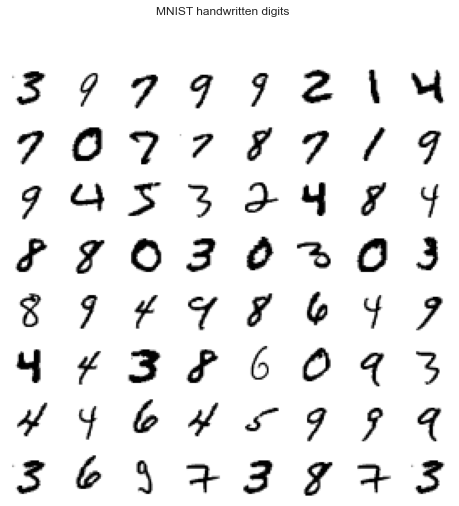

In [3]:
def plot_samples(x,figsize=(8,8)):
  f, axarr = plt.subplots(8, 8, figsize=figsize)

  for _, ax in enumerate(axarr.flat):
      ax.imshow(random.choice(x).view(28, 28), cmap="binary")
      ax.axis('off')
      
  plt.suptitle('MNIST handwritten digits')
  plt.show()

plot_samples(images)

#### 1.3) Using  the transform argument,  implement dynamic binarization,  where  the  binarized {0,1} pixels are sampled using the pixel intensity as the probability.

## 2. VAE Implementation

#### 2.2.1 Setting up the model

In [4]:
import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus
from torch.distributions import Distribution


class ReparameterizedDiagonalGaussian(Distribution):
    """
    A distribution `N(y | mu, sigma I)` compatible with the reparameterization trick given `epsilon ~ N(0, 1)`.
    """
    def __init__(self, mu: Tensor, log_sigma:Tensor):
        assert mu.shape == log_sigma.shape, f"Tensors `mu` : {mu.shape} and ` log_sigma` : {log_sigma.shape} must be of the same shape"
        self.mu = mu
        self.sigma = log_sigma.exp()
        
    def sample_epsilon(self) -> Tensor:
        """`\eps ~ N(0, I)`"""
        return torch.empty_like(self.mu).normal_()
        
    def sample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (without gradients)"""
        with torch.no_grad():
            return self.rsample()
        
    def rsample(self) -> Tensor:
        """sample `z ~ N(z | mu, sigma)` (with the reparameterization trick) """
        z=self.mu+self.sigma*self.sample_epsilon()
        return z

        
    def log_prob(self, z:Tensor) -> Tensor:
        """return the log probability: log `p(z)`"""
        normal_dist=torch.distributions.normal.Normal(self.mu,self.sigma)
        return normal_dist.log_prob(z) 


def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

##### Implement a VAE as atorch.nn.Module.

(a)  Implement a method.encode(...)that encodes a batch ofx.

(b)  Implement a method.decode(...)that decodes a batch ofz.

(c)  Implement a method.sample(...)that generates samples.

(d)  Implement a method.elbo(...)that computes the ELBO

In [23]:
class VariationalAutoencoder(nn.Module):
    """A Variational Autoencoder with
    * a Bernoulli observation model `p_\theta(x | z) = B(x | g_\theta(z))`
    * a Gaussian prior `p(z) = N(z | 0, I)`
    * a Gaussian posterior `q_\phi(z|x) = N(z | \mu(x), \sigma(x))`
    """
    
    def __init__(self, input_shape:torch.Size, latent_features:int) -> None:
        super(VariationalAutoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)
        

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
            nn.Linear(in_features=128, out_features=2*latent_features) # <- note the 2*latent_features
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=2*self.observation_features)
        )
        
        # define the parameters of the prior, chosen as p(z) = N(0, I)
        self.register_buffer('prior_params', torch.zeros(torch.Size([1, 2*latent_features])))

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def sample(self, x:Tensor, z = False):
        loss, diagnostics, outputs = vi(vae, x)
        if z:
            pz = outputs['pz']   
            return pz.sample()
        px = outputs['px']
        return px.sample()

        
    def posterior(self, x:Tensor) -> Distribution:
        """return the distribution `q(x|x) = N(z | \mu(x), \sigma(x))`"""
        
        # compute the parameters of the posterior
        h_x = self.encode(x)
        mu, log_sigma =  h_x.chunk(2, dim=-1)
        
        # return a distribution `q(x|x) = N(z | \mu(x), \sigma(x))`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def prior(self, batch_size:int=1)-> Distribution:
        """return the distribution `p(z)`"""
        prior_params = self.prior_params.expand(batch_size, *self.prior_params.shape[-1:])
        mu, log_sigma = prior_params.chunk(2, dim=-1)
        
        # return the distribution `p(z)`
        return ReparameterizedDiagonalGaussian(mu, log_sigma)
    
    def observation_model(self, z:Tensor) -> Distribution:
        """return the distribution `p(x|z)`"""
        '''
        px_logits = self.decoder(z)
        px_logits = px_logits.view(-1, *self.input_shape) # reshape the output
        self.px_logits = px_logits
        dist = torch.distributions.bernoulli.Bernoulli(logits=px_logits)
        '''
        
        h_z = self.decoder(z)
        mu, log_sigma =  h_z.chunk(2, dim=-1)
        sigma = log_sigma.exp()

        dist = torch.distributions.normal.Normal(h_z, h_z)
        
        return dist

        

    def forward(self, x) -> Dict[str, Any]:
        """compute the posterior q(z|x) (encoder), sample z~q(z|x) and return the distribution p(x|z) (decoder)"""
        
        # flatten the input
        x = x.view(x.size(0), -1)
        
        # define the posterior q(z|x) / encode x into q(z|x)
        qz = self.posterior(x)
        
        # define the prior p(z)
        pz = self.prior(batch_size=x.size(0))
        
        # sample the posterior using the reparameterization trick: z ~ q(z | x)
        z = qz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)
        
        return {'px': px, 'pz': pz, 'qz': qz, 'z': z}
    
    
    def sample_from_prior(self, batch_size:int=100):
        """sample z~p(z) and return p(x|z)"""
        
        # define the prior p(z)
        pz = self.prior(batch_size=batch_size)
        
        # sample the prior 
        z = pz.rsample()
        
        # define the observation model p(x|z) = B(x | g(z))
        px = self.observation_model(z)

        return {'px': px, 'pz': pz, 'z': z}

    def elbo(self,x:Tensor,beta=1):
        _, diagnostics, _ = vi(vae, x)

        return diagnostics['elbo']
    
def reduce(x:Tensor) -> Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

class VariationalInference(nn.Module):
    def __init__(self, beta:float=1.):
        super().__init__()
        self.beta = beta
        
    def forward(self, model:nn.Module, x:Tensor) -> Tuple[Tensor, Dict]:
        
        # forward pass through the model
        outputs = model(x)
        
        # unpack outputs
        px, pz, qz, z = [outputs[k] for k in ["px", "pz", "qz", "z"]]
        
        # evaluate log probabilities
        log_px = reduce(px.log_prob(x))
        log_pz = reduce(pz.log_prob(z))
        log_qz = reduce(qz.log_prob(z))
        
        # compute the ELBO with and without the beta parameter: 
        # `L^\beta = E_q [ log p(x|z) - \beta * D_KL(q(z|x) | p(z))`
        # where `D_KL(q(z|x) | p(z)) = log q(z|x) - log p(z
        kl = log_qz - log_px
        print(log_pz)
        elbo =log_px-kl # <- your code here
        beta_elbo =log_px-self.beta * kl # <- your code here
        
        # loss
        loss = -beta_elbo.mean()
        
        # prepare the output
        with torch.no_grad():
            diagnostics = {'elbo': elbo, 'log_px':log_px, 'kl': kl}
            
        return loss, diagnostics, outputs

In [24]:
latent_features = 2
# Vi 
vi = VariationalInference(beta=1.0)
vae = VariationalAutoencoder(images[0].shape, latent_features)

##### 2.(Report)Generate 64 samples from theuntrained modeland plot them on a 8×8 grid

In [30]:
untrained_samples = vae.sample(images)

tensor([-2.3964, -2.9941, -3.2090, -3.4809, -2.0649, -2.7540, -1.9360, -2.3571,
        -2.2763, -2.4825, -2.4092, -2.3440, -2.3752, -2.6890, -2.0224, -3.8542,
        -3.6455, -3.3475, -2.3779, -2.8421, -2.6738, -3.4156, -1.9796, -2.1078,
        -2.4060, -1.8884, -3.5860, -2.3978, -5.1130, -2.8916, -2.1067, -3.9515,
        -2.4611, -2.5187, -3.4073, -5.3442, -2.1502, -2.8863, -2.1999, -3.4143,
        -3.2451, -2.4097, -2.6358, -2.4814, -1.9076, -2.3241, -1.8458, -2.2189,
        -3.3172, -2.2572, -4.9161, -2.1576, -1.8963, -1.8913, -2.3924, -5.1695,
        -1.9201, -3.4957, -2.3832, -4.4425, -1.9377, -3.4788, -2.6220, -3.1526],
       grad_fn=<SumBackward1>)


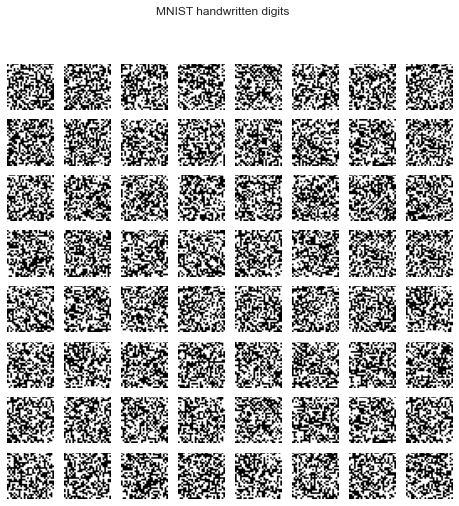

In [31]:
plot_samples(untrained_samples,figsize=(8,8))

##### (Report)Compute the ELBO of 64 samples from thetraining setusing theuntrained modeland report the number.

In [26]:
elbo = vae.elbo(images)

tensor([-1.9528, -2.8636, -2.8638, -3.1939, -2.8257, -1.9288, -2.1474, -2.0887,
        -1.8566, -1.9944, -2.7741, -4.1395, -2.8779, -2.1112, -3.0783, -6.0497,
        -2.8346, -2.4926, -2.8524, -4.2234, -4.7641, -2.1836, -2.3949, -2.2508,
        -1.8605, -2.0918, -2.9510, -2.2450, -3.1502, -4.0130, -2.1970, -2.2679,
        -4.1149, -1.9606, -2.4192, -3.6111, -4.7389, -4.7724, -7.0795, -2.2206,
        -2.5167, -2.5369, -3.3399, -2.3027, -5.2346, -2.0333, -2.8741, -2.6617,
        -2.9867, -2.7497, -4.2348, -1.9984, -4.1847, -2.7403, -2.2780, -1.9014,
        -2.1530, -5.0786, -2.0081, -2.0468, -2.1355, -3.8388, -2.3028, -4.0988],
       grad_fn=<SumBackward1>)


In [29]:
vae.elbo(images)[0]

tensor([-2.2825, -3.3066, -2.4544, -2.2735, -1.9031, -2.1691, -2.7562, -2.6787,
        -5.4627, -1.8385, -2.3311, -2.9259, -2.0163, -3.6896, -3.0115, -3.4810,
        -2.5989, -1.9545, -2.2102, -4.2598, -3.4214, -4.4306, -3.2071, -2.6116,
        -3.0521, -2.8821, -2.0004, -4.3381, -2.3950, -2.3944, -2.8117, -2.1356,
        -1.8414, -1.9141, -3.1858, -2.4922, -2.2104, -1.9511, -2.6154, -4.2765,
        -2.4136, -2.8265, -1.8996, -3.1468, -2.6050, -2.1629, -3.2057, -2.0145,
        -4.0021, -2.8068, -2.0936, -3.8128, -2.7394, -3.6047, -2.8843, -1.8467,
        -2.4557, -1.8492, -2.3658, -2.0821, -3.4345, -1.9830, -2.1377, -3.5301],
       grad_fn=<SumBackward1>)


tensor(-1086.1041, grad_fn=<SelectBackward>)

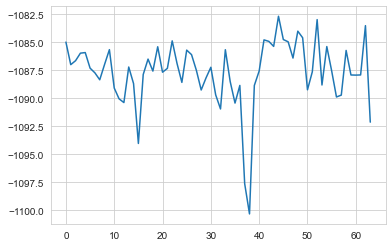

In [28]:
plt.plot(elbo.detach().numpy())

#### 2.2.2  Setting up the training

In [32]:
from collections import defaultdict

# The Adam optimizer works really well with VAEs.
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Vi 
vi = VariationalInference(beta=1.0)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

epoch = 0

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device="cpu"
print(f">> Using device: {device}")

# move the model to the device
vae = vae.to(device)

>> Using device: cpu


##### 1. Implement atrain(...)function that performs one epoch of training

In [33]:
def train(vae,train_loader):
    training_epoch_data = defaultdict(list)
    vae.train()
    
    # Go through each batch in the training dataset using the loader
    # Note that y is not necessarily known as it is here
    for x, y in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # gather data for the current bach
        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]

    return training_epoch_data
            

##### 2. Implement atest(...)function that evaluates the model on the test set.

In [34]:
def test(vae,test_loader, validation_data):
    # Evaluate on a single batch, do not propagate gradients
    with torch.no_grad():
        vae.eval()
        
        # Just load a single batch from the test loader
        x, y = next(iter(test_loader))
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)
        
        # gather data for the validation step
        for k, v in diagnostics.items():
            validation_data[k] += [v.mean().item()]
        return validation_data


##### 3. Train the model for some time (e.g.  100-200 epochs).  Remember to save thestatedictof themodel usingtorch.save!

In [35]:
# train
epoch = 0
num_epochs = 5
validation_data = defaultdict(list)

while epoch < num_epochs:
    if epoch%10 == 0:
      print("Epoch {0}/{1}".format(epoch,num_epochs))
    epoch+= 1
    
    # gather data for the full epoch
    training_epoch_data = train(vae,train_loader)
    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    validation_data = test(vae,test_loader,validation_data)
    

Epoch 0/5
tensor([-1.8427, -3.4418, -2.6371, -3.9805, -1.8951, -2.2013, -1.9652, -2.2659,
        -2.1457, -2.7752, -2.0844, -2.5960, -2.2031, -2.8091, -2.2741, -3.1020,
        -3.8969, -2.4698, -2.1573, -2.1235, -2.0738, -2.8706, -5.4850, -1.9839,
        -2.9655, -2.2070, -2.0462, -2.8815, -2.1720, -2.0333, -2.0891, -2.3547,
        -2.4912, -3.0288, -2.7361, -4.8516, -2.7459, -2.0645, -2.3362, -1.8629,
        -2.1189, -2.2383, -3.9713, -3.0911, -2.9447, -3.5212, -2.0102, -3.6817,
        -2.0944, -2.5892, -2.9558, -2.0663, -2.5410, -1.9586, -4.4716, -3.4945,
        -2.3967, -2.0645, -2.8447, -2.0586, -2.3706, -2.2945, -3.8986, -2.4225],
       grad_fn=<SumBackward1>)
tensor([-4.8749, -1.9234, -2.1456, -2.3413, -1.9579, -3.4716, -3.8538, -2.0103,
        -2.9454, -1.9705, -3.2864, -8.2938, -2.2886, -3.8472, -5.0952, -2.2822,
        -1.9593, -2.5801, -3.9458, -2.0899, -2.8132, -2.2627, -2.0575, -2.7065,
        -2.2030, -2.1616, -2.1052, -2.3323, -2.6766, -2.3856, -4.1192, -2.3961

          -6.8947,  -22.9862,  -15.9839,   -9.2497], grad_fn=<SumBackward1>)
tensor([ -5.4006,  -4.0784,  -2.3129,  -5.3416,  -9.4425,  -4.7910,  -2.3758,
         -3.6232,  -3.8393,  -8.9950,  -1.8973,  -3.1761,  -2.9659, -10.6379,
         -3.0522,  -9.5523,  -2.9034,  -4.0875,  -1.9162,  -9.3467,  -3.8243,
         -8.2277,  -3.5016, -28.1074,  -5.0526, -16.1845, -10.9406,  -8.3056,
        -12.2639,  -8.3650, -13.6236,  -8.7236,  -3.6871,  -3.0901,  -2.3156,
         -6.0311,  -2.4311,  -9.4983,  -5.1117,  -3.7619,  -2.2840,  -4.5543,
        -14.1707,  -6.9807,  -1.9527, -18.4298,  -5.1581, -10.9256,  -3.4720,
        -15.2053, -13.0580,  -8.5421,  -2.0886,  -9.0973,  -7.0925,  -7.2933,
         -7.3336,  -6.4333,  -2.2994,  -3.5802, -17.3097,  -4.7558,  -4.2874,
        -12.1689], grad_fn=<SumBackward1>)
tensor([-11.8615,  -4.2340,  -2.3929,  -1.9672,  -5.2638,  -2.5418,  -7.3328,
         -4.9267, -12.2604,  -2.9951,  -2.0545,  -4.0178,  -4.4072,  -6.9141,
         -4.8183,  -2.

         -6.3777], grad_fn=<SumBackward1>)
tensor([ -4.1034,  -2.4999,  -3.2725,  -3.4547,  -3.4561, -11.0726,  -3.7866,
         -7.8679,  -2.5524,  -2.3174, -14.1115,  -2.6904,  -7.7520,  -2.5830,
         -3.2281, -10.3420,  -4.4961,  -3.4453, -19.5095,  -6.1564,  -2.0721,
         -8.1471,  -4.3727,  -3.0106,  -2.2968,  -5.2467,  -2.8772,  -3.4997,
         -2.2129,  -2.4686,  -4.1607,  -3.2025,  -4.6163,  -2.6004,  -2.6184,
         -4.8546,  -2.3496,  -1.9298,  -3.0911,  -7.4097,  -5.0385,  -3.1561,
         -2.3672,  -7.2184,  -4.9035,  -8.6693,  -2.7386,  -4.9224,  -2.4644,
         -4.8199,  -6.0104, -14.8854,  -3.6576,  -5.1573,  -8.8220,  -4.5024,
         -6.4892,  -2.9495,  -5.3545,  -2.1274,  -3.5614,  -2.0388,  -9.5439,
        -11.6914], grad_fn=<SumBackward1>)
tensor([-11.4999,  -1.8977,  -2.2574, -15.8069,  -2.7021,  -3.1553,  -4.8211,
         -2.1678, -12.8568,  -3.9496,  -2.8646, -12.0530,  -4.3399,  -2.5657,
         -1.9161,  -2.4522,  -2.2618,  -5.8619,  -2.9601

         -2.5824], grad_fn=<SumBackward1>)
tensor([ -2.5536,  -2.3302,  -3.3714,  -3.0997,  -2.4123,  -4.2864,  -2.8693,
         -2.9849,  -6.4603,  -2.0436,  -2.1620,  -2.5592,  -2.3182,  -2.7218,
         -2.9711,  -9.2649,  -2.2003,  -2.3055,  -2.4516,  -2.3341,  -3.9560,
         -2.2848,  -5.7210,  -1.9258,  -2.2924,  -5.2592,  -3.4203,  -6.1745,
        -14.8403,  -3.1047,  -3.6033,  -2.3315,  -7.4683,  -4.1732,  -3.8301,
         -4.7037,  -6.4688,  -8.9093,  -2.5726,  -2.0561,  -6.3879,  -6.1361,
        -10.9490,  -3.3016,  -2.9414,  -3.0517,  -1.9219,  -3.2296,  -2.3103,
         -2.0063,  -2.9364,  -1.9633,  -2.4373,  -2.5092,  -1.8936,  -3.0472,
         -9.1916,  -1.8835,  -2.8453,  -1.9166, -24.5723,  -3.2829,  -8.0554,
         -1.8500], grad_fn=<SumBackward1>)
tensor([ -4.0693,  -4.4875,  -1.9917,  -4.8185,  -6.8859,  -1.9972,  -1.9166,
         -3.3060,  -7.5360,  -6.3447,  -2.7273,  -3.2384,  -2.1105, -11.6738,
         -4.0855,  -3.5206,  -6.0091,  -3.0870,  -2.6447

         -3.1772], grad_fn=<SumBackward1>)
tensor([ -2.8323,  -2.1687,  -2.8552,  -3.7947,  -7.1834,  -3.7852,  -3.0089,
         -8.2971,  -5.4973,  -2.6315,  -2.6520,  -7.6411,  -8.1048,  -3.0193,
         -6.7797,  -1.8470,  -1.9506,  -2.8750,  -1.9515,  -2.7306, -11.6649,
         -4.5730,  -2.8019,  -3.0104,  -2.0440,  -2.4684,  -9.1218,  -4.7311,
         -1.9411,  -5.0749,  -3.3096,  -2.3250,  -2.2362,  -2.2535,  -3.3338,
         -7.9071,  -2.0701,  -1.9282,  -2.5350,  -3.1746,  -8.4131, -27.8332,
         -3.5283,  -3.2153,  -2.7897,  -3.0377,  -2.8562,  -2.9095,  -1.8450,
         -2.9797,  -1.8744,  -4.1249,  -2.7812,  -3.4885,  -2.3201,  -3.9674,
         -3.1584,  -1.9331,  -2.2932,  -2.6832,  -3.7624,  -2.8512,  -4.0975,
         -2.6793], grad_fn=<SumBackward1>)
tensor([ -5.2551,  -2.0187, -10.9967,  -2.1951,  -1.9549,  -2.0115,  -3.3794,
         -3.7355,  -1.8387,  -2.2967,  -1.9974,  -5.6840,  -3.1309,  -2.0062,
        -16.0125,  -5.1572,  -1.9612,  -5.6260,  -2.1325

          -2.4442,   -3.4024,   -3.1177,   -4.1822], grad_fn=<SumBackward1>)
tensor([-75.1749, -30.9159,  -2.6408,  -1.9518,  -2.8411,  -5.5386,  -1.9868,
         -1.8826,  -2.5234,  -4.2647,  -5.7007,  -2.2270,  -2.5813, -21.4967,
         -3.3496,  -3.1419,  -2.3785,  -2.9394,  -2.6394,  -2.1663,  -3.6640,
         -2.0878,  -4.7404,  -7.3491,  -2.7819,  -2.6342,  -2.2643,  -3.4310,
         -2.4327,  -2.8762,  -3.0277,  -3.1771,  -1.9666, -22.2984, -13.2366,
         -2.1183,  -2.3364,  -2.7359, -18.0551,  -4.3144,  -3.0093,  -2.3803,
         -4.3277, -24.9693,  -6.3836,  -4.1094,  -3.5573,  -3.0085,  -2.8504,
         -3.8240,  -3.7276,  -4.0608,  -3.1997,  -3.4618,  -5.8530,  -2.1309,
         -3.4570,  -2.8941,  -6.3747,  -3.7273,  -2.3230,  -3.3276, -25.8216,
         -2.2564], grad_fn=<SumBackward1>)
tensor([ -2.4547,  -3.8471,  -6.8283, -55.9097,  -2.7006,  -2.8820, -85.3502,
         -1.9383,  -7.4335,  -2.4197,  -4.3826,  -3.8453,  -6.3831,  -2.4486,
         -4.4581,  -1.

         -95.4646,   -2.1860,   -2.2683,   -1.9107], grad_fn=<SumBackward1>)
tensor([  -3.5035,   -2.4634,   -5.5152,   -2.4556,   -3.8702,   -3.4508,
          -2.2290,   -5.9540,   -3.2171,   -3.6503,   -1.9621,   -3.0227,
          -4.2125,  -12.8494,   -3.6778,   -2.0623,  -53.7268,   -4.1471,
         -15.6698,   -1.8836,   -2.7502,   -5.6784,  -90.7155,   -1.9677,
          -1.8934,  -35.9415,   -1.9476,   -2.6934,   -1.9285,   -1.9530,
          -3.4551,   -2.1063,   -5.0395,   -3.1828,   -1.9106,   -2.6123,
          -3.8020,   -2.7242,   -2.9374,   -4.5336,   -2.9341,   -4.4587,
          -5.2335,  -35.1403,   -5.8960,  -13.7301,   -2.1464,   -2.2446,
          -6.5286,   -2.7956,  -24.5773, -330.0258,  -23.8983,   -2.4157,
          -4.2250,   -4.6106,   -2.2723,   -2.6121,   -3.1030,   -1.9732,
          -5.5885,   -2.0220,   -4.3902,   -4.2372], grad_fn=<SumBackward1>)
tensor([  -3.2923,  -27.9296,   -1.9969,   -2.7352,   -2.3982,   -1.8526,
          -3.0609,   -2.5190,   

         -2.1263], grad_fn=<SumBackward1>)
tensor([ -2.1578,  -2.1072,  -2.1773, -17.1266,  -2.3074,  -2.0287,  -2.0173,
         -1.9729,  -2.6271,  -2.0003,  -2.2337, -31.0386,  -6.2576,  -7.1278,
         -2.1652,  -2.7657,  -5.2818,  -1.9460,  -2.1347,  -2.8487,  -1.8571,
         -1.9044,  -2.8202, -31.1984,  -1.8714,  -1.9555,  -2.0445,  -2.6528,
         -3.5343,  -1.9744,  -2.5697,  -2.1319, -20.8095,  -1.8521,  -4.8874,
        -15.0491,  -2.0418,  -2.1076,  -2.3333,  -2.6686,  -2.0096,  -1.9928,
         -1.8397, -16.7201,  -9.5812,  -1.9175,  -3.9590,  -1.9833,  -4.0671,
        -11.0580,  -4.8127,  -2.3871,  -1.8853,  -2.5694,  -4.5842,  -2.2687,
         -2.6844,  -2.0195,  -1.8868, -21.3429,  -2.2703,  -1.8933,  -1.9049,
         -2.7633], grad_fn=<SumBackward1>)
tensor([  -7.4394,   -1.9143,   -2.0640,   -4.1823,   -6.7460,   -1.8996,
          -2.1500,   -1.8594,   -3.6466,   -2.3959,  -12.6302,   -1.9733,
        -116.8582,   -2.1971,   -2.4375,   -2.8404,   -1.9038,  

          -2.5906,   -2.6895,   -8.9109,   -3.2163], grad_fn=<SumBackward1>)
tensor([ -2.3591,  -2.0226,  -2.0978,  -3.9452,  -3.0589,  -2.2028, -15.5389,
         -1.8879,  -2.0817,  -2.0703,  -2.0358,  -2.0865,  -2.2746,  -2.1102,
         -1.9856,  -2.3052,  -8.5917,  -1.8669,  -2.5702,  -1.8810, -70.4373,
         -2.0375,  -2.7732,  -1.9224,  -8.3984, -18.2624,  -2.0434,  -2.2994,
         -1.9347, -23.4245, -14.6220,  -2.3663,  -2.1264,  -2.7210,  -3.7310,
        -65.1508,  -6.4209,  -2.3661,  -4.0993,  -2.0209,  -2.2493,  -1.8534,
         -3.7187,  -3.6357, -22.0426,  -2.0886,  -6.7438,  -1.9024,  -6.8547,
         -2.7425,  -2.1429,  -6.0269,  -9.6014,  -2.4435, -18.8084,  -1.8963,
         -2.1531,  -3.6466,  -1.8977, -23.2125,  -1.8838,  -2.1387,  -4.7020,
         -2.3248], grad_fn=<SumBackward1>)
tensor([  -1.9123,   -1.9823,   -2.7195,   -1.8890,  -10.5644,   -2.3030,
          -2.0386,   -2.3725,  -76.3415,   -2.0609,   -2.3608,   -5.1435,
          -2.8452, -151.9325, 

         -16.2177,   -2.1724,   -1.8559,  -43.4790], grad_fn=<SumBackward1>)
tensor([-241.1585,   -1.8740,   -2.4233,   -6.9367,   -1.9791,   -2.0893,
          -1.8878,   -2.8837,   -4.6035,   -4.6777,   -1.8505,  -18.1918,
          -1.9427,   -6.3568,   -2.6618,   -1.9962,   -3.7977,  -30.1428,
          -7.1900,   -2.4441,  -39.0266,  -13.2500,   -1.9196,   -2.6936,
          -2.1396,   -6.4479,   -1.9224,   -3.4193,   -3.2906,  -15.8469,
          -3.3566,   -6.1501,   -2.0401,   -2.5339,  -52.5095,   -2.1111,
          -1.8703,   -3.3570, -173.5388,   -2.0481,   -2.2723,   -2.2009,
          -3.1873,   -1.8976, -120.8338,   -1.9126,   -1.8919,  -14.5616,
          -1.8596,  -68.7227,   -1.8648,   -3.9282,   -2.1462,   -1.9598,
          -1.8610,   -2.1882,   -1.8385,   -2.1542,   -1.9297,   -7.1135,
          -1.8684,  -22.8609,   -1.9404,   -1.9939], grad_fn=<SumBackward1>)
tensor([  -1.9934,  -43.7292,   -2.2681,   -1.8525,   -1.9290,  -10.6464,
          -4.0801,   -1.9805,  -

         -2.0161], grad_fn=<SumBackward1>)
tensor([  -1.8672,   -1.9677,   -3.0068,  -19.2429,   -7.3629,   -1.9497,
          -2.6285,   -2.3493,  -19.8727,   -1.9293,   -1.9717,   -6.7176,
          -6.1463,   -2.4350,   -3.7975,   -1.9973,   -1.9852,   -3.4754,
          -1.9729,  -12.7121,  -70.9857,   -2.3298,   -2.4022,   -1.8789,
          -1.9441,   -3.5198,  -40.2565,   -2.3582,   -1.8705,   -2.5236,
          -3.2061,   -3.8410,   -1.9266,   -9.4781,   -1.9735,   -2.1593,
          -2.2521,   -3.3181,   -2.0433,   -6.2968,   -2.2772,   -2.2838,
          -2.0051,   -2.1491, -143.3183,  -12.1348,   -1.8919,   -2.1847,
          -1.8439,   -2.0981,   -4.7255,   -3.1858,   -1.9037,   -1.9618,
          -3.6713,   -2.0012,   -1.9085,   -2.1030,   -2.3659,   -1.9071,
          -1.9416,   -1.8672,  -37.4449,   -1.9354], grad_fn=<SumBackward1>)
tensor([-68.7343,  -2.3779,  -9.7466,  -2.4401,  -2.1409,  -1.9006,  -3.4526,
         -2.3246,  -1.8770,  -1.9171,  -2.7063,  -5.2649,  -5.

         -1.9154], grad_fn=<SumBackward1>)
tensor([   -2.1247,    -6.1541,   -26.9633,   -29.6923,   -41.5476,    -1.9027,
           -3.2935,    -1.8455, -1610.8103,    -1.8850,    -3.2099,    -8.3643,
           -1.9213,    -1.8652,    -1.8552,    -5.0881,   -13.1601,   -18.5469,
           -2.0871,    -2.9889,    -2.2724,    -1.8868,    -8.3708,   -38.1261,
           -1.8962,    -2.0596,    -1.9476,    -1.8521,    -3.3712,    -1.8542,
           -2.1950,    -2.3024,    -4.0710,   -12.7772,    -2.6227,    -2.1376,
           -2.3926,    -2.3876,  -149.5130,    -2.2190,    -1.9192,    -1.9527,
           -3.1260,  -117.0947,    -8.7685,    -1.8708,    -5.2363,    -2.1101,
           -7.8146,    -1.9395,    -1.8691,    -1.8676,    -1.8554,    -7.5645,
           -2.2869,    -2.9406,    -6.5504,    -3.0224,   -24.8019,    -3.1104,
           -1.8466,    -2.3858,    -1.8872,    -1.8585],
       grad_fn=<SumBackward1>)
tensor([-160.3492, -564.1013,   -2.8744,   -1.8831,   -1.8934,   -1.8

         -7.7577], grad_fn=<SumBackward1>)
tensor([ -15.8844,   -4.1095,   -1.8919,   -9.9584, -109.2323,   -3.0431,
          -2.4735,   -1.8824,   -5.2463,   -4.3949,   -3.5092,  -32.9755,
          -6.7672,   -3.6023,   -2.0455,   -2.1376,   -1.9746,   -1.8406,
          -2.1746,   -4.8885,   -3.0289,   -2.7303,   -2.2458,  -53.2970,
          -2.4300,   -9.2206,   -2.1492,   -1.8950,   -2.0509,   -1.8979,
          -2.2304,   -2.1137,   -2.0659,   -6.4739,   -1.9608,   -6.6156,
          -5.7176,   -3.3741,   -1.9401,   -4.1715,   -7.0634,   -6.4115,
          -2.2951,   -9.4977,   -1.8643,  -25.8369,   -4.4951,   -3.4407,
          -2.0363,   -1.8731,  -28.2137,   -4.3369,   -4.6557,   -2.5641,
          -2.4313,   -1.8966,   -2.1859,   -3.1896,   -1.9689,   -1.8869,
          -2.8146,   -1.9434,   -2.9579,   -2.0621], grad_fn=<SumBackward1>)
tensor([ -18.1446,   -2.1205,   -2.0354,   -2.9800,   -1.9866,   -2.6055,
          -1.8668,   -2.1050,   -1.9119,   -2.1201,   -7.9810,   -

         -2.7223], grad_fn=<SumBackward1>)
tensor([  -1.9221,   -2.2517,   -2.2769,   -2.3496,  -37.6633,   -2.9052,
          -3.6242,   -2.1500,   -2.7629,   -2.1615,   -2.9094,   -2.3654,
         -35.5734,   -1.9892,   -4.8532,   -1.9535,   -2.4532,   -1.9685,
          -1.8696,   -1.8624,   -2.8587,  -15.6293,   -4.9891,  -17.6067,
          -1.9402,   -2.6522,   -2.1218,   -2.3488,   -1.9339,   -1.9983,
          -2.1763,   -1.8958,   -2.2983,   -2.1330,   -2.4877,   -2.1964,
          -2.1504,   -6.6542,   -2.0010,   -2.1029,   -3.8319, -117.8558,
          -2.5165,   -1.9600,   -1.8731,  -19.9239,   -1.9379,   -1.9345,
          -2.0430,  -51.9328,   -2.5599,   -4.7291,   -3.3883,   -2.8826,
          -2.0557,   -2.1427,   -2.0000,   -2.0709,   -2.0432,   -9.6228,
         -13.2334,   -2.0039,   -2.7206,   -2.6538], grad_fn=<SumBackward1>)
tensor([ -2.4742,  -2.5010, -38.7264,  -2.0337,  -2.0786, -21.9332,  -2.3484,
         -1.9577, -14.6995,  -1.8816,  -2.0146,  -2.2599,  -6.

          -2.0799,   -5.0794,   -3.6837,   -8.7310], grad_fn=<SumBackward1>)
tensor([ -46.9147,   -2.7358,   -2.0280,   -1.9305,  -10.2145,  -25.9223,
         -16.0080,   -3.8255,   -1.9839,   -3.2400,   -2.8868,   -1.8753,
          -6.5034,   -2.2284, -129.4832,  -11.0410,   -7.6101,   -2.2042,
          -3.2762,   -3.3679,   -2.2186,   -3.3038,   -2.0117,   -4.8050,
          -2.6084,   -9.6059,   -1.8603,   -3.0764,  -14.6218,  -10.6944,
          -2.0580,   -1.9363,   -2.0480,   -4.2989,   -1.8424,   -4.3527,
        -191.6833,   -2.1128,   -4.4971,   -1.9711,   -2.1486,   -2.0969,
          -3.9883,   -2.0331,   -5.4163,   -4.4465,   -5.6618,  -15.8621,
         -18.2877,  -44.7070,   -4.0902,   -2.4515,   -8.1925,   -2.0360,
         -15.7886,   -3.1791,   -3.4208,   -1.9053,   -5.3112,   -2.3814,
          -5.0984,   -2.0974,   -8.9486,   -1.8438], grad_fn=<SumBackward1>)
tensor([  -2.1334,   -2.3166,   -2.0492,   -2.4194,  -14.6888,   -2.2647,
          -2.1576,   -2.0351,  -

        -11.4522], grad_fn=<SumBackward1>)
tensor([  -2.3220,  -10.8253,   -2.2632,  -11.0868,  -10.1102,   -9.3462,
          -2.0663,   -3.0963,   -2.6200,   -5.6438,   -2.6090,   -2.6746,
          -1.8938,  -15.9266,   -3.0357,   -7.7592,   -1.8593,   -9.6851,
          -2.0758,  -15.1840,  -13.7868,  -20.4847,   -2.9040,   -3.1805,
          -2.4441,  -10.0311,   -1.9303,  -16.6709,   -2.8948,   -2.0788,
          -5.5620,   -2.6080,   -3.3853,  -17.0999,   -3.4787,  -96.0499,
          -5.1432,   -7.9029,   -3.2170,   -5.9530,   -5.2179,   -2.1493,
          -2.8999,  -11.0328,   -2.3156,  -31.3482,   -2.5672,  -10.3937,
          -3.9702,  -17.1799, -108.9122,   -5.5460,   -1.9301,   -3.6756,
          -1.8419,   -6.1066,   -1.8864,   -2.3693,   -2.9947,   -3.3583,
          -1.9927,   -8.3998,   -1.9120,   -8.1089], grad_fn=<SumBackward1>)
tensor([-21.5443,  -2.4768,  -1.9163,  -1.8620,  -2.9007,  -2.4369,  -2.2288,
        -12.8755,  -4.0055,  -1.9992,  -4.2778,  -3.2931,  -2.

         -3.2229], grad_fn=<SumBackward1>)
tensor([ -2.0252,  -3.6419,  -4.0788,  -2.5652,  -2.0557,  -2.2187,  -1.8945,
         -1.9582,  -3.0930,  -3.7093,  -2.0855,  -2.7201,  -1.9578,  -2.3970,
        -32.2354,  -1.9823,  -3.6053,  -2.1136,  -4.1197,  -2.4576,  -3.5776,
         -5.1534,  -1.8411,  -2.2399, -20.7265,  -1.8902, -40.3811,  -2.2981,
         -1.9325,  -2.2629,  -2.9141,  -3.5106,  -1.8702,  -2.9309, -80.0160,
         -9.2866,  -2.6226,  -2.0692,  -1.9242, -16.6050,  -4.3662,  -2.5020,
         -1.8580,  -1.9595,  -2.2848,  -2.1562,  -8.0091,  -2.4381,  -2.7570,
        -15.3147,  -9.6394,  -5.3990,  -2.5278,  -3.1499,  -2.0019,  -2.2186,
        -29.1685,  -2.0704,  -2.2812,  -2.6479,  -2.1735,  -4.3146,  -2.6907,
        -28.9205], grad_fn=<SumBackward1>)
tensor([  -1.8762,   -2.4161,   -3.4897,   -3.0082,   -3.2473,   -2.0934,
          -8.5902,   -2.5404,  -44.6122,  -12.6945,   -2.2579,   -2.3715,
          -2.7032,   -2.1547,   -4.4981,   -2.1387,   -5.0891,  

         -3.1896], grad_fn=<SumBackward1>)
tensor([ -1.9016,  -1.9232,  -2.4680,  -9.0063,  -3.6264,  -1.9996,  -1.9310,
         -2.3442,  -4.5411,  -4.7047,  -2.7991,  -3.4268,  -2.6342,  -2.5956,
         -1.9115,  -3.2644,  -2.1252,  -3.2400,  -2.0507,  -4.1467,  -2.0479,
         -1.9843, -14.5456,  -2.0262,  -1.9035,  -2.8610, -30.9081,  -2.5950,
        -10.4439,  -2.4646,  -4.3132,  -2.6108,  -3.6389,  -3.0255,  -2.1268,
         -2.2955,  -1.9628,  -2.0138,  -2.1088,  -2.0183,  -3.8287,  -3.4849,
         -4.0025,  -2.6537,  -2.5556,  -2.6406,  -1.8656,  -2.8595,  -3.3025,
         -5.8138,  -2.9611,  -1.9711,  -3.7755,  -2.4063,  -1.9397,  -1.9192,
         -1.8895, -10.9358, -13.1301,  -2.0100, -90.5693,  -1.9199,  -1.8802,
         -2.0316], grad_fn=<SumBackward1>)
tensor([  -2.7671,   -2.6154,   -9.5402,  -29.1384,   -5.4910,   -1.9531,
          -3.0853,   -3.0012,   -2.5471,   -4.0883,   -2.7696,   -2.5566,
          -2.1220,   -1.9613,   -4.1215,   -2.1405, -105.6714,  

         -2.1535], grad_fn=<SumBackward1>)
tensor([-29.2746,  -2.3899,  -2.1117,  -3.7050,  -2.3428, -57.4513,  -2.1210,
         -1.9069,  -2.2473,  -3.7329,  -2.6945,  -2.0377,  -1.9905,  -3.2119,
         -1.8807,  -2.3005, -24.4799,  -2.8809,  -2.0798,  -2.2566,  -2.2312,
         -2.3072, -41.4141,  -3.5305,  -2.0223, -14.9107,  -3.4452,  -2.2558,
         -3.0517,  -3.6521,  -3.2336,  -1.9432,  -1.8452,  -2.7608,  -2.1480,
         -2.7827,  -2.4151,  -2.7448,  -2.5510,  -2.3586, -86.5001,  -2.1814,
         -2.4607,  -3.2014, -10.9982, -39.8861,  -3.3379,  -2.4746,  -5.0255,
         -2.2664,  -2.1362,  -1.9618,  -1.9926,  -3.1885,  -2.7940,  -2.0424,
         -2.1126,  -5.5226,  -3.0070,  -1.9878,  -2.6526,  -2.5099,  -2.3679,
        -38.8898], grad_fn=<SumBackward1>)
tensor([  -2.3600,   -1.9271,   -4.2825,   -2.1127,   -2.0267,   -2.0469,
          -2.0871,   -2.9179,   -4.1470,   -4.1358,   -2.0620,   -2.2407,
          -3.0966,   -2.9360,   -5.9324,   -2.1650,   -4.3995,  

          -2.1276,   -2.2378,   -2.4776,   -1.9590], grad_fn=<SumBackward1>)
tensor([  -2.1065,   -1.9180,   -1.9480,   -1.9843, -103.8052,   -9.0398,
         -17.3527,   -2.1056,   -2.0202,   -2.2086,   -2.1585,   -1.8974,
          -2.8293,   -3.0256,  -25.1628,   -2.2508,   -4.3438,   -1.8895,
          -2.5281,   -2.9418,   -1.8493,   -2.0765,   -3.1228,   -3.3150,
         -11.3043,   -8.2962,   -2.8360,   -2.1074,   -2.5597,   -1.8590,
          -1.9550,   -2.4512,   -2.2520,   -4.7819,   -9.6411,   -1.8509,
          -2.2957,   -2.0238,  -41.0280,   -4.1386,   -1.9988,   -2.1089,
          -2.4318,   -2.0992,   -5.6646,   -1.8519,   -3.0090,   -3.9767,
          -1.8858,   -2.0465,   -4.6287,   -2.1140,   -4.0724,   -2.2827,
          -1.9862,   -2.3747,   -8.6720,   -2.0519,   -1.8562,   -2.9661,
          -5.7612,   -2.3794,   -6.5097,   -2.2594], grad_fn=<SumBackward1>)
tensor([ -4.7973, -12.6426,  -4.3644,  -3.5293,  -2.3492,  -2.0562,  -2.2691,
         -2.7832,  -3.7012, 

          -5.6934,   -5.8968,   -2.0774,   -8.2497], grad_fn=<SumBackward1>)
tensor([  -3.0530,  -21.8187,   -2.0683,  -16.4437,  -78.6505,   -4.9058,
          -6.3126,   -2.1652,   -2.2931,   -1.9200,   -1.9454, -232.4481,
          -2.2790,   -4.2257,  -25.4906,  -41.4342,   -2.3005,   -2.3599,
          -3.6931,   -4.8122,   -4.8147,   -2.0970,   -8.4898,   -2.3569,
          -2.1037,  -11.3813,   -1.9171,  -17.2363,   -3.9018,   -3.6417,
          -3.1249,   -9.9443,   -1.9715,   -2.0435,   -2.9305,   -2.7010,
          -2.0068,   -1.8841,   -2.1123,   -1.8843,   -3.6356,   -4.7281,
          -3.1899,   -3.4815,   -4.6694,   -3.4152,   -1.9182,   -2.4291,
          -3.5911, -160.8577,  -19.4445,   -2.5874,   -1.8840,   -2.4160,
          -3.4021,   -1.9929,   -3.0556,   -4.8337,   -4.3731,   -3.0388,
          -2.8439,   -2.3656,   -4.4761,   -2.1125], grad_fn=<SumBackward1>)
tensor([ -3.4736,  -2.7508,  -8.2042,  -3.4423,  -3.2593, -35.4777,  -2.1401,
         -1.8835,  -2.4744, 

         -2.1022], grad_fn=<SumBackward1>)
tensor([ -3.3349,  -2.0238, -29.6527,  -2.5929,  -2.1069,  -5.2826,  -2.0602,
         -2.3201,  -3.8323,  -3.9083,  -2.3217,  -2.1253,  -2.0057,  -3.3995,
         -2.7077,  -2.0620,  -1.8387,  -4.7397,  -2.3309, -10.5091, -54.6538,
         -2.1410,  -2.4363,  -5.3435,  -1.8618, -52.6138,  -5.9065,  -1.8762,
         -5.6357,  -2.2263,  -2.2811, -30.2194,  -3.1958,  -2.5366,  -2.7094,
         -4.2698,  -6.3278,  -2.5703,  -2.4677,  -1.9503,  -2.5098,  -3.0863,
         -1.9366,  -2.3294,  -1.9905,  -6.4906,  -1.9230,  -5.4315,  -1.9077,
         -2.9040,  -3.0598,  -3.0395,  -2.6408, -42.7493,  -5.2514,  -2.0955,
         -2.9088,  -2.1616,  -2.7195,  -1.8570,  -2.3076,  -4.4837,  -1.9171,
         -2.7356], grad_fn=<SumBackward1>)
tensor([  -3.5596,   -2.5820,  -12.6573,   -3.5308,   -3.4586,   -2.2888,
          -3.4121,   -3.3966,   -1.9995,   -5.7168,   -1.9214,  -38.7302,
          -7.2300,  -13.8800,   -5.2190,   -1.8491,   -3.3941,  

         -1.9413], grad_fn=<SumBackward1>)
tensor([ -3.6911,  -4.0094,  -2.3907, -14.2473,  -2.0362,  -2.1612, -43.5048,
         -2.1938,  -2.2586,  -4.6238,  -2.3366,  -2.3506,  -1.9846,  -2.5473,
         -2.5691,  -2.7882, -11.6535,  -1.8604,  -1.9375,  -3.0249,  -2.7738,
         -3.1787,  -1.9643, -11.6846,  -2.2731,  -1.8858,  -2.1899,  -5.5356,
         -1.8922,  -4.0006,  -1.9107,  -2.0255,  -2.4330,  -4.7846,  -3.0277,
         -2.1443,  -2.0768,  -4.0273,  -2.0484,  -2.3297, -32.3374,  -1.9179,
         -1.8727,  -1.9655, -36.9471,  -1.9636,  -2.2282,  -2.3234,  -5.3060,
         -3.4640,  -2.3678,  -2.6573,  -2.0252, -15.9266,  -2.1114, -13.0649,
         -2.4729,  -2.8279,  -2.5097,  -1.8919,  -4.3933,  -2.3113,  -2.2361,
         -1.8432], grad_fn=<SumBackward1>)
tensor([   -1.8705,    -2.3719,    -2.0214,    -2.4323,    -2.0194,    -2.6939,
           -2.4105,    -3.9990,  -218.7278,    -3.7926,   -58.6445,   -64.2955,
           -1.8555,    -2.1375,    -2.9229,    -1.87

          -5.8976,   -2.4085,   -4.0275,   -3.1833], grad_fn=<SumBackward1>)
tensor([ -4.9193,  -2.2329, -29.0733,  -2.9144,  -2.4502,  -2.5832,  -2.4113,
         -2.2960,  -2.0717,  -2.0894,  -4.1693,  -1.8717,  -2.2407,  -2.2314,
        -10.7184,  -1.9344,  -2.3109,  -2.3468, -81.2881,  -2.1527,  -1.9464,
         -1.9590,  -1.9072,  -2.1246, -14.1429,  -1.8416,  -2.1788,  -2.6631,
         -9.2196,  -2.1363,  -2.1991,  -2.1895,  -1.8598,  -2.0355, -12.3478,
         -2.5131,  -1.8420,  -2.3513,  -3.1130,  -1.8614,  -2.4073,  -2.9518,
         -2.2174,  -1.9683,  -1.8889,  -3.2226,  -1.9725,  -1.9117,  -2.9630,
         -2.1340, -32.3549,  -3.7740,  -1.9376,  -1.9994,  -1.9435,  -2.6841,
         -2.0607,  -2.3032, -29.2660,  -2.7822,  -2.6846,  -2.0606,  -1.9781,
        -46.1822], grad_fn=<SumBackward1>)
tensor([ -1.9206,  -2.4219,  -1.8507,  -2.2818,  -2.3786,  -3.9848,  -2.8787,
         -2.4962,  -2.8566,  -1.8806,  -2.3549,  -2.8879,  -2.5691,  -2.2147,
        -10.9634,  -2.

          -1.9335,   -3.8768,   -1.9908,   -6.4651], grad_fn=<SumBackward1>)
tensor([ -2.0472, -22.7149,  -4.8455,  -8.6528,  -2.4300,  -2.6041,  -3.6860,
         -1.8585,  -2.5517,  -1.9471,  -4.7298,  -5.1161,  -3.3186,  -3.1421,
         -2.0140,  -2.6795,  -4.6543,  -1.9401, -31.6139, -49.8691,  -2.0257,
        -37.2903,  -2.8400,  -2.5848,  -2.3443,  -3.6570, -33.4539,  -8.0446,
         -1.8385,  -1.9792, -14.9936,  -4.6307,  -3.1253,  -3.6077,  -2.2861,
         -3.5483,  -2.2837,  -6.3002,  -3.9737,  -2.2764,  -1.8554,  -5.6998,
        -13.6877,  -2.3278,  -5.4138,  -5.0845, -22.3274,  -4.8371,  -2.2802,
         -2.4395,  -1.8493,  -6.4094,  -2.3993,  -6.0073,  -2.3263,  -1.9946,
         -3.2607,  -5.7635,  -1.9290,  -3.5202,  -1.9569,  -2.6646,  -1.8888,
         -6.0144], grad_fn=<SumBackward1>)
tensor([-15.3397,  -4.5203,  -2.1173,  -4.3597,  -2.5067,  -2.6289,  -2.4169,
         -4.3076,  -2.7163,  -6.7664, -33.7967,  -1.9509, -61.3694,  -2.0571,
         -2.1253,  -2.

         -35.7293,   -1.9966,  -10.2226,   -2.0460], grad_fn=<SumBackward1>)
tensor([ -2.1230,  -3.8649,  -1.9675,  -2.0517,  -2.3191,  -2.5032,  -2.1528,
         -4.7311, -23.8185, -13.0485,  -1.9652,  -2.1766,  -1.8647,  -2.1855,
        -68.4264,  -3.7071,  -8.7282,  -1.8891,  -1.9987, -34.3428,  -2.5768,
         -4.3265,  -2.5966,  -4.3444,  -1.9319,  -3.1179,  -1.9192,  -3.0765,
         -2.2088,  -3.3964,  -4.0689,  -2.2394,  -2.1460,  -4.4849,  -2.7450,
         -2.7057, -14.3007,  -2.3764,  -2.0444, -90.6711,  -1.9796,  -2.9272,
         -2.6119,  -5.1475,  -1.8763,  -3.4730,  -3.1979,  -2.4113,  -2.0276,
        -19.8115,  -2.2786,  -1.8664,  -2.2410,  -4.4413,  -1.8520,  -2.7765,
         -7.9418,  -2.0045,  -2.2998,  -3.2608,  -2.3966,  -5.4644,  -4.7141,
         -4.3742], grad_fn=<SumBackward1>)
tensor([ -1.9014,  -5.1226, -35.1985, -13.4521,  -4.5933,  -2.0724, -16.3031,
         -3.8472, -13.8224,  -2.4368, -51.7701,  -2.7091,  -4.9459,  -2.6258,
         -1.8517,  -3.

         -1.9213], grad_fn=<SumBackward1>)
tensor([-13.4060,  -6.5424,  -2.3925, -56.7411, -57.1147,  -1.8880,  -2.3470,
         -1.8456,  -6.1673,  -2.3457,  -5.8178,  -2.3709,  -2.1171,  -1.8624,
         -1.9380,  -2.2286,  -5.4046,  -1.8819,  -2.3215,  -2.9931,  -2.6595,
         -7.7808,  -2.4839, -23.7817,  -1.8754,  -2.6701, -28.5239,  -1.9039,
         -1.9625,  -1.9193,  -2.1598,  -2.0958,  -3.2706,  -2.0403,  -2.1332,
         -6.0016,  -1.9309,  -2.1560,  -2.2752,  -3.3747,  -2.6752,  -8.2335,
         -2.0031, -36.0074,  -3.0378,  -2.0694,  -2.0059,  -1.9659,  -2.3069,
         -1.9999,  -2.4099,  -3.0672,  -2.4065,  -2.6016,  -2.6283,  -3.5426,
         -2.7705,  -2.0209,  -2.3924,  -4.4860,  -1.9531,  -4.1584,  -1.8433,
         -3.4656], grad_fn=<SumBackward1>)
tensor([  -4.2320,   -2.2092,   -5.2678,   -3.1831,   -4.0943,   -1.8466,
          -2.0506,   -5.1922,   -2.0484,   -1.8862,   -1.9478,   -2.2316,
         -21.5499,   -3.7286,   -1.8839,   -1.8748,   -2.1945,  

         -6.3308], grad_fn=<SumBackward1>)
tensor([ -2.4033,  -2.8010,  -4.5427,  -3.5857,  -2.0852,  -6.1548,  -2.0886,
         -2.5240,  -1.9342, -10.1118,  -4.4178,  -2.0770,  -2.0065, -13.2853,
         -4.6219,  -1.8760,  -2.3852,  -4.3360,  -9.6243,  -3.8148,  -5.9504,
        -52.7466,  -3.1312,  -1.9385,  -3.9664,  -4.0673,  -3.2405,  -3.3850,
         -2.7182, -13.1159,  -6.5530,  -2.0207, -40.6080,  -7.3568,  -1.8767,
         -5.3200,  -2.2070,  -3.9130,  -1.8659,  -4.6236,  -2.3181, -54.8527,
        -41.3343,  -2.0056,  -2.1324,  -2.4351,  -2.2649,  -1.9471,  -3.0246,
         -1.9120,  -1.8537,  -3.6899,  -4.9634,  -5.6303,  -2.3260,  -4.0897,
         -2.0395, -35.5011,  -5.0860,  -3.3894,  -1.9557,  -5.2109,  -1.8458,
         -1.9135], grad_fn=<SumBackward1>)
tensor([  -1.8608,   -2.1174,   -4.4721,   -2.5889,   -6.8422,   -5.4820,
          -3.7801,   -2.4607,   -1.9077,   -4.2665,   -2.5718,  -91.6510,
          -3.3841,   -3.9398,   -2.0406,   -1.8816,   -2.3952,  

         -2.0636], grad_fn=<SumBackward1>)
tensor([  -2.6116,   -2.4431,   -2.3967,   -3.6504,  -33.3696,   -2.2616,
          -3.5119,   -3.2649,   -2.3771,   -2.8030,   -6.7769,   -3.7479,
         -48.8341,   -8.0862,  -57.3857,  -17.1620,   -2.2602,   -3.1335,
          -1.9087,   -2.0707,   -1.9553,   -2.1278,   -7.6779,   -2.0601,
          -6.0078,   -2.6269,   -4.8972,   -4.7014,   -2.2594,   -2.3612,
          -2.2171,   -4.8963,   -8.0499,   -5.2777,  -15.3324,   -4.7457,
          -2.6844,   -6.7105,  -30.6948,   -2.7795,   -1.9833,   -9.1326,
          -2.4743,   -9.2062,   -2.7544, -147.8171,   -1.9077,   -2.1471,
          -7.1126,   -6.1540,   -2.7006,   -2.0958,   -3.9643,  -65.6932,
         -11.2351,   -4.9925,   -2.3826,   -2.1197,   -2.1929,   -4.9543,
          -3.3868,   -2.3050,   -2.6609,   -3.0772], grad_fn=<SumBackward1>)
tensor([  -2.1884,   -2.0851,   -1.9404,   -4.8611,   -3.7145,   -3.4485,
          -1.8668,  -38.1884,  -23.5595,   -2.1797,   -3.2975,   -

          -2.3472,   -5.1690,   -2.1753,   -5.3120], grad_fn=<SumBackward1>)
tensor([ -2.0544,  -6.4740,  -2.6060,  -4.0069,  -2.6115, -21.7381,  -2.1764,
        -24.7307,  -5.3683,  -9.4299,  -1.8888, -45.0374,  -2.1809,  -2.1103,
         -2.5640,  -1.8958,  -1.8848,  -2.2014,  -4.9712,  -2.1121,  -5.6976,
         -2.0271,  -2.9750,  -3.1016,  -2.0305,  -1.8438,  -2.8806,  -3.2646,
         -2.1272,  -9.9332,  -2.6686, -35.6421,  -2.3047,  -1.8942, -39.8753,
         -2.0193,  -3.8998,  -1.8889,  -2.4641,  -3.1679,  -4.6385,  -2.0096,
         -4.0473,  -2.9346,  -6.2395,  -1.9859,  -3.0953,  -3.1893,  -1.9840,
        -10.0337,  -6.1652, -43.9175,  -2.0250,  -1.8723,  -1.9972,  -2.2012,
         -2.9119,  -1.9977, -36.6595,  -3.5943,  -3.5891,  -2.3822,  -1.8932,
         -2.3461], grad_fn=<SumBackward1>)
tensor([  -2.0860,   -1.8716,   -2.4071,   -3.7516,   -3.7296,  -51.2149,
          -1.9879,   -2.0168,   -2.0157,   -2.4812,   -7.5043,   -2.1915,
          -4.0710,   -2.0980, 

          -3.2585,   -6.3945,  -83.8332,  -18.9213], grad_fn=<SumBackward1>)
tensor([-69.3588,  -3.0469, -48.5220,  -4.4485,  -3.0322,  -1.9999,  -2.5892,
         -3.9166,  -3.2760,  -2.8324,  -7.7026, -15.3733, -50.3707,  -5.3699,
        -24.7060,  -2.4623,  -2.0817,  -2.5178,  -1.9017,  -2.5416,  -2.7427,
         -7.0938,  -1.9495,  -2.5210,  -2.4396, -13.0271, -12.8271,  -2.6654,
         -3.5519,  -4.3719,  -4.8982,  -3.5853,  -2.0371,  -4.2011,  -1.9395,
         -2.1233,  -1.9239,  -3.3915, -24.3298,  -2.0192,  -2.3956, -14.9088,
         -1.9297,  -1.8927,  -2.9065,  -2.9152,  -1.9898,  -3.9363, -19.2370,
         -2.6331,  -1.9124,  -5.1658,  -2.3397,  -2.3715,  -2.4508,  -3.1346,
         -1.9582,  -1.8933,  -2.0851,  -1.8475,  -3.4756,  -2.6962,  -3.7339,
         -2.2838], grad_fn=<SumBackward1>)
tensor([ -3.0000,  -1.8810,  -2.0530, -24.1398,  -2.1077, -19.8285,  -5.5116,
         -2.9005,  -3.1883,  -2.7389,  -6.0142,  -4.0364,  -1.8670,  -4.0917,
         -4.9698,  -2.

         -10.2980,  -13.8084,   -5.9340,  -34.9315], grad_fn=<SumBackward1>)
tensor([  -1.9515,   -2.4700,   -2.2253,   -1.8954,   -6.8683,   -5.3009,
          -2.0481,   -2.1517, -110.7545,   -1.8573,   -3.1366,   -2.1658,
          -4.4515,  -55.9045,  -27.9090,   -2.3856,  -21.8775,   -2.1650,
          -1.9273,   -4.5410,   -1.9071,   -4.2385,   -1.8757,   -3.2279,
          -2.7551,   -3.2602,   -4.9791,   -7.6988,   -1.9430,   -2.3174,
          -2.9994,   -3.7638,   -2.8181,   -3.5335,   -2.2711,  -53.3256,
         -52.8678,   -2.6031,   -3.9712,   -4.5733,   -1.9369,   -2.0983,
          -8.3507,   -2.3896,   -1.9594,  -24.8800,  -51.7646,   -2.2917,
          -2.5186,   -2.8752,   -3.5153,  -51.3141,   -3.5312,   -7.7371,
          -5.9418,   -2.6152,   -3.6395,   -7.1180,   -3.0205,   -5.0020,
          -6.5030,   -1.9047,   -2.4759,   -2.3682], grad_fn=<SumBackward1>)
tensor([  -2.1057,   -2.4629,   -2.1185,   -2.5025,   -6.4644,   -2.2986,
         -23.8186,   -3.4345,  -

          -3.0306,   -5.9661,   -3.2669,   -1.9172], grad_fn=<SumBackward1>)
tensor([ -10.5708,   -2.2698,   -2.0550,   -9.0844,   -1.9987,   -2.1319,
          -1.8767,   -2.5645,   -1.8813,   -1.8553,   -1.9655,   -1.8803,
          -2.8079,  -12.6642,  -48.0251,   -2.4308,   -7.2148, -132.7110,
          -6.1113,   -7.9099,  -10.5092,   -2.2160,   -4.8178,   -1.9362,
          -1.9562,   -1.8788,   -2.1879,   -4.9688,   -2.6438,   -2.0644,
          -1.9901,   -2.0257,   -1.8932,   -2.6103,   -2.9406,   -2.5934,
         -21.8750,   -3.6643,  -18.5313,  -11.5247,   -2.2344,   -1.9177,
          -2.0454,   -2.5978,   -1.8987,   -2.0519,   -2.4623,   -2.0036,
          -3.5865, -171.2006,   -3.7566,   -1.9433,   -2.0042,   -5.2594,
          -4.1316,   -2.6536,   -2.0916,   -5.2955,   -3.5926,   -8.8041,
         -12.1771,   -1.8967,   -2.2202,   -3.5790], grad_fn=<SumBackward1>)
tensor([  -1.9088,   -2.6867,   -2.5431,   -2.5877,   -4.0324,   -2.3719,
          -2.7977,   -5.1878,   

         -3.5208], grad_fn=<SumBackward1>)
tensor([  -2.1117,   -2.1353,   -7.5532,   -2.0376,  -18.4433,   -2.6143,
          -1.8735,   -1.9117,   -1.9206,   -1.9646,   -5.2537,   -3.0418,
          -2.4634,   -2.4268,   -2.3978,   -1.9022,   -2.2954,   -5.5326,
          -2.1684,   -1.9965,   -2.0065,   -2.0201,   -2.0912,   -2.9459,
          -2.0882,   -1.8771,   -2.3388,   -3.1150,   -1.9009,   -3.8152,
         -48.5733,   -2.1929,   -2.4059,   -2.0793,   -3.2722,   -2.8170,
          -2.1981,   -2.0602,   -2.1793,   -4.7545,   -2.0206, -212.9162,
          -1.9583,  -28.4244,   -1.9414,   -1.8606,   -4.2479,   -2.5304,
         -15.0347,   -9.0667, -138.0761,   -6.5012,  -22.2574,   -6.4367,
          -2.0007,  -16.2706,   -1.8669,   -2.1435,  -31.3971,   -6.3157,
          -1.8549,   -5.3512,   -2.1708,   -3.4008], grad_fn=<SumBackward1>)
tensor([  -5.7409,   -3.8924,   -2.1938,   -2.7821,   -1.8994,   -3.0133,
         -24.0385,  -58.0789,   -3.7765,   -3.2667,   -2.1504,   -

          -4.3996,   -2.8676,   -6.1331,   -2.1511], grad_fn=<SumBackward1>)
tensor([  -1.9350,   -4.2853,   -2.1995,   -6.4157,   -4.4707,   -8.0479,
          -7.2276,  -34.6171,   -1.8858,   -2.0801,   -3.2832,   -1.8526,
          -1.9325,   -2.2715,   -1.8774,   -2.2765,   -7.0313,   -4.5522,
          -5.9151,   -3.8167,   -1.9094,   -3.2581, -193.8386,   -2.6245,
          -9.5292,  -15.0540,   -2.6528,  -27.0068,  -37.2070,   -1.8384,
         -34.0840,   -1.9033,   -4.0644,   -2.0795,   -3.0925,   -2.0572,
          -2.3069,   -3.2116,   -1.9164,   -6.7602,   -1.9752,   -6.8574,
         -81.6842,   -2.5928,  -20.3375,   -8.1389,   -2.1418,  -40.7332,
         -27.7449,   -2.0506,   -2.1784,   -1.9375,   -2.5244,   -1.8706,
          -1.9477,   -2.5790,  -60.2719,   -3.3939,   -1.9992,   -3.1419,
          -1.9091,   -2.4769,   -6.4341,   -2.0310], grad_fn=<SumBackward1>)
tensor([  -3.7536,   -2.2628,  -11.8782,   -3.9036,  -10.7931,   -2.1465,
          -2.1094,   -2.4590,  -

          -3.5043,  -75.1342,   -7.6664,  -61.5906], grad_fn=<SumBackward1>)
tensor([  -2.4883,   -2.8704,   -2.0746,   -5.6549,   -1.9940,  -98.8364,
          -5.8569,   -4.4785,   -1.8471,   -4.1914,   -4.0729,   -8.3627,
          -2.0374,   -3.6103,   -1.8636,   -3.1150,   -5.4006,   -4.9643,
        -136.4568,   -6.6134,   -3.0584,   -9.6818,  -18.4335,   -4.0278,
          -2.7154, -127.5059,   -3.2889,   -4.4111,   -4.2319,   -1.9891,
          -5.6545,   -2.0172,  -16.0404,  -11.2108,  -10.0278,   -3.7484,
          -3.6565,   -3.5059,   -1.9622,  -11.3229,   -3.1301,   -4.1564,
          -7.6411,  -11.4554,  -39.2304, -157.4624,   -6.0798,   -2.7007,
         -19.0939,   -2.6258,   -1.9271,   -3.5600,   -9.5874,   -4.0520,
          -3.2164,   -5.6702,   -3.9907,   -3.9277,   -1.9447,  -23.8049,
          -4.6228,   -5.2701,   -3.9307,   -2.9679], grad_fn=<SumBackward1>)
tensor([  -2.7181,   -3.3884,   -3.7019,   -5.0983,   -2.0398,   -9.5061,
          -3.3026,  -12.3115,   

          -4.0705,   -7.7286,   -8.8884, -105.7344], grad_fn=<SumBackward1>)
tensor([  -2.2498,   -2.3668,   -3.2015,   -7.8485,   -4.5159,   -6.0524,
         -18.6329,   -6.3848,  -48.2696,   -2.1611,  -52.9455,   -5.6941,
          -2.0218,   -1.9071,   -5.1683,   -5.3638,   -3.9471,   -2.5213,
          -5.1240,   -6.7638,   -4.9663,   -5.8693,   -3.9435,  -10.5561,
         -10.3877,   -7.8043,   -4.3386,   -6.5800,   -9.2406, -121.3985,
         -11.5354,   -4.2977,  -13.6510,   -9.4691,   -4.3630,   -2.2338,
         -16.5203,   -3.1087,  -93.1539,   -2.7786,   -7.6606,   -1.9791,
          -1.9095,   -8.9464,   -2.8180,   -1.8759,  -17.4130,   -6.9416,
          -2.9103,   -2.3361,   -2.3675,   -5.3995,   -9.8723,   -6.6680,
          -3.1129,   -3.2445,   -8.2344,  -76.2506,  -38.2248,  -72.1196,
          -1.9026,   -3.2622,   -9.8922,   -1.9410], grad_fn=<SumBackward1>)
tensor([  -3.5182,   -3.0608,   -2.1413,   -5.1077,   -2.2635, -112.3207,
          -1.9032,   -4.1516,   

         -2.3660], grad_fn=<SumBackward1>)
tensor([ -4.5475,  -2.2063,  -6.1396,  -8.1408, -48.0861,  -2.4336,  -1.9128,
        -11.1222,  -4.5140,  -4.0784,  -6.2539,  -1.9792,  -2.1290,  -1.9223,
         -2.2183,  -7.3704,  -2.6371, -18.9092, -21.4440,  -3.6910,  -7.7533,
         -3.4219,  -2.3772,  -2.0460,  -4.4506,  -7.2554,  -9.8475,  -2.1069,
         -3.0652,  -4.2350,  -9.8548,  -1.8729,  -2.0357,  -4.7804,  -3.7965,
         -3.4034,  -6.4863,  -2.6941,  -1.9293,  -2.8587,  -2.6607,  -3.7244,
         -2.4401,  -1.9426,  -7.1821,  -1.9277,  -3.6658, -51.0812,  -8.9493,
         -2.4598,  -3.8303,  -4.9286,  -3.1232,  -6.1683, -23.9510,  -1.9634,
        -11.2248,  -1.9069,  -2.1893,  -7.3426,  -6.3905,  -2.1939, -87.2257,
         -9.8364], grad_fn=<SumBackward1>)
tensor([ -2.0550, -23.1262,  -1.8759,  -2.7692,  -8.5592, -73.9975,  -9.5233,
         -3.4851,  -6.7777, -67.0131,  -3.1033,  -6.1148,  -3.0771,  -4.6098,
        -11.5963,  -1.8790,  -3.1231,  -2.9858,  -8.8785

          -3.4961,  -23.0576,  -40.0930,  -11.7914], grad_fn=<SumBackward1>)
tensor([  -2.1275,   -9.9128,  -35.8551, -112.3632,  -17.4711,  -20.7270,
          -3.3669,  -10.6141,   -2.0824,  -13.6052,  -13.2294,  -23.8753,
          -7.9978,   -1.9737,  -60.4360,  -19.6672,   -2.3562,   -4.4491,
          -2.0346,   -2.2291,   -7.2904,   -4.2737,   -9.3272,  -19.6780,
          -7.7407,   -2.0562,   -6.0787,  -11.0529,   -2.2307,  -21.2188,
          -3.0881,   -9.3569,   -2.3239,   -8.8909,  -35.9346,   -8.3634,
          -2.0171,  -30.9878,  -85.7175,   -1.9778,   -2.4081,   -8.7920,
          -4.5933,   -3.0862,   -3.0390,   -3.3461,  -18.2312,   -2.2440,
          -5.6322,   -3.7746,   -5.1147,  -24.9796,  -10.1467,   -3.2761,
          -9.7913,  -20.9679,   -6.1562,  -88.5662,   -3.6591,   -7.4598,
          -1.9258,  -13.7230,   -5.1874,   -2.1619], grad_fn=<SumBackward1>)
tensor([-11.5336,  -8.6040,  -6.7369,  -3.7521,  -2.8521,  -5.2761, -69.8087,
        -71.2316,  -4.7188, 

         -3.4692], grad_fn=<SumBackward1>)
tensor([ -1.9631,  -3.5048, -21.7338,  -4.1507, -86.0451, -12.0175,  -1.9303,
         -2.4772, -11.6285, -19.1493,  -3.1689,  -4.8437,  -2.2064, -19.5278,
         -7.6274, -63.7249, -17.2617,  -3.0407,  -6.6381, -58.4271,  -4.5001,
        -21.5379, -45.0523,  -2.7088,  -7.3181, -12.2485,  -5.1529, -51.1458,
         -3.1720,  -6.2961,  -5.0696, -47.0353,  -6.2008,  -4.4384, -94.2113,
         -7.8318, -14.5360, -32.9668,  -3.2826, -19.1833,  -8.1209,  -7.4291,
         -7.6045,  -2.1480,  -5.3089,  -3.2344,  -1.9962,  -2.9516,  -2.6767,
         -3.5831, -17.9506, -10.3258,  -3.1107,  -2.0808,  -3.8895, -21.3179,
         -2.4013, -35.8182,  -3.3847, -12.0223,  -1.8984, -22.1846, -18.8162,
         -2.4839], grad_fn=<SumBackward1>)
tensor([ -2.4071, -10.9758,  -2.0662,  -3.1909,  -3.5053,  -3.1721,  -7.5851,
        -16.1042,  -3.6476,  -3.6453,  -5.6249, -19.1419, -13.0317, -42.0870,
        -89.3837, -11.3038,  -3.1830,  -5.9382,  -5.2988

          -2.1943,  -18.3775,   -2.0809,   -2.2779], grad_fn=<SumBackward1>)
tensor([ -2.7105, -10.2675,  -9.5057,  -2.0653, -14.5706,  -3.1089,  -1.8927,
        -11.7649,  -2.2092,  -2.2821, -24.9240,  -7.7725,  -3.0467, -90.7436,
        -85.9942, -14.6034,  -4.7335, -12.9692, -12.6205,  -2.3911,  -6.8052,
        -14.5653,  -1.8654,  -2.1024,  -6.0522,  -3.1476,  -2.3741,  -5.5349,
        -78.7085,  -2.7082,  -2.3457, -10.6720,  -2.4377,  -2.9049,  -2.7024,
         -7.8949,  -5.1787,  -7.1874,  -2.1002,  -2.0137, -64.0131,  -7.9463,
         -6.7128,  -3.3460,  -7.7824,  -5.8470, -14.3743, -70.8169,  -2.3922,
         -4.0765, -11.9289,  -7.5192, -47.0095, -13.3825,  -1.8650, -14.3654,
         -4.8100,  -3.4111,  -6.7312,  -4.4659,  -4.8032,  -2.4587,  -1.8556,
        -82.2909], grad_fn=<SumBackward1>)
tensor([  -2.4804,  -11.6535,   -2.2018,  -12.8214,   -5.2146,  -12.1753,
          -2.4188,  -89.3067,   -5.7729,   -4.3488,   -5.5949,   -8.5299,
          -2.4481,   -8.7319, 

          -1.8931,   -2.2258,   -2.0832,  -15.6887], grad_fn=<SumBackward1>)
tensor([  -4.3028,  -76.0667, -102.3984,   -3.0948,   -5.8988,   -2.5313,
          -2.6451,   -1.8913,   -7.2071,   -1.9462,  -22.0928,   -2.1902,
          -2.1153,   -1.9910,  -16.5627,  -10.7604,   -3.1413,  -62.7853,
          -3.9516,   -2.7299,   -1.8860,   -3.0431,   -8.3877,   -1.9336,
          -2.9795,   -2.4668,   -4.2938,   -3.5960,   -2.3188,   -1.8550,
         -72.8040,   -2.8796,   -6.2665,  -12.2630,   -5.2083,   -2.2604,
         -69.9293,   -4.5855,  -18.5534,   -3.0647,   -4.8743,   -2.3949,
          -4.2044,   -4.1505,   -9.2246,   -1.9392,   -4.3117,   -5.1657,
          -3.2116,   -1.9911,   -6.1409,   -3.1536,   -9.6296,  -60.0384,
          -2.1136,   -2.0212,   -5.7976,   -2.9383,   -2.1209,   -1.8855,
          -4.5013,   -1.9033,  -48.3765,   -3.4271], grad_fn=<SumBackward1>)
tensor([ -2.0298,  -4.7548, -69.3911, -14.9071,  -1.9348,  -2.6401, -12.9942,
         -2.3631,  -5.0486, 

          -2.5539,  -74.7274,   -2.4972,   -2.8608], grad_fn=<SumBackward1>)
tensor([ -4.5755,  -5.7884,  -2.0730,  -5.6149,  -3.6555,  -8.9749,  -2.3034,
         -9.8560, -71.1154,  -5.7114,  -5.1258, -12.7552,  -5.3074,  -9.0280,
         -5.1627,  -5.8090,  -7.6211,  -8.7802,  -2.0531,  -5.6126,  -4.5140,
         -3.5089,  -4.5036,  -6.2645,  -6.1430, -15.0406, -28.9613,  -8.5683,
        -39.9919,  -8.4756,  -2.5591,  -8.5581,  -1.9708,  -3.4807,  -4.8232,
         -7.4085,  -7.3522,  -7.0793,  -2.0464,  -3.7079,  -8.9817,  -2.8169,
         -2.1358,  -6.8634,  -2.5348, -16.2651, -53.0300,  -7.2424,  -2.0641,
         -8.8124,  -1.8730, -83.8940,  -3.5970, -12.1079, -30.4012,  -4.9676,
         -9.5855, -94.1934,  -4.0093,  -3.2002,  -1.9519,  -4.5241,  -3.6107,
         -2.5359], grad_fn=<SumBackward1>)
tensor([  -4.1210,   -6.7767,  -49.9937,   -5.6039,   -6.9104,  -13.8535,
          -4.4621,   -5.9910,   -2.7640,   -7.3967,   -2.3037,   -2.7347,
          -3.3056,   -3.6878, 

         -17.5995,   -3.3204,   -4.5986,   -6.3109], grad_fn=<SumBackward1>)
tensor([  -3.6022,   -5.5372,   -9.4650,   -7.5914,   -9.9928,   -6.4887,
          -2.7905,   -8.1304,   -3.3513,  -23.8605,   -2.8260,   -8.2246,
          -6.5736,   -5.0137,   -4.0751,   -8.3116,   -2.5564, -103.8903,
          -4.1075,   -2.2299,   -3.8453,   -2.0251,   -1.8986,  -30.2746,
         -42.3750,   -5.5329,  -85.4647,   -4.4656,   -6.1497,  -14.2335,
          -2.9854,  -45.9883,   -2.3178,   -6.9273,   -2.7405,   -3.1660,
         -21.0925,   -9.0254,   -2.7865,  -21.8448,  -12.7380,  -15.7119,
          -3.2220,   -8.2524,   -1.8627,   -6.7817,   -3.8790,  -70.2689,
          -2.1645,   -2.0088,   -2.3344,   -1.9817,   -1.9239,   -2.1146,
          -5.2371,   -3.8345,  -26.2021,   -2.3007,   -2.6701,   -3.2732,
          -4.9249,   -4.4279,   -6.3424,  -65.3760], grad_fn=<SumBackward1>)
tensor([ -7.8328,  -3.4960, -12.1727, -10.4682,  -8.2939, -62.0486,  -8.9051,
         -1.9691,  -2.4230, 

        -17.5381], grad_fn=<SumBackward1>)
tensor([  -2.9815,   -4.3761,   -5.2724,  -39.5537,   -2.2333,  -12.7021,
         -74.7896,   -6.8174,   -2.2039,  -33.6820,   -3.2473,   -5.8293,
         -82.5889,  -11.8772,  -93.1463,  -24.2477,   -9.3944,  -20.2370,
         -76.4506,  -16.1274,   -1.9247,   -2.9928,   -2.2570,  -66.6876,
          -9.8195,  -12.4291,  -35.0772,   -5.3870,   -2.6057,  -33.7709,
          -6.6183,  -10.4614,   -6.0693, -101.1957,   -5.1375,   -9.6558,
          -2.5007,   -9.9062, -107.3059,  -15.4596,   -3.3292,   -8.3047,
         -21.3029,   -4.1231,   -2.4816,  -67.4513,   -2.3685,  -55.8626,
          -2.5959,   -5.3790,   -3.3051,  -30.4760,   -9.6834,   -3.9992,
          -3.3672,  -24.4525,   -6.1284,   -3.9715, -112.4286,   -7.8000,
          -2.2387,  -20.0143,   -1.8430,  -14.5131], grad_fn=<SumBackward1>)
tensor([ -2.1291, -14.3028,  -2.1859,  -3.9517, -21.1364, -27.5459,  -5.5499,
         -3.1536, -99.2490, -48.5713, -11.8642,  -7.3516,  -3.

          -3.6554,   -2.3732,   -3.7307,  -17.6336], grad_fn=<SumBackward1>)
tensor([-76.5503, -57.3632,  -4.2169,  -8.5435, -14.7817, -13.9773,  -3.9715,
         -1.9018,  -2.3029, -16.7921, -22.8372, -21.8487, -12.4740,  -8.6494,
         -5.1590,  -4.0972,  -3.0073,  -3.9710,  -7.6451, -10.4423,  -2.2342,
        -59.3822,  -2.5463,  -2.8238,  -2.6303, -13.2673,  -4.9520,  -2.4659,
         -2.5495, -18.2998,  -2.2597,  -7.8798,  -2.8112, -15.0033,  -2.7348,
         -9.0781,  -2.8291,  -2.0295,  -4.0508,  -9.8614,  -2.5725,  -3.4185,
        -10.2001,  -4.2088,  -2.8194, -77.3196,  -2.9325, -16.5892,  -2.1485,
         -5.4920,  -2.5760, -16.3432,  -6.1972, -22.8920,  -6.8480, -20.9951,
         -2.3034, -22.4929, -12.0364,  -3.7444, -81.4560,  -4.9340,  -5.1971,
        -28.1494], grad_fn=<SumBackward1>)
tensor([  -2.5433,  -12.0113,   -4.3009, -123.5560, -102.5409,   -5.1080,
          -3.8586,  -53.6665,   -3.4952,  -13.6132,   -6.2448,   -9.5879,
          -5.1454,   -3.4041, 

          -5.0041, -112.2294,   -3.5044,   -4.2924], grad_fn=<SumBackward1>)
tensor([ -23.5369,  -17.3425,   -2.6601,   -2.9649,   -8.5162,  -16.9962,
          -7.8314,   -3.5702,   -3.8245,  -10.9345,   -6.5100,  -23.5751,
          -2.1807,  -98.8817,   -2.5294,   -2.7397,   -2.2455,  -16.6668,
         -13.6829,   -2.6908,   -2.0437,  -17.9058,  -80.4613,   -5.2348,
         -23.4895,   -4.1176,   -8.7689,  -11.8548,   -5.6027,   -4.3774,
          -9.6408,   -3.7050,   -1.9233,   -3.8929,   -3.1745,   -5.7739,
         -14.7866,   -8.4828,   -6.9445,  -10.1754,   -5.1213, -143.8303,
          -2.0132,  -12.0260,   -2.1552,  -12.1088, -144.4491,   -3.1353,
         -10.7005,   -7.5138,   -3.9905,   -3.7789,  -28.4264, -147.9760,
          -2.8132,   -6.1619,   -1.9131,   -2.3558,   -2.1018,   -2.5244,
          -6.9333,   -4.6730,   -2.6318,   -4.6649], grad_fn=<SumBackward1>)
tensor([  -2.9026,   -2.3895,   -1.8472,   -9.6608,   -2.4313,   -4.4167,
          -1.9908, -116.0201, -1

          -2.6540,   -2.0521,   -6.1373,  -12.6946], grad_fn=<SumBackward1>)
tensor([  -2.7198,   -4.1366,   -5.8355,   -3.8376,  -10.9878,   -4.3546,
          -3.1718,   -2.0785,   -5.2761,   -3.5232,   -1.9268,   -2.2518,
          -4.0505,   -2.4671,   -5.6416,   -9.3379,   -9.1310,   -3.2268,
          -7.1983,  -19.9446,   -1.8760,   -3.4863,   -3.7538,   -3.9544,
          -2.3527,   -7.1585,   -3.0188,   -2.3827,   -2.1542,   -7.9488,
          -6.8339,  -14.9962,   -2.1269,   -1.8682,   -2.2582, -133.1425,
          -2.3165,   -2.1228, -111.0377,  -23.4122,   -4.3814,  -15.6068,
          -9.3924,  -10.8004,   -3.0315,   -2.9087,   -1.9400,   -2.1014,
         -18.8403,   -2.2528,   -2.6727, -158.0286,   -7.7465,   -2.9381,
          -3.7505,   -4.7453,   -3.5950,   -9.3023,   -2.3988,   -3.3498,
          -2.3212, -155.8690,   -2.8427,   -3.6152], grad_fn=<SumBackward1>)
tensor([  -2.1687,   -2.9897,   -2.9568,   -3.1490,  -11.1495,   -3.2825,
          -8.7522,   -3.3908,   

          -8.8077,   -2.2210,  -97.1728,   -5.9923], grad_fn=<SumBackward1>)
tensor([ -13.5207,   -4.4980,   -2.3586,  -12.4450,   -3.7793,  -15.8983,
          -3.4100,  -98.6075,   -8.2925,   -3.0721, -126.0957,   -5.5295,
          -7.4117,   -1.9058,  -78.0433,   -3.3737,  -45.8214,   -2.3152,
          -1.8852,   -2.4541,   -3.1113,   -3.8263,   -2.2295,   -3.3674,
          -2.8561, -129.2223,   -4.0096,   -9.5381,   -4.1289,   -2.0514,
         -12.8406,  -10.4095,   -2.1479,   -5.7878,  -15.7256,   -5.1964,
         -10.6461, -194.8698,   -3.3812,   -2.4543,   -1.9226,   -2.6450,
         -23.0792,   -2.3440, -155.2089,  -18.1530,   -2.6743,   -2.0343,
         -19.8623, -121.8998,   -2.4244,   -1.9492,   -6.0205,   -4.0786,
          -2.6436,   -2.4316,   -9.2804,   -4.8377,   -2.5732,   -2.4433,
          -2.9473,   -4.1094,  -26.3853,   -5.5161], grad_fn=<SumBackward1>)
tensor([  -3.2200,  -84.8926,   -6.2766,   -4.6195,   -2.3469,   -8.0091,
         -15.0926,   -5.0565,  -

          -2.4893,  -10.8811,   -3.3004,   -6.0756], grad_fn=<SumBackward1>)
tensor([ -58.0376,   -5.2104,  -16.7063, -130.9078,   -6.7752, -176.4011,
          -2.1835,   -6.9264,   -1.9540,   -5.4628,   -2.8298,   -5.6061,
          -2.9746,   -6.4326,   -6.3256,   -4.0941,  -87.6339,   -4.8135,
          -2.2810, -105.2135,  -98.6869,   -2.1405, -104.8840,  -13.4129,
          -2.0906,   -2.3001,   -3.4647,   -1.9049,   -3.3606,   -3.3974,
          -3.8079,  -92.2891, -113.4976,   -8.1665,   -3.7981,  -30.3675,
          -2.1176,   -4.1838,   -4.1621,  -15.6097,  -23.8291,   -4.8495,
          -5.2754,   -1.8584,  -62.1986,   -9.7690,   -3.9409,   -6.4079,
          -2.8801,   -3.9815,   -4.5995,  -23.7210,   -2.7654, -113.7977,
          -2.0737,  -22.5262,   -1.9859,  -15.8957,   -8.7245,   -8.7811,
          -5.5306,  -10.8429,   -2.3647,   -6.9810], grad_fn=<SumBackward1>)
tensor([  -9.8053,   -4.9394, -100.9110,  -28.9895,  -20.9821, -124.2155,
         -32.8101,   -6.5906,   

          -3.0021,  -20.6459,   -2.4024,  -26.6597], grad_fn=<SumBackward1>)
tensor([ -70.3145,  -13.0460,   -3.1114,  -21.6458,  -30.8914,  -13.0546,
         -17.9442,   -3.9070,   -2.9872,  -15.7499,   -3.4792,  -12.7360,
          -4.0114,  -16.3252,   -2.4729,  -20.8541,   -4.0378,  -29.6413,
          -2.9386,   -4.2021,   -2.1210,   -5.9059,   -8.6956,  -13.6998,
          -2.4288,  -41.6478,   -9.7583,   -6.9948,   -3.3315,   -4.4676,
          -4.9612, -124.2905,   -5.7684, -121.0622,   -3.5356,   -8.1262,
          -9.5117,  -11.9643,   -6.7028,  -85.6972,   -2.9593,  -34.7039,
          -4.2909,   -5.8724,   -3.6704,  -48.1199,   -2.0134,   -2.8344,
          -2.2382,   -2.4698,   -1.9813,   -2.9842,   -2.4932,   -3.6302,
          -8.6026,   -2.3229,  -89.5535,   -7.7065,   -2.2596,   -2.9273,
          -5.2604,   -2.3103,   -3.5721,   -9.2283], grad_fn=<SumBackward1>)
tensor([  -4.6104,  -57.7672,   -3.8408,   -2.3689,  -31.5215,   -2.4244,
          -3.4972,  -10.4132,   

          -3.1650,  -12.6826, -149.9881,   -4.6393], grad_fn=<SumBackward1>)
tensor([-114.3807,  -12.5863, -172.5982, -173.7084,   -6.1307,  -10.2200,
          -2.5438,  -20.8186,  -50.0551,   -1.8967,   -2.7896,   -2.5807,
          -4.5439,  -11.9516,   -3.2473,   -3.5342,  -48.4825,   -9.8427,
         -13.5345,  -10.6675,   -2.3077,  -16.3745,   -4.8409,   -8.5278,
         -25.6305,   -4.3151,   -2.7266,  -17.6444,   -7.5750,  -17.6118,
          -2.7197,   -4.5603,   -3.3935,  -27.1583,  -10.7891,   -4.8729,
          -2.9199,   -6.3037,   -2.3757,  -10.9974,   -6.9483,  -22.2929,
         -66.4079,  -11.8728,   -2.0302,   -2.9500,   -4.2101,  -10.0415,
          -5.9703,   -3.5286,   -3.5432, -147.7377,   -2.6216,   -4.8541,
         -21.7440,   -3.1497,   -2.2959,  -19.2807,   -3.5502,  -31.1357,
         -18.6813,   -5.3220,   -6.4287,  -28.1543], grad_fn=<SumBackward1>)
tensor([  -5.0208,  -10.4649,   -2.2407,  -16.4446,   -9.2908,  -10.2404,
         -58.9713,   -7.4101,  -

          -3.6554,  -20.0218,   -2.2717,  -99.4520], grad_fn=<SumBackward1>)
tensor([  -5.0284,  -36.0420,   -2.6833,   -1.8772,   -2.1578,   -5.1406,
          -8.2928,   -5.2799,   -3.6260,   -2.8136,   -2.7500,  -26.5119,
          -5.6605,   -6.7824,   -2.5079,   -6.9527,  -43.6896,   -7.7214,
         -15.3325,   -2.8002,   -2.3529,   -4.9156,   -9.4482,   -5.8791,
          -3.0494,   -6.1381,   -2.9572,  -10.8346,  -74.0825, -115.6038,
          -3.1360,   -2.5861, -143.9586,   -2.4445,   -2.4085,   -1.8388,
          -2.6430,   -3.0615,   -3.9394,   -2.6456,  -18.1147,   -7.3759,
          -6.4303,   -2.4063,   -3.9383,  -12.8463, -184.2935, -184.9598,
        -189.0970,   -6.1776,  -13.5022,   -2.3269, -166.4771,   -1.9636,
          -2.7939,   -4.4235,  -27.0592,   -2.5601,   -3.0811,  -24.0567,
          -2.2481,   -2.9925,   -9.3696,   -8.9126], grad_fn=<SumBackward1>)
tensor([-135.5542, -125.4114,   -2.8110,   -4.1201,   -4.0626,   -3.6592,
          -6.9539,   -3.5837,  -

          -4.1936,   -3.5897,   -4.9370, -193.7318], grad_fn=<SumBackward1>)
tensor([ -92.6770,   -4.2674,   -2.9134, -150.8583,  -10.7941,  -10.3502,
        -113.6611,  -13.8624,  -88.9116,  -15.8109,   -2.6880,   -2.7247,
          -2.0522, -162.8627,   -3.1852,   -3.7423,   -9.1505,  -34.8603,
        -104.8814,   -4.7351,   -4.6502, -143.5352,   -5.3496,  -28.2751,
          -3.6874,  -23.0045,   -6.0505,  -30.5844,  -17.5841, -210.0898,
          -3.9434,   -6.2680,   -2.8294,  -22.6493,   -3.6551,   -7.5158,
          -2.3684,   -4.3863,   -2.6263,  -14.2392,   -2.1423,  -22.1238,
          -4.0524,  -15.6392,   -1.8424,  -47.3353,  -10.8761,   -5.0029,
          -9.0212,   -5.5789,   -2.0638,  -11.4549,   -2.0812,  -12.6026,
         -13.0480,   -6.1725,   -2.8975,   -5.1316,   -2.5101,  -35.0461,
          -2.3335,  -12.0126,   -2.4393,   -5.5481], grad_fn=<SumBackward1>)
tensor([  -2.3672,  -25.3194, -155.6785, -131.6596,   -1.8863,  -23.2252,
          -2.7338,   -9.6032,   

         -13.0192,   -4.1412,   -1.9524,  -15.8215], grad_fn=<SumBackward1>)
tensor([  -2.5413,   -7.5141, -190.2970,   -9.1221,   -2.7404,   -3.1754,
          -2.7935,  -34.1444,   -2.7860,  -42.5242,   -2.2983,   -9.2201,
         -16.7223, -135.4101, -105.9105,   -2.2035,   -9.6960,   -3.9185,
         -42.6435,  -12.0668,   -5.3753,   -9.1777,   -4.7301,   -3.4257,
        -145.1058,   -9.5798,  -16.0935,   -5.1403, -115.2994,   -8.0955,
          -5.7454,   -7.3836,   -8.7306,   -6.6146, -158.2356,   -6.8620,
          -2.5721,   -5.7210,   -1.9681,   -8.5925,   -9.2149,  -27.4132,
          -2.7986,   -4.7239, -134.0656,   -6.4135,   -2.9287,   -5.6571,
          -4.2974,   -6.6176,   -3.6073,   -2.2258,  -20.1731,   -6.2641,
          -2.9316,  -13.8769,   -1.9285,  -11.4233,   -2.6708,   -8.5655,
          -1.9575,  -17.4248,   -3.9984,  -11.4884], grad_fn=<SumBackward1>)
tensor([  -3.9725,   -3.9790,   -2.4219,   -7.7736,   -2.1671,  -33.0739,
          -2.8408,  -13.7676,   

          -2.9980,   -2.2339,  -13.7339,   -3.2052], grad_fn=<SumBackward1>)
tensor([  -3.7496,   -4.1920,   -4.0177,   -5.8233,  -13.4560,   -2.4510,
          -4.4137,   -8.8255,   -7.7634, -127.4480,   -6.6817,   -2.7540,
          -6.2426,   -2.2307,  -12.1005,   -3.4453,   -4.6110,   -4.0173,
          -5.6754,   -3.3116,  -11.3406,   -4.6324,   -3.9412,   -8.9287,
          -2.1817,   -2.6179,   -2.1966,   -2.3314,   -1.9494,   -2.1996,
          -3.8114,   -4.3459,  -14.5920,   -2.8296, -136.7263,   -2.4807,
         -15.2370,  -10.2511,  -16.8423,  -31.4660,   -3.4976,  -16.2012,
          -4.0425,   -3.4262,  -12.1154,   -2.7970,   -3.1043,   -2.9248,
          -4.1067, -195.0404, -120.4399,   -9.9277,  -13.4212,   -5.1744,
          -3.0734,   -1.8848,  -81.3310,   -1.9265,   -2.3627,   -9.2190,
         -29.4588,   -3.3563,   -2.1119,   -3.2593], grad_fn=<SumBackward1>)
tensor([  -9.9499,   -3.1548,   -2.5543,   -8.4207,   -7.2403,  -12.0826,
         -31.9239,  -13.8121,   

        -175.8434,   -2.3406,  -18.0432,  -14.9708], grad_fn=<SumBackward1>)
tensor([ -13.8310,  -41.7995,   -1.8595,  -16.9715,  -13.2056,   -2.2079,
          -3.3808,   -3.9680,   -2.3879,   -7.3625, -190.4148,   -7.9647,
          -3.2090,  -99.6064,   -3.7235,   -5.5386,  -20.5251,  -10.6904,
          -5.9364,  -12.8451,   -3.5462,   -6.4752,   -2.1486,  -29.0797,
         -16.9096,  -14.0333,   -9.9110,   -4.4637,  -13.4010,  -10.9635,
        -139.2257,  -12.9095,  -12.6236,   -4.2756,   -2.8185,   -4.4417,
          -2.0411,  -16.4954,  -12.5836,   -9.0834,   -2.8760,   -5.9006,
          -2.2179,   -4.6112,   -3.2628,   -8.8303,   -5.5259,   -3.7545,
          -7.1134,   -4.5397,   -6.1514,   -6.6081,   -2.7256,  -17.6788,
          -3.3272,   -8.4730,   -2.7246,  -11.6788,   -4.2700,   -6.7116,
          -7.0815,  -77.2799,  -34.2330,   -7.4181], grad_fn=<SumBackward1>)
tensor([  -2.1862,   -4.7372,   -2.2205,  -17.6893,   -9.7068,  -80.5154,
          -2.1162,   -5.8586,  -

         -11.4139,   -1.8952,  -12.8890,   -2.7665], grad_fn=<SumBackward1>)
tensor([  -3.6982,  -10.6858,   -3.4818,   -2.1345,   -1.9900,  -10.7482,
          -4.0556,  -12.5122,   -8.2496,   -6.3125,   -2.7879,  -24.6291,
          -2.6636,   -4.0049, -195.0856,   -2.5722,  -40.0371,   -3.4821,
          -2.1380,   -6.3252,  -22.5733,  -99.4353,   -2.8095,   -1.9593,
          -5.7059,   -5.0718,   -8.3409,   -8.3734,   -9.5363,  -15.3801,
          -2.2459, -230.2701,   -6.6232,   -2.0954,   -2.1362,   -4.5496,
          -3.2428, -146.4247,   -2.9776,  -12.9722,   -2.4787,  -11.5419,
         -77.8565,   -3.9789,  -18.2472,   -4.8548,   -2.6227,   -4.2964,
         -11.3599,   -9.0647,   -3.4636,   -3.2576,   -4.7407,  -32.3751,
         -74.8596,  -10.2274,  -11.0331,  -15.4877,   -1.9934,   -5.1398,
          -2.9612,   -8.2969,   -7.4918,  -20.3914], grad_fn=<SumBackward1>)
tensor([-174.5087,   -2.9722,   -7.0166,   -4.2801,  -43.5747,   -3.9471,
          -3.2900,   -2.6406,  -

          -2.8609,  -21.1400,  -11.4700,   -6.2111], grad_fn=<SumBackward1>)
tensor([  -5.3741,   -5.1355,  -20.9351,  -14.2218,   -2.4639,   -4.4310,
          -2.2802, -122.4749,   -3.0193,   -5.6419,   -4.5784,   -7.9520,
         -38.2426,   -4.6451,   -2.8629,  -10.3047, -169.4243,   -5.2475,
          -2.4903,   -5.7415,  -12.5681,   -6.6040,  -35.8566,   -3.4850,
        -160.2663,  -48.3338,  -21.9177,   -3.0532,  -12.1978,   -6.1853,
          -5.6627,  -40.1178,  -10.9707,   -7.4806,  -50.5921, -201.9564,
          -8.8041,  -16.2105,   -7.1618,   -2.1883,   -4.0223,  -12.4675,
          -6.4633,   -8.0099,   -4.9783,  -21.5712,  -12.9196,  -17.1115,
          -2.3588, -116.9942,   -2.1292,  -32.8481,   -2.8635, -192.2654,
          -2.2828,  -13.3084,  -16.9785,   -2.2809,   -2.8199,   -3.0832,
          -2.4512,   -7.3293,  -13.4326,  -28.7446], grad_fn=<SumBackward1>)
tensor([  -2.8659,  -33.7380,   -2.5757,   -2.6339,   -3.8529, -131.7503,
          -1.9140,   -4.3314,  -

        -153.6235,   -7.2155,   -6.2216, -159.9955], grad_fn=<SumBackward1>)
tensor([ -11.0035,   -2.8586,   -4.6336,   -3.2018, -153.3590,   -1.9410,
          -7.4535,   -3.8298,   -4.0648,   -2.1170,  -20.6522,   -2.7374,
          -3.9215,   -2.5805,   -5.4281,   -1.9793,   -5.7331,   -6.0402,
          -2.4331,   -2.9758, -195.1969,   -4.4770, -225.6478,   -2.4503,
         -11.1297,   -2.3826,   -2.2057,  -14.9227,  -96.2521,   -2.9006,
          -2.9399,   -2.2992, -188.8837,   -4.8256,   -4.1665,   -2.3651,
          -4.0974,   -3.7882,   -8.2442,   -3.3648,   -5.1561,   -2.0482,
          -1.8643, -167.9768,   -3.8515,   -2.4289,   -2.1863,   -4.5837,
          -3.7059,   -2.9621,   -9.4287,   -2.7694,  -23.0334,   -6.7064,
         -15.6899,   -2.9916,   -5.3048,   -2.9147,  -19.0081,   -2.0054,
          -3.9646,   -2.4693,  -23.2826,  -43.1710], grad_fn=<SumBackward1>)
tensor([  -2.9365,   -2.4815,   -1.9665,   -2.0114,   -8.3858,   -2.1902,
          -3.0206, -109.6978,   

          -4.0150,   -8.5225,   -3.6878,   -9.5437], grad_fn=<SumBackward1>)
tensor([ -76.2949,  -39.5143,   -7.5608,  -25.0803,  -13.1492,   -6.9198,
          -2.1888,  -42.4290,   -7.2109,  -12.1761,   -4.2442,  -73.6835,
          -3.3500, -184.6486,  -12.3400,   -9.4526,   -2.7719,  -17.1785,
          -3.4847,   -3.6338,   -1.9405,  -29.2107,   -2.1801,  -18.0258,
          -2.8031,   -8.0977,   -2.4628,  -43.0753,   -4.2311,   -4.4585,
         -23.8969,  -41.8614,   -4.3012, -250.2775,   -4.7750,  -21.4966,
         -54.5620,  -16.4323,   -5.1329,   -5.2134,  -10.2630,  -36.5929,
         -18.9866,  -18.6674,   -2.2620,   -3.1988,   -2.6391,  -64.4775,
          -2.8036,   -8.0415,  -25.2555, -187.9794,  -21.8865,  -38.8784,
        -160.3448,  -37.9681,   -2.6578,   -5.3332,   -2.1629, -179.9022,
          -3.1270, -211.7468,  -12.7760,   -2.2056], grad_fn=<SumBackward1>)
tensor([ -42.9046,  -22.2879,   -5.9215,   -5.5175,   -5.9960,   -6.9490,
        -137.3472,  -91.1583,   

          -4.8864,   -6.6748,   -2.2783,   -5.1630], grad_fn=<SumBackward1>)
tensor([ -86.7869,   -3.3460, -277.1871,   -3.9355,   -5.5169,  -12.9692,
          -2.3332,  -30.9419,   -3.5795,   -5.1001,   -4.0087,   -4.7268,
         -11.0837,  -42.5847,   -2.2359, -107.4389,   -2.8965,   -3.5185,
          -3.4706,   -6.2354,  -38.4493,   -9.3141,  -34.9535,   -5.7664,
          -3.6461,   -8.9005,   -3.0946,  -42.6737, -104.7955,   -2.5251,
          -2.9510,   -6.5517,   -2.4420,  -50.0427, -128.2011, -160.3995,
          -2.6633,   -6.4098,  -79.9539,   -5.4148,   -2.8421,   -8.4888,
          -5.5420,   -2.8896,  -26.8479,  -10.3003,   -4.5099,  -20.6062,
          -5.9054,   -6.3771,  -10.0553,   -3.9402,  -23.7484,   -3.2109,
         -36.6350,  -16.0766,   -7.0511,   -1.8764,   -2.7358,  -16.7536,
          -4.4304,  -12.8465,   -2.4768,   -3.5808], grad_fn=<SumBackward1>)
tensor([ -15.1708,   -4.2016,   -4.1816,   -3.5602,  -23.3672,   -4.3286,
          -5.3167,   -5.3994,   

          -3.4032,   -3.3546,   -5.2488,   -7.0225], grad_fn=<SumBackward1>)
tensor([  -3.0645,   -6.1837,   -2.2402,  -32.1165,   -3.0066,   -7.3324,
         -23.6717,  -22.6943,   -2.5563,  -30.6434,   -8.4611, -241.1283,
          -3.6175,  -17.3348,   -2.7528,   -5.3003,   -2.2433,   -2.3955,
        -236.5818,  -18.2463,   -2.4082,   -7.0852,   -3.0048,  -39.7697,
          -2.4206,   -9.8341,   -2.4224,  -12.4584,   -2.2703,  -33.6818,
        -227.2278,  -15.0437,   -2.8375,   -5.7305,   -1.9766,   -1.8742,
          -3.4470,   -9.8532,  -22.7102,  -11.3093,  -98.3920,   -8.7295,
          -3.7712,   -2.4537,   -1.9331,   -8.2067,   -3.2191,   -3.4032,
          -3.2926,  -12.1879,  -86.5289,  -35.5555,   -2.0669,   -3.2428,
        -148.5701,   -4.9918,  -30.0452,   -5.0374,   -8.4004,   -3.7657,
          -3.1631,   -1.8862,   -2.6442,  -11.2523], grad_fn=<SumBackward1>)
tensor([  -1.8621, -250.8475,   -2.1891,  -31.6155,   -9.5320,   -3.4597,
         -48.1968,   -4.3932,   

          -3.9017,   -5.3395, -269.2353,  -70.3046], grad_fn=<SumBackward1>)
tensor([  -1.8627,  -46.8227,  -10.9340, -172.6063,  -38.2405,   -2.1431,
         -15.7101,  -37.8233,   -2.0281,  -24.6648,   -3.7184,  -48.7344,
          -3.6325,   -6.2348,  -27.7477,  -12.2693,   -2.2392,  -13.6131,
          -9.2906,   -9.7598,   -1.9024,  -72.8792,   -2.6562,  -53.4317,
        -208.4839,  -33.8940,   -2.4376,   -6.8813,   -4.2808,  -20.8871,
         -18.1278,   -4.4656,   -2.5709,   -5.4970,   -5.7472,   -2.6925,
          -6.2438,   -4.2356, -245.8860,  -44.1629,   -5.2575,  -33.2693,
          -3.7631,  -38.6948,   -7.5451,  -13.6171,   -2.0846,  -35.0815,
          -3.1734,  -16.2675,  -15.2878,  -61.0098,   -2.3008,  -42.5369,
         -46.2537, -133.3366,  -10.7817,   -2.9196,   -3.5787,   -2.5604,
        -182.0897,   -2.5219,   -2.8724,   -6.1070], grad_fn=<SumBackward1>)
tensor([  -3.2288,  -44.6067,   -3.0981,   -2.3329,   -2.6203,  -38.6327,
        -218.7773, -179.2169,  -

        -208.5597,  -40.7761,   -4.5588,   -5.7666], grad_fn=<SumBackward1>)
tensor([ -40.9961,  -15.9419,   -8.2452,  -15.5086,   -2.4490, -207.1317,
          -2.0084,   -2.7601,  -13.7532,   -1.9355,  -30.0890,   -2.2021,
          -2.1364,   -2.2462,   -3.3318,  -25.6349,  -35.4921, -156.5349,
          -2.8828,   -1.8996,   -5.1393,  -10.4771, -113.3492,  -16.6112,
          -1.9710,   -6.5179,   -2.7447, -204.8859,   -2.9903,  -30.8464,
          -3.7960,  -41.4714,   -1.9244,   -3.5164,   -2.8240, -145.6776,
         -62.4978,   -4.9668,  -57.7628,   -4.2156,   -2.3971,   -2.2000,
          -3.3094,   -4.1063,   -6.9307,  -15.5069,   -3.1886,  -22.8572,
          -2.5665,   -2.2782,   -2.1572,   -2.9683, -241.7743,   -6.5428,
          -8.3563,   -8.9821,  -20.1943,   -9.7547,   -8.4726,   -3.0134,
          -4.0132,   -2.3983,  -14.0402,   -3.1567], grad_fn=<SumBackward1>)
tensor([ -12.6502,   -2.7821,   -3.9015,   -8.1719,   -3.3691,   -7.9665,
        -121.6905,  -14.7665, -1

          -3.7271,  -23.9825,  -63.4263,   -6.0744], grad_fn=<SumBackward1>)
tensor([ -24.4201,   -2.9847,  -11.7423,   -4.6008,   -2.9971,  -11.8311,
         -23.0718,  -85.7041,   -3.2351,   -5.2657,  -12.1415,   -6.2908,
          -5.3722,   -7.1977,  -30.3637,   -7.5191, -165.8592,  -16.5702,
          -8.1278,   -5.7328,  -22.4663,  -44.0342,   -7.7682,   -4.4313,
          -9.5526,  -25.5710,   -2.9661,   -5.4323,  -18.5180,  -23.6493,
          -1.8976,   -5.8092,   -2.0524,   -6.7373,   -3.7072, -254.2359,
         -14.4242,  -43.0773,   -2.6606,  -45.5707,  -16.2705,  -30.4426,
          -8.9255, -260.1286,   -2.1154,   -8.6056,   -4.6366,  -35.9724,
          -2.3947,   -2.5471,   -7.3466,  -21.4921,   -7.5518,   -4.8672,
          -2.9367,   -8.8234,   -3.9830,  -22.1413,   -2.8858,  -80.8103,
          -1.9333,  -13.0826,   -2.4516, -208.0412], grad_fn=<SumBackward1>)
tensor([ -19.7946,  -99.3294,   -6.4619, -265.0041,   -3.9059,  -68.7754,
          -8.3121, -244.2786,   

          -3.4697,   -6.9712,   -6.1124,   -5.3136], grad_fn=<SumBackward1>)
tensor([ -61.2472,   -2.0371,   -2.4371,  -27.7175, -222.0773,   -3.3992,
          -2.3805,   -2.3277,  -11.1460,   -4.3958,  -19.8282,   -2.0365,
          -5.7507,  -20.8809, -264.6343,   -3.0317,   -3.8550,   -3.2011,
          -4.6582,   -6.8111,  -22.2050,   -2.5053,   -2.8695,   -6.9517,
          -2.1448,   -3.3371,   -3.3606,   -3.7205,  -62.8887,   -7.5124,
          -7.1291,   -1.9765,  -42.1178,   -2.0473,   -2.5988,   -2.8959,
          -2.5904,   -2.7746,   -4.7620,   -3.1409,   -2.8164,   -2.7072,
         -29.5900,   -2.0905,   -2.4993,  -24.9700,   -4.9870,   -5.2700,
         -24.2705, -144.1059,  -20.0563,  -10.8410,   -2.5353,   -5.8724,
          -6.1747,   -2.8899,   -8.5045,   -2.2987,   -2.6882,   -4.3484,
        -342.1035,   -3.5526,   -2.9659,  -29.5475], grad_fn=<SumBackward1>)
tensor([  -2.1828,   -3.8715,  -38.9904,   -3.3979,   -2.8866,  -29.1790,
        -255.8888, -297.3481,   

         -10.7796,   -3.1119,   -6.7597,   -2.4489])
tensor([  -5.2365,  -30.4244,   -5.9408, -229.5397,   -6.1367,  -10.7230,
        -112.3494,   -4.2995, -193.1167,   -9.9732,   -3.5801,  -49.0436,
          -2.1405,   -9.5799, -260.1813,   -6.0238,   -3.3647,  -31.7436,
          -2.9881,  -27.5404,   -3.7139,  -39.1993,  -11.8069, -245.2543,
          -4.6302,   -2.6668,   -6.9996,   -2.8318,   -2.0316,  -25.5071,
          -1.9619,  -47.3506,   -5.9737,  -15.3742,  -10.6391,  -26.1022,
          -5.3490,  -26.9599,   -2.3693,   -5.6632, -358.1560,   -7.2001,
         -36.8103,  -21.5804,   -1.9072,   -5.9135,   -2.4955,  -26.5164,
          -2.0397,   -4.1379,   -2.7857,  -32.0629,  -27.9085,  -12.4128,
          -8.3683,  -11.2531,  -13.7983,   -9.2080,   -1.9930, -314.8947,
         -12.9118,  -22.5311,   -5.9047,  -24.9869], grad_fn=<SumBackward1>)
tensor([  -3.5665,  -67.8826,  -11.1724, -189.6021,   -5.9601,   -3.6194,
          -2.6496,   -8.0620, -266.7216,   -9.4153,   -2

         -11.2741,  -57.3084,   -4.4526,   -2.0599], grad_fn=<SumBackward1>)
tensor([  -3.1273,   -7.4744,   -2.0203,  -26.9240,  -17.4751,  -30.6409,
          -5.0756,   -8.0539,   -2.2632,   -6.1699,   -3.4248,   -4.0221,
          -9.8323,  -32.8317,   -2.6349,  -34.1120,   -2.4600,  -16.0341,
          -2.5299,   -4.2204,  -16.1637,   -3.1109,   -8.1088,  -15.4045,
         -28.3525,   -3.7628,  -50.1178,   -9.8614,   -2.5485,   -6.2535,
         -36.3670,  -19.9235,   -2.9376,  -16.1278,  -15.2745,   -4.6010,
          -4.6119,   -3.8073,   -4.4961,   -4.1026,   -1.9074, -184.1959,
         -26.4834,  -16.1520,   -6.5249,  -38.2568,  -62.7749,  -20.3846,
          -2.2952,  -11.4093,   -2.6645,  -85.6468,  -34.3742,   -3.1911,
          -2.5395,   -5.5030,   -2.0986,   -7.9354,   -2.6882,  -18.0158,
          -1.9225,  -36.6427,  -28.6353,  -23.3091], grad_fn=<SumBackward1>)
tensor([  -1.9964,   -3.4231,  -42.3118,  -12.4164,   -2.0539,  -21.3897,
          -3.5122,  -18.0103,   

          -2.9114,  -76.1618,  -34.9002,  -18.5760], grad_fn=<SumBackward1>)
tensor([  -2.9391,  -33.8879,   -2.5218, -226.9367,   -3.0391,  -15.4210,
          -2.2202,   -2.5129,   -2.7831,   -2.2419,   -4.5879,   -3.7138,
        -246.7175,   -9.5855,   -2.5043,  -15.2750,   -2.9990,   -2.9786,
          -3.3687,   -6.9719,  -50.9225,  -36.5719,   -4.1034, -343.0100,
         -15.0087,  -38.4381,   -6.8193,   -4.9279,   -3.8654,   -2.2577,
          -5.8067,  -11.1882,   -3.8896,   -4.4854, -198.8297,   -9.3863,
          -1.8400,  -62.5929,   -2.4655, -215.5199,  -36.8779,   -4.0015,
          -4.6199,   -2.5798, -134.5972,   -8.0088,  -19.3929,  -13.2921,
         -13.1302,  -31.0286,  -12.1451,  -13.7130,  -27.9034,  -10.5433,
          -2.4896,  -14.4559, -226.2288,  -34.1233,   -2.6964, -222.0956,
          -2.0085,  -66.0446,   -2.9037, -223.8380], grad_fn=<SumBackward1>)
tensor([ -30.8264,  -21.7354,   -2.8604,   -5.3568,   -2.4545,  -55.9530,
        -285.8861,   -8.2219,   

          -8.7916,   -3.6648,   -2.5137,   -9.9988], grad_fn=<SumBackward1>)
tensor([ -81.1528,   -8.5250,   -4.9004,  -16.5173,  -39.5584,   -4.2088,
          -8.8732,  -21.2875,   -6.2650,  -17.7455, -319.4499, -243.3700,
         -10.6450,   -9.9636,  -11.0901,   -2.6331,   -4.5737,   -5.8050,
         -12.3782,   -5.9615,   -5.6822,   -8.2750,   -2.4042,  -28.5157,
         -47.8265,  -23.7647,   -1.9956,  -17.9311,   -2.2403,  -10.2650,
          -1.8514,   -3.3293,   -3.4712,   -8.7427,   -5.1420,   -6.4318,
         -11.2749,   -4.4626, -215.1617,   -9.4891,   -3.4244,  -51.6676,
         -43.9599,   -5.6698,   -5.1062, -214.4683,   -5.5071,   -9.5487,
         -27.3245, -206.0895,   -2.6616,   -7.7414,   -3.2432,   -3.8340,
         -75.8524,  -34.6204,  -31.8468, -232.5943, -173.1496,  -14.4507,
        -335.0911, -299.2524,   -3.4217,   -3.5282], grad_fn=<SumBackward1>)
tensor([  -5.6649,   -4.3649,  -21.5210,  -17.2415,   -2.3460,   -8.7041,
          -8.2001,   -3.3605,  -

         -47.8366,   -2.4106,   -2.0780,  -15.5204], grad_fn=<SumBackward1>)
tensor([ -38.0708,  -14.5490,   -6.6974, -244.5644,   -9.1512,   -6.6431,
          -9.3788,  -28.7996, -359.6229,  -17.9468,   -2.8511,  -53.7182,
        -113.9868,  -52.6408,   -3.5745,  -10.8895,   -1.8621,   -4.6180,
          -2.3471,   -3.0882,   -3.3717,  -14.8679,  -14.0754,   -3.2545,
          -8.2274,  -10.0251,  -10.8128,  -76.3005,  -31.1172, -310.4194,
          -4.2032,  -20.5174,   -6.9427,  -11.5907,  -81.7777,   -7.5131,
          -2.7883,  -16.2958,  -11.7389,  -24.3173,   -2.1287,   -6.4788,
          -3.0112,  -23.0582,   -2.1654,   -8.6841,  -13.8647,  -58.0740,
        -216.6619, -187.0044,   -9.8865,  -36.3844,   -4.5417,  -16.8169,
         -21.6624,   -2.6548, -241.3765,  -17.1463,  -50.5425,  -17.8569,
          -2.4167,  -13.4209,  -40.1108,  -25.2083], grad_fn=<SumBackward1>)
tensor([  -2.5401,   -7.8046,   -2.1925,  -69.5692,   -2.0658, -256.1135,
          -2.3649,  -39.0146,   

          -5.2644,   -8.5903,   -2.4393,  -13.1104], grad_fn=<SumBackward1>)
tensor([ -31.9687,  -10.7259,  -11.4255,  -10.5162,   -2.1566,   -8.0779,
         -16.2723,   -6.5865, -292.6385,  -45.5299,   -2.1384, -241.5228,
          -2.7847, -224.0464,   -4.9097,   -6.2055,  -15.2745,   -4.9986,
          -2.7654, -298.2292,   -2.9550,  -47.3403,  -10.3470, -294.6461,
         -11.0526,   -5.8342,   -2.7778,   -3.0553,   -8.1711,   -3.1361,
          -2.4362,  -23.6856,  -14.7693,   -6.6945,   -3.5887,  -46.3144,
        -278.3605,   -2.8786,   -4.4181,  -12.1764,   -2.1880,  -68.9893,
          -9.9167, -144.2064,  -27.3470,  -68.8876,   -6.6708,  -12.8995,
         -12.2524,   -5.2083,   -6.2475,  -44.7357,   -3.5912,  -10.4840,
          -2.3853,  -15.2420,   -6.6406,  -14.5254, -141.2809,  -13.5780,
          -2.5603,  -59.7558,   -9.0480, -197.6458], grad_fn=<SumBackward1>)
tensor([ -30.6853,  -47.0019,  -19.5270,   -2.6953,  -13.4068,   -3.8814,
          -1.8469,  -26.8697,   

          -4.2338,   -7.8819,   -2.3642,   -9.0357], grad_fn=<SumBackward1>)
tensor([ -25.9106,   -8.8060,   -2.0198,   -7.1367,   -4.5376,  -60.6152,
         -17.8719,  -93.9075,   -2.4427, -235.0466,   -4.1148,  -75.0204,
          -1.8837, -221.0807,  -15.5087,  -55.7183, -186.9213,  -22.4325,
          -2.0630,  -48.4556,  -11.8185,  -12.9294,   -6.8555,   -6.0969,
         -62.4693,   -6.0823,   -3.2570,  -53.9677,  -19.6502,  -76.6123,
          -5.2901,  -16.9663,   -3.1184,   -7.7075,   -2.1630,  -30.3626,
        -201.7480,  -19.3037,   -4.9648,  -70.7446,   -2.5787,  -36.3424,
          -2.2115,   -6.7863,   -8.8120,   -7.6414,   -3.4216,   -6.2142,
         -33.6699, -232.2039,  -16.9516,  -18.6755,  -73.4530,   -7.2487,
          -2.8575,  -35.0556,   -2.9657,  -15.0179,  -11.4782,  -48.2006,
          -2.2825,  -44.5809,   -6.3032,  -59.7291], grad_fn=<SumBackward1>)
tensor([  -4.0489,  -67.4463,  -73.3016, -188.8412, -279.6328,   -6.9760,
          -4.9725,   -7.8317, -1

          -2.9462,   -2.5175,   -3.4255,  -36.5889], grad_fn=<SumBackward1>)
tensor([  -2.9643,  -33.4741,   -1.9843, -279.9363,   -3.9721,  -39.4120,
          -9.8833,   -1.9018,  -15.2105,  -40.5366, -274.5818,  -26.3709,
          -5.6699,   -3.1762,   -3.5248,   -3.8085,   -2.1635,   -9.0461,
          -3.4501,  -50.5310,  -32.9790,   -9.5088,  -16.3475,   -3.5730,
        -157.1141, -319.0961,   -3.0405, -274.2264,   -1.9137, -332.2567,
         -21.5824,  -69.7988, -272.8600,   -4.8897,   -4.9556,   -3.5672,
          -2.3109,   -3.4502,   -2.0889,   -7.6419,  -13.8267,  -39.3752,
         -20.0726,  -28.6727,   -3.2897,  -43.2729,   -2.1071,  -31.7580,
         -42.4230,   -4.0473,   -9.0150, -238.3727,  -63.2084, -315.8714,
          -2.3663,   -7.0852,  -12.7425, -215.4660,  -20.7488,  -29.2288,
          -2.3208,   -5.9126,  -33.4804,  -43.6471], grad_fn=<SumBackward1>)
tensor([  -7.2883,   -5.6159,   -5.3629,  -22.4499,   -2.7667,   -9.2301,
          -9.2011,   -2.3524,   

          -5.8867,  -60.0142,   -2.6243,  -62.3463], grad_fn=<SumBackward1>)
tensor([ -10.8893,   -5.3464,   -5.5631,   -4.5603,   -4.9628,  -16.5961,
          -7.8590,   -4.2734,  -98.7367,   -2.8539,   -2.7637,   -5.4930,
          -3.1169,  -10.0314,  -16.8954,  -37.5793,   -4.2920, -224.3931,
          -3.7631,  -64.4306,   -1.8706,  -54.7483,   -3.4087,  -28.0599,
          -3.5778,  -21.5633, -277.9340,  -98.6578, -129.8817,   -5.1741,
          -5.6938,  -28.8552,   -7.2560,  -17.2757,   -3.0166,  -38.3297,
         -14.0283,  -18.3306,   -2.8784,  -23.2702,   -2.7045,   -4.3048,
          -2.4895,  -31.7176,   -2.2003,  -24.7134,   -2.6533,   -2.9336,
          -2.4661,  -14.1547, -330.2384,   -7.9657,   -5.4929, -134.1396,
         -10.4358,  -10.1215,  -58.3213,   -2.3288,  -51.7427,  -11.7379,
          -4.0197,  -59.6374,  -24.9905,  -11.7331], grad_fn=<SumBackward1>)
tensor([ -20.5905,   -4.8644,   -2.5432,  -14.1251,   -4.0568,   -7.4597,
          -5.1257,   -5.1969,   

         -13.7847,  -20.1523, -459.8384, -101.1836], grad_fn=<SumBackward1>)
tensor([  -2.2878,  -43.4160, -110.6632,  -13.8782,   -6.7253,  -23.3705,
         -40.3821,   -4.7546,   -9.8575,  -20.2570,  -17.6268,  -15.0305,
          -8.5695, -310.5790,   -6.6235,   -2.6779,   -3.4309, -143.3806,
          -2.7555,   -5.2849,  -87.4677,  -26.0200,   -1.8396, -287.0319,
          -2.1140,   -6.0649,   -3.2620,   -4.6855,  -31.4643,  -59.4107,
         -43.6152,   -8.8822,   -9.7822,  -25.7959,  -18.8915,  -55.8984,
          -2.0845,  -30.9441, -313.7231,  -32.4235,   -1.9077, -359.6046,
         -23.8986,  -77.3526,  -16.3324, -112.2780,  -49.1863,   -4.0066,
          -1.8553,  -45.2135,  -50.8560,  -13.5228,   -8.8829,  -21.3664,
         -17.0181,  -22.0557,  -25.8602,  -83.6318,  -13.1665, -300.2523,
         -13.1216,  -91.7457,   -6.4483,  -55.0730], grad_fn=<SumBackward1>)
tensor([ -30.2108,   -5.0050,  -13.7922,  -39.5830,  -27.4001,  -13.4424,
          -9.7390,  -34.8535,   

         -57.5391,  -35.2385, -387.1602,  -13.5021], grad_fn=<SumBackward1>)
tensor([ -10.2868,   -6.8418,   -3.3635,  -10.2594,   -1.9099,  -15.1578,
         -97.4447, -296.1591,  -21.3376, -333.0321,   -8.7958, -339.1029,
          -6.1588,  -25.9559,   -1.9704,  -15.0988,   -3.2777,   -6.2276,
          -2.3846,  -30.7117,  -16.7008,   -6.7247,   -7.6898,  -42.7672,
        -380.2327,   -2.4675,   -2.5493,   -3.9755,   -2.4245,   -5.5531,
          -2.0474,   -6.3887,   -2.9148,   -2.2172,   -5.5389,  -25.7686,
          -2.2781,  -34.1894,   -2.6097,  -31.5474,   -6.3163,  -67.7127,
        -357.7588,   -8.4465,   -4.0670, -222.4460,   -5.8050, -225.4353,
          -2.7555,  -32.3295, -113.8577,   -7.3980,   -2.3308,   -7.0951,
          -3.9928,   -8.8926,   -3.0099,   -2.4178,   -2.8069,  -26.4166,
          -2.4709,  -15.5585,   -9.3040,  -82.2677], grad_fn=<SumBackward1>)
tensor([  -3.0599,  -19.2678,   -6.2451,   -3.3929,   -2.2093,  -12.1402,
          -7.3273,  -19.3811,  -

          -8.3874,   -7.7145,  -11.2673, -466.4673], grad_fn=<SumBackward1>)
tensor([  -2.3107,   -5.0096,   -4.0229,   -7.0457,   -6.9241,   -1.9200,
          -3.7361,   -2.0409,  -21.4431,  -60.1229,   -2.1145,   -3.4533,
         -22.0068,   -2.6165,  -90.4907,  -46.9335,   -2.3427,  -73.8360,
        -401.4680,   -2.1471,   -4.3320,  -24.1238,  -56.9083,   -5.7897,
         -49.5973,   -5.3605,   -1.9149,   -2.6358,   -1.9810,  -10.7491,
         -35.6185,  -55.4113,   -6.0235,   -3.3634,  -18.4627,   -2.5239,
          -2.6362,   -6.0084,   -5.0909,  -30.1173,   -2.6022,   -5.6350,
         -12.6344, -195.2257,  -22.5879,   -4.2085, -437.4626,  -19.1823,
          -2.1041,  -21.9519,   -2.0634,  -44.6520,   -2.7549,  -67.6013,
          -3.0667,   -2.4670,   -4.4413,  -51.4967,  -84.2056,   -3.9515,
          -4.0699,  -25.2364,   -2.0458,   -2.4078], grad_fn=<SumBackward1>)
tensor([  -8.4447,  -35.3121,   -1.9464,  -20.0990,  -39.5247, -501.0289,
          -6.0236,   -6.2564,  -

         -53.0196,   -8.0522,   -6.1707,   -3.7486], grad_fn=<SumBackward1>)
tensor([  -2.2483, -161.9839,   -6.6401,   -5.1363,   -3.9885,   -4.9056,
          -7.3483,  -14.0615,   -2.3428,  -18.0014,   -9.4733,   -9.4467,
          -7.0874,  -11.0669,   -2.6973,   -3.0988,   -4.4190,   -3.0144,
          -3.8563,   -4.7314, -462.3106,   -4.4441,  -37.7205,  -32.5746,
          -5.6776, -174.9123,  -10.6358,   -4.6699,   -2.7461, -266.0059,
          -2.1836,  -21.7479, -329.8222,  -12.5074,   -2.3580,   -5.4273,
        -490.2972, -195.2659,   -2.1532,  -18.4919,   -2.2114,  -20.2610,
          -3.1091,  -27.1404,  -12.2004,   -4.1254,   -5.0788,  -85.1007,
         -21.7928,  -11.8177,  -67.3078,  -10.6232,   -2.4454,  -14.9779,
          -3.3041,   -4.7991,   -2.5025,  -12.7915,  -18.3008,  -13.9976,
          -2.0220,   -4.8269,  -17.9140, -201.0392], grad_fn=<SumBackward1>)
tensor([  -2.0563,  -43.9173,   -3.7555, -213.0598, -324.9834,  -13.4704,
          -3.6589,  -16.6889,  -

        -526.8272,   -3.6273,   -2.2112,   -4.4992], grad_fn=<SumBackward1>)
tensor([ -10.3986,  -25.4374,  -43.8986, -250.1105,   -2.4715,   -2.7734,
          -6.4921,   -4.0265,   -7.6247,   -5.3491,  -48.7756, -199.5903,
          -4.8074,   -9.6253,   -5.2087,   -2.5352, -320.3187,   -3.7457,
         -84.5544,   -2.3928, -491.6388,  -77.3568,   -8.2690,   -2.6195,
          -2.3869, -204.7130,   -7.0058,   -5.6894,   -8.7134,   -4.7191,
        -314.8045,   -4.8076,   -6.5115,   -3.5665, -418.3091,   -2.6141,
          -8.6461,   -2.1677,   -3.5802,  -20.3119,   -1.9197,   -7.5415,
          -3.8285,   -2.6847,   -4.8439,   -3.4991,  -30.4737,  -26.1212,
          -3.2046,   -2.3260,   -4.6094, -295.8490,   -5.7293,   -2.9131,
        -393.5121,   -3.8593,  -22.6712,   -2.5791,   -2.6537, -246.0986,
          -1.9836,   -2.7076,   -4.9704,   -6.5976], grad_fn=<SumBackward1>)
tensor([  -7.8916,  -35.0411,  -26.0397,   -3.0847,   -3.1120,   -2.7365,
          -5.4181,  -71.0396,  -

          -2.4608,  -18.6030,   -6.0649,  -10.0948], grad_fn=<SumBackward1>)
tensor([  -2.8679,  -14.6923,   -3.7334,  -49.2554,  -79.8438, -213.2316,
          -8.4688,  -25.6217, -482.0591,   -3.2130,  -11.6031,  -13.2921,
         -11.6821,  -25.8848,   -4.0573,  -18.4973,   -4.6362,   -7.9468,
        -234.3112,   -4.8972,   -3.2306,  -70.5538, -469.5086, -392.7020,
          -3.7070, -146.0013,  -54.7932,   -2.0377,  -11.0345,  -41.8530,
          -2.1716,  -10.5112,   -3.3024,  -31.5822,   -3.4923,  -22.8092,
          -8.7676,  -18.7456,   -2.4388,  -11.1434, -324.8130,   -6.5285,
         -27.5091,  -20.9709, -279.9432, -104.0268,   -2.1657,   -6.7911,
         -16.3477,  -15.7228,   -2.6765,   -4.3306,  -17.5472,  -29.6813,
         -38.9288,   -8.9660,   -2.6175,  -80.3521,   -8.4897,  -22.3902,
          -6.8345,   -2.4361,   -4.9918,  -20.2312], grad_fn=<SumBackward1>)
tensor([-313.3009,  -15.6223, -336.4288,  -52.9069,   -4.6680,   -9.6284,
          -2.3734,  -23.5941,  -

          -7.3087,  -11.0108,   -3.1844,  -14.0659], grad_fn=<SumBackward1>)
tensor([  -4.2521,   -8.3793,   -5.8531,  -32.5266,   -2.3120,  -28.3998,
          -6.3334,  -56.5093,   -4.3056,  -75.1102,   -2.9956,  -25.3498,
          -5.5248,   -7.3863,   -7.2233,  -13.5495,  -68.9169,  -11.3206,
         -12.3254,  -37.2636,   -4.4002,  -34.9380,   -6.2101,   -5.7465,
          -1.9611,  -61.0580,  -32.2565, -180.4330,  -10.2785,  -27.8702,
          -2.6852,   -4.2740,   -7.2412,   -4.9684,   -2.0100,  -11.3620,
          -2.3082,   -3.8266,   -2.5032,   -7.6241,  -11.9123,  -57.7696,
          -9.0191, -131.7263,  -19.7627,  -11.5458,   -2.2049,   -3.1801,
          -7.4076,  -10.6749,   -2.7288,  -11.4391,   -4.6356,   -9.2303,
          -1.9962,  -20.2111,   -5.6540,  -13.1310,  -11.2745,  -13.6062,
        -151.3111,  -78.2355,  -18.8199,  -11.3088], grad_fn=<SumBackward1>)
tensor([  -3.0931, -281.1919,   -2.8628,   -3.5257,   -9.1051,   -4.0497,
         -12.5390,  -16.4758,   

          -6.5797,  -23.7884,   -8.7404,  -43.3782], grad_fn=<SumBackward1>)
tensor([ -18.8963,  -38.6133,  -74.6560,  -34.5679,   -3.1266,  -25.3173,
         -14.1929,  -59.3756,   -2.4887,   -9.9884,   -4.7411,  -11.2513,
          -1.8901,  -45.8908,   -7.9692,   -5.2590,   -2.7297,  -12.3507,
         -15.6476,   -2.9824,   -5.7376,  -29.9081,   -9.5728,  -12.2869,
         -26.3912,   -3.1154, -310.0778,   -9.6431,  -30.8486,  -17.9436,
        -118.0209,  -13.0257,   -9.3317,   -4.6050,   -3.5524,  -62.7626,
          -3.6155,  -44.8630,  -13.6337,   -3.5478,  -14.8864,  -14.3024,
          -7.5585,  -18.0714,   -2.1854,   -8.2183,   -6.0864,  -21.4369,
          -7.6705,  -50.8277,   -2.6293,  -53.5224,   -3.0147,  -19.9980,
         -12.1284,   -3.7044, -404.2042,  -14.8820,  -43.3128,  -12.5213,
          -2.0245,  -13.6949,   -4.0237,  -14.1936], grad_fn=<SumBackward1>)
tensor([  -4.1879,  -27.3734,   -4.4293,  -10.8411,   -2.9868,  -11.6354,
          -1.8779,  -30.5347,   

          -5.4660,  -15.8180,  -19.7012,  -40.2705], grad_fn=<SumBackward1>)
tensor([  -4.0098,  -30.1255,   -7.3187,   -9.1648,   -8.6342, -211.0824,
         -14.6844, -191.7724,  -28.6435,  -72.9710,   -9.2650, -248.8708,
         -11.8159,   -4.2269,   -2.4823,   -2.9785,   -8.4078,   -3.7158,
          -3.3037,   -3.3402,  -55.1168,   -6.5249,   -3.7642,  -48.8485,
         -11.7515,   -4.1515,   -5.7061,   -2.6301,  -21.9798,  -77.2317,
         -25.0819,  -85.7619,  -26.5394,   -5.7071, -645.7443,   -2.2018,
          -8.4484,   -4.7355,   -8.6002,   -6.8884,  -59.0570,  -16.8776,
          -3.1198,  -36.0124,   -2.5590,   -4.9190,   -4.9146,   -2.4003,
         -15.3125,  -71.7627,  -12.5869, -185.8430,   -2.8098,   -4.1730,
          -4.6090,   -3.4234,  -14.0772,   -7.1488, -212.9410,   -4.2771,
          -3.1028,  -10.9082,   -3.5082,  -33.9864], grad_fn=<SumBackward1>)
tensor([ -33.8212,   -7.5496,   -2.3006,   -2.4670,   -7.4504, -304.6666,
          -5.6096,   -2.9412,   

        -538.2034,  -99.4568,   -2.1677,  -20.5824], grad_fn=<SumBackward1>)
tensor([  -3.9799,  -13.3448,  -23.4006,   -3.2577,  -11.4839, -167.5103,
          -2.3418,   -3.9969,   -4.7971,  -10.4121,  -20.6172,  -66.4824,
         -15.4030,  -17.7086,  -32.8898,   -5.1091, -563.0396,   -5.7633,
          -2.6129, -145.6016,   -5.9672,   -6.5155,   -2.7370,   -5.4721,
          -2.5140,  -11.8934,   -3.1300, -116.6337,  -40.4643,  -39.5645,
         -47.3609,   -7.0517,   -7.3474,  -12.4994,  -23.7048,  -10.7863,
          -2.0513,   -5.1453,   -1.9782,  -56.8337,   -7.2089,   -3.7956,
          -3.4460,   -5.0627,   -3.2654,   -3.7039,   -4.3866,  -69.2877,
          -7.9395,  -76.9806,   -2.9858,  -10.7747,   -3.6040,  -90.8689,
          -6.8580,  -61.0453,   -4.1039, -283.6561,   -9.2516,   -4.1195,
          -2.2601,   -2.8467,   -5.5016,   -3.6053], grad_fn=<SumBackward1>)
tensor([ -13.0303,   -3.8624,   -2.7365,   -8.8621,  -35.6286,   -8.9522,
         -31.0479,  -45.6959,   

          -3.2192,  -17.8763,   -3.0019,   -4.0584], grad_fn=<SumBackward1>)
tensor([ -14.1207,  -36.4927, -262.9054,  -56.7490,   -2.4114,  -10.2417,
          -2.5972,   -4.1250, -217.7382, -327.0581,   -2.9087,  -17.0950,
          -4.0860,   -2.1706,   -3.3291,  -12.9260,   -1.9271,  -16.7341,
          -3.1876, -254.5008,   -4.2378, -216.8711,   -8.1598, -130.9920,
          -2.7124, -104.2983,  -24.7518,  -10.1165,  -23.3199,   -8.5737,
          -2.6906,  -16.2444, -501.5685,  -49.4794,   -2.1662, -345.0471,
          -1.9100, -269.1021,   -2.2854,  -35.2012,   -3.2885,  -42.7278,
        -121.5445,  -39.6007,  -54.6978,  -16.3557, -471.1400, -135.7368,
        -435.8901,   -3.0178,  -32.7302, -140.6821,  -72.3381,   -3.6076,
          -2.1647,  -14.9996, -277.0389,  -15.9585,  -10.0714,  -10.1603,
         -14.5336,   -5.9525,   -2.1602,  -13.6715], grad_fn=<SumBackward1>)
tensor([ -27.5738,   -6.3367,   -2.1541,  -12.8351,  -30.0195,  -50.5648,
          -2.8956,  -15.3593,   

          -4.7832,  -58.4861,   -1.9304,  -16.2102], grad_fn=<SumBackward1>)
tensor([-456.2941,   -3.1497,   -2.8597,   -2.6295,   -1.8991,   -3.7168,
        -544.8550,   -5.7641,   -7.9194,  -22.4142,   -6.0413,  -11.5625,
          -2.1422,  -14.5267,   -6.2521,  -29.0037,   -3.6326,  -10.0049,
          -2.7381,   -2.5625,   -2.6330,   -3.4572,  -15.4685,   -3.4228,
          -3.0991,   -7.0614,  -30.3530,   -7.6102, -563.9360,  -64.5710,
          -2.3294,   -2.2997,   -2.4515,   -4.8428,   -4.3982,   -3.0383,
         -18.8725,   -3.1540,   -9.3008,  -42.6511,  -20.5671,   -5.6558,
         -29.0659,   -4.9586,  -15.7139,   -3.0450,  -16.4903,   -5.2019,
          -2.2743,  -37.0931,  -26.1287, -237.8710,   -2.8861,   -3.7931,
          -2.4043,   -3.6375,   -1.9918,   -4.4634,   -3.7248,   -5.8005,
          -3.9905,   -3.5113,  -25.9531,  -50.3388], grad_fn=<SumBackward1>)
tensor([ -25.5953,   -7.4849, -285.4087,   -3.6535,  -16.4048,   -7.5541,
          -4.0612,   -2.7375,   

          -2.9051,  -25.4533,   -3.0231,   -5.7473], grad_fn=<SumBackward1>)
tensor([  -3.1932,  -76.2831,  -50.9829,   -3.7165,   -7.9906,  -11.3673,
         -62.5623, -302.2654,   -5.1769,  -16.0696,   -2.6861,  -46.3310,
        -347.4237,   -2.1439,  -43.3394,  -14.6089,   -2.1085,   -9.8926,
          -2.2889,  -15.2592,  -32.9261,  -11.0590,   -2.2367,  -85.0301,
         -10.8882, -253.8678,  -12.7246,   -4.5216,   -1.9149,   -2.2619,
        -254.8733,   -5.1095,  -15.1975,  -10.6396, -339.7674,   -9.5138,
         -36.2438, -113.8415,  -13.3049,   -2.0172,   -7.6753,  -12.0205,
          -3.2109,  -52.1399, -323.6816, -281.1637,   -3.4733,   -3.7621,
          -2.3065,   -2.5681,  -56.0588,  -18.8522,   -3.6926,  -45.3557,
         -20.5030,   -3.7995,   -2.1531,  -50.8450,   -7.6220, -274.8494,
         -13.3680,  -71.1131,   -2.1783,   -2.6490], grad_fn=<SumBackward1>)
tensor([-598.1285,  -37.6358,   -7.2145,   -3.4404,   -2.9048,   -5.3552,
         -14.3616, -200.6356,  -

          -3.5785,   -2.6606,  -20.5468,  -20.7169], grad_fn=<SumBackward1>)
tensor([ -41.6979,   -3.2087,   -3.5681,  -13.7396,   -3.7568,  -25.1280,
        -459.7862, -172.5778,  -16.6129,   -5.9221,   -5.2579,   -1.8893,
          -4.9485,   -4.6573,   -3.8890,   -1.8717,   -6.7699,  -22.1627,
          -2.8849,  -13.5374,   -5.1643,   -2.6072,   -2.7753,   -6.6033,
        -543.6231,  -14.7038,  -38.0949, -321.4799,   -4.4242,   -4.3934,
         -10.4534, -223.7644,   -1.9711,   -4.1842,  -24.9270,  -43.5528,
        -316.6969,  -12.0368,   -2.3455,   -2.0741,   -2.9509,  -22.1028,
         -43.4623,  -95.9753,   -2.2349,  -10.2072,   -2.1751,   -7.6520,
        -376.5095,   -6.8013,   -2.9740,  -98.6329,   -4.1836,   -7.2723,
          -3.3998,   -2.6183,   -6.7807,   -3.0760,   -6.5656,  -81.3152,
         -36.4789,  -50.5217,  -28.3033, -553.6919], grad_fn=<SumBackward1>)
tensor([  -2.1384,   -3.5703,  -23.7082,   -8.4653,   -6.1111,  -19.3167,
         -45.7073,   -7.7604, -2

         -55.1900,   -9.3763,  -45.8660,  -14.1653], grad_fn=<SumBackward1>)
tensor([ -19.4001,  -12.3607,   -7.5984, -115.4105,   -2.1498,   -4.2802,
         -17.0321, -230.1747, -579.0234,  -29.3388,  -20.0450, -354.5172,
         -25.3039,  -11.9603,   -5.6878,  -12.2038,  -19.7775,   -8.9191,
          -2.0192,   -2.6950,   -8.4688,   -5.7983,   -8.8834,  -90.3488,
         -70.5585,  -10.1142,   -6.5174,   -4.3712,  -36.0482,  -83.2822,
          -2.0728,  -59.2961,   -6.2603,  -29.1983,  -18.3447,   -7.0232,
        -108.7893,  -57.6335,  -11.4132, -171.9032, -362.4229,   -2.7429,
         -60.2463,   -1.9708,   -4.4489,   -3.4741,   -2.6184,   -2.2624,
         -35.7251,  -12.6947,  -28.3915,  -15.6078,   -5.3232,   -3.1903,
          -4.2238,   -3.0606,   -4.5255,  -27.7567,  -45.3160, -470.0750,
          -2.3398,   -2.3017,   -3.6881,  -12.8115], grad_fn=<SumBackward1>)
tensor([  -2.1354,   -3.3591,   -2.5918,  -13.8573,  -11.9228,  -55.7886,
          -4.4589,   -3.0992, -1

         -10.8030,   -2.1258,  -38.6980,   -3.9347], grad_fn=<SumBackward1>)
tensor([ -50.0505, -425.9444,  -40.3320,  -22.0155,   -2.9437,   -4.6187,
          -3.5138,  -14.8938, -141.5573,   -3.0342,   -8.5570, -349.9066,
         -10.3500,   -3.7960, -135.4915,   -7.2654,  -16.6789, -370.0498,
          -3.6402,  -10.2955,   -2.9155,  -12.2961, -114.8681,   -8.2481,
         -11.4504,   -5.3815,   -3.0332,   -4.6630,  -49.3237, -293.9156,
          -2.7585,  -34.0926,   -4.1857,   -7.3039,   -2.0304,  -16.0504,
         -34.9634, -303.4922,   -3.1832,   -7.3100,   -2.0547,  -27.8418,
          -4.5293,   -5.2798,   -7.6483,   -3.6819,   -1.9427,  -10.7579,
          -8.6307,  -19.6303,   -5.2063,   -8.6144,   -8.6243,  -17.4604,
          -4.1708,  -44.3098,   -7.8000,  -17.3637,   -5.3443,  -27.5028,
          -2.3175,  -16.0375,  -43.6782,   -4.3050], grad_fn=<SumBackward1>)
tensor([ -11.2506,  -19.2883,  -12.7968,  -47.3242,   -9.4416, -446.5557,
         -15.8392,   -2.9353,   

         -17.0013,  -32.9078,   -9.9431,  -27.3488], grad_fn=<SumBackward1>)
tensor([  -4.3896,   -4.2560,   -4.3395,  -11.9719, -114.0456, -135.7942,
          -4.5574,  -86.4991,   -3.4957, -137.4358,   -4.0201,   -5.7575,
          -2.8307,   -5.9729,   -8.5023,   -5.9754,  -14.3786,  -13.7934,
        -141.8090, -367.1028,   -3.3626,   -4.8631, -135.0837,   -3.8522,
          -4.3205,   -2.6291,   -2.6007,   -5.8847,  -42.8256,  -12.2437,
          -1.8388,   -2.8640,   -3.8265,   -5.7172, -687.5010,   -5.5734,
         -20.4904,   -5.9439, -382.1328,   -5.7517,   -2.8338, -384.1340,
          -2.0147,   -7.5969,   -9.7120,   -3.0417,   -4.5305,   -2.7225,
        -161.7821,   -9.4111,  -23.5584,   -4.0852,   -1.8938,   -8.2007,
        -476.9412, -130.3439,  -22.2811,  -57.9083,  -27.3711,  -42.2292,
          -5.0349,   -3.8259,  -37.8365, -332.1404], grad_fn=<SumBackward1>)
tensor([ -13.5839,   -2.4182,  -81.4025,  -13.8629,   -4.6647,   -4.6576,
          -4.4651,   -2.3274,   

          -2.8264,  -68.3980,   -2.5079, -274.7834], grad_fn=<SumBackward1>)
tensor([ -25.6950,   -2.7347,   -3.9454,   -2.7443, -142.0988,   -7.8245,
          -2.5726,  -54.9885,   -1.9570,   -4.2774,   -4.2715,   -8.6581,
         -36.5470,  -99.5867,   -1.8835, -359.7053,   -2.6762,   -2.8129,
        -323.5785,   -1.8479,   -8.1172,   -6.5879,  -82.3216,   -5.3351,
         -25.8863,  -16.8855,  -29.6918,  -32.7450,   -6.8314,   -3.6573,
        -464.0112,   -9.5325,  -12.8156,  -11.2777,  -10.9532,  -14.1340,
          -2.6770,   -9.5711,   -8.0732, -488.8351,  -15.0651,  -16.1019,
          -9.4154,   -8.3621,   -2.4982,   -4.7988, -289.6347,  -75.3648,
          -5.1432,   -7.7457,  -33.8936,   -3.6914, -569.0707,   -2.8741,
          -3.4691,  -23.1310,  -16.7304,   -6.0251,   -4.9501, -297.1917,
         -16.6359,  -12.0192,   -2.8624, -223.1139], grad_fn=<SumBackward1>)
tensor([  -5.1194, -103.8492,   -3.7871,  -20.1106,  -44.2824,  -13.9382,
          -1.8683,   -2.9204,   

         -23.4173,   -6.0471,   -7.3173,   -3.9276], grad_fn=<SumBackward1>)
tensor([ -14.4977,  -10.2957,  -51.0289,   -2.5909,  -89.7808,   -1.8597,
        -626.8762,   -2.5201,  -65.4728,  -12.2272,   -2.5512,   -4.0855,
          -5.2500,   -4.1318,   -2.4187,   -3.0416,  -59.9789,   -1.9112,
         -25.9137,  -23.4081,  -54.6810,  -64.1328,  -15.3772,   -5.2706,
          -3.1684, -512.1047,  -55.7819,   -3.4462, -902.4017,  -11.6144,
        -572.5979,  -11.5749,   -2.2959,   -6.4234,   -6.9867, -462.2299,
          -3.6916,   -5.2433,   -6.3571, -125.7936,  -56.8604,   -7.4226,
          -4.4257,  -25.9286,   -3.2310,   -2.8333,   -3.7485,   -1.9509,
         -26.6612,  -30.5165,   -3.7727,   -2.6655, -497.3748, -483.1893,
          -2.5952,   -7.2646,   -7.8387, -431.9690,   -5.6645, -118.8408,
          -5.8479,  -20.8641,   -1.9825, -138.3552], grad_fn=<SumBackward1>)
tensor([  -5.2638, -460.7923,   -2.9802,  -28.2195,   -6.9255,   -2.4381,
          -2.6539,   -6.8032, -2

         -17.7502,  -18.8390,   -3.5694,  -15.8342], grad_fn=<SumBackward1>)
tensor([  -5.7531,   -2.0940,  -64.5415,   -1.8637,   -8.5248,   -6.0273,
          -5.0928,   -1.8413,   -2.1143,   -3.1026,   -3.2262,   -7.5873,
          -4.2272,  -26.7073,   -2.5844,  -34.2011, -380.2265,  -23.9241,
          -3.4845,   -3.0840,  -17.2197,   -9.2989, -604.4077,  -16.8817,
          -7.3112, -704.9830,   -2.0961,   -3.5288,   -4.2014,   -2.4553,
          -2.1772,  -60.1852,   -3.1032,   -6.2861,   -2.4399,   -2.0297,
          -3.0851,   -7.0631,  -13.6404,   -4.1037, -432.6563,   -2.2486,
          -3.7902,  -15.7802,  -17.9981,   -5.9544,   -4.5387,   -4.9229,
          -7.5660,   -3.0593,   -2.3883,   -2.5482,   -2.0884,  -11.0483,
         -17.7300,   -2.9555,  -67.5746, -691.1049,   -3.5080,  -41.0133,
        -540.9834,   -5.1641,   -2.7101,   -1.8582], grad_fn=<SumBackward1>)
tensor([  -2.2903,  -36.6802,   -1.8750, -352.1389, -837.3102,  -58.7172,
          -7.8009,   -2.2082, -6

        -153.4727,   -7.5517,   -8.6785,   -3.4337], grad_fn=<SumBackward1>)
tensor([  -4.7465,  -17.5228,   -2.6498,   -6.0793,   -2.7274,   -9.9838,
         -45.8790,   -4.4369,   -5.1513,  -12.9019,   -2.8251,  -16.3220,
         -11.0654,  -13.4526,   -3.6677,   -2.8635,   -2.1207,  -71.8991,
        -697.6709, -340.7283,   -7.5300,  -92.8674,   -8.1172,  -55.9804,
          -3.4651,  -63.9697,  -58.9532,   -2.2604,   -2.1778,   -3.4183,
          -2.4603,  -43.9727,  -25.2512,  -57.0673,   -2.0092, -290.2566,
          -2.4533,  -15.2304,  -20.7212,  -17.3692,   -6.1584,   -4.9195,
         -36.6044,   -4.0320,   -1.9566,  -15.2278,   -1.9659,   -4.7615,
         -25.4873,   -3.1705,   -2.2480,  -10.8151,   -4.4158,  -20.3520,
          -2.0437,  -17.1267,   -2.5344,  -20.0256,   -5.3520, -287.6634,
          -9.1262,  -10.7671, -455.8589,  -59.4865], grad_fn=<SumBackward1>)
tensor([  -1.9239,   -9.3621,   -4.1328,  -13.6813,   -1.9414,  -63.4807,
        -551.0753, -211.2949,  -

         -16.0307, -111.2387, -757.2144,   -2.1680], grad_fn=<SumBackward1>)
tensor([  -9.9706,   -8.7928,   -8.4573,   -1.9325,  -27.6449,   -4.6415,
          -3.4003,   -5.2995,   -4.2025,   -1.9148,   -2.3505,  -40.3968,
         -24.5496, -457.3951,   -2.6124, -196.8360,  -11.5297,   -5.8713,
          -2.7018,   -5.3853,   -2.3525,  -11.6441,  -65.2658,   -5.5153,
        -573.4260, -366.1517,   -2.5643,   -2.6028,  -13.3390,  -58.4795,
          -3.0682,   -9.9586, -521.0211,   -3.1971,   -1.9108,   -2.3350,
        -214.1123,  -34.7692,  -20.3698,   -1.8759,  -23.9912,   -2.3449,
          -2.9442,   -5.9271,   -7.1892,   -1.8604,  -59.2857,   -5.6225,
          -6.8066, -337.0724,  -15.1223,   -1.9168,   -5.8323,   -6.9045,
        -514.2054, -298.3990,   -3.3193,  -21.4551,  -15.0567,   -5.1706,
          -6.2475,  -34.9086, -174.8058, -571.6966], grad_fn=<SumBackward1>)
tensor([-443.5683, -318.7370, -456.1344,  -10.2249,  -15.2931,   -2.6227,
          -2.7496,   -9.7753,   

         -58.8748,   -8.2646,   -2.3396,   -8.8900], grad_fn=<SumBackward1>)
tensor([  -3.1785,   -9.1584,   -3.5374,   -7.2759, -686.0748,  -16.2593,
          -2.7817,  -32.8288,   -6.4160,   -6.6833,  -32.7804,   -4.2418,
          -6.0068,   -7.1867,   -3.3902, -221.2489,   -1.9835,  -11.0859,
          -7.1756, -262.0818,   -2.1028,  -47.9600,   -2.5032,   -7.0191,
          -2.4891,  -26.0090,   -1.9213, -351.7899,   -2.6576,   -7.1144,
         -42.8138, -284.8373,  -27.4605,  -32.4672,  -62.3527,  -86.5126,
        -742.7545, -552.5426,  -50.0600,  -11.8347,   -2.5810,   -2.1436,
          -7.2774,   -6.5833,   -5.5184,  -12.6355,   -4.9567,   -6.2571,
          -6.7153,   -7.7249,   -7.8423,  -20.4935,   -2.8190,   -8.0362,
         -15.1275,  -92.0905,   -9.9653, -345.2134,   -4.7044,  -24.0830,
          -8.0528,   -8.4587,   -5.3433,   -7.5563], grad_fn=<SumBackward1>)
tensor([  -2.0621,  -35.6235,   -1.8845,   -7.4801,   -4.6283,   -6.1828,
         -13.4802,  -38.7898, -1

          -2.7941,   -2.3420,  -66.2800,   -2.9372], grad_fn=<SumBackward1>)
tensor([  -2.1993,   -7.0327,   -2.4515,   -2.2634,   -1.9286,  -23.7825,
          -2.6747,   -8.5848,   -3.8611,  -13.6018,  -12.1374, -695.7257,
          -3.1377, -700.9077, -307.2527,   -8.1458,   -1.8400,  -13.3223,
          -2.5514,  -11.5894,   -8.2805,   -2.3919, -293.2055, -634.0788,
          -6.0388,  -72.2902,   -8.6330, -658.3564,   -3.6605,  -29.3601,
          -6.2976,   -8.5081,   -4.7389,   -2.2688,  -14.6938,   -4.8456,
          -2.4074,   -2.9303,   -3.5422, -749.4194,   -7.0470,   -2.7872,
          -6.3939,   -2.5329,   -3.5970,  -13.9979,   -3.4136,   -2.3667,
          -4.3215,  -82.0846,   -3.6799, -630.1136,   -4.0540,   -2.2356,
          -3.2907,   -2.4558,   -2.9738,   -2.2853,   -6.3072, -641.1910,
         -16.7787,   -2.4181,  -15.0303,   -2.6325], grad_fn=<SumBackward1>)
tensor([ -40.4183,   -2.7499,  -56.8201,  -42.1080,  -17.9494, -682.1914,
         -45.9207, -515.9832,   

          -4.5688,  -63.4359,   -1.8501,   -8.9156], grad_fn=<SumBackward1>)
tensor([  -3.0296,   -7.3086, -541.0059, -603.8657,   -1.8397,  -75.7016,
         -11.2653,  -20.8528,   -2.8098,   -5.9673,  -41.4503,  -20.0347,
          -8.4285,  -46.9414,  -39.5372,  -63.5957,  -10.7620,  -64.4338,
         -10.9060,   -4.8033, -723.5801, -451.6989,  -40.0429,   -5.2056,
          -9.6889,  -19.8720,   -2.3986, -102.7444, -318.4646,   -7.9866,
         -31.5684,  -47.9060,   -8.9987,  -46.5591,   -3.2202,  -71.3741,
        -443.8094, -144.6006,  -39.7381, -475.5873,   -2.9292,  -16.7911,
         -24.9990,  -16.6682,   -1.9261,  -14.3812,   -2.7545,  -97.2682,
        -462.6859,  -23.0160,   -3.5672,   -3.7844,  -68.4015,  -13.5718,
          -8.8958,  -18.6347,  -75.0383,  -11.8416,  -13.4435,   -5.8362,
          -5.5863, -109.4954,   -5.1702,  -10.2025], grad_fn=<SumBackward1>)
tensor([  -8.2466,  -11.9313,   -2.4765, -483.8840,   -3.8568,  -10.6268,
          -2.5089,  -13.2802,   

          -2.9811,   -4.2652,  -33.4320,   -4.0886], grad_fn=<SumBackward1>)
tensor([ -13.6206,   -5.9249,   -2.6215,   -4.0090,   -1.9653,  -11.7311,
          -4.0041,  -38.3205,  -63.8967,   -4.8461,   -5.9731,  -14.6625,
          -3.3376,   -9.6893,   -3.5941, -423.9403,  -24.1020, -163.4756,
          -3.0839, -480.2474,   -2.1751,   -6.7424,   -5.3175,   -5.7441,
         -10.4155,  -12.3945,   -4.8653,   -2.5319,   -3.7248,  -60.0907,
         -12.9393,   -6.8477,   -1.9336, -466.5361,  -51.7852,   -9.2635,
         -23.4298,  -14.3903,   -2.1667,  -14.9046,  -21.0109,  -74.8171,
         -48.7868,   -2.6783,  -14.4211,   -5.4640, -128.3324, -437.2042,
          -3.0861,  -20.2608, -559.4199,   -4.7011,  -11.7314,  -25.7410,
         -18.6618, -196.2398,   -5.1847, -477.0296, -825.6931,   -3.2015,
          -1.8821,  -11.2254,   -8.5532, -414.0280], grad_fn=<SumBackward1>)
tensor([ -91.4013,  -10.0409,   -5.6527,   -5.0539,  -61.4415,  -24.4524,
          -3.1185,  -49.0492,   

       grad_fn=<SumBackward1>)
tensor([  -7.2064, -254.6373,   -3.7947,  -50.5027,   -3.6891,  -73.1628,
          -6.5607,  -10.9958,  -18.2050,   -7.1807,  -61.9771,   -8.7215,
          -3.0082,   -6.5796,   -1.8392,  -17.6188,   -1.9658,   -7.4665,
         -32.3473,  -17.3970,   -1.9421,  -10.0834,   -4.0974, -428.0048,
         -48.8993,  -14.2785,   -8.4601,   -7.6833,   -3.1010,  -12.8266,
          -2.4083,  -14.3287,   -3.7765,  -12.5954,  -15.9361, -174.6480,
          -2.5104,   -9.9158, -465.9086, -260.8526,   -3.6006,  -26.0099,
         -11.1969,   -4.7577,   -7.8576,  -51.3514,   -1.8586, -311.3900,
         -14.6567,  -35.2375, -516.8439,  -37.3911,  -22.5264,   -8.1177,
          -4.1750,  -48.2122,   -3.0968,  -23.2249,   -8.9799,  -46.0672,
        -154.7827,   -6.3630, -538.2364,  -11.9745], grad_fn=<SumBackward1>)
tensor([  -2.9569,  -64.3311,   -6.4834, -395.3046,   -6.5496, -219.9896,
         -11.6454,   -2.4753,   -5.4799,   -7.6754,  -10.5445,   -6.1124,
    

          -2.1264,  -69.4629, -443.2383,   -4.5885], grad_fn=<SumBackward1>)
tensor([ -10.2358,  -70.1406,  -27.3832,  -20.3428, -909.9580,   -5.9781,
          -3.3292,  -19.2021,   -7.1796,  -13.7827,   -4.3129, -271.0704,
          -1.8512,  -55.9197,   -2.6450,  -25.4258,   -2.9774,   -9.9085,
         -38.4219,  -30.5902,   -2.3070,   -8.1901,   -4.2120,  -18.8522,
         -38.7434,   -7.9591,  -19.2409,  -80.4164,   -2.1959,  -18.2565,
          -2.2889, -270.7433,   -2.3763,  -92.7050,   -3.2298,  -56.2035,
         -81.6441,   -6.4438,   -5.4234,   -9.6646,   -3.9814,   -5.1796,
          -1.9214,  -19.0239,   -4.4387,   -4.3818,   -7.1991,  -24.4889,
        -222.2554,  -18.5138,   -3.9143,   -7.0002,   -8.3547,   -3.8860,
         -48.1496, -410.4967,  -23.2316,  -15.9216,   -5.2926, -181.2986,
          -6.3756,   -2.7876,  -62.9216,  -71.1088], grad_fn=<SumBackward1>)
tensor([ -81.5182, -104.2746,  -11.8621,   -7.7087,   -2.5860,  -15.6541,
          -8.9217,  -89.5867,   

         -20.3401,  -78.1785, -245.2944,   -1.9763], grad_fn=<SumBackward1>)
tensor([  -2.1245,   -3.0806, -516.4041,  -59.1878,  -11.4839,  -44.6842,
          -1.8524,  -10.6016,  -10.5629,   -2.1221,   -2.1017,   -3.1578,
         -10.8512,  -31.5109,   -2.8068,   -8.0513,   -1.9159,  -38.5791,
          -1.8564,   -2.7904,  -11.1401,   -5.1991,   -6.2261,   -2.3194,
         -15.1448,   -4.9622,  -21.2738, -608.1788,  -10.2790,   -7.3610,
          -6.0317,  -27.3747,  -69.7642,   -2.2315,   -4.0117,  -10.3072,
          -3.0581,  -10.7465,   -1.8701,   -3.4149,   -4.1638,  -10.5156,
          -7.1191,  -77.9616,   -2.0582,  -68.1928,   -4.4465,   -2.9839,
          -2.3445,  -13.7461,   -5.5033,  -44.1510,  -33.2486,   -4.0000,
          -2.0504,  -25.8955,   -2.0662,   -6.3492,   -7.6449,  -39.0426,
        -192.8434,   -3.5581, -159.6202,   -2.2529], grad_fn=<SumBackward1>)
tensor([  -2.3004,  -27.8958,  -28.9254,   -3.1690,  -12.1424,   -2.5844,
         -10.6107,   -3.2722, -5

          -3.1610,  -46.9858, -490.8583, -187.6670], grad_fn=<SumBackward1>)
tensor([  -2.2230,  -18.2885,   -2.0338,   -5.1430,   -2.5778,  -13.6767,
         -13.0431,   -4.5561,   -2.8332,  -54.5050,  -11.9744,   -4.1111,
         -22.7432,   -5.9846,   -2.5847,   -4.7496,   -4.1024, -137.1102,
         -35.9356,  -30.8654,  -34.0784,   -3.2397, -371.8517,  -63.8847,
        -447.3100,  -67.3434,  -31.0378, -569.6272,   -2.4413,   -4.6208,
          -6.5181,   -2.4752,   -4.7645,  -10.3547,  -18.7232,  -40.5378,
          -4.2438,   -2.6364,   -3.3505,  -24.6700, -282.0617, -398.7199,
          -2.8474,   -5.1186, -466.2614,   -2.7611,   -2.9899,   -4.3724,
          -2.9437,   -1.8993,  -88.8273,  -12.6610,   -9.5346,  -44.6180,
          -4.4975,   -3.1916,  -13.4592, -101.2610,   -5.3619,  -34.4964,
          -3.1301, -596.6748,   -2.2669,   -3.8597], grad_fn=<SumBackward1>)
tensor([  -2.1209,   -3.4813,   -6.8670,   -4.6400,   -4.6988,   -3.1523,
          -8.2518,   -9.6297,  -

          -2.2974, -118.8384,   -3.0596,   -3.4921], grad_fn=<SumBackward1>)
tensor([  -3.0963,  -93.3046, -127.1017, -572.0117, -487.3715,   -3.5521,
          -2.5057,   -2.3362,   -2.5476,   -7.9894,   -2.4247,   -3.7971,
        -617.8055,   -8.9348,   -3.9856,   -2.1407,   -5.4884,   -4.0137,
         -10.2817,   -6.2598,   -2.4975, -245.9782,   -2.6824,  -13.7478,
         -89.6652,  -50.7349,  -21.2043,   -2.3507, -538.1947,  -28.5491,
         -23.4748,  -67.7550,   -2.1151,   -7.3660,   -5.8036,  -52.4578,
          -2.5486, -688.5065,   -4.8541,   -7.7639,   -9.1831,   -2.2836,
         -49.3062,   -3.6181,   -2.5927,   -6.2563, -450.4219,  -53.7639,
          -8.7704,   -4.3705,  -23.8281,  -68.0672,   -2.2589,   -8.6763,
          -3.5385,   -9.5682,  -53.5180,  -16.0549, -553.5211, -454.8658,
          -2.7858,   -3.6652,   -7.0292,   -5.2388], grad_fn=<SumBackward1>)
tensor([  -11.4105,    -5.5316,    -6.0589,   -19.3298,    -7.1619,  -111.5534,
           -2.4587,  -161.

          -2.8577,   -6.9993,  -60.0266, -597.8711], grad_fn=<SumBackward1>)
tensor([ -11.0449,   -9.5669,   -1.8425,   -2.2631,  -37.1246,   -2.1836,
          -2.6522, -652.2084,   -3.3130,   -5.8938,   -8.5050,   -4.9799,
        -541.5779,   -5.1055,   -6.2226,   -2.0177,  -53.3274,   -2.4279,
          -3.0434,  -22.9848,   -7.2257, -871.6894,  -17.5611, -839.8641,
          -2.1478,   -2.1452,   -2.0807,   -2.0410,   -2.2109,  -14.0654,
          -2.0407,  -35.0740,   -9.9242,  -29.6353,  -15.1825,   -5.9569,
          -4.4804,   -3.3237,  -22.2859,   -4.1394,   -2.7270, -763.0566,
          -7.2195,   -1.9020, -568.7893,   -7.4788,   -2.0124,   -5.1441,
          -2.0382,  -17.7753,   -6.0848,  -26.1963, -536.4250,   -3.9266,
         -10.2003,   -3.0001,   -3.3846,   -6.2996, -103.9353,   -2.3032,
        -167.2330,   -2.9547,   -6.1953,   -3.5408], grad_fn=<SumBackward1>)
tensor([  -5.9086,   -5.7580,  -93.0943,   -5.8082,   -3.0966,  -14.6009,
          -1.8923,   -3.1525,   

         -32.1554,  -11.1086,   -4.7383,  -57.3102], grad_fn=<SumBackward1>)
tensor([   -2.1328,  -852.3434,    -5.6106,    -4.7158,    -1.9769,    -2.3884,
          -38.0510,    -5.2018,    -7.0887,    -1.9242,    -2.0252,    -1.9077,
           -2.7245,    -4.0589,    -5.8991,    -7.2633,    -4.2603,  -800.7180,
          -24.5588,  -136.5507,   -20.1476,    -5.7184,  -479.9353,    -2.7759,
          -22.5759,  -814.9482,   -12.1992,    -3.0403,   -10.0343,  -760.9698,
           -8.1900,    -2.4565,    -1.9019,    -5.4528,    -7.6482,   -10.6848,
           -2.3317,    -2.0503,    -5.3337,    -5.0172, -1036.5419,    -2.0005,
           -2.3918,    -2.2325,    -2.1543,    -1.8915,    -8.4620,    -2.0363,
         -235.5478,   -10.0150,    -5.1125,    -2.0370,    -5.2525,    -2.0638,
         -130.5367,    -2.6349,    -3.7452,   -85.6057,    -6.7125,   -10.3901,
          -25.5210,  -705.4476,   -35.7790,    -9.3002],
       grad_fn=<SumBackward1>)
tensor([   -2.2427,    -2.1163,    

          -2.1335, -401.1477,  -62.6678,   -7.3880], grad_fn=<SumBackward1>)
tensor([-139.3858,   -6.2190,  -14.0464,   -9.8765,   -6.0645,  -19.2324,
        -671.3149,  -67.4597,   -3.2239,  -11.4851,  -73.1094,  -13.3954,
          -3.3357,  -15.1137,  -37.3979, -209.9683,  -19.5105,  -22.4415,
          -3.0188,  -13.7958,  -13.2290,   -6.2565,   -2.2783,  -10.4408,
          -2.4487,   -5.2026,  -53.3074,  -28.1262,  -40.5456,  -19.8093,
          -7.2935,  -73.8019,   -6.2280,  -20.2271,   -2.7212,  -98.3000,
         -11.9948,   -2.6605,   -2.8601,  -12.9188,   -1.9862,  -75.6594,
          -2.8908,  -12.5754,   -2.7842,  -13.5533,   -8.2580, -539.9906,
         -19.9849, -415.9740, -351.5522,  -82.1616, -836.4083,   -6.5966,
         -27.1391,   -5.7484,   -2.8941,   -2.8271,   -1.9016, -168.1486,
          -2.2328,  -13.3195,  -38.0800,   -7.6532], grad_fn=<SumBackward1>)
tensor([  -4.8077, -183.3139,   -3.6741,   -8.5570,   -3.4134,  -11.8730,
          -4.3062,   -7.8809,   

        -715.5988,   -1.9169,   -2.8011,  -75.4571], grad_fn=<SumBackward1>)
tensor([ -88.5617,   -2.7434,  -28.4567,   -4.4267,   -3.0778,  -60.1521,
          -1.9635, -384.4748,   -2.2319,  -11.7889,   -2.3878,   -2.7693,
          -2.5430,   -6.3530,   -3.7893,  -10.2788, -105.7786,   -9.0995,
         -19.6353,  -30.9366,   -9.7927,  -18.2467,  -44.4987,  -27.7663,
          -1.8456,  -42.4015,  -39.0515, -493.3463,   -2.5640,   -8.9815,
         -54.3156,   -2.3667,  -10.1820,   -7.5766,   -2.5815,  -26.3890,
        -573.9077,   -7.6065,   -2.5366, -105.9307,   -3.7178,   -1.9437,
        -111.4094,  -78.3285,   -4.8192,  -17.9739,   -2.9506,   -9.8590,
        -671.6967, -110.8913,   -2.5762,   -6.7846,   -8.1950,   -5.1847,
          -4.5558, -512.7783,   -2.2112,   -3.0235,   -4.0249,   -2.5712,
        -432.5839, -359.0522,   -5.9087,   -2.6895], grad_fn=<SumBackward1>)
tensor([  -2.0828, -473.8540,   -1.8606,   -2.4478, -911.1647,   -2.3646,
         -14.5921,  -56.4754,  -

         -12.8291, -103.1350,  -66.9472, -231.0137], grad_fn=<SumBackward1>)
tensor([  -6.4486, -253.2963,   -6.4190,  -25.2031,   -6.9517,   -8.9867,
          -5.8343,  -21.7818,   -2.9558,  -13.1136,   -4.8937,   -4.3826,
          -3.6758,   -4.9101,   -8.6705, -565.0509,   -2.5073,  -23.7214,
          -4.3999,  -91.6937, -756.6550,  -22.2004,   -3.0314, -485.2469,
          -6.3641,  -18.6304,  -18.3210, -353.6707,   -9.2374,  -20.1402,
          -2.4772,  -13.1325,   -4.4376,  -34.1112,   -4.0618,   -4.1740,
          -8.8685,   -6.2308,   -5.5006,  -10.3466, -767.5181,   -6.7263,
        -628.0421,  -22.7224,  -13.9413,  -13.1124,   -3.7552,   -3.4138,
         -39.7573,  -17.9671,   -5.7457,   -7.9248,   -2.0900, -124.3833,
         -87.0019,  -17.5375, -490.9709, -404.0169, -897.8774,  -18.3423,
        -417.3928,   -3.9961,   -3.1438,  -13.3866], grad_fn=<SumBackward1>)
tensor([  -1.8725, -156.8709,   -1.9231, -341.9749,  -22.8227, -177.6695,
         -20.5749,   -4.3660,  -

         -68.4919,   -2.2298,   -2.0196,   -4.1736], grad_fn=<SumBackward1>)
tensor([  -2.6990,   -3.4018,   -1.9758,  -60.7075,  -21.2684, -119.7942,
          -1.8470,   -5.3838,   -2.8704,  -10.3156,   -5.4625,   -6.8371,
          -5.6475,   -1.9639,  -50.8748,   -9.6601, -546.9442, -776.5560,
        -427.2950,   -4.6071,   -7.3167,  -33.1498,  -11.4488,   -2.3369,
          -3.7835,  -14.2917,  -71.1342,   -2.5423, -466.0248,   -2.6861,
          -2.2142,  -12.6474,   -3.0385,   -5.4554, -522.2766,  -50.9664,
          -3.0050,   -4.6642, -471.6209,  -41.5913,   -3.4181,  -30.2314,
         -15.5317,   -7.6521,   -1.9819,  -45.3368,   -1.9043,   -9.4672,
          -2.5450,   -4.7538,   -3.5269,   -2.7453,  -91.6888,  -54.7573,
          -3.3620,   -5.3322,  -16.0590,   -4.0252, -172.5148,  -86.5019,
          -2.8522,   -3.7155,   -9.6396,   -2.8104], grad_fn=<SumBackward1>)
tensor([ -70.7824,   -2.5937,  -15.4730,   -3.2629, -822.8026,   -2.5481,
          -7.2518,   -4.1568,  -

          -6.6812,   -4.7145,   -4.2524,  -86.1912], grad_fn=<SumBackward1>)
tensor([ -57.8828,  -94.2165,  -35.0851,   -1.9493,   -3.6878,  -32.9169,
        -690.9631,   -5.4557,   -2.0038,  -58.7239,  -27.8746,   -6.5136,
          -3.8264,  -30.0413,   -1.9050,   -4.7050,   -4.1083,   -3.8270,
          -2.9877,  -70.7769, -124.8933,  -19.9670,   -5.3103,  -10.0429,
         -46.0283,   -4.3248,   -3.2163, -246.0405,   -9.1335,  -61.3500,
        -553.6207,   -6.1031,   -2.9499,  -18.9417, -641.4911,   -2.6148,
        -808.7831,   -2.9145,   -2.1435, -407.3428,   -4.8772,  -39.2044,
          -3.1530,   -5.1793,  -14.9282,   -6.1420,   -2.3740,  -59.9150,
          -3.4620,  -24.7199,   -3.6476,  -14.5072,   -2.3889,   -5.6256,
          -4.0714,  -44.5380,   -3.5386,  -58.4450,  -22.0565,  -51.2120,
        -582.7081,   -3.9575,   -7.4997,  -91.1928], grad_fn=<SumBackward1>)
tensor([ -14.1089,  -92.3518,   -2.1450, -314.9346,   -2.3568,   -5.1141,
         -67.4395,   -2.2604,   

          -4.6587,   -2.2696,  -31.9719,   -3.3748], grad_fn=<SumBackward1>)
tensor([ -28.8254,   -2.6830,   -2.6467,   -6.5362,   -2.1595,   -8.5272,
        -348.5104,   -5.3957, -257.8943,  -94.3981,   -5.1539,   -4.3316,
         -45.6697, -432.8958,  -10.0498,   -4.7714, -389.6120,   -1.9299,
        -825.4891,   -2.1973,  -42.4358,   -6.5521,   -8.3334, -347.7386,
          -1.9721,   -8.9865,   -2.1630,   -9.9577,  -23.5301, -299.4041,
         -15.0040,  -41.2260,   -4.7712,   -5.0281, -242.2250,   -4.1994,
         -20.8754,   -2.1982,   -4.8315, -171.6154,  -38.0851,  -64.4221,
         -52.9586,   -3.5673,   -4.7990, -571.4473,   -5.3284, -552.3918,
          -2.7039,   -4.2915,  -89.9762,   -4.2622,   -3.6048,  -10.3234,
        -690.9438,   -5.6412,  -20.6258,  -33.8730,   -3.4198,  -21.7973,
        -110.2689,  -58.5385,  -98.1223,   -2.4033], grad_fn=<SumBackward1>)
tensor([-670.0970,  -11.4837,   -4.1671,   -3.9926,  -29.1157,  -22.5711,
         -69.5631,   -2.0882,  -

          -1.8758,   -3.3306,  -10.9237,   -2.3451], grad_fn=<SumBackward1>)
tensor([-632.6069,   -3.9153,   -4.3853,   -9.4810,  -11.6639, -241.2109,
          -2.1518,   -2.9810,  -34.2492,  -82.0671,   -5.4590, -332.7139,
          -5.1762,  -37.2984,   -3.9925,   -4.5998,   -2.9776,   -9.2972,
          -2.1835,  -19.6032, -626.5266,   -9.6642,   -1.9954,  -38.5744,
         -74.0341,   -6.3760, -543.5681,  -18.3751,  -19.7487,  -79.2218,
          -4.6478, -609.9006,  -52.3787, -107.8424,   -2.1496,   -2.0019,
         -73.2749,   -5.9765,   -3.2248,   -7.3588,  -87.5068,   -6.3333,
          -5.3022, -117.7569,   -2.2924, -353.0754,   -3.2294, -172.2511,
          -2.9813,   -2.8556,   -9.8464,   -5.3138,  -16.0253,  -27.7197,
        -820.7881,  -54.2260,   -2.5002,  -18.7679,  -10.8429,   -3.2535,
         -54.6959,  -62.7925, -676.2991,   -8.3964], grad_fn=<SumBackward1>)
tensor([  -4.2856,  -24.0163,   -4.4755, -114.1383,   -2.4872,   -7.3751,
          -5.0693,   -3.6783, -1

          -8.8832,   -7.0497, -441.8456,   -1.8600], grad_fn=<SumBackward1>)
tensor([ -20.2790,  -36.5002,   -9.2179,   -8.0463,  -27.6920,   -9.3051,
          -9.2530,  -53.2525,   -2.0424,   -5.6705,   -2.8720,   -9.6717,
          -2.2399, -761.0576,   -9.3125,  -14.5455,  -57.7051,   -2.1457,
         -22.3179,  -10.1437, -816.5416,  -16.9241,   -1.8721,  -13.6745,
          -3.7875,  -58.3155, -386.8803,  -77.3012,   -2.7187,   -8.8788,
         -38.8528,  -13.7653,  -22.9361,   -5.0682,  -14.3445, -117.6387,
        -327.7061, -129.9192,   -3.4529,   -7.8514,  -12.7382,  -16.6297,
         -16.3131,   -4.9115,  -23.6804,  -82.4173, -348.2175, -273.2717,
          -2.3863,   -7.4591,  -44.3412,  -14.9373,  -43.1973,   -4.1747,
         -11.4933,  -15.6064,   -4.3498, -128.2967,   -2.1252,  -39.9576,
          -7.8765,  -18.7809,   -9.4508,  -33.3007], grad_fn=<SumBackward1>)
tensor([ -23.7366,   -4.3101,  -58.5872, -427.8866,  -16.1242, -276.2475,
         -24.7426,   -3.3880,   

       grad_fn=<SumBackward1>)
tensor([  -2.0846,   -2.8071,  -70.4297,   -5.0128,   -4.1356,  -96.2387,
        -563.5848, -630.6326,   -2.0171, -644.0998, -120.8021, -356.8529,
          -2.3377,   -1.8609,   -4.0656,  -34.2716,   -3.4212,  -59.1863,
          -2.7913, -142.4655,   -9.6791, -128.5907,  -20.9113, -630.7617,
          -8.7190,   -1.8623,   -5.1335, -152.1801,   -1.9418, -752.3492,
         -18.5554,   -6.9860, -122.6450, -603.5343,   -3.1399,   -2.4317,
         -61.0299,   -7.6147,   -8.7573,   -8.3185,  -17.2594,   -2.6495,
          -6.7080,  -11.9127,   -2.2778, -185.8645, -130.3078,   -2.7378,
          -3.1464,  -65.0495,   -2.4854,   -2.2760, -125.8046,   -2.2539,
        -135.0465, -354.1474,   -5.1257,   -2.9702,   -6.3743,   -9.4977,
          -9.9596,  -81.1921,   -3.0679, -131.0487], grad_fn=<SumBackward1>)
tensor([-403.7643,  -13.1681,   -1.9353,   -8.6528,   -3.6694,  -11.6050,
         -27.0238,   -8.1688, -160.5812, -406.2691,  -25.8431,   -3.1391,
    

         -46.3956,  -43.4203,   -5.2335,  -67.5427], grad_fn=<SumBackward1>)
tensor([  -3.5525,  -95.4136,  -11.6535, -294.0800,  -20.4043,   -2.0044,
          -3.6564,  -16.4285, -711.0569,   -9.2066,   -2.0567,  -26.3538,
          -1.9515, -411.9072, -185.2894,  -34.4736,   -2.9886,   -9.0215,
          -4.4408,   -9.6066, -108.6264,   -3.3513,   -2.0826,  -10.7423,
         -15.8732,   -7.8381,  -14.0743,  -14.8188,   -3.0004,   -7.0852,
          -6.1255,  -27.2676, -185.9007,   -4.5632,   -2.0015, -249.0141,
          -1.9017,  -23.4373, -709.3984,  -51.4720, -653.6676, -527.4137,
          -5.5192,   -3.1811,  -28.6133,   -8.7035,   -2.5594,   -1.9262,
        -859.6451, -548.3384,  -52.4516,   -5.0711,   -4.0738,   -2.9206,
         -26.9825, -161.8715,   -2.5748,  -56.6336,  -11.6815,  -15.1016,
        -531.9987,   -4.4349,   -9.4259,  -28.0106], grad_fn=<SumBackward1>)
tensor([-436.5778,  -12.8692,   -2.3834,   -9.4870,  -36.0521, -107.9491,
          -2.7218,   -3.6090,   

          -1.8807,  -52.9914,  -65.2243,  -36.5388], grad_fn=<SumBackward1>)
tensor([  -2.0433,   -8.0758, -141.6851,  -31.4273,   -2.1447,  -46.6589,
          -6.4197,  -21.1440,   -2.3134,  -41.0316, -971.7791,  -12.2467,
          -2.2676,   -4.2317,  -16.1502,  -91.9682,   -6.6171,   -6.2872,
          -1.8484,  -62.5640,   -1.8565,  -51.7200,  -22.8090, -157.1572,
         -94.7397, -102.3273,   -2.6167, -145.0980,  -84.6497,   -6.5938,
          -5.4080,  -10.5485,   -8.0571,   -4.8604,   -1.8824,   -6.1184,
         -25.0720,  -52.2385,   -2.2445,   -7.6658,   -3.6164,   -6.2702,
         -85.5142,  -17.3733,   -2.5552,  -10.4830,   -3.3060,  -28.7486,
         -34.3006,  -11.9434, -802.9404,   -4.0167,   -2.9439,   -4.2922,
          -9.6068,   -3.3187,   -4.2576,   -5.6787,   -6.9599, -249.9230,
          -6.5278, -181.5303,   -1.8674, -273.7948], grad_fn=<SumBackward1>)
tensor([  -9.1734,   -2.2665,   -6.8852,  -30.0950,  -12.6435,  -40.3111,
         -13.7875,  -12.0909,  -

          -6.7350,   -3.8762,  -14.4159,  -75.6675], grad_fn=<SumBackward1>)
tensor([  -4.7957,  -10.0114,  -10.1479,  -16.7640,   -3.4278, -220.7580,
          -5.0656,   -8.1646,   -6.1769,   -2.8109,   -2.3002,  -84.1124,
          -2.0415,   -2.6981,   -3.4865,  -55.7482,   -1.9407,   -3.6361,
          -2.1065,  -11.9559,  -32.0405,   -9.7379,  -23.7812, -172.6721,
        -701.6703, -131.1345,   -3.4092,   -2.6174, -718.2917,   -2.5736,
         -13.7759, -611.1159,   -1.8720,   -5.3585,  -37.5298,   -8.4756,
          -7.0446,   -2.4081,   -8.0079,   -3.0920, -132.5592,  -10.7206,
          -2.5995, -113.9864,   -2.3679,   -3.5133,   -1.8574,   -5.8803,
         -12.7138,   -5.0927,  -20.9701,   -6.3851,  -25.4736,   -3.4029,
          -2.8445, -144.7443,  -85.9503,   -3.1123,   -4.7027,   -4.0757,
        -109.2705, -436.1333,   -5.3551, -374.1789], grad_fn=<SumBackward1>)
tensor([ -34.2775,  -33.5062,   -2.1517, -112.3964,   -5.5426, -307.1864,
        -111.6679, -142.0101,   

       grad_fn=<SumBackward1>)
tensor([ -49.0421, -104.3283,   -3.2269,   -2.5453,   -2.1452, -121.4434,
        -861.9779,   -8.6328,   -2.6409,   -8.2069,   -7.2733,  -11.6098,
         -18.9664,   -6.9426,   -6.9789,  -35.1764,   -5.2067,  -69.1414,
         -54.8500,   -9.4272,   -7.0588, -482.4662,  -13.4833,   -5.8275,
          -6.8399,  -22.9790, -169.1324,  -10.7124,   -2.3986,  -41.0019,
        -681.6856,   -6.5362,   -6.4658,   -8.5253,  -32.2365,  -44.4788,
          -2.8953,   -2.0681,   -6.3805, -420.5180,  -26.4836,   -8.7617,
         -97.3535, -610.6698,   -2.4191,   -2.3229, -110.2312,   -2.6893,
          -2.1993,  -39.5771,   -2.0072,   -2.6305,   -2.9265,  -15.8701,
          -1.8389,   -3.1418,   -4.7249,   -2.5555,   -2.5720,   -3.6407,
          -5.4381,   -4.2658,   -4.0948,   -2.6713], grad_fn=<SumBackward1>)
tensor([ -819.3887,    -3.9092,    -2.7382,   -28.1123,  -510.3411,    -5.3037,
           -6.5513,  -480.3435,    -8.9889,    -9.5287,    -2.2335,    -

          -4.4051,   -7.1472,  -20.9412,  -13.7096], grad_fn=<SumBackward1>)
tensor([   -2.5830,   -62.5829,    -2.2495,   -39.5130,  -141.3990,   -24.8468,
          -25.5578,   -23.2104, -1007.9566,   -10.8133,   -10.4392,   -15.9510,
          -29.6177,   -17.7894,    -3.7706,    -3.7946,    -2.7794,    -3.3560,
         -190.2414,   -70.0881,    -2.5319,   -19.1937,  -120.1395,   -10.1683,
          -13.0969,   -34.9511,    -3.0355,    -3.0021,    -7.0338,    -3.8524,
           -9.1714,  -683.0581,    -6.9780,   -27.3562,  -121.0173,    -8.7626,
         -150.6832,   -21.0501,    -6.7757,   -16.3275,    -2.8626,   -79.1317,
         -778.5801,   -53.0997,   -25.4506,  -130.1156,  -109.9872,   -25.5073,
           -4.5381,   -12.3677,    -2.7103,    -7.7483,    -5.5753,  -100.3039,
           -2.1748,    -3.0619,    -1.8458,  -318.5257,    -4.9562,    -2.8955,
         -177.1986,   -12.9670,   -57.9030,   -13.9672],
       grad_fn=<SumBackward1>)
tensor([ -95.7881,  -75.6080,  -25.

       grad_fn=<SumBackward1>)
tensor([ -18.2783,   -6.8435,  -37.3193,  -29.8337,   -7.8814,  -21.8158,
         -12.8922,   -4.4777,  -85.7902,  -28.6246,  -59.0016,  -17.5526,
         -19.9321,  -10.9682,   -2.4264,   -9.6219,   -2.0573,   -6.2046,
          -1.9152,   -9.9748,  -11.8756,  -31.9190, -885.7703,  -11.8737,
          -1.8683,  -92.5441,  -50.7695,   -2.3580,   -6.8119,  -55.0547,
          -3.5931,  -17.0934,  -41.7983,  -71.0405,   -2.8826,  -10.5896,
        -114.8223,  -32.9847,  -72.4752,  -45.9411,  -36.1599,   -9.2164,
          -4.4798,  -14.5199,  -16.2718,   -3.5540,  -14.0539,  -11.1317,
         -12.2143,  -21.7790, -650.9868, -297.6198, -275.1230,   -3.5601,
          -1.9058,   -3.9089,  -17.7701,   -6.7181, -637.5450, -356.9184,
         -32.1527,  -19.3130, -440.4862,   -9.1461], grad_fn=<SumBackward1>)
tensor([   -2.2425,    -7.0631,   -10.0163,  -524.6694,    -1.9984,    -5.7484,
           -6.3275,    -4.1544,    -2.0781,   -40.2999,    -4.4239,    -

          -4.7289,  -13.3383,   -5.6645,   -2.0642], grad_fn=<SumBackward1>)
tensor([  -4.1901, -128.5725,   -5.6578,   -5.2482,  -71.9819,   -6.9103,
          -3.2358, -109.6073,   -1.9953, -395.9023, -360.5770,  -27.2871,
         -20.8713, -407.7049,   -4.7168,  -28.4742,   -6.1012, -384.0607,
          -3.0301,  -79.8227,   -5.6406,  -41.8138, -295.1277,   -4.4790,
          -6.9668, -255.0060,   -2.3669,  -55.0030,   -9.0339,   -2.4513,
         -27.6124,  -43.3631,  -40.4096, -338.6310,  -40.9332,   -2.4117,
          -4.2696,   -2.6143,   -1.9259,   -2.6550,   -2.5182, -449.7292,
          -5.5610,   -9.3434,  -72.2889,   -5.4388,   -7.6091,  -76.2972,
         -30.3856,  -10.8170,   -3.3770,   -2.7127,   -2.2585,  -89.1813,
          -2.3987, -193.7117,   -2.0111,  -13.2710, -942.3269, -157.0965,
        -367.4158,  -26.2562,  -31.8687,  -78.6068], grad_fn=<SumBackward1>)
tensor([ -28.9992,   -3.1959,   -4.1157,   -8.6630,   -9.7247,  -29.2721,
          -3.9630,   -2.6723,  -

          -3.7761,  -19.6083, -114.2697,  -11.2325], grad_fn=<SumBackward1>)
tensor([  -3.1065,   -9.6591,   -2.1249, -164.3987,   -1.9042, -574.1874,
          -2.2781, -158.9001,   -7.7361,   -5.7719,  -24.3474,   -9.3464,
         -22.5778,  -23.3255,  -11.6762,   -5.6663,   -4.8082,  -20.9988,
         -74.4834, -141.7660, -356.4286,   -2.2839,  -38.4891,   -4.7478,
          -2.3746,   -9.6207,   -2.6960,  -48.7966,   -3.3642,  -12.2178,
         -85.3476,   -6.1571,   -9.6850,   -9.3756,   -5.0753,   -8.3201,
          -2.0816, -592.8267,  -12.2637,  -31.7031,  -95.2128, -304.8248,
         -10.9537, -205.4646,  -63.3538,  -14.5975,   -6.6083,  -26.3841,
          -3.3386,  -36.8922, -720.5900, -492.1954,   -3.1407, -334.8019,
          -2.8886, -419.1120,  -12.8925, -244.2606, -221.8461,  -18.8572,
         -51.5494, -449.0548,  -54.6617,  -30.6039], grad_fn=<SumBackward1>)
tensor([  -2.6538, -115.4335,  -12.1423,  -16.7497,   -2.7814,  -14.2908,
          -7.4007,  -48.1679, -6

       grad_fn=<SumBackward1>)
tensor([-1114.0491,   -12.3660,   -13.3546,    -4.7218,    -9.7275,    -4.4064,
          -10.0791,    -3.3401,   -22.6841,  -286.8039,  -372.0092,    -3.4292,
          -11.4566,    -7.9860,    -2.9868,   -18.0104,  -875.6034,   -93.7090,
           -2.4283,  -115.6644,   -17.0453,  -222.6143,    -9.7726,  -108.9876,
           -8.2299,   -12.4779, -1362.7396,   -12.7277,    -2.3111,    -5.6756,
           -9.0076,   -13.5435,    -3.3447,   -60.3968,    -2.7634,  -650.8861,
          -91.6696,   -24.7726,  -457.4873,    -4.3286, -1292.7343,    -4.0616,
           -2.6222,  -142.0631,    -9.6632,    -5.2581,    -2.0092,    -5.0158,
           -3.8380,  -126.2400,    -6.5108,    -3.6557,    -5.6000,    -9.1784,
          -13.0660,   -11.5007,    -2.4052,  -162.7553,  -955.5198,  -123.9420,
          -30.1476,  -377.2676,   -58.3040,   -11.7203],
       grad_fn=<SumBackward1>)
tensor([ -37.2196,  -13.3647,   -8.9138,   -5.1023,   -6.6339,  -18.0437,
       

          -2.8145, -211.8577,  -20.7918, -470.3449], grad_fn=<SumBackward1>)
tensor([ -80.5395, -143.3275,  -30.7502,   -2.0588,  -25.2145,   -5.1295,
          -2.2120,  -60.0157,   -1.9472,   -8.2984,  -82.1262, -141.1493,
        -149.3286,   -3.5298,   -2.7692,  -44.8675,   -3.5482,  -36.9285,
          -8.5108,  -31.8784,  -10.9361, -128.8290,   -2.3697, -307.6157,
        -917.5448,   -2.1635,   -9.0040,   -4.2363,   -2.1521,   -3.1680,
          -5.3485,   -8.5012,  -23.7536,   -2.7627,   -2.0086, -519.1940,
          -3.4792,  -85.8382,  -30.1451,   -4.1046,   -2.3731, -110.6784,
          -2.9579, -157.2847,   -2.0621,   -9.2767, -102.8997, -561.4412,
          -2.2385,   -6.3690,  -11.5498,   -3.8850,   -2.1014,  -11.6337,
         -64.9380,   -8.0295,   -6.8898, -382.9664,  -10.2336,   -2.8394,
          -2.5575, -130.4912,  -13.7692,   -9.4748], grad_fn=<SumBackward1>)
tensor([ -293.0798,   -21.7742,  -387.9999,  -266.8655,    -2.3051,    -9.3601,
           -2.3666,   -17.

       grad_fn=<SumBackward1>)
tensor([  -16.7130,  -579.0392,    -2.1356,   -69.2166,    -5.1467,   -12.9025,
           -2.6088,   -11.7940,    -5.4544,   -85.8187,    -2.6233,    -2.4267,
        -1216.1926,    -2.8183,    -2.9340,  -182.4766,   -15.4417,    -4.2892,
           -1.9118,    -3.4132,    -3.8646,    -6.5782,    -8.6210,   -14.2911,
          -24.2486,   -42.8873,   -17.9847,  -535.8662,    -1.8667,   -26.6723,
           -2.0583,  -139.6090,    -3.4148,   -22.6476,  -733.7788,   -69.0036,
          -84.2009,    -3.4835,    -2.0067,   -74.1678,    -1.9565,   -13.5448,
           -6.5757,    -3.9460,    -3.0693,  -241.3628,    -2.5241,    -4.1020,
           -7.3582,  -145.1647,    -2.0148,   -35.3391,    -1.9340,   -41.3104,
         -102.8840,    -7.0625,    -3.8861,    -3.9990,    -2.1607,   -11.2124,
          -87.8638,    -7.2814,    -4.0765,   -24.5869],
       grad_fn=<SumBackward1>)
tensor([ -12.0333, -510.6445,   -3.1936,  -18.6347,   -8.5869,  -25.5130,
       

          -1.9352,  -70.5303,  -22.6855, -143.1299], grad_fn=<SumBackward1>)
tensor([   -7.7733,   -49.9900,  -209.7249,  -366.9973, -1260.1661,    -7.4252,
           -3.4261,   -10.3352,  -331.0248,  -179.7530,   -91.6969,    -7.6674,
          -26.0550,    -7.7208,    -2.3543,   -13.7805,    -2.3534,  -395.4787,
           -2.4071,   -19.7433,  -288.3963,    -6.7290,    -2.1939,   -73.7064,
           -6.8381,   -33.2521,   -26.7385,   -44.1011,    -3.1375,    -7.7635,
           -7.5070,   -39.1609,    -2.5750,   -27.8991,    -2.3514,    -7.2566,
           -3.1429,   -38.4459,   -97.6770,   -33.6455,    -2.8853,   -12.5892,
          -55.7117,   -27.9057,  -289.5960,  -329.2052,   -10.7432,   -13.2871,
           -4.5434,   -23.1559,    -3.0533,   -30.2812,    -8.5386,   -27.3078,
          -22.2788,   -38.2692,    -3.2138,  -111.3835,   -19.1051,   -10.3366,
          -12.4240,    -6.4754,  -625.4112,   -60.4176],
       grad_fn=<SumBackward1>)
tensor([  -22.4866,   -22.6018,    

          -5.9976,  -17.1266, -259.7411, -278.1763], grad_fn=<SumBackward1>)
tensor([  -5.9448,  -89.2104,   -2.6011,  -31.2355, -279.1811,   -8.0773,
          -3.0564,   -4.0828,   -1.8591,  -62.0562, -763.9266,   -2.5378,
         -26.0604,   -4.1210,   -6.1908,   -7.0015,   -3.9558,  -24.6453,
        -254.0779,  -51.6353,   -3.1530,  -20.7125,   -2.0583,  -16.1713,
          -5.1452,  -14.9721,   -9.4019, -435.2597,   -6.1793, -281.1648,
          -2.5538,  -46.5099,  -19.0478,  -23.5496, -527.7607,  -42.1388,
          -8.0503,  -30.5582, -746.0984, -320.4967,   -5.7966,   -2.3105,
          -1.9566,  -60.4522,   -5.7094,  -11.6747, -303.1508,   -5.2864,
          -2.0376, -221.9854,   -4.6341,  -67.6427, -200.4796,  -13.5046,
         -32.9591,  -11.5964,   -3.7893,   -6.4921,  -10.8485,  -20.9605,
         -34.7300, -330.6572,  -12.1894,  -37.2269], grad_fn=<SumBackward1>)
tensor([  -4.8663,   -9.1851,   -7.8419,  -16.5221, -806.9598,   -7.9736,
          -6.6375,   -4.0463, -5

       grad_fn=<SumBackward1>)
tensor([   -4.1655,   -33.0410,   -74.7915,    -8.6696,    -5.1484,   -57.2122,
           -1.9317,   -32.6786,    -4.3071,    -7.0561,  -495.1094,   -24.9742,
          -60.6998,    -3.5783,  -431.4456,    -2.3725,    -2.0974,   -23.2729,
          -14.0205,    -3.2422,    -4.4010,    -2.4997,    -2.2553,   -46.1511,
          -57.7533,   -18.9432,    -3.0168,    -4.8262,   -10.7263,  -644.2592,
           -1.9735,   -98.0957,    -2.4332, -1011.4489,   -59.6966,   -56.6868,
          -11.0665,    -5.1304,    -6.9925,   -23.9047,    -7.0824,  -880.3750,
           -2.2918,   -19.6630,    -2.1682,   -18.2189,   -92.2691,   -24.5834,
           -4.8374,    -2.8003,   -11.2086,    -7.1782,  -198.4529,   -43.0122,
           -5.1815,    -8.7324,   -10.1814,    -4.3095,    -4.5301,    -7.7139,
         -111.5715,   -19.7512,    -1.8721,   -13.2737],
       grad_fn=<SumBackward1>)
tensor([  -2.3433,  -12.9801,   -2.4687,   -2.3795,   -1.8479, -153.1922,
       

          -3.8708,  -25.2100,  -63.4710,  -16.5891], grad_fn=<SumBackward1>)
tensor([ -29.8324,   -5.3708,   -3.7204,   -9.0807,   -2.8672,  -12.4762,
          -9.1651,   -5.2482,   -3.1040,   -2.9208,   -2.0583,   -5.9821,
          -2.4883,   -8.0629, -922.8723,   -7.5487,  -13.0500,  -10.0077,
          -3.1990, -124.2830, -154.9898, -389.2562,  -60.0227, -321.7895,
          -1.9757,   -2.3296,   -2.2121,   -4.8021,   -5.0094,   -2.0255,
         -74.8051,  -12.3458,   -1.9965,  -28.6891,   -6.9302,   -2.3255,
        -263.6815,   -5.3962, -321.1082, -174.8706,  -55.8997, -576.3998,
        -728.1600, -369.7163,  -25.1384,   -2.2560,  -82.9078,   -2.9264,
         -49.0729,   -8.1121,   -3.4378,   -7.9898,   -6.4411,  -69.8541,
         -57.3177,   -2.0131,   -2.2903,   -7.9469, -701.4355, -141.0343,
        -692.8228, -424.9602,   -9.6219, -299.6773], grad_fn=<SumBackward1>)
tensor([  -3.3335,   -3.2375,   -2.3374,  -14.9093,  -49.0791,  -57.5466,
         -30.6348,  -17.6513, -3

        -108.3964, -339.2678,   -4.4097,  -16.1281], grad_fn=<SumBackward1>)
tensor([   -6.2567,  -103.1162,  -120.0085,  -547.7184,    -2.5941,    -4.5867,
           -9.2997,   -18.0884,    -3.7723,    -2.1298,    -1.9240,   -12.0083,
          -12.2027,   -12.0822,   -10.9520,   -89.4173,   -17.9314,  -106.5614,
           -6.4552,    -5.7064,    -4.0436,   -22.5975,    -3.1365,   -15.5122,
           -6.1637,   -38.2574,   -46.2818,  -577.6569,    -3.3208,   -21.6240,
          -43.4616,  -102.7121,   -37.2729,   -13.7559,   -10.7207,   -23.2645,
           -6.7402,    -6.5293,    -4.3821,  -747.8708,    -2.9680,  -542.8590,
          -10.9629,   -40.4488,    -5.8101,   -33.2105,    -2.9154,   -29.1455,
           -4.3962,    -2.4688,    -1.8467,   -64.2108,   -10.8861,   -16.3826,
           -1.9736,  -396.9984,   -10.2621,   -20.4948,    -2.4777,   -79.6648,
        -1097.7017,    -7.0619,    -3.6246,   -16.1826],
       grad_fn=<SumBackward1>)
tensor([ -40.5077,  -19.5658,   -1.

         -26.3015, -483.1725,  -10.8384, -108.8584], grad_fn=<SumBackward1>)
tensor([ -72.4634,   -7.5645,  -27.6676,  -31.4675,  -45.6077,  -25.9971,
         -14.2475,  -48.4592,  -10.5664,  -54.6927,  -28.9045,  -36.0628,
         -21.5948,  -18.0026, -178.8448,  -13.3235,   -8.2890, -166.0625,
          -2.1770,  -46.9064, -764.4736,  -82.8633, -760.1179, -652.5881,
        -467.1967,  -91.2744,   -5.0256,  -78.8957, -115.4030, -151.1677,
          -2.8196,  -95.3439,  -56.5766,  -59.3200,   -2.1602, -176.0172,
         -32.6439, -235.1887, -301.3178,  -33.0417,  -39.4415, -249.4420,
         -24.4729,  -11.1833,   -4.6937,   -5.7677, -723.0770,  -10.8397,
         -93.2994,  -55.1221, -370.2332,  -12.5769,  -83.3682, -334.1522,
          -3.4933, -201.9878,  -85.4922,   -6.4730, -223.8638, -118.2260,
          -2.3745,  -10.7592,  -19.7546,  -16.3468], grad_fn=<SumBackward1>)
tensor([-128.0959,   -5.9503,  -86.2578,   -3.9867,  -21.3338,  -18.0670,
         -84.7259, -368.0968,   

       grad_fn=<SumBackward1>)
tensor([ -19.2044,   -2.7150, -931.2302,   -6.6839,   -2.5749,  -26.9550,
        -265.8923,  -10.0177,   -1.9811,  -11.4296,  -29.7443,  -12.9578,
        -161.8317,   -7.1695,   -3.0944, -269.9940,   -6.7814, -377.8189,
          -1.9319,   -5.9248,   -2.3643,   -2.7391,   -1.9866,   -7.2176,
          -2.3149,  -23.6264,   -2.4515,  -10.8521,  -77.4518,  -25.2567,
          -3.1702,  -13.3295,   -9.9021,   -9.4334,   -6.3632, -233.9164,
          -2.5681, -261.2488,   -5.9334,   -5.8191,  -82.9935,   -3.1489,
         -35.9854,  -10.8141,  -13.7485, -127.8075,  -10.2797,  -37.5565,
          -5.8982,  -53.2707,   -2.1590,  -41.8716,   -5.5445,  -33.8877,
         -92.6397,   -7.0746,  -25.0554,   -5.7930,   -3.0030,  -31.0343,
          -2.5917,  -26.9249,  -87.6902,  -21.6374], grad_fn=<SumBackward1>)
tensor([   -2.1098,   -16.6709,   -13.3570,   -12.6978,   -64.1520,   -87.3563,
           -3.5330,    -3.8078,  -310.5891,   -40.3997,    -1.9634,  -21

       grad_fn=<SumBackward1>)
tensor([  -5.8174,  -85.3459,   -6.9275,   -4.6034,   -2.6411,  -14.6488,
         -14.4242, -131.9290,  -31.3986,  -12.1025,   -2.1156,   -3.6719,
          -9.1020,   -2.7832, -879.9205,   -2.8970,  -40.5140,   -2.6659,
          -2.2082, -688.6018,  -72.7563, -455.0392,  -53.6942,   -7.6635,
         -22.9896,   -2.9313,   -1.8941,  -11.8532,   -6.5838,   -4.1021,
         -13.6426,   -2.3451, -119.0081,  -35.9004,  -13.8242,   -3.0080,
        -183.1348,   -2.6222,  -17.0577,  -23.0073,   -2.4534,   -3.4534,
          -7.1501, -115.6489,  -36.2281, -359.3042,   -3.7278,  -32.5204,
          -3.8995,  -14.9738, -151.6677,  -18.2029,   -3.2813, -134.4235,
        -711.3069,  -42.1346,   -2.3680,  -30.3271,  -15.9277,   -6.1994,
          -2.3738,  -26.5672,  -79.3095, -212.7558], grad_fn=<SumBackward1>)
tensor([  -1.9584, -257.5552, -388.6786, -583.2729, -327.6332,   -6.2897,
          -2.8899,  -15.6076,  -48.1647, -102.2190,   -1.8558,  -14.3448,
    

          -2.7957, -492.8337,   -3.4880,   -5.2544], grad_fn=<SumBackward1>)
tensor([ -650.3494,   -28.5645,    -3.5386,    -6.8247,    -6.6793,    -8.3892,
         -762.4871,    -8.0040,  -317.6721,   -13.8223,  -312.8050,   -25.1362,
           -2.0225,   -51.0258,    -1.8735,    -2.3872,   -31.1912,  -149.3948,
           -3.7038,  -327.6828,    -2.6919,  -232.0299,    -1.9086,  -323.6126,
           -7.3655,   -13.5148,   -15.7233,    -2.7668,    -2.0492,   -24.6866,
          -43.7331,   -27.0619,    -8.3955,  -443.7411,    -4.7705,    -9.7173,
          -39.2979,    -7.0449, -1109.2018,    -3.3251,   -22.7942,  -108.2401,
           -7.9589,  -102.5135,  -175.8430,    -4.0001,    -3.0742,    -8.2865,
           -4.8782,    -8.5923,    -5.6284,   -26.8552,  -614.1008,    -9.6465,
         -537.1587,    -3.6070,    -1.9126,   -22.0667,    -3.1978,    -9.5990,
           -6.2595,    -6.3254,  -293.8461,    -2.4824],
       grad_fn=<SumBackward1>)
tensor([   -2.7604,  -222.7486,  -3

          -3.4112,  -73.2592,   -2.7007,   -1.9480], grad_fn=<SumBackward1>)
tensor([  -14.9306,   -88.4707,    -2.7717,   -54.7338,   -82.4304, -1014.6228,
          -10.4595,   -10.1772,   -99.4660,   -20.6161,  -521.2378,   -21.0623,
           -2.6605,  -122.3047,   -78.0512,   -40.6908,   -40.0951,   -40.3461,
          -77.3747,   -12.9762,   -30.0611,   -83.2855,    -2.0549,    -7.7288,
           -2.2970,  -835.3531,    -2.1651,    -2.5365,    -6.6564,    -3.3456,
          -12.8209,   -21.8499,   -11.0868,    -2.0875,   -10.0779,  -115.5652,
           -2.5319,  -668.6713,   -73.6759,    -7.4686,    -3.1933,    -6.1501,
          -35.8222,   -10.9640,    -8.6601,    -2.1060,   -11.9355,    -1.9568,
           -2.7784,    -3.7928,    -4.9604,    -2.7874,  -319.3453,   -93.2528,
           -4.5922,    -2.5001,    -3.7884,    -4.3272,    -6.7597,    -1.8882,
           -1.9202,    -2.6781,   -49.4774,    -5.9868],
       grad_fn=<SumBackward1>)
tensor([   -2.5613,    -2.1937,    

         -10.9689,   -3.7135,   -7.4484,  -16.3385], grad_fn=<SumBackward1>)
tensor([   -7.8383,  -122.2786,    -1.9746,    -3.4218,   -13.6396,    -2.5204,
          -41.4120,    -2.8287,    -1.8952,    -2.6586, -1259.9875,   -97.5883,
         -160.0329,    -8.7930,    -2.7520,    -2.4833,    -3.9301,   -27.4460,
          -73.6759,    -2.6147,    -5.1638,   -15.1610,    -1.8530,    -6.4225,
           -3.3845,    -8.6178,    -2.8645,    -1.9610, -1612.3004,   -12.7197,
          -22.6586,    -2.6481,   -41.5218,   -11.8163,    -3.2129,    -5.0697,
          -26.9265,  -340.8456,   -41.7325,    -2.9057,  -253.3159,    -6.6617,
           -1.9812,    -4.2750,   -10.5617,   -18.5110,    -4.8178,    -2.2719,
           -7.4470,  -145.6647,  -696.4459,    -6.1342,    -2.4964,    -4.5017,
           -2.9813,    -2.3871,   -80.2077,   -16.2469,    -3.3846,    -3.2696,
          -45.6856,    -2.1581, -1107.3086,    -7.8449],
       grad_fn=<SumBackward1>)
tensor([  -11.2190, -1397.1602,  -1

          -2.5282,  -11.0533,  -51.7964, -561.4341], grad_fn=<SumBackward1>)
tensor([  -2.2831,  -79.3510,   -5.1561, -456.6836, -519.0790,  -21.8932,
          -2.2495,  -14.1281,  -36.3739,  -10.9420,   -4.1954, -530.9677,
          -2.4760,   -2.1886, -453.3948, -523.2026,  -44.4619,   -9.4200,
         -71.3569,   -2.3009,   -3.3322,  -76.9285,  -13.1167,   -9.6332,
          -7.6403,  -67.0056,   -4.2530, -570.8292, -300.6291,   -2.7259,
         -31.5055,   -3.1187,  -10.4614,  -20.3040,   -4.0267,   -8.0440,
         -19.7176,  -93.2588,  -90.7745,  -15.4138,   -3.2203,  -18.1216,
          -5.4966,   -5.4968,   -4.5145,  -17.6965, -178.8916,  -50.9287,
          -2.8722, -791.0739,   -3.8046,   -4.5243,   -6.4297,   -2.0654,
         -10.0636,   -4.6160,   -9.9639,  -65.0823,   -2.2197,  -16.6433,
          -9.2125, -201.3728,   -2.2042,   -4.0343], grad_fn=<SumBackward1>)
tensor([   -3.5636,    -5.1990,   -52.2253,   -79.9439,   -86.3800,  -320.5264,
          -40.8272,    -6.

       grad_fn=<SumBackward1>)
tensor([ -14.5936,  -38.6557,   -2.5969,  -26.8788,   -5.7834,   -6.7752,
          -4.5866,   -2.6467,   -3.2212,   -3.9011,   -1.8636,   -3.6443,
        -597.3358,  -16.5538,   -1.8677,  -41.0264, -649.8728, -154.8298,
          -3.5841, -105.8347,   -4.0106, -152.6742, -410.3000, -275.1287,
         -10.2342,   -6.7684,   -8.9095,   -2.2770,   -4.2159,   -8.1811,
          -7.6760,  -11.9110,   -8.9171,  -14.5728,   -5.7341,  -80.6833,
          -9.9505,   -6.7167,  -17.0970,   -7.2378,   -4.5930, -160.2668,
          -3.3520, -568.8152,   -4.0816,  -20.8612, -602.6276,   -2.9313,
          -2.1968,  -31.1289,   -3.0745,  -10.1309,  -12.5063, -161.2917,
         -11.8982, -100.1575,   -4.1466, -255.2243,   -8.3357,  -19.7871,
          -3.3499,   -5.0004,   -2.1598,   -4.2880], grad_fn=<SumBackward1>)
tensor([  -2.0185,   -7.3118, -316.2946,  -10.6685,   -5.8064, -106.2452,
          -2.2659,   -7.1536,  -65.9903,  -12.9575,  -37.9317, -105.0238,
    

          -1.9850,   -3.9884,   -7.0792,   -6.2812], grad_fn=<SumBackward1>)
tensor([  -11.0487,   -61.6739,   -84.0992,    -3.7812,    -2.9996,    -3.6660,
          -14.8870,  -155.7466,  -134.6646,  -335.1020,  -265.2293,    -2.0172,
          -14.7993,   -42.7589,  -947.9146,    -6.9932, -1103.7163,   -77.4030,
         -565.7488,   -13.7323,    -1.9184,    -2.8873,    -6.0789,    -4.1942,
          -29.6246,    -3.1933,   -16.0967,    -4.6960,    -2.2891,    -2.0947,
          -15.6694,  -555.7320,   -30.9073,    -3.3689,    -4.6758,    -7.1274,
           -6.2281,    -3.1727,  -897.2051,    -2.8171,    -4.7402,    -4.8911,
           -5.6707,   -24.4392,    -1.8829,   -53.1874,    -1.8592,   -11.6413,
           -2.5243,    -3.8323,    -6.7751,   -43.0688,   -12.1794,  -254.5906,
          -32.4830,  -524.4828,   -14.0809,   -80.3494,    -3.7179,    -2.0120,
           -2.9616,    -6.4912,   -16.5884,   -57.9161],
       grad_fn=<SumBackward1>)
tensor([  -3.5565,  -22.4862,   -2.

        -321.2060,   -3.2142,   -8.7862,  -23.0589], grad_fn=<SumBackward1>)
tensor([   -6.6146,    -6.3543,   -21.8801,   -29.4966,    -1.8418,  -104.0269,
          -42.2977,  -211.4952,    -2.1397,    -6.9585,    -3.8446,    -2.6902,
          -12.4717,   -15.6263,    -1.8705,   -30.9281,   -23.5358,   -17.9393,
           -2.9058,   -16.7334,    -1.8445,   -87.4365,    -3.4694,  -426.2780,
          -30.4189,  -339.5567,   -11.1006,   -14.9771,    -6.4281,   -12.5161,
          -30.9526,   -14.3525,   -31.0872,   -23.9820, -1059.3932,   -65.9384,
          -59.7356,  -197.6358,   -18.2901,   -26.8888,   -42.8551,  -107.7919,
           -2.2445,   -61.9233,   -50.2254,   -27.9251,   -24.4415,   -28.9977,
          -17.6376,   -66.9669,  -683.3113,   -24.2701,    -5.1456,   -55.8515,
          -24.8581,   -10.7594,    -1.9983,   -44.2154,  -693.8381,    -9.6961,
           -3.0850,    -9.1507,   -63.6730,    -9.1196],
       grad_fn=<SumBackward1>)
tensor([ -10.9286,   -2.9729,   -8.

          -8.7684,   -2.2988,  -18.6016,  -43.3536], grad_fn=<SumBackward1>)
tensor([-651.0266,  -12.1704, -871.8117, -104.3593,   -3.9376,  -24.4351,
          -2.6541,  -30.4646,   -5.6658,   -3.3640,   -5.7994, -414.4987,
          -9.2228,   -2.7361,  -11.3731,  -26.0500,  -11.7419,   -3.9006,
         -53.6609, -132.3085,   -2.0716,  -21.7156,  -21.5998,   -2.2220,
          -2.5531,  -17.8893,   -4.4420,   -5.8178,   -6.6031, -450.6484,
          -2.9391,  -52.7037, -401.9356, -273.3720,   -2.1779, -663.6103,
        -123.7623,  -41.2802,  -86.3469,  -14.8094,   -4.1052,  -29.8807,
         -21.0664,  -26.3976,  -43.2188, -173.0026,   -2.3107, -143.5909,
          -7.0463,  -14.0489,   -5.0352, -554.7323,   -4.4117,  -34.6432,
          -3.1773,   -2.1287,   -3.5743,   -7.7700,   -9.7662,  -56.5608,
          -2.1614,  -27.3190, -143.7068,  -11.7880], grad_fn=<SumBackward1>)
tensor([-100.4830, -331.6762, -989.7050,  -16.3826,  -22.7161, -634.4470,
          -2.9499, -180.4534,   

          -5.2580,  -84.4416,   -3.3163,   -2.2636], grad_fn=<SumBackward1>)
tensor([  -2.7135,   -9.7712,   -2.0267,   -2.1127,  -66.9880,   -2.6476,
          -2.4089,  -21.3571,   -7.2508,  -20.6305,   -3.3206,   -3.7279,
          -3.9436,  -24.2281,   -6.1830,  -57.3533, -601.5924,  -51.6010,
          -3.9943,   -4.3965,   -5.1844,  -45.1895,   -2.8960, -706.8632,
         -37.1139, -269.8024, -153.6467,  -27.0479,  -41.4161,   -9.1388,
          -8.5227,  -14.8421,  -11.2786,   -2.8001,  -25.6599, -326.2245,
          -2.1030,  -56.8627,   -6.8761, -641.9439, -887.4707,  -43.0058,
          -3.4619,   -8.8092,  -31.3257,  -14.6546,   -4.7970,  -65.3359,
         -11.1433,   -2.8675,   -3.0684,   -2.4239,   -3.8604,   -4.7425,
          -6.4880,   -2.8650,   -9.4680,  -86.2903,   -7.6324, -592.3073,
          -9.9188,   -2.0258,  -10.2601,   -3.3190], grad_fn=<SumBackward1>)
tensor([  -32.8945,    -2.2123,    -2.7002,   -73.1044,  -689.9262,   -93.1782,
           -6.9003,  -454.

        -316.3139, -137.3598,  -36.8690,   -6.7984], grad_fn=<SumBackward1>)
tensor([   -2.7857,  -560.8732,    -2.6554,    -3.0858,   -16.0669,    -3.5766,
          -16.7396,   -48.7763,    -8.4046,  -454.9573,    -8.0568,    -3.2434,
          -76.5657,   -18.2190,  -339.6449,   -69.6982,    -2.5472,   -15.1464,
         -707.2628,   -31.0095,  -117.1604,    -2.7631,    -2.5391,    -8.5973,
           -1.8566,  -589.3992,    -4.1886,    -6.1554,  -110.7004,   -37.4565,
          -16.0080,    -8.9011,   -72.9756,  -426.8080,   -43.5472,    -6.8993,
          -21.8218,   -67.0265,    -2.3078,   -97.8603, -1084.2614,  -455.2370,
          -22.1524,    -2.1295,   -36.9640,   -13.2134,    -2.5056,   -10.5611,
           -9.3581,    -3.2207,    -3.7047,   -13.4467,   -26.8001,    -2.9907,
           -2.6996,   -97.3321,    -3.3442,  -132.4554,    -2.4117,  -738.2352,
           -4.0897,  -178.3813,    -2.1358,   -34.9404],
       grad_fn=<SumBackward1>)
tensor([   -4.4670,   -16.3534,   -

       grad_fn=<SumBackward1>)
tensor([   -6.6496,    -2.6993,    -2.0475,   -11.2858,    -7.4200,    -2.8235,
           -7.0320,    -2.9233,   -41.0501,   -13.1278,    -2.5681,   -55.8686,
          -10.3760,  -579.7565,  -302.1653,    -3.6833,    -2.0256,    -2.5449,
           -7.2890,    -9.4112,    -3.3660,    -2.4154,    -3.3051,   -13.3201,
           -2.2924,  -229.6290,   -48.6665,    -3.2834,    -1.9450,   -14.6873,
          -20.9343,   -75.9178,   -29.2152,  -332.7036,    -7.1834,    -4.3949,
        -1108.2124,    -2.8442,    -8.4200,   -17.5159,    -2.3226,    -3.5343,
           -7.4411,   -16.3638,    -2.2181,  -125.4836,    -2.3755,    -3.1134,
          -11.2264,    -9.5030,    -7.4218, -1511.7090,   -13.4190,   -24.4505,
           -2.3005,    -3.4623,    -7.8205,   -23.0302,    -2.4021,    -3.3366,
           -9.7813,    -2.6335,  -518.1476,    -2.7109],
       grad_fn=<SumBackward1>)
tensor([ -379.5162,   -30.2193,    -9.0923,    -6.2497,   -15.4003,    -2.7619,
 

          -2.0778,   -8.3086,   -4.3713,  -12.4660], grad_fn=<SumBackward1>)
tensor([   -3.2268,   -14.4279,    -7.0680,    -7.5845,    -9.1325,   -12.9829,
           -1.8750,   -72.9142,    -2.6709,    -3.9863,    -4.1403,   -15.8977,
        -1081.8313,   -34.4317,  -295.3315,    -3.4764,    -2.3877,    -2.8441,
           -5.3440,  -719.7035,   -35.2465,    -4.2232,  -130.4241,    -4.2477,
          -46.6751,    -6.3102,    -3.1484,    -7.2536,    -7.0347,   -10.3863,
          -17.4719,    -6.7903,  -369.5143,   -16.9539,    -2.5961,   -26.4435,
           -2.5300,  -465.5754,  -151.5354,   -28.5491,   -30.3072,   -10.3278,
           -3.4016,   -26.6557,   -49.7009,  -749.3159,    -2.9775,  -144.1375,
           -2.2883,  -694.0189,    -3.7390,    -7.6571,    -7.5606,    -2.0536,
           -1.8527,    -8.7930,   -10.9199,   -18.3329,   -74.1652,   -11.1188,
         -582.5926,   -22.6986,   -31.1839,    -6.1630],
       grad_fn=<SumBackward1>)
tensor([  -20.9334,  -126.0937,    

          -5.6090,   -9.4766,   -1.9367,   -7.3318], grad_fn=<SumBackward1>)
tensor([  -2.7665,  -13.2419,   -5.3679,   -2.4929,   -2.5369,   -4.9757,
          -2.0928, -116.4884,  -24.6037,   -4.1222,   -3.7375,  -11.1424,
        -789.9185,  -17.5928,   -5.6714,  -98.2364, -832.7832, -701.2804,
        -727.6979, -109.8791,   -6.1823,   -9.8791,   -2.2579,  -18.8404,
          -2.9803,   -2.0165,   -4.6674,   -4.2229,   -3.4507,   -3.4395,
          -4.4091, -101.7140,  -92.3682,  -84.0524,  -13.6958,   -6.2176,
        -610.0840,   -2.4154, -195.6059,  -20.5519,  -37.0886,  -20.0943,
          -9.3801,  -43.7335,   -2.4154,   -7.3464, -498.0590,   -3.7317,
          -2.6042,   -5.3490,   -6.2417,   -3.2799,  -47.7903,  -13.7198,
          -2.3686,  -12.0897,  -99.3859,  -11.0509,  -56.0780, -111.7600,
          -2.6823,   -4.5601,  -12.7828, -455.8094], grad_fn=<SumBackward1>)
tensor([ -914.4924,    -6.0426,    -2.2060,   -18.0436,   -10.2467,  -741.4857,
          -21.9117,  -123.

       grad_fn=<SumBackward1>)
tensor([-118.3295,   -5.2575,   -2.0380,   -3.1614,  -20.4854, -800.5778,
         -10.7015,   -3.0284,   -6.2180,   -2.5541,  -48.4505,   -3.7994,
          -2.4998,   -4.8934,   -8.0724, -177.4485,   -5.7650, -159.4049,
          -8.9053,  -76.2285,  -10.9044,   -8.0021,   -5.6635, -368.5655,
         -10.6623,   -2.8961,   -2.8639,   -8.3292,   -2.6071,   -2.4920,
          -5.5175,   -2.9216,   -5.5278,  -18.4527,   -6.5225,   -3.7549,
          -8.2259,   -1.9968,  -49.2339,   -3.3867,   -2.2890,   -2.5393,
          -2.2298,   -3.8093,   -2.9650,   -7.7174,   -2.8397, -123.8202,
         -35.2728,   -2.0991,  -68.3177,   -7.7568,   -5.5416,   -2.6741,
        -398.9861,   -6.1209,   -7.1924,  -88.3402,   -5.4181,   -2.0320,
        -765.7532, -123.6720,   -4.3465,   -7.0535], grad_fn=<SumBackward1>)
tensor([   -8.2694,   -81.7445,   -54.9558,    -5.0107,    -9.7366,    -2.1017,
          -39.2863,    -4.8408,    -1.9851,   -10.8578,   -26.0114,  -14

          -2.4778,  -14.3831, -376.8384,  -40.9662], grad_fn=<SumBackward1>)
tensor([-317.0929,  -79.5855, -404.0889,  -19.4883,   -1.8856,   -7.1253,
          -2.8466,  -12.6520,   -2.7507, -157.1800,   -3.8134, -443.1001,
        -712.2189,   -4.1877, -764.5449,  -16.8965,  -14.9925,  -52.0769,
          -8.8950,   -7.6621,   -2.8274,  -19.8326,   -7.0970, -319.7115,
          -2.2408, -507.7280, -325.5048,  -62.8618,   -1.8503,   -9.6383,
          -1.8713,  -58.1255,   -1.9688,  -43.6445,  -21.0281,  -13.1319,
         -33.3396,  -17.4896, -371.9020,   -9.9532,   -3.2325,  -35.8392,
          -2.0022,  -11.6915,   -2.0969,  -45.0618,  -18.5851, -255.6605,
        -712.3222, -117.1178,  -35.9628,  -49.3524,  -11.3795,   -4.4529,
          -2.7301,  -40.2587,  -10.0912,  -21.1658,   -2.2465,  -11.7273,
          -3.0055,  -39.3776,   -5.6496,  -31.8449], grad_fn=<SumBackward1>)
tensor([  -32.2324,   -17.6236,    -8.6273,   -33.0447,    -7.4293,  -581.4154,
         -235.1170,   -13.

       grad_fn=<SumBackward1>)
tensor([  -24.1983,    -4.2167,    -5.5978,   -11.3179,   -47.3167,    -7.3632,
          -94.8504,   -57.9142,    -2.5828,  -216.4886,    -5.3930,  -186.1353,
           -2.5261,    -4.6167,  -711.8529,    -2.8740,   -35.5606,   -11.5935,
          -28.2722,    -2.8609,   -15.2607,   -15.6012,    -7.2958,   -31.5282,
          -23.4244,    -2.7130,    -2.4527,  -131.0511, -1274.3376,  -705.8626,
        -1128.5283,   -11.4687,   -17.7699,    -2.3217,    -2.7747,    -5.9264,
          -21.4816,   -25.6844, -1522.6576,    -5.4026,    -2.1121,    -5.3170,
           -6.7985,    -4.8255,   -18.6771,  -151.0736,    -6.9823,    -3.7003,
           -2.3458,  -184.3392,  -176.5772,  -113.7331,    -1.9394,    -2.3712,
           -2.1781,    -7.5666,  -422.2820,    -5.0312,    -3.0865,    -6.5094,
          -79.3802,    -2.4723,   -73.7067,  -229.0505],
       grad_fn=<SumBackward1>)
tensor([-1.0347e+01, -4.5164e+01, -8.2350e+00, -7.5515e+00, -1.1435e+02,
        

        -705.3738, -144.0415,   -6.4550,  -18.8537], grad_fn=<SumBackward1>)
tensor([  -2.2712,  -18.3981,  -14.6128,   -5.9704,   -2.3612, -597.5739,
          -7.4515, -524.7639, -245.3610, -128.0540,  -77.5488, -532.4384,
        -975.0753, -107.4402,  -12.9681,   -2.0051, -211.4591,   -5.1835,
        -379.9974,   -3.5892,   -4.0393,  -12.1775,   -6.4659,  -27.8189,
          -2.2685,   -2.0720,  -14.0952,  -13.4226,  -10.7890, -142.2745,
          -7.7971, -512.8381,   -6.6906, -353.2703,   -2.9178,   -2.3324,
         -49.2239,  -10.8059, -223.9894,  -20.0830,  -78.1071,  -28.5132,
         -48.7799,  -19.9308, -325.5780,   -3.4381,  -72.4054,  -10.8655,
          -4.8469,  -60.4308,  -80.8640, -445.9262,   -2.0737, -442.9290,
         -27.5355,   -2.1021,   -8.6007,   -7.2252,  -11.8434,  -24.7976,
          -2.1413,   -2.8902,   -3.4556,  -12.9010], grad_fn=<SumBackward1>)
tensor([ -51.2461, -136.3911,   -1.8576,  -26.0972,  -13.0673,  -76.4118,
          -2.1600,  -16.2316,  -

       grad_fn=<SumBackward1>)
tensor([ -59.0463,   -7.6586,   -2.1369,  -18.7585,  -38.2575,  -94.5140,
          -3.3053,  -26.7749,   -6.7232,  -55.8642,   -2.6146,  -10.0669,
          -2.6159, -440.2102,   -2.3068, -134.4093,   -2.2736,  -23.0588,
          -2.3849,  -90.4640,   -2.1996, -372.0239,   -4.1885,   -3.2954,
          -2.0093,  -28.1607,   -1.8779,  -10.5525,  -22.5265,  -12.5465,
          -2.0012,  -40.9472,   -3.7178,   -2.4549,   -3.1145, -136.7182,
          -9.5811,  -83.7883,   -3.0667,  -10.5621,   -2.1172,   -3.8072,
          -3.7519,   -4.0847,   -8.4523, -143.9608,   -4.5912, -415.5327,
         -10.6680,   -5.9090, -116.4576,   -2.1911, -443.9917,   -8.7813,
          -6.1338,   -3.0229,   -3.0574,  -17.0187,   -2.9526, -126.0652,
         -42.8935,  -74.8014,   -2.9450, -258.2427], grad_fn=<SumBackward1>)
tensor([   -2.4133,    -7.2170,    -4.1931,    -2.5206,    -2.6309,   -16.5171,
           -3.5369,   -73.4306,    -3.9242,   -70.6048,    -6.2170,   -1

       grad_fn=<SumBackward1>)
tensor([  -75.3343,    -6.4625,  -176.8139,  -801.1078,    -2.3372,  -466.5903,
          -18.3228,   -12.6927,    -2.0592,    -2.3237,   -20.1738,   -12.6517,
         -484.1488,    -9.3726,   -54.8707,  -201.3365,    -2.1306,  -188.3448,
        -1219.0878,    -4.2999,   -75.1821,  -676.2625,    -3.6907,   -11.7486,
           -3.9469,  -614.3281,    -7.6475,  -105.3120, -1227.2361,    -7.0914,
         -303.1712,   -87.5402,    -9.0269,  -249.1222,    -1.9241,   -13.6357,
         -197.8102,  -569.8396,   -97.4793,   -40.4568, -1090.3529,   -61.2493,
          -25.3038,  -901.9127,    -7.7248,    -4.0852,   -66.5151,    -2.3758,
           -1.9655,    -4.9279,    -7.5832,    -6.2243,    -5.4356,   -10.8145,
           -2.6166,   -25.7621,    -2.6232,    -2.3140,   -28.6892,    -2.7811,
           -3.3563,   -77.7390,   -11.6808,  -499.1477],
       grad_fn=<SumBackward1>)
tensor([  -7.2568,  -84.7634,  -12.0526,   -2.4554,  -11.6912,   -8.3250,
       

       grad_fn=<SumBackward1>)
tensor([  -32.9915,   -17.7072,  -519.8878,    -3.7204,   -39.3978,    -5.7010,
           -4.7251,    -2.7950,    -3.4095,   -10.1102,    -1.9705,    -6.0354,
          -92.9055,  -325.4187,    -5.1305,    -3.0628,    -7.1575,  -209.8354,
           -4.5656,  -226.0425,    -5.7240,    -2.7891,    -1.9336,  -591.2126,
           -2.6705,    -2.6356,   -87.4153,  -201.3636,    -2.5186,  -116.8671,
          -25.9310,    -3.8211,  -590.9528, -1201.9219,   -10.5684,    -5.4084,
           -3.3419,  -118.9159, -1085.2905,  -905.9662, -1287.6731,  -415.5498,
           -6.2862,  -132.0825,    -2.6114,    -4.0058,    -3.3803,    -3.8207,
           -3.7100,    -8.2353,   -75.9513,    -2.6783,    -2.7628,    -8.8673,
           -3.4644, -1104.8087,    -2.6075,    -2.6310,    -8.7654,    -2.1057,
           -2.8472,   -64.6233,    -1.8789,  -138.0994],
       grad_fn=<SumBackward1>)
tensor([   -2.9384,   -46.9956,    -9.2123,    -4.2047,    -4.9117,   -56.7029,
 

       grad_fn=<SumBackward1>)
tensor([-305.3310,   -2.4998,   -2.1758,   -7.9860,  -71.1598,   -3.0400,
        -386.6270,   -2.2232,   -7.1391,   -6.8462,   -3.6185,  -19.0958,
          -6.9096, -492.2762,   -7.1251,   -4.7337,   -1.9755,  -10.1181,
        -117.3650, -125.1405,   -2.6245,   -3.9503,  -57.2414,   -4.0799,
          -4.2431,   -6.1984,   -2.7541,   -2.0616,  -23.9474,   -9.1421,
          -3.1409, -768.6403,   -7.2475, -101.0888,   -1.9818, -164.1146,
          -4.6509,  -58.3157,  -11.9055,  -35.9083,  -15.4098,  -10.7869,
         -21.9591,   -8.8044,   -2.6014,  -46.0429, -892.7544,   -4.1171,
          -3.6574,  -17.9199, -157.9996,   -3.0736, -202.3372,   -3.0173,
          -7.0460,  -32.4315,   -2.2151,  -10.7907,   -3.5909,   -4.6451,
          -2.2500,   -5.5973,  -71.4626,   -7.8750], grad_fn=<SumBackward1>)
tensor([   -2.8427,   -83.6805,    -2.9809,   -87.9728,   -52.3954,    -1.9806,
          -95.5892,    -9.6310,    -5.3863,    -9.6991,    -2.2448,    -

       grad_fn=<SumBackward1>)
tensor([-1116.2089,   -53.9769,    -8.2567,    -3.0989,    -2.3623,    -5.6286,
          -16.5632,  -331.3465,    -6.6091,    -2.2758,    -5.8954,    -8.9812,
          -12.2868,   -93.6219,   -10.1446,  -509.3627,  -796.8228,  -678.8249,
           -5.9712,    -6.8238,   -71.2007,    -3.5320,   -18.9496,  -141.3770,
        -1012.2828,   -13.6439,    -9.6282,    -1.9233,    -3.6981,    -7.2439,
           -3.2633,    -2.2086,   -11.0609,    -9.1472,    -2.4894,  -126.8926,
          -88.4305,   -32.8010,   -85.6190,   -15.1981,  -512.1702,    -8.3593,
         -492.2913,    -2.6073,    -6.0232,    -3.0212,   -37.1061,  -361.4903,
           -6.3634,  -683.3589,    -4.2318,   -17.3039,    -2.2419,    -8.8238,
         -116.0820,  -184.0929,    -2.3010,   -23.8309,    -1.8464,  -697.9646,
           -4.7308,   -86.9463,    -9.5050,    -7.0789],
       grad_fn=<SumBackward1>)
tensor([   -4.1988,   -58.5461,    -8.5038,  -259.7521, -1400.5709,  -791.6531,
 

       grad_fn=<SumBackward1>)
tensor([  -16.2754,  -450.0027,    -6.1903,  -185.6637,    -5.5963,    -2.0176,
        -1102.8435,    -5.3718,   -36.4024,    -5.7350,    -2.1734,   -30.7093,
           -2.4070,   -56.1393,    -4.0424,   -14.3248,   -26.8020,   -37.0167,
           -1.8650,  -103.7171,  -587.0027,    -4.2480,    -5.4318,    -1.8872,
           -7.1793,  -115.3674,    -1.9714,   -39.6526,    -6.0032,    -3.4653,
           -6.8014,    -9.2877,    -3.0783,    -9.3146,    -2.5030,  -578.2036,
          -52.1574,   -32.4136,   -17.1684,   -30.6043,   -18.8792,    -2.4441,
          -19.6009,    -1.9297,   -65.8295,  -423.0682, -1139.8574,   -91.6687,
          -38.7853,   -92.8090,  -559.6491,   -21.5422,    -7.7820,   -85.5353,
          -48.4949,  -389.4070,    -2.2987,    -4.6744,    -8.9090,   -15.8061,
           -3.0231,    -2.8124,   -13.7998,   -40.9508],
       grad_fn=<SumBackward1>)
tensor([  -1.8432,   -1.9621,   -2.1480,   -1.8828,   -3.4254,  -14.2038,
       

       grad_fn=<SumBackward1>)
tensor([   -1.9524,    -6.5532,   -46.9220,   -16.2144,   -11.1581,   -32.3374,
          -70.8127,    -6.3938,  -346.2411,    -2.2758,   -19.5815,  -345.7866,
         -123.1557,    -3.0718, -1446.6403,    -3.0119,   -10.9032,    -2.8502,
          -72.2247,    -5.4537,  -354.7858,  -451.0643,  -329.0586,    -2.5822,
           -6.9416,    -9.6970,  -512.5007,   -11.2992,    -2.3152,   -31.5111,
           -2.7706,    -9.1746,    -2.3986,   -56.7785,   -11.4536,    -1.8742,
          -27.4079,    -2.6446,    -2.8837,    -2.5226,    -1.8715,    -2.3033,
           -6.2199,    -6.1094,    -3.9208,   -24.3509,  -210.3049,   -13.2714,
          -47.2104,    -6.1913,   -70.5942,    -3.9520,    -3.4024,    -1.9317,
           -5.9508,    -2.3229,   -20.5908,    -8.1675,    -1.8574,    -6.1346,
           -3.9693,    -5.7860,  -113.5334,   -14.3944],
       grad_fn=<SumBackward1>)
tensor([   -6.2745,   -32.0819,   -20.1685,  -634.7346,  -236.6873,  -315.3303,
 

       grad_fn=<SumBackward1>)
tensor([-100.2738,  -16.9159,  -24.5863,   -7.2463,   -2.5870,  -20.1326,
          -9.6349,   -3.0425,   -3.0439,  -12.8724,   -2.1172, -230.1724,
          -6.0654, -419.1545, -642.0806, -266.9794,   -2.0371,  -17.7634,
          -3.2847,  -23.7075,   -2.2899,  -46.6771,   -9.2639,   -3.2350,
         -31.1261,   -6.2256,  -31.5300,   -2.9693, -131.0742, -522.7054,
        -806.8183, -167.3297, -109.6822,  -15.1039,  -27.7089,  -23.0877,
          -2.0046, -587.3774,   -1.9190,   -3.0670,  -45.5232,   -8.7521,
        -956.7388,  -24.9235,  -18.0143, -667.9965,  -91.5436,   -7.0299,
          -8.4519,   -3.7124,   -3.7840,   -2.3083,   -2.4325,   -7.3424,
          -2.0850,  -10.6702,  -19.9340,  -19.3742,   -7.2910, -164.4958,
          -1.9459, -459.8862,  -34.0311,   -6.4503], grad_fn=<SumBackward1>)
tensor([  -21.2139,  -477.3998,    -9.4130,    -2.2860,    -3.5283,   -36.2738,
          -11.8549,    -2.8356,    -2.5991,  -425.2534,    -5.3160,    -

          -2.8859,   -2.5508,   -4.8761,  -25.2600], grad_fn=<SumBackward1>)
tensor([   -2.0481,    -3.1403,    -2.3926,   -10.6410,   -34.5352,  -146.7410,
           -5.1741,    -3.0504,  -268.3501,    -5.2696, -1088.2494,   -42.2828,
         -150.4823,  -818.1555,  -514.6179,    -2.4287,   -34.9083,    -2.9445,
         -982.8465,    -5.6318,    -4.4951,    -2.7316,    -4.1302,   -11.1106,
           -2.2231,   -22.4267,    -5.1251,    -2.2272,  -792.3703,    -3.6374,
           -2.0494,    -2.4777,    -6.0581,    -6.9591,    -3.9015,    -2.3382,
          -25.5214,   -27.9399,    -7.8208,    -6.2380, -1696.3820,    -1.9465,
           -2.3618,    -2.8125,   -38.1298,   -21.7588,   -73.4307,  -637.6732,
          -21.8698,    -2.7536,    -8.6651,    -2.6202,  -943.1507,    -3.7642,
           -7.2788,  -103.3638,   -11.4458,    -8.2668,    -7.5615,    -2.1032,
          -70.9368,    -3.6093,    -6.6139,  -671.1798],
       grad_fn=<SumBackward1>)
tensor([  -7.3496,   -2.5309,   -6.

       grad_fn=<SumBackward1>)
tensor([  -49.5869,  -708.9290,  -337.3741,  -101.6855, -1128.7236,  -338.7302,
          -35.1950,   -43.0496,    -7.4406,   -19.0805,    -6.7214,   -45.4846,
           -4.0637,   -59.5058,  -701.1699,  -180.9698,  -135.2101,   -25.6790,
           -1.9803,  -101.0371,   -65.8734,   -60.5526,   -40.8046,   -31.5835,
           -7.1116,   -94.8232,   -35.7651,  -567.7845,    -2.4507,   -58.8531,
          -12.5287,    -2.8646, -1173.9753,   -80.4435,    -8.4405,  -620.0049,
          -34.5477,   -53.1793,    -9.8260,    -3.1242,   -13.7924,   -94.9058,
          -28.0343,   -70.4053,    -8.9948, -1092.7388,   -82.0780,    -4.4962,
           -8.0108,    -1.9754,  -959.3711,   -11.9121,   -25.3463,    -1.9024,
           -3.7834,   -22.8572, -1046.7365,  -243.1429,   -23.2135,    -1.9696,
           -6.8744,   -14.5897,    -2.4198,   -97.7575],
       grad_fn=<SumBackward1>)
tensor([  -5.6275, -743.3977, -617.9091,   -5.4543,  -30.0493,   -2.3886,
       

          -2.3676,  -11.4970,  -51.5128,   -8.4467], grad_fn=<SumBackward1>)
tensor([  -9.3347,  -14.8293,  -38.8194,  -76.7266,   -8.4291, -806.6730,
         -23.1532,   -2.8802,   -8.1769,   -2.1408,   -3.6878,   -3.7432,
          -6.5643,   -1.9999,   -9.0550,   -7.0260,  -40.0908,  -51.5631,
          -3.5290,   -3.9883,   -2.7229,  -46.5807,   -2.0218, -103.8228,
          -3.0729, -449.1774,   -2.5448,  -44.1313,  -10.0193,   -2.3140,
          -2.4564,   -3.8665,  -30.1727,   -4.8531, -117.8884,  -10.8813,
          -8.5130,  -34.5151,   -5.7697,   -4.7516,   -1.8662,   -6.4402,
         -43.5429, -100.9428,  -39.5347, -469.5832,   -6.8511,   -6.3808,
         -16.3428,   -1.9882,   -3.1937,   -2.7807,   -5.5805,   -2.0121,
          -1.8653,  -10.4005,   -3.7473,  -27.8217,   -1.8926,   -4.7368,
          -2.2209, -102.0927,  -15.0727, -793.9780], grad_fn=<SumBackward1>)
tensor([ -667.1262,   -44.4021,    -3.9283,    -2.2831,  -602.3997,    -3.7234,
        -1711.0343,    -7.

       grad_fn=<SumBackward1>)
tensor([  -3.6690, -135.3091,  -72.6083, -253.5494,   -2.9078,   -3.4372,
         -94.6295,   -2.7626, -854.3727,   -8.2122,   -3.7182,   -2.3252,
         -32.3267,  -13.2080,  -10.4312,  -30.1255,   -3.1628,   -8.8488,
         -38.8720,  -30.3419,   -1.9141, -164.8813,   -3.0953, -438.5459,
          -4.0706,   -4.1085,   -8.2028,   -2.3041,   -1.9606,  -17.6969,
          -2.8395,   -2.8358,  -23.9096,   -8.0746,   -3.7261,  -36.8366,
         -22.8969,   -4.1831,   -4.1170,  -17.2279,   -8.1466, -498.8062,
         -15.9992,   -5.8652,   -4.2984,   -2.6383,  -50.7867,   -9.1293,
          -3.4788,   -2.0962,   -2.0767,   -9.3100, -139.3440,  -24.7992,
        -577.3079,   -3.2376,  -27.6062,   -7.0699,   -3.2795,  -35.5011,
          -4.0490, -107.1146,   -2.0839, -437.5109], grad_fn=<SumBackward1>)
tensor([   -2.2842,    -3.2691,   -73.4674,    -8.3180,    -2.4693,  -109.9284,
         -777.9255,    -2.2152,    -1.8489,   -51.4912, -1084.2616,    -

       grad_fn=<SumBackward1>)
tensor([-2.9761e+01, -2.1788e+00, -2.4797e+02, -2.0829e+01, -4.7195e+00,
        -6.7448e+00, -4.2200e+00, -2.1941e+00, -2.1500e+00, -4.1452e+00,
        -2.7369e+00, -5.1143e+00, -1.9742e+00, -6.6667e+00, -2.0645e+00,
        -3.3425e+02, -1.9410e+01, -2.0204e+02, -1.3226e+01, -2.7091e+02,
        -1.5632e+01, -7.6235e+02, -5.4823e+01, -2.4736e+00, -7.2564e+00,
        -1.6761e+01, -3.0388e+00, -6.2832e+00, -1.9651e+01, -7.7495e+00,
        -5.7934e+00, -3.6368e+01, -1.9761e+03, -2.9245e+01, -2.0017e+01,
        -5.1503e+01, -6.8025e+00, -3.5906e+01, -2.2651e+00, -6.2167e+00,
        -1.4689e+01, -8.5930e+00, -4.2784e+00, -6.0902e+00, -9.3340e+00,
        -1.4060e+02, -2.0422e+00, -1.1749e+01, -2.8708e+00, -9.7183e+00,
        -3.1397e+00, -3.8023e+00, -1.0730e+01, -2.4495e+01, -8.7702e+00,
        -1.0789e+01, -5.3043e+01, -1.0437e+01, -3.1647e+01, -2.4503e+01,
        -7.2138e+00, -5.3955e+01, -5.7105e+01, -6.8622e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -718.4938,  -641.5908,    -4.7099,    -2.7831,   -49.2767,    -4.7875,
         -953.1520,    -3.0040,    -2.7008,    -5.5666,    -2.9323,    -3.6371,
         -198.6576,    -2.6702,  -587.1460,    -7.6088,    -2.0624,   -82.7064,
           -5.7833,   -10.2024,  -174.1182,    -6.7239,    -2.6417,   -10.6268,
          -17.8028,   -19.8437,    -3.0587,    -4.2329,    -3.5282,    -2.2699,
          -70.1626,    -2.1298,    -6.2175,    -2.3753,    -9.3962,   -11.3372,
         -173.7211,  -892.0047,    -2.6173,  -553.0457,    -3.4250,    -2.5338,
          -75.8694,    -1.9445,    -1.8526,    -3.3518,    -2.4867,    -3.9895,
           -8.2131,    -2.7022,    -5.7294,    -2.1394, -1313.2949,    -2.0845,
           -3.0709,   -10.9771,    -2.2011,    -3.1188,    -4.4603,    -2.9651,
         -124.4408,  -822.9725,    -4.3724,    -3.0088],
       grad_fn=<SumBackward1>)
tensor([   -4.1641,    -6.0279,    -1.8389,    -3.8731,   -10.3019,  -742.1618,
 

       grad_fn=<SumBackward1>)
tensor([   -5.1808,  -150.1646,    -3.9886,   -23.1514,   -58.5085,   -27.5961,
           -2.2439,    -2.8755,    -1.8602,   -12.9336,  -665.0947,   -10.7107,
         -313.4531,    -2.3592,   -56.1707,    -5.5226,    -2.2703,    -2.2929,
           -5.0213,  -130.3541,    -3.9386,   -61.5271,    -3.9434,  -160.8969,
        -1305.8671,  -347.5668,  -817.0424,    -1.9698,    -7.6432,    -3.2336,
        -1046.2899,    -6.4896,    -2.4215,  -560.3900,    -4.8555,   -15.3928,
          -14.6524,  -179.1179,    -1.9849,  -230.3725,   -17.6321,  -344.5998,
           -2.9875,    -4.3437,    -2.0609,  -115.3571,   -20.6956,   -55.1085,
          -21.4296,   -22.9609,  -425.2605,   -11.9100, -1252.5078,   -38.1997,
        -1138.5839,    -3.6969,    -2.7965,   -16.3599,    -6.7171,  -128.3876,
           -3.5618,   -10.2890,  -344.3683,    -2.3605],
       grad_fn=<SumBackward1>)
tensor([   -9.3679,   -12.7666,   -11.6227,    -9.2186,    -2.0212,    -3.0307,
 

       grad_fn=<SumBackward1>)
tensor([   -8.2426,  -534.8655,    -2.4490,  -311.6604,   -62.6292,    -2.1788,
           -4.9403,    -5.4274,  -969.3696,    -4.4016,    -3.8259,   -47.9182,
         -601.7642,  -131.4925,  -774.8332,   -51.8729,    -5.5468,    -8.4524,
          -50.8547,   -12.8818,  -370.7244,   -26.0208,    -5.2931,  -211.1922,
        -1221.0471,   -12.7959,    -2.7946,    -3.8821,   -33.5510,   -48.9322,
          -69.7523,    -6.5992,    -1.8544,  -578.6616,    -2.4418,    -6.1124,
           -1.8881,    -3.9725,    -3.7752,    -2.3623,   -11.8587,   -34.7241,
           -2.0641,   -82.6290,    -8.2477,    -3.6890,    -2.6587,   -16.9886,
         -100.4872,  -463.8300,    -1.9713,    -6.0450,   -18.9833,  -149.8321,
         -411.5773,   -15.6149,    -2.6535,   -25.3690,    -6.2094,    -6.5911,
           -4.5124,   -86.5285,    -7.3491,   -26.3352],
       grad_fn=<SumBackward1>)
tensor([  -6.9656,  -14.0827,   -3.0937,  -57.4957,  -33.1064, -420.9567,
       

       grad_fn=<SumBackward1>)
tensor([  -6.9564, -822.6808,   -3.3342, -111.1393,  -10.4806,   -2.1331,
          -2.7355,   -7.7045, -408.6032,  -11.7605,  -26.4078,  -10.3131,
        -209.9338,  -14.3283, -491.9212,  -84.7558,   -3.7446, -816.4344,
          -2.3933, -230.1054,   -2.6631,   -2.2311,   -3.0006,  -20.4311,
          -4.7260,   -5.7864,   -2.0912,  -10.5529,   -8.3371, -381.0184,
         -17.9439, -586.0823,  -83.4393, -198.7335,  -60.1908,   -3.3148,
        -133.2197,  -17.0967, -132.6939, -218.6981, -176.3441,  -49.8398,
         -58.6194, -488.3044,  -31.3037,  -24.0946,  -30.5457,  -15.2112,
          -2.7032,  -13.5125,   -2.4109,  -19.7762,  -92.4370,  -20.8348,
         -23.9345, -561.1878,   -4.0843, -706.7483,   -5.3061,  -31.5556,
          -1.9727,  -36.2814,   -9.0609,  -15.4288], grad_fn=<SumBackward1>)
tensor([ -18.4956,  -15.1539, -320.3206,   -6.4241,   -2.4033,  -19.0501,
          -7.9232,   -2.4201,   -2.0154,  -22.4433,   -9.9409, -271.1094,
    

       grad_fn=<SumBackward1>)
tensor([   -2.4382,    -2.6690,  -575.7258,   -20.1577,    -2.8033,  -169.5247,
        -1381.0546,    -1.8740,    -2.0283,    -6.7475,    -2.9555,  -118.1781,
          -94.0344,   -17.1349,  -641.7616,   -32.0606,    -9.0764,  -502.9113,
          -43.3546,    -9.2343,   -10.7256,  -491.1117,  -824.4762,   -50.3647,
           -3.0626,  -463.8716,    -3.0388,   -23.6658,    -2.6422,    -7.3294,
         -126.1916,    -4.2890,    -3.5703,   -11.0328,   -27.8160,  -370.9927,
           -1.8914,  -235.2088,   -12.9605,  -391.8701,    -9.5496,   -10.2174,
         -199.7828,    -2.7363,    -2.2017,    -3.5502,    -3.1652,  -143.3919,
          -21.9971,  -563.4872,   -17.4956,    -8.9247,   -15.9199,    -2.0145,
          -10.9342,   -11.0493,   -24.7981,   -18.5024,    -5.6781,    -4.4165,
          -33.4197,    -8.8520,    -2.4825,  -227.1411],
       grad_fn=<SumBackward1>)
tensor([-1728.9554,  -291.3229,    -3.2415,  -152.7703,   -57.6284,    -2.3721,
 

       grad_fn=<SumBackward1>)
tensor([   -3.7759,  -135.0193,    -1.8911,  -544.3991, -1806.3767,  -126.7912,
          -10.1214,    -2.2582, -1567.1417,    -6.3876,  -313.1576,    -5.7373,
          -14.7801,    -7.3400,    -4.3473,   -84.1261,  -114.1678,    -3.5826,
           -2.8389,   -74.7216,    -3.2039,  -381.3782,   -15.6594,    -3.8084,
           -5.3202,    -2.9568,    -3.6262,    -9.9685,    -2.1448,    -2.4148,
         -127.0186,    -8.4107,  -145.8553,   -86.8233,  -174.7112,    -3.8574,
           -1.8527,    -6.7444, -1202.2733,   -36.0652,    -2.5901,  -658.0325,
          -33.9426,   -52.8590,   -11.1865,    -2.7339,    -2.0012,    -2.8708,
           -8.2457,    -3.5256,    -9.8791,    -6.7216,   -22.3859,   -35.9480,
           -3.4193,  -106.6596,  -183.0824,  -244.5206,   -55.4546,  -104.3239,
          -18.6793,  -194.7103,   -16.1041,    -4.6638],
       grad_fn=<SumBackward1>)
tensor([   -8.6347,    -2.2478,    -3.7531,   -91.9317,   -81.2681,  -134.9151,
 

       grad_fn=<SumBackward1>)
tensor([  -2.1624,  -33.6956,  -33.1496,  -27.7646,   -1.9411, -200.1316,
         -16.2130, -153.6568,  -14.4780, -183.0735, -118.7112,   -1.9748,
          -2.3141,   -7.5258, -560.7039,   -5.3372,  -46.0901,  -14.9324,
          -9.9104,  -11.6118,  -64.7991,   -2.8907,   -3.3804,   -8.5361,
          -3.6305, -148.3208,  -10.5928, -346.9224,   -2.5593,  -29.7271,
         -14.1478,   -2.3049,   -2.0043,  -10.2470,  -81.6378,   -3.0454,
          -5.3998,  -17.9577,   -1.9129,  -11.1015,   -4.0454,   -3.5001,
         -63.2566,   -6.2505,   -4.2291,  -40.4249,   -7.1569, -229.1636,
          -1.9773,  -53.7149, -821.2217,   -2.9115,   -5.2622,   -6.1298,
          -2.0686,   -3.9411,   -3.1531,  -12.8454,   -2.2120,   -8.4643,
          -1.9113,   -5.2317,   -2.2964,  -10.0180], grad_fn=<SumBackward1>)
tensor([ -641.2434,    -3.6157,    -2.5635,   -13.8830,  -244.0198,   -20.8214,
           -5.1544,   -23.5683,    -8.7034,  -151.7756, -1456.7817,    -

       grad_fn=<SumBackward1>)
tensor([   -1.9370,    -4.1268,    -4.4377,   -71.0602,    -1.8721,   -58.6300,
        -1046.1772,  -208.2440,   -62.2477,   -24.4966,   -10.2093,   -15.3704,
         -510.8784,    -2.1814,    -4.1268,    -8.4777, -1681.4558,  -265.1401,
           -2.6561,   -33.5361,    -2.1535,    -3.2957,   -30.3947,  -309.5825,
           -9.1572,    -4.2302,    -6.6094,    -7.2128,  -179.9859,  -197.8192,
           -2.0948,   -29.0707,   -28.5230,   -10.3050,    -9.3655,    -3.0638,
           -4.5051,   -11.2713,    -8.2285,    -2.0898,  -175.1744,  -295.0550,
           -1.8584,    -9.2780,    -5.8805,    -3.3893,   -38.2099,   -17.0108,
        -1132.0771,   -13.3255,   -57.6813,   -13.3016,    -9.7928,  -360.5768,
           -6.2112,   -10.1684,    -1.9155,    -4.3506,    -4.1774,   -13.4881,
           -2.5979,   -52.9668,   -10.9441,   -10.4656],
       grad_fn=<SumBackward1>)
tensor([   -3.8869,   -51.0602,    -2.0754,    -9.7546,   -57.8558,    -4.4624,
 

       grad_fn=<SumBackward1>)
tensor([  -12.5612,  -248.8220,   -16.6290,    -3.0434, -1564.8225,   -19.8223,
           -2.0237,   -28.4116,    -5.7830,   -14.4677,  -845.6655,   -61.4819,
          -60.8380,  -111.4096,    -7.4442,  -371.2541,    -1.9680,   -68.7570,
           -6.4449,  -449.2465,   -21.4038,   -18.4400,   -14.5196,    -2.7876,
           -2.0111,  -214.7163,    -7.4640,   -12.5706,    -4.0751,   -20.3394,
          -17.6865,    -3.7823,  -205.5756,   -11.8395,   -28.1290,    -9.2868,
           -1.9800,    -4.1156, -1752.3224,    -3.5491,    -2.3367,   -94.8892,
           -3.7247,    -9.5993,    -2.3653,  -700.7715,    -2.0477,    -8.3644,
          -13.9362,   -17.5711,    -3.0462,   -13.1352,  -208.1889,   -21.3594,
          -69.1795,   -16.6343,    -3.6199,  -542.0936, -1133.0675,   -47.7782,
           -2.7736,  -152.6724,    -3.1009,   -15.5500],
       grad_fn=<SumBackward1>)
tensor([   -9.6821,    -2.5704,    -2.4225,    -7.1212,    -6.2163,   -11.0713,
 

       grad_fn=<SumBackward1>)
tensor([ -688.6582,  -427.3716,  -506.3971,   -12.6408,   -53.2656,    -2.7954,
           -3.2604,    -8.1096,    -7.5966,   -48.9563,   -10.9777,   -11.0469,
           -3.7140,   -20.2948,    -8.1709,    -6.7548,  -601.7929,    -2.2950,
         -391.0441,   -65.8871,   -73.2767,    -3.7807,   -22.2425,  -585.6575,
          -11.1927,    -3.6371,  -996.7350,    -9.9355, -1542.4530,   -29.2407,
          -56.0708,    -2.4633,   -53.2144,   -72.4362,    -4.9007,  -369.1135,
           -4.9041,   -90.1674,   -11.8323,   -13.8859,  -154.2232,   -21.3654,
          -10.8580,    -2.3486,    -3.0720,    -2.5319,   -15.5366,    -8.6613,
           -5.7165,    -2.0706,   -23.9786,    -8.3956, -1176.2230,   -38.2321,
           -2.3311,    -9.5480,    -2.8940,    -7.2177,  -931.8469,   -86.9580,
          -11.1610,  -610.3933,   -66.5070,    -7.0853],
       grad_fn=<SumBackward1>)
tensor([-1455.1682,    -1.9530,   -14.5021,    -5.6552, -1275.4069,   -25.2291,
 

       grad_fn=<SumBackward1>)
tensor([   -2.5142,   -18.9772,  -435.7153,   -30.9245,    -2.6576,    -2.9002,
          -38.9087,    -3.5141,   -12.0479,  -214.1307,    -2.3115,   -72.4345,
          -11.5633,    -3.3809,    -9.2806,   -50.8913,    -2.3958,    -9.1448,
           -1.8990,    -1.9635,    -2.0934,    -2.4213,    -2.2367,    -2.4162,
          -44.9152,    -6.0923,   -13.0604,    -3.2277,    -1.8400,   -25.3558,
           -2.8814,    -3.5072,    -5.9508,   -11.1287,  -928.0547,    -3.8747,
           -1.9271,    -3.6650,    -1.8674,    -2.1006,    -3.4451,  -354.8211,
           -4.0864,    -4.9129,  -108.7196,    -2.3524,  -128.9590,    -3.2546,
        -1344.7686,  -178.9436,    -7.8185,  -131.1787,   -17.1030,  -542.6768,
           -2.1907,  -940.9835,  -347.8263,  -349.4609,    -2.9142,    -4.0665,
          -10.5971,   -14.3161,    -3.7821,    -2.9414],
       grad_fn=<SumBackward1>)
tensor([   -3.4018,  -417.0948,    -8.9993,   -18.5688,    -3.1751,  -856.6518,
 

       grad_fn=<SumBackward1>)
tensor([  -2.0341,  -83.9407,   -1.8496,  -12.3737,   -4.2219,   -6.2573,
         -15.1138,  -56.4338, -203.8744,  -11.6767,   -3.2398, -111.8764,
          -6.0981, -597.5356,  -22.0226, -569.8828,  -49.8321,   -4.0169,
          -2.9687,  -14.0120,   -3.7035,  -73.2606,  -20.9535,  -10.9410,
          -2.8232,   -8.0109,   -2.3148, -158.0267,   -5.3210, -153.0290,
          -3.0790, -132.7584,   -2.2938,  -10.6062,  -22.0236, -204.3507,
         -15.9968,  -11.3447, -752.9785,   -6.4427, -430.0978, -590.2905,
          -2.1214,   -5.9843,  -11.5386,  -80.5524,   -7.9455,   -4.3511,
          -6.5272,  -29.2934,   -4.5451,   -5.9379, -632.6865, -623.4565,
          -1.8719,   -5.3089,  -23.6978,  -29.8262,   -6.6815,  -38.3558,
          -2.1361, -469.8663,   -2.7382,  -66.6785], grad_fn=<SumBackward1>)
tensor([   -2.0458,    -5.7001,    -9.6895,   -94.3629,   -42.9829,   -31.3036,
           -2.4264,    -8.6361,    -6.1029,   -53.7335,    -6.6703,  -52

        -451.3265,   -9.8130,   -1.9141,   -8.0130], grad_fn=<SumBackward1>)
tensor([   -1.8392,    -2.9959,    -5.8098,   -27.7998,    -3.0744,  -237.3794,
          -60.8253,    -6.5013,   -21.5464,   -15.2738,   -88.7849,   -10.1094,
          -35.9162,   -37.6322,    -2.2818,  -779.0880,   -63.6650,    -2.0698,
           -4.7080,    -3.3523,    -2.8892,   -91.2422,   -15.5155,   -21.1468,
           -2.9535,    -2.4495,    -2.3151,   -12.6028,   -45.9089,  -159.6727,
          -81.6931,   -25.7071, -1014.4678,    -4.7695,   -77.5685,   -18.3455,
           -4.9454,  -172.0921,    -1.9171,  -240.5100,    -2.8551,  -314.5829,
          -55.7436,   -38.9047,   -27.0231,    -8.1611,   -69.5000,  -301.4115,
           -3.5077,   -14.9196,    -2.7767,   -34.1583,  -165.1037,   -25.9569,
        -1477.3951,   -26.4870,    -3.7609,  -323.1871,    -1.9448,  -777.6326,
          -16.3958,  -395.3929,    -4.2497,    -2.8396],
       grad_fn=<SumBackward1>)
tensor([   -4.2353,    -9.3717,   -

       grad_fn=<SumBackward1>)
tensor([ -123.1402,    -2.1416,  -112.5022,   -70.0310,   -44.9917,  -833.8726,
          -71.8907, -1198.8888,    -1.8635,    -2.6272,    -2.0932,    -2.4144,
           -2.8457,    -4.6905,    -6.4387,    -8.7436,   -31.4879,   -23.5785,
          -33.1005,    -3.4140,    -9.5465,    -2.6839,    -3.3307,    -6.4274,
           -3.1674,    -1.9512,    -5.3839,   -32.8339,    -4.6280,    -2.0013,
         -110.3793,  -794.3730,   -52.1567,    -2.5172,    -6.2233,    -7.2998,
           -2.6211,   -86.1722,   -21.6457,    -2.4096,    -1.9568,    -4.1577,
           -6.6831,    -2.4587,    -2.1583,   -21.4682,   -15.5007,    -2.3397,
          -20.9767, -1065.0056,    -2.8673,    -2.7679,  -312.4529,   -41.6028,
           -1.8380,   -92.6274,    -3.3307,    -5.5869,    -4.7369,   -78.7323,
           -8.1168,    -2.3670,   -13.0426,    -3.6678],
       grad_fn=<SumBackward1>)
tensor([   -8.1986,    -8.3393,  -654.1502,    -2.5544,    -2.4421,    -5.5413,
 

       grad_fn=<SumBackward1>)
tensor([  -3.9497,  -17.8325,   -9.5194,  -23.0909,   -5.7359, -366.7346,
          -1.9601,   -4.6092,   -4.8158,   -1.8795,   -3.3286,  -10.1927,
         -25.1084,  -49.1638,   -2.9098,   -3.0197,  -15.6407,  -29.4233,
          -1.8487, -114.2997,   -3.7840, -359.6152,   -6.4147,   -3.9545,
          -2.7452,   -2.9646,   -5.7137,   -6.5229,  -68.1955,   -2.1072,
        -927.2044,  -10.3967,  -59.8898,  -21.5217,   -6.3492,   -2.2040,
          -2.2993,   -5.6558,   -3.7317,   -8.6959,   -2.2206,   -2.3779,
          -6.5911,  -14.2758,   -6.5084,   -4.6370,   -2.8928,   -7.2756,
          -2.3820,  -30.7345,  -11.0948, -329.8995,  -36.8045,  -13.2061,
          -1.9298,   -1.9475,   -1.9933,  -35.7433,   -2.5259, -338.2137,
         -21.5217,  -47.8238,   -9.6661,   -4.4478], grad_fn=<SumBackward1>)
tensor([-1428.4121,   -23.0667,  -191.6718,    -1.8965,  -606.0561,  -315.3300,
           -2.4361,   -32.7304,   -51.6536,    -2.0327,   -33.3263,  -45

       grad_fn=<SumBackward1>)
tensor([  -13.3970,   -13.6863,    -4.5522,  -632.2173,    -5.4354,   -23.9895,
           -3.7527,   -19.1293,    -4.1991,    -5.6004,   -63.8671,   -11.8460,
          -64.3631,  -192.4433,    -4.0613,  -275.8792,   -81.7535,  -120.2879,
           -1.8590,  -344.0182,   -25.6964,   -12.4147,  -780.7849,   -22.8623,
           -6.2261,   -10.2689,   -15.0220,   -15.8485, -1371.9174,    -7.7095,
           -5.0113,   -41.5835,    -3.0622,   -10.1376,    -4.2487, -1380.5941,
          -12.3265,    -3.0058,   -43.3265,    -2.7924,   -31.1557,    -3.3996,
           -5.3016,    -2.6886,  -984.1077,   -50.2529,    -7.5825, -1354.8887,
         -216.6163,    -4.5068,   -21.0785,    -4.1204,   -40.7237,   -21.6224,
         -100.7786,    -2.4287,    -7.4693,   -78.9578,   -23.5226,  -113.4148,
          -48.6915,    -3.9954,    -2.1750,    -5.2233],
       grad_fn=<SumBackward1>)
tensor([  -64.8578,   -83.8615,   -12.6364, -1245.2926,    -2.1558,    -2.4081,
 

       grad_fn=<SumBackward1>)
tensor([   -4.1978,    -3.9540,    -2.8934,  -540.2632,    -9.6597,  -212.2750,
         -457.9370,    -3.6951,   -20.4734,    -7.3520,    -1.9584,    -6.1043,
           -3.1271,   -12.3112,    -4.2630,   -51.7625,    -4.7145,   -61.7027,
           -2.1103,   -10.5449,    -1.9712,   -90.4220,    -1.9672,  -652.4147,
         -367.3839,  -120.6006,    -2.0024,    -3.1488,   -37.3451,    -8.2333,
        -1208.2166,   -14.3633,   -61.0084,   -66.2785,   -10.0593,   -26.1973,
          -41.0674,   -64.0179,    -2.8990,    -5.9152,    -1.9886,    -9.9067,
           -6.4145,  -104.0353,    -2.0186,    -9.0230,    -3.1492,  -104.4315,
           -8.6488,   -67.7666,    -1.9235,    -7.6057,   -10.0375,   -98.5673,
           -1.8639,  -499.2332,    -3.7332,   -23.5360,  -454.5498,  -536.1106,
           -3.1292,  -100.5730,  -611.3096,  -416.4941],
       grad_fn=<SumBackward1>)
tensor([  -1.8608,   -6.5511,  -38.6310,  -91.1098,  -79.1261,  -14.3023,
       

       grad_fn=<SumBackward1>)
tensor([ -221.9666,   -14.2022,    -5.9931,   -12.8479,   -22.8699,   -36.6768,
           -3.5519,   -71.6274,   -10.3280,   -54.2513,    -7.3277, -1285.2194,
           -3.3471,   -28.1885,   -45.6894,    -2.8611,    -3.5243,    -7.2399,
          -76.7846,    -8.3832,   -29.9541,   -11.9003,    -2.0762,   -39.8272,
          -13.5655,    -3.1442,   -39.1236,    -4.8805,    -4.8005,   -92.7171,
          -10.1965, -1287.0071,  -826.6974,    -4.4178,   -48.8452,    -1.9660,
           -9.8289,    -4.0331,   -18.5032,    -2.1334,  -139.3498,    -7.9560,
          -46.7992,   -49.8099,   -66.2503,    -5.8637,    -4.9499,  -204.7951,
           -3.6574,  -502.8587,   -10.4173,   -84.3733,   -43.0778,    -2.2421,
           -2.1634,    -5.4509,   -22.5772,   -26.2134,    -5.1326,   -21.8575,
           -2.0324,   -73.2054,    -7.2316,    -5.2456],
       grad_fn=<SumBackward1>)
tensor([  -16.6626,   -95.5136,    -6.7655,    -2.7756, -1390.6805,  -387.4763,
 

       grad_fn=<SumBackward1>)
tensor([   -4.6777,  -112.4961,    -4.4920,  -728.3390,   -11.3691,  -467.6621,
           -9.5025,    -2.1613,    -6.5030,    -9.8517,   -23.3393,    -9.6294,
           -1.9161,   -10.5568,   -20.6788,   -14.5889,    -4.1485,   -13.0375,
        -1390.3074,   -90.8219,    -2.9010,  -287.0095,  -115.3333,  -327.7423,
          -10.3688,    -2.3401,   -32.8891,    -8.2118,   -44.7042,   -21.3089,
         -266.5563,   -28.1230,   -29.2126,   -35.6626,    -8.2431,    -8.4111,
           -3.6787,   -23.0430,    -1.9931,    -6.6304,    -7.4758,  -186.3662,
          -73.9161,    -2.4346,   -60.0374,  -504.5325,    -1.9562,   -92.7009,
           -1.9230,  -370.2876,    -3.5175,   -22.1490,   -49.2253,  -833.3206,
          -46.3044,   -12.3942,    -2.5976,  -591.6644,    -2.2638,   -11.6230,
           -4.4272,   -13.2487,    -2.0159,   -82.0470],
       grad_fn=<SumBackward1>)
tensor([ -892.1332,    -8.6546,  -576.1736,    -8.5029,    -2.1568,   -17.3370,
 

         -10.3670,   -3.3839,  -12.8565,  -50.9611], grad_fn=<SumBackward1>)
tensor([-1362.9156,   -33.9775,    -2.1323,   -33.0382,    -9.3934,    -1.8454,
           -8.3835,   -72.7495,   -57.7448,    -1.9689,    -1.8477,    -4.5913,
        -1151.8212,    -8.4522,    -1.9268,   -11.2390,    -2.3154,   -31.4713,
         -121.9447,    -6.5847,    -3.5031,    -7.7892,  -905.0563,  -815.5539,
           -2.1742,    -2.0116,    -4.0369,  -774.8731,    -4.1458,   -77.0863,
           -4.7843,    -5.2104,   -62.7674,   -86.5298,   -15.5590,  -815.3068,
         -120.8929,   -37.9135,  -178.1846,    -3.0350,    -3.0220,    -3.3971,
           -2.4681,    -7.8265,   -52.9028,    -9.5003,    -6.4625,    -8.3096,
          -70.1844,    -3.4838,   -55.1252,  -152.7760,    -2.0320,   -94.1433,
           -2.7220,  -824.1163,   -26.2371,   -18.9086,    -4.1635,    -2.7503,
           -2.2931,   -10.1967,   -46.0293,    -2.3561],
       grad_fn=<SumBackward1>)
tensor([   -2.4031,    -2.6939,    

       grad_fn=<SumBackward1>)
tensor([ -101.4041,  -236.9576,   -14.8897,    -7.0651,    -2.2868,   -13.3734,
           -9.4556,  -131.6712,    -2.1040,  -168.6107,   -12.3709,   -82.4084,
           -7.1555,    -2.3298,  -116.6927,    -4.1827,    -2.4482,   -11.5199,
          -95.6202,    -8.4198,    -7.8044,    -6.1637,   -17.6744,    -9.3168,
          -16.3787,    -8.4043,    -3.8968,  -197.3639,    -3.6613,   -80.1602,
           -3.6021,   -40.6459,    -4.9648,  -639.5606,    -2.4625,   -51.9544,
          -22.1408, -1069.5654,    -6.5313,    -5.2233,   -85.3595,    -2.0642,
         -964.8386,    -2.4819,   -64.0374,   -10.6309,   -14.8732,  -130.6349,
           -7.4383,    -1.8759,    -1.9720,    -2.6749,  -963.6498,   -34.9443,
          -56.7635, -1106.0129,    -7.6649,    -6.3655,    -7.6543,    -2.2538,
           -4.6178,   -12.8458,   -15.2933,    -2.8014],
       grad_fn=<SumBackward1>)
tensor([  -60.6670,    -9.1625,   -85.8138,  -252.3200, -1226.9280,    -2.1038,
 

       grad_fn=<SumBackward1>)
tensor([-1.8523e+00, -2.6328e+00, -2.7166e+01, -1.8979e+01, -3.5566e+01,
        -2.1874e+00, -5.2347e+00, -3.4528e+01, -2.0684e+00, -2.1766e+01,
        -7.2806e+01, -1.8154e+01, -1.0880e+02, -2.0554e+00, -1.3859e+03,
        -8.4836e+02, -2.3744e+02, -7.3350e+00, -2.2735e+00, -6.7738e+00,
        -1.6123e+01, -8.4041e+02, -7.9219e+01, -1.7445e+01, -5.7697e+00,
        -6.0757e+01, -8.2163e+00, -2.8280e+01, -8.0414e+00, -5.7103e+02,
        -2.2442e+00, -4.0546e+00, -4.3226e+00, -9.4339e+00, -2.1128e+03,
        -8.7307e+00, -1.9159e+00, -5.0096e+02, -1.9823e+00, -1.4094e+02,
        -2.1553e+00, -8.8063e+02, -1.5384e+01, -4.3724e+00, -4.4000e+00,
        -1.2871e+01, -3.1870e+02, -4.3335e+00, -2.4787e+01, -6.2555e+00,
        -7.2508e+00, -1.4854e+01, -8.9669e+02, -2.0676e+02, -2.2286e+01,
        -7.3754e+02, -1.9941e+00, -2.3192e+01, -1.5309e+02, -2.1248e+00,
        -3.9046e+02, -8.0551e+00, -4.2171e+00, -7.7238e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -3.4117,   -45.2557,   -28.7741,    -2.4172,   -12.4576,    -2.6719,
          -12.9214,    -2.8284,  -956.8851,    -2.4391,    -2.4227,   -10.5731,
         -105.5353,   -87.4941,   -20.1364,  -188.7678,   -13.0549,  -477.8029,
           -7.8654,    -2.5475,    -8.6247,    -4.1665,    -2.8635,    -2.1491,
           -1.9263,  -515.8359,   -89.0889,    -7.8550,   -34.9084,    -7.6287,
           -5.8683,    -1.9625,    -2.9995,    -1.9170,   -39.3606,  -207.7085,
          -32.5862,    -2.5390,   -28.3293,  -702.9656,    -4.0263,    -9.1076,
         -132.1155,    -2.3880,  -148.4733,    -6.8883,   -30.5333,   -13.8827,
          -10.3070,    -4.8881,    -2.1377,   -11.0129,  -276.4482,  -106.2265,
           -2.1309,    -2.5564, -1373.1144,    -2.3307, -1053.0181,    -3.5875,
           -4.6318,    -7.8140,   -16.9991,    -2.0858],
       grad_fn=<SumBackward1>)
tensor([   -2.4497,    -2.7294,  -410.3317,   -68.4586,   -14.1000,    -1.9040,
 

       grad_fn=<SumBackward1>)
tensor([   -1.9239,    -7.5405,    -2.6590,   -20.0182,    -2.4379,  -506.0889,
          -15.4310,    -8.9771,    -2.3384,   -10.2582,  -997.6829,  -173.7040,
           -6.2484,   -25.5926,    -6.4149,   -39.5713, -1227.6852,    -2.0713,
         -803.4174,   -92.6173,    -4.6346,   -32.9829,  -553.8190,  -407.0482,
           -8.9695,   -65.9527,   -10.2168,   -79.5752,   -31.2579,   -17.9075,
          -25.0582,    -5.7546,   -11.9367,    -8.6124,    -7.1074,   -16.5437,
           -4.0435,    -3.1743,    -2.1624,    -3.2192,  -303.5749,  -531.2701,
         -127.8019,   -63.8091,    -2.9193,    -2.6660,  -110.0442,   -85.1010,
          -17.2195,  -454.3202,    -8.5809,   -34.5531,   -53.1700,    -8.1979,
           -2.1884,  -178.8382,   -18.3240,    -4.5613,   -25.8094,   -10.1590,
           -1.9096,   -31.4106,    -8.1658,   -32.6050],
       grad_fn=<SumBackward1>)
tensor([  -38.5938,    -6.9795, -1182.8046,    -7.2561,    -4.0436,    -2.7315,
 

       grad_fn=<SumBackward1>)
tensor([   -2.0476,    -6.1243,    -8.1505,    -7.5107,    -6.1154,    -2.9719,
           -5.2889,   -10.1660,   -10.8252,   -45.7302,  -946.7354,    -4.4251,
           -2.3638,  -274.8393,    -1.8973,  -679.2288,   -11.5405,    -2.3497,
           -6.4774,    -7.8837,    -4.5262,  -758.8496,    -6.7720,    -6.0543,
           -2.4553,   -29.2687,    -4.8037,    -2.8541,    -4.5866,   -43.4833,
           -2.2172,   -40.6902,    -2.5535,  -148.6325,    -8.6585,  -698.3491,
          -18.7025,    -3.4689,    -1.8816,   -24.5523,    -2.4095,   -97.0764,
           -2.2821,   -66.6060,  -126.6381,    -6.0232,    -4.5276,   -51.6125,
         -736.0990,    -9.7099,    -6.7610,    -3.2399,    -6.6215,    -9.6057,
           -3.8462,  -466.6432,   -16.0088,   -94.9973,  -251.7980,    -7.0644,
          -57.6241,   -36.9806, -1031.0164,  -914.0872],
       grad_fn=<SumBackward1>)
tensor([ -76.5448,   -6.1015, -229.3337, -905.7487,   -2.9734,   -8.5950,
       

       grad_fn=<SumBackward1>)
tensor([  -5.0307,   -7.1897,  -14.9879,  -13.4185,  -91.2578, -105.8872,
         -24.9657,   -3.6139,   -9.6086,  -16.8819,   -7.8440, -145.6708,
          -6.6752,  -87.0507,  -63.1496,  -68.4776, -614.1566, -278.6899,
          -1.9803,   -3.5741,  -44.9748,   -2.4598,   -4.7853,  -98.0330,
          -7.8863,  -59.0018,  -10.4339,   -4.7706,   -2.7274,   -1.9822,
          -1.8656,   -2.2032,  -34.7125,   -2.8665,  -16.4187,   -3.0629,
          -8.5786, -596.6426,  -96.1903,   -2.3044,   -7.8116,  -16.8317,
          -3.1150,   -2.6462,  -11.4790,  -12.0069,  -20.0076, -753.3032,
          -2.9243,  -14.5111,   -4.5002, -182.2848,   -6.2670,  -16.3305,
          -3.1719, -286.8809,  -12.3226,   -2.2628,  -66.5346,   -4.7615,
          -5.7966, -764.3625,  -20.2987,   -6.2142], grad_fn=<SumBackward1>)
tensor([ -109.8230,    -5.8658,    -4.1150,   -18.4394,    -5.9866,    -3.6685,
           -1.8978,    -5.1997,   -39.1348,    -1.8916,    -7.6438,   -1

          -3.9868,   -4.3892,   -7.4445,   -4.2406], grad_fn=<SumBackward1>)
tensor([  -11.1181,    -5.0704,    -5.9761,   -21.4173,    -5.2730,  -372.0333,
           -3.1093,  -217.8973,    -1.9066,   -17.3124,   -62.3044,  -202.6435,
         -138.5458,  -434.1151,    -3.0160,  -951.8009,    -3.1351,  -107.3168,
         -717.9790,  -572.8937,   -26.3231,   -41.2131,    -2.7054,    -2.4594,
         -746.1283,  -145.9093,  -112.6197,   -14.8187,  -373.9256,   -10.2571,
          -94.4138,   -14.2211,    -2.4363,    -2.9451,    -2.6979,    -7.2124,
         -848.9615,   -80.7882,    -6.0811,    -3.5710, -1678.5903,   -37.5377,
          -24.5806,  -150.0487,    -4.9137,  -162.7439,    -1.9005,   -89.9904,
         -456.0591,   -13.0103,   -12.7482,  -380.1628,    -6.2225,  -807.0807,
           -2.2167,  -134.0398,    -2.5495,   -13.6999,    -1.8407,   -47.0345,
           -1.9809,   -38.0942,    -2.5181,    -4.9728],
       grad_fn=<SumBackward1>)
tensor([ -196.3517,  -432.9084,    

       grad_fn=<SumBackward1>)
tensor([   -8.1437,    -5.7830,   -97.5243,    -5.4023,    -3.0700,   -22.5855,
           -1.8381,    -2.7035,    -3.1145,    -3.7140,   -10.2129,    -2.4146,
          -68.9173,    -2.0345,    -2.3715,    -1.9810,    -3.0520,    -1.8922,
           -9.0433,    -6.6648,    -5.4011,    -2.5652,    -8.8669,    -2.2847,
           -2.3141,    -2.3518,    -2.1994,    -4.4913,    -2.4834,    -1.9345,
           -5.3439,    -2.1449,  -111.6192,    -2.2357,   -32.5535,    -2.1079,
          -79.4837,   -34.6750,    -3.8683, -1250.2869,   -30.7622,    -2.6269,
          -20.4181,   -11.9188,    -3.4593,    -6.3180,    -4.3549,    -3.9207,
         -828.7318,    -2.6671,   -40.9414,    -1.9926,  -185.5598,    -6.5941,
          -86.0475,    -6.1600,    -2.4099,    -3.0735,   -49.0734,    -1.9131,
           -4.0877,    -2.3135,   -26.4718,   -28.1075],
       grad_fn=<SumBackward1>)
tensor([   -1.8480,    -2.4096,    -5.4584, -1241.5680,  -179.5471,    -5.4119,
 

       grad_fn=<SumBackward1>)
tensor([   -2.0859,    -2.0686,    -2.4241,  -296.6427,   -40.2036,  -101.3689,
          -89.3046, -1238.2909,    -2.3572,    -2.1471,    -2.0096,   -12.3927,
          -32.8654,   -57.6600,  -151.8653,    -2.9506,    -3.8855,    -1.8746,
          -13.0951,   -72.6285,    -6.0393,   -10.1943,  -966.3845,  -772.2032,
           -2.5529,    -2.3057,    -3.5250,    -1.8519,  -831.5775,    -4.9575,
          -78.6093,  -112.2352,    -7.1776,   -11.7936,    -2.3604,   -26.2996,
           -5.7951, -1461.0122,    -2.1269,   -14.2151,   -32.0340,  -493.1931,
          -16.4607, -1027.7585,  -136.3122,   -11.2469,   -11.5636,    -1.9418,
           -2.2214,    -4.1132,   -59.5343,    -2.0661,    -2.5581,    -2.0556,
         -405.1832,    -2.8459,    -1.8920,  -257.8651,  -679.5369,    -2.2198,
         -124.9896,  -861.0554,   -54.9058,    -1.9726],
       grad_fn=<SumBackward1>)
tensor([   -2.4524,    -4.0134,    -5.1067,    -6.9628,    -2.3649,    -2.3196,
 

       grad_fn=<SumBackward1>)
tensor([  -8.4656, -329.6692,   -3.0998,  -16.0484,   -3.8407,  -14.6189,
          -8.0973,   -9.9940,   -4.6208,  -49.4792,   -2.2132, -106.7354,
         -33.7347, -804.6522,   -3.5670,  -22.6116, -160.7898,  -10.6445,
        -295.9990, -169.8740,  -42.9329, -923.3614,  -18.2816, -713.5980,
         -71.1614,  -15.4384,  -74.3162,  -14.9048,  -80.0510,  -11.3225,
          -2.9742,  -28.9326,  -11.3233,   -7.0571,   -3.6332, -422.3439,
        -137.3578, -276.0669,   -2.1040, -284.8499,  -32.9019, -518.6766,
         -19.7750,  -10.6955, -215.5918,  -11.3832,   -6.8332,  -16.9662,
          -4.0788,   -7.7322,  -20.3473,  -65.5814,   -5.1403, -102.8779,
          -8.9202,  -14.2656,   -6.5868,  -37.5412,  -66.4364, -190.3437,
          -3.2710,   -8.6136,   -2.9281, -224.7633], grad_fn=<SumBackward1>)
tensor([   -3.4021,   -10.7558,    -2.7553,  -251.3290,    -1.9689,    -3.3416,
           -4.7206,   -17.2342,  -110.9939,   -17.8787,   -10.8599,   -1

        -617.0679, -697.6125,   -8.4190,   -2.6020], grad_fn=<SumBackward1>)
tensor([   -2.0100,  -626.6920,    -1.8911,    -2.4694, -1200.5938,    -2.7604,
          -19.1535,  -130.0919,   -20.3915,    -4.2726,   -26.7450,    -3.3312,
         -148.3873,   -85.9080,    -2.4408,    -3.0650,    -8.1817,    -5.5724,
           -4.5987,   -11.2630,   -30.7917,  -223.0582,    -6.2439,   -33.3770,
           -2.3720,   -12.3114,    -2.6163,   -53.1942,  -667.6844,    -3.8872,
           -2.1350,   -71.7997,   -54.3082,  -112.3330,   -12.5913,    -5.9054,
           -3.5484,   -55.5425,  -165.5763,    -5.2226,   -41.1169,   -13.0085,
           -2.3896,    -3.1167,    -2.3701,  -892.6368,    -2.2482,    -6.8758,
         -723.1982,    -8.7271,    -2.2053,    -5.7805,   -26.7492,   -46.1265,
          -35.5617,   -94.4366,    -8.5270,  -252.6001,    -4.3708,    -7.5489,
           -8.5412,    -9.5684,   -37.8471,   -58.4436],
       grad_fn=<SumBackward1>)
tensor([   -2.4216,    -2.1195,    

          -4.7922,  -13.9368,   -8.3160,   -2.4371], grad_fn=<SumBackward1>)
tensor([ -76.8201,   -2.6246,   -2.2161, -432.3925,   -3.2743,   -7.5701,
          -1.9096,  -11.7584, -499.6148,   -3.1353,  -81.2194,   -3.3100,
          -9.6009,  -13.5774,  -48.3623,   -4.4045,  -22.9594,   -3.7395,
        -983.8057,   -2.4857,  -68.6661,   -1.9424,   -6.7688,   -2.6608,
        -138.1346, -587.6459,  -67.6193,  -12.2700,   -4.0208,   -3.0824,
          -6.1043, -543.5686,   -3.4401,  -15.0527,  -77.0973, -269.3723,
          -5.1871,  -12.9053,  -22.1886,   -3.9963,   -7.4016,   -2.0645,
        -140.6151, -106.6552, -275.0627,   -6.1235,   -2.2034,  -68.7391,
          -2.1561, -113.7280,  -90.3579,  -12.2526, -104.3595,  -87.9173,
         -30.8164,  -55.2854,   -4.0639,   -2.4851,  -49.1565,  -28.2019,
          -3.4630,  -45.9325, -219.8940,   -9.3624], grad_fn=<SumBackward1>)
tensor([  -2.7933, -141.7470,   -3.9484,  -99.2121,   -4.9078, -131.4382,
        -615.5616, -786.4281, -3

       grad_fn=<SumBackward1>)
tensor([  -2.1348, -235.4200,   -2.0131, -303.1107,  -34.2213, -209.6550,
         -26.6335,   -5.1806,  -26.8964, -172.6761, -340.6129, -155.6553,
        -164.7324,  -14.9863,  -15.0029, -275.5834,   -3.7572, -116.2318,
         -10.1831,   -4.4484,   -7.4996,   -6.2643, -503.1820, -184.3944,
          -4.7227,   -3.5677,  -20.7362,  -38.6840, -196.3839,  -32.2320,
         -70.9921,   -9.5516,  -86.0624,  -13.3090,   -4.9380, -194.0704,
          -4.3637,  -26.7037,   -3.7454,   -5.6328,   -4.1982,   -4.7327,
         -14.1178,  -24.2696,  -14.7808,  -75.0772,  -10.5364,   -3.4927,
          -5.5876, -843.5388, -289.0715,   -4.9449,   -1.9602, -660.6899,
          -9.5997,  -40.0948,   -2.8236,   -3.0609,  -40.7387, -115.2648,
          -2.2470,  -13.2014,   -3.0388,  -10.1930], grad_fn=<SumBackward1>)
tensor([ -11.6407,  -55.0075,  -24.2298,   -9.8589,   -2.8956,  -17.1083,
          -3.4447, -255.7804,  -96.8829, -179.0304, -192.5839, -376.7962,
    

       grad_fn=<SumBackward1>)
tensor([-305.5779,  -43.9072,   -4.4786,   -8.2588,  -11.0721,  -24.1721,
          -6.0483,   -6.9048,   -6.8534, -594.1140,   -2.5148, -164.9351,
         -84.2004,  -90.6168,   -2.4368,  -56.0266,   -8.9709,   -6.6935,
        -501.0851, -171.1139,  -10.4757,   -4.9332,   -2.4467,   -5.8211,
          -1.9507, -676.5240,   -5.1368,  -62.4850,  -73.1065,  -10.3601,
          -2.9594, -161.7440,  -52.1973,  -82.4771,   -7.5732,   -7.8256,
          -2.5409, -136.9069,   -5.2724,   -2.1235,   -3.6566,   -3.2585,
         -71.6315,   -2.5983,   -3.6749,   -7.6139, -722.6659, -737.4172,
          -6.8750,   -4.5339,   -4.3470,   -2.0468, -397.4968,  -11.0820,
          -7.7362,  -82.0572,  -91.0080,  -88.7108,   -3.1753,   -4.7680,
         -25.2260,   -2.4993,  -70.8598, -435.6747], grad_fn=<SumBackward1>)
tensor([   -3.6843,    -2.4433,    -4.4614,  -808.8099,    -8.9767,  -123.2913,
          -50.6737,   -43.0476,  -837.6373,  -206.6953,    -6.9494,  -91

       grad_fn=<SumBackward1>)
tensor([-9.1925e+01, -2.2504e+00, -5.2055e+01, -3.4046e+00, -1.5222e+03,
        -2.2557e+00, -7.9316e+00, -3.8829e+00, -2.2952e+02, -1.3448e+01,
        -1.0058e+02, -2.1687e+01, -2.6490e+00, -6.4183e+01, -3.2039e+02,
        -1.9836e+03, -2.9546e+00, -3.4534e+00, -6.0448e+01, -2.3069e+00,
        -1.5207e+01, -9.8535e+02, -1.0207e+02, -2.4053e+00, -1.9294e+00,
        -4.6528e+02, -1.3114e+01, -1.9594e+00, -2.9346e+00, -1.9887e+00,
        -6.7759e+01, -3.2464e+00, -6.9083e+00, -5.7835e+01, -2.0992e+00,
        -2.0097e+00, -2.2205e+00, -8.2379e+02, -2.2435e+01, -1.4387e+01,
        -5.8756e+00, -3.3352e+00, -6.1407e+00, -2.0769e+00, -1.5373e+02,
        -1.6264e+01, -1.7955e+01, -4.4502e+00, -5.9438e+01, -5.3377e+00,
        -7.2987e+00, -4.2679e+01, -2.1199e+00, -1.0789e+01, -8.1332e+00,
        -4.8683e+00, -2.0989e+00, -6.0844e+01, -1.6012e+02, -1.0541e+01,
        -3.3309e+00, -2.1169e+00, -2.4772e+00, -5.2768e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -2.9916, -297.9518,   -2.2533,   -3.3299,   -2.1836,  -12.3525,
        -112.9185,  -17.8401,   -8.9873,  -61.3970,  -20.5610, -259.1469,
          -5.4793,  -70.0622,   -2.1819, -143.1296,   -3.9501, -255.9680,
          -1.9330,  -11.2124,  -21.4385,   -7.2476,  -26.8045, -688.3317,
         -21.1403,   -4.1302, -142.1470,   -5.6514,   -2.7247,   -3.5705,
          -8.6173,  -17.8152,   -5.6021,   -4.1357,   -6.9415,   -2.0876,
        -383.2190,  -10.4943, -937.9234,  -16.4439,   -2.4206,   -2.8784,
          -3.9918,  -62.2904,   -2.1845,   -5.8938, -643.0576,   -2.5629,
         -34.8094,   -6.5763,   -8.7841, -605.7025,   -2.2456,   -6.8046,
          -4.8291,  -13.4075,   -4.7071,  -59.5023,   -9.5064,   -2.7934,
          -2.6533,   -3.3091,   -7.3552, -103.8541], grad_fn=<SumBackward1>)
tensor([  -3.2232, -379.7365,   -1.8937, -111.9602,   -3.5108, -712.4998,
          -4.4791, -841.5969,   -3.1807, -305.9022,  -12.9551,   -2.5943,
    

       grad_fn=<SumBackward1>)
tensor([ -11.6380, -140.7033,   -2.2071, -318.0927,   -1.9688,   -4.6760,
        -139.5712,   -2.2310,   -5.9127,  -10.2438,  -17.4844,   -4.1220,
        -138.1370,  -11.2567,   -6.0625,  -19.0172,  -16.9925,   -2.1706,
         -60.0172,   -2.9370,   -2.0226, -105.1636,   -1.9785, -488.6711,
        -784.1553,   -5.5129,  -10.2693,   -2.7200,   -1.9653,   -8.8634,
        -127.8124,   -6.7286,   -4.4567,  -12.0770,  -11.8325,  -72.6281,
          -2.9515,   -2.1260,   -2.8590,   -3.9326, -472.9190, -162.7968,
        -595.7845, -433.9077,  -15.8315,   -4.4520,   -7.0659,   -2.2354,
          -1.9385,   -8.8244,   -2.6774,  -82.5004,   -2.4948,  -13.4630,
         -23.2191,  -41.2754,   -2.0215,   -2.1764,   -8.8807,   -4.2691,
         -11.3669,  -77.8319, -131.0537,   -1.9560], grad_fn=<SumBackward1>)
tensor([  -3.8588, -136.8495,   -3.4134,   -1.8510,  -15.1469,   -2.4607,
          -8.8976,   -3.9133,   -3.1904, -201.2138,   -1.9801, -542.9614,
    

       grad_fn=<SumBackward1>)
tensor([-902.5786,  -10.0642,   -4.8751,   -4.4485,  -33.3848,  -32.3708,
        -102.7163,   -1.9848,  -92.9369, -276.3457,   -3.3472,   -5.2067,
          -2.6181,   -3.4781,   -2.2930,  -82.7185,   -3.2959,   -3.0607,
          -3.2791,   -4.0180,  -28.2361,  -12.5496,  -15.3414,   -4.8311,
         -12.1699,   -5.3425,  -30.8512,  -11.2569,   -2.1981,   -2.7586,
         -41.5575,  -75.4869,  -78.9081,   -4.3632,  -86.3698,  -55.3666,
          -2.2307,  -10.2446,   -5.6387, -488.0584,  -61.8642,  -13.5292,
         -96.1974,  -20.8344,   -4.0759,  -39.4986,   -1.9844,   -3.1301,
        -316.5144,   -3.0390,   -1.9554, -653.6447,   -7.6143,   -1.8878,
        -604.4059,  -39.5170,  -42.1553,  -10.2902,   -5.5640,   -7.2256,
         -72.4740,   -4.3713,  -12.1442,   -3.8924], grad_fn=<SumBackward1>)
tensor([   -1.8988,    -2.2748,   -57.0817,   -80.1855,  -204.3882,  -110.6811,
         -106.6202,   -15.4814,  -452.0417,    -2.5766,   -33.0262,   -4

       grad_fn=<SumBackward1>)
tensor([  -4.5377,  -44.4494,   -5.1639, -228.5262,   -2.1395,   -8.9033,
          -6.2979,   -4.1244, -310.1822,   -5.3712,  -21.6492,   -8.0575,
         -15.0951, -573.2393,   -2.5067,  -35.6445,   -3.9353,  -21.0108,
          -5.1787,  -13.1666,  -45.6807,  -10.4953, -592.3650,  -17.4709,
         -35.5346, -479.9882,   -5.4321,  -22.8033,   -4.2818,  -21.9002,
          -2.1076,  -58.7041,   -2.1717, -394.9292, -738.2551,  -11.7150,
          -6.5928, -270.3727,   -2.2430,  -90.0668,  -32.4926,  -15.3306,
        -144.8951, -168.3209,  -42.2491, -684.0126,   -1.8626,  -63.3609,
          -2.7143, -133.6228, -121.3090,  -36.6089, -310.9633,  -16.4139,
         -50.2728,  -19.9118,   -3.8698,  -57.9169,  -94.4989,  -16.0567,
          -2.4612,  -40.8615,   -3.1844,  -44.2446], grad_fn=<SumBackward1>)
tensor([  -3.6044,  -11.4076,   -2.4027,  -77.8664, -174.9890,  -30.2119,
        -238.1259, -832.6309,   -4.5943,  -34.9907, -181.1281,  -24.8522,
    

          -2.1361, -539.2471,  -10.7617,  -17.6467], grad_fn=<SumBackward1>)
tensor([   -2.7645,   -29.3093,    -2.9068,   -37.1889,    -2.3739,    -4.3940,
          -76.0344,    -2.7738,   -32.4147,  -466.8717,   -26.4254,    -9.4773,
         -303.7809,    -4.3000,    -2.3056,    -2.4906,    -1.9103,    -2.9122,
          -91.7364,    -1.9566,  -640.5563,  -118.5866,    -5.4227,   -29.1676,
           -5.8708,    -1.9838,    -7.6350,   -12.8895,  -120.3171,   -94.4977,
           -3.9371,   -23.1791,    -2.0543,    -1.8782,    -2.5198,    -8.8757,
          -31.9395,    -2.4516,    -3.1653,   -91.0517,    -8.3176,   -68.1359,
          -64.5401,  -248.1882,    -4.1189,    -3.4598,    -2.6884,  -677.4335,
           -8.6056,    -8.2372,    -7.3296,  -592.0161,  -119.3558,    -2.4820,
         -120.6552,   -12.8056,   -12.9215,    -4.3433, -1348.1140,  -164.3725,
           -8.1860,   -16.4639,    -9.3712,  -104.2327],
       grad_fn=<SumBackward1>)
tensor([-2.6231e+00, -3.1272e+01, -

       grad_fn=<SumBackward1>)
tensor([  -26.2025,   -82.9751,   -11.1428,   -11.1781,   -85.6970,   -11.1951,
          -18.9347,  -102.9690,    -1.9494,    -3.0986,    -2.3892,    -9.1869,
           -2.1097, -1189.1849,   -20.8674,    -2.3251,   -88.0700,    -2.0180,
          -41.6279,   -19.9951, -1247.9453,    -4.1816,    -1.8887,   -14.9470,
           -2.7662,   -87.7434,  -505.6815,  -228.5396,    -2.6036,    -8.3157,
          -63.9236,   -25.8443,   -22.2264,    -4.1118,   -18.0457,  -234.8311,
         -474.1512,  -640.4768,    -4.0684,    -7.0749,   -24.5357,   -39.8713,
          -14.9390,    -3.7230,   -29.8695,  -168.7000,  -456.3532,  -833.7809,
           -3.3130,    -6.7538,   -93.7724,   -21.3748,   -55.6274,    -4.3014,
          -11.7688,   -16.1443,    -4.0126,  -559.4137,    -2.1405,   -37.1238,
           -8.1867,   -19.5537,    -7.2483,   -33.0575],
       grad_fn=<SumBackward1>)
tensor([ -51.0116,   -5.0421, -136.4813, -685.0296,  -18.8336, -407.9035,
       

       grad_fn=<SumBackward1>)
tensor([  -1.8734,   -2.6097, -101.1664,   -6.9611,  -16.9709, -206.7544,
        -698.7583, -846.3284,   -1.8782, -817.1659, -210.7630, -605.1989,
          -2.1291,   -1.9161,   -1.9698,  -51.4526,   -4.6791,  -78.8903,
          -4.3648, -314.2873,  -11.9975, -207.0776,  -29.8696, -829.8652,
          -8.9061,   -1.9134,   -8.5834, -298.6845,   -1.9614, -808.8431,
        -158.3717,   -8.6331, -260.2969, -861.6518,   -3.3476,   -2.1249,
         -86.5516,   -7.1087,  -10.9941,   -8.5728,   -3.5509,   -3.4578,
          -8.6370, -116.3142,   -2.3289, -348.8882, -129.0790,   -2.5780,
          -5.4846, -405.1006,   -1.9942,   -2.4543, -308.6812,   -2.3372,
        -207.5241, -432.4050,   -6.8828,   -3.0694,   -8.2474,  -14.2882,
         -11.2867, -110.9741,   -4.4390, -193.2761], grad_fn=<SumBackward1>)
tensor([-593.3182,  -85.4399,   -2.0856,   -9.1540,   -3.4450,  -14.5948,
         -52.2462,   -6.1278, -289.6179, -493.9890, -105.1272,   -2.8114,
    

       grad_fn=<SumBackward1>)
tensor([  -32.4197,  -581.3925,    -6.2824,  -604.4703,   -78.7334,    -3.3566,
          -25.7485,  -802.6570,    -2.4565,    -2.4132, -1006.1511,    -8.5008,
           -6.6361,   -71.9509,    -5.9113,    -7.1289,   -76.5136,  -576.9832,
           -2.8660,  -250.3656,    -8.0340,   -82.6809,    -2.6351,    -5.2992,
           -9.5116,  -872.1650,    -3.7930,   -75.0313,   -10.4681,    -9.4216,
           -2.7477,    -5.6888,   -79.0550,    -3.5864,   -38.6360,  -213.6791,
         -332.3752,  -114.0969,  -102.0168,  -887.5613,   -73.4351,   -19.6923,
           -4.9885,    -4.7979,    -8.5751,    -3.2372,   -13.2176,    -8.0368,
           -2.5700,    -2.5911,    -9.1976,  -513.5352,  -226.0073,    -4.2525,
           -5.0608,  -516.1611,    -2.6663,  -401.7172,    -7.8601,  -545.1586,
           -9.7586,    -4.0645,    -9.4596,    -8.8608],
       grad_fn=<SumBackward1>)
tensor([  -3.4993,  -90.2568, -724.7051,   -2.9337,   -1.8648,   -7.7561,
       

       grad_fn=<SumBackward1>)
tensor([   -2.7738,  -161.5262,   -14.2406,  -334.3803,   -37.6896,   -20.0076,
           -3.7021,   -38.5775,  -638.1503,   -11.0821,    -2.0956,   -51.6932,
           -2.4333,  -542.9961,  -210.0688,   -48.9043,    -7.8096,   -41.3681,
           -4.5026,   -12.8853,  -283.5803,    -3.0982,    -2.2775,   -11.7398,
          -28.4259,    -9.3665,   -20.6518,   -18.0270,    -4.2201,   -10.5584,
           -4.6326,   -51.2630,  -243.6814,    -5.0832,    -2.0272,  -223.7019,
           -2.0343,   -38.1134, -1252.0530,   -73.9673, -1735.9950,  -732.1471,
           -7.1340,    -2.6436,   -52.5345,    -8.3750,    -3.6761,    -1.9717,
        -1245.9788,  -722.9299,  -157.0984,    -7.1617,    -3.8190,    -4.3729,
          -42.7562,  -283.6599,    -2.9394,  -118.0101,    -7.2581,   -21.9348,
         -655.6260,    -4.9579,   -10.3112,   -35.1382],
       grad_fn=<SumBackward1>)
tensor([ -481.3721,   -12.8281,    -2.3823,   -10.7373,    -8.1576,  -112.1168,
 

       grad_fn=<SumBackward1>)
tensor([  -17.1018,   -17.3508,    -8.7822,   -32.8955,    -1.9882,  -170.6179,
        -1201.1853,  -522.0687,   -58.7797,  -594.6362,    -6.0921,    -4.3057,
          -10.5389,   -10.1729,    -2.9642,    -1.9526,  -241.0745,   -42.3281,
           -1.9521,   -22.9785,  -260.0287,   -22.4620,    -1.8837,    -9.6849,
          -60.9247,    -9.2674,   -36.2370,    -6.5412,    -4.0857,  -212.1887,
           -2.0270,   -31.7519,    -1.9360,   -43.6701, -1243.9720,   -41.8590,
           -2.3224,    -6.5863,   -16.6275,  -346.2427,    -8.5016,  -400.9447,
          -45.4124,  -747.4149,    -1.9953,   -10.5333,   -12.3256,    -5.2256,
           -1.9950,   -29.2702,   -34.5605,   -12.7867,    -2.4531,   -11.3871,
           -2.5685,   -55.8619,    -1.9667,    -6.0366,    -7.1614,    -8.1659,
          -17.7686,  -674.5204,    -2.3089,    -3.0955],
       grad_fn=<SumBackward1>)
tensor([   -2.3900,    -8.0344,   -28.6946,    -7.8078,   -10.5296,  -104.2914,
 

          -1.8583,  -59.2209, -106.5929,  -63.4447], grad_fn=<SumBackward1>)
tensor([   -1.9687,   -11.4073,  -177.6449,   -47.2622,    -1.9851,   -56.0564,
           -7.9188,    -6.1709,    -2.1492,   -75.3759, -1833.8888,   -16.1586,
           -2.0714,    -5.5209,   -18.8266,  -117.8816,    -7.6050,    -9.6575,
           -1.8483,   -66.6352,    -1.8501,   -59.8807,   -46.7279,  -155.2168,
         -125.2999,  -163.1960,    -2.5767,  -140.2378,   -95.6672,    -8.7210,
           -4.3292,   -10.5379,   -12.1841,   -15.6826,    -1.8414,    -9.7882,
          -53.8101,   -94.6910,    -1.9179,    -9.5399,    -3.0693,    -5.2858,
         -110.9797,   -20.9675,    -2.4463,    -9.8218,    -5.0243,   -25.3699,
          -91.6067,   -14.1817, -1600.4117,    -5.6318,    -3.2960,    -5.5828,
          -11.5934,    -3.5998,   -16.0173,    -5.4078,    -6.7390,  -302.2803,
           -6.1687,  -224.7594,    -1.8591,  -548.4766],
       grad_fn=<SumBackward1>)
tensor([  -15.7581,    -2.2776,    

       grad_fn=<SumBackward1>)
tensor([   -4.8227,    -9.0100,    -7.8169,   -20.2218,    -5.7246,  -195.0903,
           -6.2555,   -10.9648,    -3.6694,    -2.2201,    -2.1923,  -109.6553,
           -1.9854,    -2.1824,    -4.2708,   -67.0953,    -2.0718,    -3.1870,
           -1.9391,   -17.6820,   -69.5732,   -13.1131,   -24.4399,  -271.3060,
         -863.6368,  -218.2372,    -4.5270,    -2.1159, -1490.6951,    -2.3594,
          -24.0257,  -693.3879,    -1.8892,    -7.2980,   -45.4829,    -9.7715,
           -7.2824,    -2.3701,    -8.4163,    -3.2164,  -214.3541,    -9.2839,
           -2.0948,  -264.5880,    -2.5119,    -3.0667,    -1.9207,    -9.2617,
          -26.2056,    -6.7113,   -24.7371,    -8.0514,   -42.2057,    -3.2970,
           -2.4625,  -145.5862,  -135.6423,    -2.8402,    -3.3425,    -4.4705,
          -63.9167,  -562.2535,    -5.5522,  -394.8101],
       grad_fn=<SumBackward1>)
tensor([  -40.8495,   -39.7487,    -2.4132,  -146.6092,    -7.6143,  -601.4832,
 

       grad_fn=<SumBackward1>)
tensor([  -54.7419,  -259.2780,    -3.6728,    -2.3500,    -2.0555,  -163.0944,
        -1372.4941,    -9.3867,    -2.6639,    -9.5817,   -13.5125,   -17.0492,
          -21.3751,    -9.6908,    -9.0651,   -47.7323,    -5.3321,  -125.9645,
          -68.8316,   -16.7172,    -6.6964,  -667.6183,   -15.3711,    -7.6556,
           -3.0576,   -19.9760,  -263.3102,   -17.5613,    -2.2239,  -112.1214,
        -1346.9175,   -11.9788,    -7.8128,   -15.3016,   -74.6786,   -74.7727,
           -2.3409,    -2.1915,    -8.7605,  -531.2073,   -52.2046,    -9.5544,
         -203.8380,  -848.3522,    -3.9169,    -2.0866,  -237.0316,    -2.8455,
           -2.4267,   -75.4709,    -2.0364,    -2.6515,    -3.6024,   -21.8311,
           -1.8400,    -4.0487,    -5.2877,    -2.5484,    -2.3523,    -3.1277,
           -5.0741,    -3.6594,    -6.0021,    -3.2868],
       grad_fn=<SumBackward1>)
tensor([-1.8185e+03, -4.8602e+00, -2.2625e+00, -5.8850e+01, -8.5697e+02,
        

       grad_fn=<SumBackward1>)
tensor([   -2.9073,   -45.4434,    -2.1483,   -37.0058,  -178.6015,   -14.7475,
          -28.2457,   -20.4974, -1763.1931,    -8.0426,   -10.6188,   -13.9650,
          -59.1266,   -23.5585,    -4.8404,    -3.6183,    -2.7899,    -2.9279,
         -201.0617,  -106.0952,    -3.3479,   -14.4871,  -126.6785,    -9.2414,
          -10.9312,   -16.6820,    -3.3796,    -3.7752,   -13.7008,    -3.3375,
           -9.3005, -1139.6190,    -8.0891,   -26.9489,  -149.7707,    -4.7676,
         -354.5700,   -23.6564,    -6.1708,   -15.6608,    -2.2099,  -148.0357,
        -1714.2366,   -62.6470,   -49.3477,  -121.4017,  -107.6330,   -22.4548,
           -4.4322,    -6.2730,    -2.0246,    -6.6506,    -2.7525,  -182.5385,
           -2.3757,    -3.3633,    -1.8564,  -535.6938,    -9.1396,    -3.1163,
         -264.2137,   -10.1842,   -90.1102,   -15.3624],
       grad_fn=<SumBackward1>)
tensor([ -117.7671,  -150.4947,   -48.2527,  -233.9103,    -2.2589,  -236.2167,
 

       grad_fn=<SumBackward1>)
tensor([  -17.9532,    -7.6952,   -66.2912,   -12.8280,   -14.1543,   -38.5726,
          -10.2627,    -6.3202,  -117.1776,   -41.1581,   -32.8591,   -37.8880,
          -36.1672,    -3.8503,    -2.3537,    -9.9330,    -1.9733,    -6.1162,
           -1.8696,    -2.0173,    -5.4592,   -44.9942, -1332.6567,   -11.1606,
           -1.9076,   -93.6199,   -59.9806,    -2.0660,    -7.7700,  -105.0070,
           -5.8992,   -41.1543,   -65.5939,   -70.5682,    -2.2707,   -10.9162,
          -98.1534,   -10.7175,   -64.7395,   -68.9499,   -44.0172,    -9.0869,
           -4.5403,   -19.8225,   -16.3126,    -2.5286,   -14.6198,   -17.9628,
          -14.3010,   -30.7698, -1553.8364,  -537.1870,  -441.9460,    -6.1161,
           -1.8402,    -4.0373,   -15.2120,    -3.9033, -1008.0159,  -613.9404,
          -45.3719,   -12.9825,  -740.1780,   -16.1077],
       grad_fn=<SumBackward1>)
tensor([-2.0696e+00, -2.2175e+00, -1.7937e+01, -9.1891e+02, -1.8536e+00,
        

       grad_fn=<SumBackward1>)
tensor([   -5.8667,  -236.4823,    -7.5479,    -6.8678,   -87.0698,    -7.2697,
           -3.3200,  -282.2224,    -1.9397,  -668.5847,  -669.8870,   -52.0627,
          -31.5206,  -690.7306,    -3.9997,   -32.9702,    -6.7889,  -756.0928,
           -3.7694,   -93.7125,   -10.5690,   -51.3786,  -460.0752,    -4.0269,
           -8.5754,  -465.8299,    -2.3275,   -90.4345,    -9.8672,    -2.2615,
          -57.9522,   -48.1882,  -104.8088,  -724.4532,  -109.5887,    -2.4949,
           -2.7053,    -2.6926,    -2.0158,    -2.5238,    -2.3319,  -705.0509,
           -7.4513,    -9.4738,   -71.5734,    -8.6971,    -6.8567,  -142.6523,
          -67.3102,   -12.6812,    -4.1073,    -2.8920,    -2.6277,  -119.4862,
           -2.2574,  -476.7169,    -1.9440,    -2.1717, -1650.5602,  -365.2423,
         -522.1306,   -54.4666,   -41.0334,  -111.4460],
       grad_fn=<SumBackward1>)
tensor([  -33.4862,    -3.2157,    -5.1001,   -13.5063,   -10.2313,   -28.9017,
 

       grad_fn=<SumBackward1>)
tensor([  -88.8362,   -12.0892,    -4.5097,  -684.1484,   -20.4214,    -6.9897,
          -12.5146,  -125.8230, -1729.8506,    -3.4030,    -7.6809,  -188.6077,
         -288.7428,  -207.0227,    -7.4842,    -9.6078,    -1.8641,    -8.3518,
           -8.2341,    -1.9762,    -3.6286,   -16.0652,   -15.5201,    -2.6238,
          -26.1901,    -7.9603,   -46.9114,  -252.1084,   -81.5097,  -720.6528,
           -3.5557,  -263.8180,    -2.9689,    -2.2299,  -361.3764,   -48.9694,
           -3.6562,   -97.4871,   -42.7526,   -23.0886,    -2.3491,   -18.3709,
           -2.7356,    -6.7360,    -1.9000,   -11.6706,   -55.4933,  -245.7281,
         -361.0583,  -696.7593,    -2.9656,  -187.0104,    -5.3252,    -4.9954,
           -2.5616,   -45.7715,  -919.1658,   -96.0848,  -238.9634,   -19.1416,
           -4.8199,   -16.1383,  -171.3919,    -9.9732],
       grad_fn=<SumBackward1>)
tensor([   -2.4385,   -12.5681,    -2.0283,  -298.5215,    -2.0832,  -616.3512,
 

       grad_fn=<SumBackward1>)
tensor([-1.1462e+03, -3.7191e+01, -4.9173e+00, -4.2596e+00, -3.1392e+00,
        -2.2869e+01, -1.0331e+01, -4.9125e+01, -5.9868e+01, -8.3781e+01,
        -1.9411e+00, -1.0299e+01, -9.3151e+00, -4.3948e+01, -7.7341e+00,
        -5.2799e+00, -2.0783e+00, -5.1789e+00, -3.9933e+02, -4.0008e+02,
        -9.6813e+00, -4.4888e+00, -3.6863e+01, -4.0210e+00, -2.2137e+02,
        -3.9849e+02, -8.3506e+02, -3.2991e+00, -2.2276e+00, -5.6298e+02,
        -5.8357e+00, -4.9449e+00, -5.8622e+00, -7.1108e+00, -7.3664e+00,
        -1.8059e+01, -1.7834e+01, -8.5691e+00, -2.0703e+00, -2.9044e+01,
        -2.5556e+00, -6.7277e+01, -5.0541e+01, -4.6602e+01, -1.9605e+01,
        -6.4388e+00, -3.4901e+01, -6.0919e+00, -8.7506e+01, -1.0549e+01,
        -1.9039e+01, -3.2978e+01, -1.8950e+00, -4.6713e+00, -2.7693e+03,
        -2.3049e+02, -3.0795e+00, -5.7106e+00, -6.5074e+02, -5.4528e+00,
        -2.5491e+00, -3.2754e+01, -1.0009e+01, -1.2892e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.6256,   -69.9615,   -16.3287,   -21.3991,    -2.0925,   -48.3717,
           -2.1041,   -10.3361,  -164.2881,    -5.8917,   -12.4014,    -6.7596,
          -16.5917,  -455.8595,    -2.0467,    -6.6954,    -5.3984,    -3.3690,
           -2.0530,   -12.8550,  -417.9542,   -43.5413,   -96.7003,    -6.2895,
           -3.5896,   -99.4852,    -4.4541,    -2.4089,    -2.4714,  -282.7883,
        -1515.0786,   -71.5254,    -5.5909,    -3.6512,    -1.9486,  -418.8369,
         -371.9335,   -12.3305,    -1.8410,   -45.1600,   -10.1489,   -12.2556,
          -31.1558,    -5.7698,  -661.2062,   -15.8872,    -2.9204,   -16.2263,
        -1237.3052,   -30.8404,    -8.8287,    -6.4059,   -13.1591,   -52.4751,
           -4.1155,    -4.4753,   -10.2797,    -8.9648,   -77.8338,  -419.7534,
           -9.8262,   -13.9521,    -1.9733,    -5.3332],
       grad_fn=<SumBackward1>)
tensor([ -112.8610,    -3.5650,   -12.2512,   -30.6642,    -1.9713,    -3.7972,
 

       grad_fn=<SumBackward1>)
tensor([   -2.2733,  -246.6486,    -6.8502,   -42.5210,    -3.7571,   -38.5016,
          -56.5743,   -17.0409,   -15.9838,   -10.0984,    -4.6645,   -95.7449,
           -7.0237,  -408.1913, -1711.0140,   -42.2352,  -125.7021,  -274.1141,
           -4.6240,  -707.2165,  -379.6665,    -9.9712,   -83.5177,   -83.0441,
           -2.2116,  -144.1014,    -2.3444,    -2.4552,    -2.5452,   -23.0448,
           -9.9470,    -8.1294,   -14.7385,    -2.5499,  -352.1437,   -13.6858,
           -3.1301,   -15.6068,    -4.6380,  -543.6968,    -2.1594,   -85.7260,
           -7.5481,    -8.6089,  -206.9356,    -4.6622,   -26.3355,    -3.0123,
          -32.6954,    -6.6748,    -3.0772,   -10.2436,    -3.3632,   -35.2673,
           -2.0852,   -27.1117,  -170.9984,    -3.5133,   -12.1238,   -10.9297,
          -13.4726,    -4.0365,   -23.0519,   -10.6665],
       grad_fn=<SumBackward1>)
tensor([   -2.3015,  -546.9755,    -2.7768,   -11.8211,    -2.1461,   -19.8159,
 

       grad_fn=<SumBackward1>)
tensor([   -1.8502,   -10.8357,   -15.3557,  -755.7430,    -5.2694,    -8.1287,
         -426.7035,  -250.3309,  -805.7352,    -1.9225,   -26.9458,    -7.5316,
           -4.1613,    -2.0677,    -3.9048,   -10.2421,   -14.0638,    -3.0690,
           -5.2423,    -2.3529,    -2.1132,   -97.5833,    -6.9467,    -3.6915,
           -1.8550,  -160.2767,    -1.8406,   -45.2689,    -7.8004,    -2.8386,
          -52.0643,    -2.6102,    -5.3460,    -1.9295,   -21.5190,    -3.7190,
        -1501.4513,  -329.8221,    -6.3863,  -252.1347,    -2.5261,    -3.5782,
           -2.8993,    -2.1643,  -603.5876,  -431.6906,   -44.9573,    -2.4170,
         -766.7294,    -3.8926,    -5.4321,    -2.6714,    -1.9770,    -2.0011,
         -957.2015,    -7.7339,   -16.3499,    -3.4315,    -3.1845,   -16.6021,
         -143.5400,   -16.3525,    -2.0492,   -13.2911],
       grad_fn=<SumBackward1>)
tensor([  -59.3633,  -799.7690,    -3.2801,    -4.1244,    -1.9698,    -7.8743,
 

       grad_fn=<SumBackward1>)
tensor([   -1.9798,  -106.8586,   -64.9516,  -593.9501,    -2.0725,  -434.8279,
          -20.4518,    -3.0949,    -4.1584,   -38.3757,  -251.2236,    -4.7025,
          -39.8381,    -6.2687,   -18.9566,  -279.0562,    -3.2536,   -10.6799,
          -10.7632,   -10.8698,    -1.8696,    -6.4456,   -15.5448,   -10.8069,
           -4.6442,    -9.6696,    -4.9143,    -5.1924,  -591.3481,   -93.5517,
          -25.1416,   -63.9558,  -521.6755,  -270.8937,  -619.1251,    -3.4266,
           -1.9355,    -4.2786,  -757.8829,   -11.2319,    -4.1535,    -2.7993,
         -122.5392,    -4.7544,  -102.4582,    -4.2942,    -4.3842,    -4.1203,
         -724.8071,  -575.0303,    -4.3372,    -6.4288, -1427.0688,    -8.7749,
          -55.3702,   -95.8573,    -2.3397,  -151.1289,   -62.9207,  -209.9027,
           -2.5258,  -744.6082,    -6.0377,    -8.5144],
       grad_fn=<SumBackward1>)
tensor([   -2.3812,  -143.6234, -1121.4926,    -2.2991,    -7.1926,    -3.0068,
 

          -2.5422,  -64.9286,   -5.6303, -188.7110], grad_fn=<SumBackward1>)
tensor([  -16.3123,    -7.5997,    -9.2281,    -6.7127,   -20.6729,   -10.8558,
           -7.4504,    -6.7709,   -10.0585,   -13.6034, -1268.0421,   -39.0196,
           -2.2004,  -431.3240,    -3.3847,   -29.7140,   -57.6866,  -117.1611,
           -5.5459,    -7.3278,   -49.8887,   -74.9469,   -24.8529,   -27.1520,
          -30.0722,  -144.6483,    -2.4419,    -3.6032,    -4.2588,   -24.7851,
         -111.1158,   -83.0895,    -2.5127,   -35.6795,    -9.7987,   -48.7499,
         -332.3755,   -17.4302,  -477.2017,    -9.4627,    -1.8522,  -103.4381,
          -12.5245,  -570.3409,   -48.9076,   -24.6789,    -5.4854,  -609.6304,
           -6.0757,   -18.0154,    -2.1534,   -43.3716,    -7.1811,    -9.2127,
          -13.8674,  -390.1385,    -2.2539,    -9.3475,   -45.0949,   -18.3259,
         -343.9483,   -10.0100,    -2.7024,    -9.8916],
       grad_fn=<SumBackward1>)
tensor([  -4.2240,  -14.6951,   -4.

        -556.9087,  -12.0802,  -19.7029,  -14.4947], grad_fn=<SumBackward1>)
tensor([  -2.4689,  -40.8785,  -39.4135,   -2.0431,   -3.0042,   -2.4301,
          -2.1564, -444.8871, -290.7617,  -11.5177,   -2.0317,   -3.9627,
          -1.9712,  -10.3958,  -27.5106, -567.2079,   -3.1710,   -5.5042,
        -212.6361,   -2.7162,  -12.9087,  -37.3101, -555.8265,  -17.4629,
        -377.8207,  -19.2017,   -7.3507, -172.1633,   -9.7439,  -20.7748,
          -9.1527, -232.9949, -133.5292, -255.1964,   -6.1181,  -16.7416,
        -204.8770,  -59.3499,   -6.7772,  -10.0073,   -2.1024,   -4.7110,
          -3.0513, -375.9967,  -28.1505, -322.5981,  -18.9185,  -31.3070,
         -85.6123, -663.3502,  -59.4304, -162.6763,  -12.6655,   -7.5451,
          -2.9303,  -88.9909,   -2.1620,   -5.8164,   -2.0038,  -59.6793,
        -109.7322,  -13.0231, -341.8755,  -38.5986], grad_fn=<SumBackward1>)
tensor([   -7.6048,  -164.1188,  -973.1016,   -39.6303,   -73.7633,   -12.3444,
         -125.3947,  -133.

         -20.5262, -324.3795, -145.6366,   -3.4954], grad_fn=<SumBackward1>)
tensor([ -176.7093,    -6.2138,  -109.2689,   -14.8517,    -1.9500,   -11.5995,
           -1.9302,   -35.5604,    -4.3757,    -8.2437, -1578.1055,   -33.8801,
           -8.2684,    -9.5272,    -1.9178,   -44.7152,    -8.6638,   -64.1291,
           -2.5569,  -738.6848,  -727.0828,  -469.2470,   -11.1479,  -274.6742,
           -6.4715,   -65.4947,    -2.2566,   -80.1985,   -33.7001,   -46.2456,
           -4.5358,    -8.3016,   -23.0046,   -64.9729,    -3.8010,  -279.5754,
           -4.2235,  -624.9320,   -22.6872,  -186.5634,    -4.1552,   -14.6207,
         -154.7156,    -2.1236,    -1.9549,    -2.1293,    -4.3155,   -25.1538,
          -76.6100,    -3.0313, -1130.2545,    -2.8172,    -4.9125,   -28.0319,
          -10.8798,   -42.5300,    -7.1174,   -38.9081,    -3.0403,  -102.7457,
           -7.8767,   -41.4361, -1245.3547,    -9.4351],
       grad_fn=<SumBackward1>)
tensor([   -3.9965,  -467.7054,    

       grad_fn=<SumBackward1>)
tensor([  -7.5388, -133.3026,  -14.2743, -297.4786, -800.6153,   -9.3254,
          -2.1513,  -10.9345,   -2.3590,  -26.6532,   -7.3231, -355.3241,
         -27.3997,  -49.6050, -151.3606,  -53.8879,   -9.1280, -233.8838,
          -3.3206,   -7.3509, -302.7127,  -19.1343,   -2.1136,   -3.5988,
        -697.8228, -661.2759,   -4.5651,  -19.2143,  -73.6512,  -28.4755,
         -19.3542, -711.3120,   -2.8010,   -8.4439,  -10.2601, -239.9097,
         -15.5301,  -21.6370,   -2.7349,  -18.1600,   -2.0466,  -38.1033,
          -1.9719,  -26.5590,  -58.8236,   -2.0267,   -2.1699,  -21.5896,
         -58.0346,   -4.6698,   -2.3818, -198.6953,   -4.0610, -535.5310,
          -3.7669,   -2.6062,   -3.1698,   -2.9105,  -75.7434, -373.5347,
         -11.3910,  -59.1026,  -59.8549,  -66.1856], grad_fn=<SumBackward1>)
tensor([  -3.7031,   -4.5948,   -7.7482, -390.6384,   -8.9534,   -2.5037,
          -3.2800,  -11.0101,   -3.8559,   -8.5211,   -2.1223,  -26.1587,
    

       grad_fn=<SumBackward1>)
tensor([ -221.5027,  -158.3708,   -79.6052,    -3.8814, -1313.5160,    -4.6718,
         -398.2159,  -115.9760,   -78.4473,  -677.4368,    -2.6329,    -6.8799,
          -38.8931,    -2.2306,   -13.8851,    -8.4562,    -2.3580,   -10.6148,
          -10.9776,   -11.5561,    -6.8560,   -26.4155,  -295.0232,    -8.2235,
         -748.2449,    -3.9120,  -114.1909,    -4.5727,    -2.9268,    -7.7363,
         -617.7647,    -4.4438, -1359.5137,   -60.1153,  -492.1577,    -6.1645,
           -3.3562,    -6.2155,  -256.6624,    -6.4960,   -11.2945,    -7.0955,
         -218.3131,  -572.4285,  -258.3924,   -10.3360,    -2.6867,   -56.9733,
           -6.3637,  -434.4848,   -27.6164,  -203.5474,    -3.6794,    -8.3957,
           -5.2204,    -4.7738,    -5.5490,   -24.7209,   -12.1543,  -432.2138,
          -27.9966,    -5.7741,    -7.3025,   -22.2639],
       grad_fn=<SumBackward1>)
tensor([   -2.2122,    -4.5136,  -135.3422,  -110.6811,    -3.4247,   -12.2997,
 

         -76.8956,   -7.2870,   -1.8682,  -11.5043], grad_fn=<SumBackward1>)
tensor([-1030.2489,   -43.1313,   -10.3923,   -10.2243,    -8.4621,  -431.9315,
          -38.4422,  -429.4103,    -7.5811,  -401.5306,    -3.6030,    -2.2153,
           -1.9339,   -22.9588, -1126.7551,  -194.5549,    -1.9906,   -16.9044,
           -9.6873,  -162.0842,    -4.5645,    -6.1492,   -44.3040,   -31.1744,
          -40.9700,  -304.4662,   -55.0654,  -356.8719,    -7.4869,   -22.9991,
           -1.8753,    -2.9028,   -20.8692,   -14.5925,    -5.5334,  -212.4515,
          -26.7687,   -16.6237,   -10.2645,   -93.5423,  -119.7020,    -4.4712,
           -2.0358,  -280.4165,    -2.3026,  -340.1995,    -2.3551,  -392.0598,
          -39.7249,    -6.2401,    -4.8784,   -15.3171,   -38.6702,  -280.9067,
           -2.0668,   -19.4897,    -2.6454,   -29.6666,    -1.9846,   -13.0534,
          -11.3965,   -10.3410,  -626.5808,  -193.4581],
       grad_fn=<SumBackward1>)
tensor([   -2.1462,    -8.7688,    

       grad_fn=<SumBackward1>)
tensor([   -3.7193,    -8.1465,    -2.9937,    -5.6059,   -13.3016,   -25.8341,
           -7.8507,    -6.9528,    -2.0961,    -2.1057,    -4.7911,    -3.8904,
           -8.7429,    -3.0272,    -2.9780,    -2.3112,  -130.0562,    -2.9357,
           -1.8504,    -3.9714,  -213.4528,   -15.0028,    -2.4437,    -2.7007,
        -1261.3710,    -8.0961,  -734.2130,  -171.5888,    -9.9929,   -21.0236,
          -14.9377,   -11.6237,   -51.3717,   -34.4014,  -931.2074,  -423.6619,
          -25.2572,    -2.1798,   -13.4658,  -378.6415,    -1.8431,   -78.5391,
          -37.5609,   -11.0511,   -24.1800,  -243.4209,   -14.7272,    -4.4776,
           -2.6845,  -797.6486,    -2.4392,   -29.1828,    -5.5033,    -2.8331,
          -23.4072,   -66.6648, -1254.6550,  -182.8058,   -53.1170,    -3.3829,
         -221.1667,   -17.5596,  -220.0871,  -754.8132],
       grad_fn=<SumBackward1>)
tensor([   -6.0476,   -14.4751,   -19.0274,    -6.4158,  -170.5963,    -1.9675,
 

        -463.6193,   -9.9606,   -9.8793,  -13.1850], grad_fn=<SumBackward1>)
tensor([   -2.9120,  -554.8762,    -2.2766,    -6.1430,   -18.6996,  -160.2217,
         -821.2476,   -15.4677,    -2.1939,  -732.1234,    -1.8796,    -3.5454,
        -1153.3901,   -12.8717,    -2.4178,    -9.6307,    -2.0587,   -20.0543,
         -690.5205,    -9.9189,   -53.4423,    -7.2932,    -5.9004,   -11.3494,
         -926.0751,  -802.3574,    -1.9172,  -469.9687,   -20.8601,  -448.4120,
           -3.6594,  -289.4530,   -94.4756,   -10.6486,   -17.1554,  -676.1248,
           -1.8956,    -3.3932,  -125.9716,  -465.2087,    -1.9661,   -15.6092,
          -20.9813,   -15.3758,  -164.1412,   -90.5384,    -2.0513,  -475.2527,
         -808.3254,  -811.7651,    -2.0939,  -590.4272,   -28.3053,    -4.2576,
           -4.8878,   -34.7408,   -12.1735,   -28.0595,   -12.2896,  -952.6436,
          -13.5431,   -40.9097,    -4.2009,   -25.3180],
       grad_fn=<SumBackward1>)
tensor([   -1.8634,  -474.0881,   -

       grad_fn=<SumBackward1>)
tensor([-2.7657e+00, -2.3044e+02, -3.2133e+00, -1.1268e+01, -2.1784e+03,
        -1.0506e+01, -2.4843e+00, -4.2119e+01, -8.2792e+01, -1.1988e+01,
        -4.3601e+00, -9.0398e+00, -2.8429e+01, -1.2181e+01, -4.7601e+01,
        -9.7588e+02, -2.1685e+01, -3.0213e+01, -2.0946e+00, -2.5876e+01,
        -3.4201e+00, -1.0809e+01, -4.2326e+00, -1.9243e+02, -1.1613e+01,
        -2.0505e+02, -1.2148e+01, -1.8697e+01, -3.5723e+01, -6.0838e+00,
        -5.8607e+01, -2.7293e+00, -2.3334e+00, -3.9045e+02, -5.4213e+00,
        -7.7420e+02, -2.0290e+00, -3.6414e+00, -2.0904e+01, -1.5471e+01,
        -8.2018e+01, -6.4442e+00, -6.5305e+00, -3.2732e+00, -7.5325e+00,
        -2.2547e+01, -2.5226e+00, -3.2538e+00, -3.6238e+01, -3.0635e+00,
        -3.2078e+00, -4.7736e+01, -3.4597e+00, -1.9501e+01, -5.2016e+00,
        -1.4776e+01, -1.8426e+00, -1.7325e+01, -1.9630e+00, -5.7837e+02,
        -2.8396e+00, -3.0216e+01, -1.9877e+03, -7.1722e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1216.2839,  -135.1544, -1811.3772,    -2.1067,    -4.6421,    -4.2769,
         -152.1215,   -18.3021,   -56.6962,   -68.9599,    -2.1638,   -35.3689,
           -1.8790,    -7.1317,  -122.4018,    -7.6316,    -2.2024,  -169.1019,
          -10.7091,    -2.2737,   -12.4821,    -2.5532,    -1.8917,    -9.9995,
           -2.2161,    -1.9351,    -2.6615,  -146.5625,   -14.1240,    -8.7883,
           -3.5113,    -4.3150,    -9.6083,    -5.9211, -1297.4962,    -4.4459,
           -9.6719,    -4.0490,   -15.5246,  -514.7484,    -2.4765,  -406.7158,
          -14.6141,    -9.8012,    -6.4208,  -675.0435,    -4.0069,  -108.9445,
           -4.4069,  -112.1429,    -2.5335,    -3.6932,  -612.2175,    -4.8510,
          -28.5867,  -600.3333,   -25.0085,  -145.5197,   -27.6525,  -120.1121,
          -41.1927,   -10.7788,    -7.6036,    -1.8644],
       grad_fn=<SumBackward1>)
tensor([  -3.8114,   -2.5627,  -13.7490, -169.0640, -163.2476,   -1.9642,
       

       grad_fn=<SumBackward1>)
tensor([   -4.7902,   -26.9980,   -37.1223,   -10.6578, -1462.0071,    -1.9949,
          -33.9512,   -12.7393,  -462.4989,   -31.4771,    -1.9311,    -8.9642,
           -3.7586,    -1.9896,    -2.4633,  -351.6432,   -79.2433,  -279.6588,
          -26.3023,    -8.4519,   -16.4809,   -13.8411,  -265.0679,    -8.7191,
          -38.6797,  -150.4457,    -2.5901,    -4.6520,    -2.0751,    -6.5501,
           -2.7640,    -2.7057,   -10.7900,  -854.3095,  -201.6257,    -2.2431,
           -2.6603,    -2.0181,   -20.1988,   -35.7059,    -2.3168,  -119.8201,
         -961.5600,  -332.0281,   -12.3443,   -15.3893,   -46.4402,   -52.0168,
          -13.1505,   -10.1520,    -2.1822,    -4.7793,   -16.6169,  -162.6763,
           -6.6437, -1054.4401,    -4.3415,    -2.0279,  -102.8661,  -570.3738,
          -22.1176,    -2.3322,   -18.1748,  -185.4577],
       grad_fn=<SumBackward1>)
tensor([   -2.2365,  -472.0350,   -24.3115,    -4.0787,    -1.9436,    -1.9217,
 

          -2.9217, -791.1932,   -2.0277,  -77.4278], grad_fn=<SumBackward1>)
tensor([   -5.1742,    -2.2782,    -3.1675,   -21.0231, -1739.7048,   -17.5883,
           -4.3111,   -29.9662,    -9.6613,   -22.1803,  -271.8130,    -2.0100,
          -37.5489,   -13.9178,  -132.7635,  -261.1148,  -812.0422,  -724.1251,
           -2.4982,  -202.0763,  -145.4526,    -1.9879,    -2.0988,   -10.4915,
          -44.3367,   -16.0865,    -6.7466,    -1.9262,    -8.5147,   -10.7256,
        -1608.9673,  -244.7929,  -125.6262,  -436.3681,    -9.9779,  -150.0671,
         -909.6046,    -2.0805,   -28.9315,   -26.7451,    -2.0501,   -12.4439,
        -1761.3395,    -4.7109,    -2.4816,   -18.2262,    -2.2977,   -20.9333,
         -151.6533,    -7.2426,    -4.9931,  -303.9033,    -1.9667,   -37.0777,
         -104.0694,   -10.5591,    -5.1687,   -14.1599,    -2.2509,    -5.2940,
          -13.7932,    -6.7025,    -2.6507,   -30.0406],
       grad_fn=<SumBackward1>)
tensor([-1.3469e+01, -8.7866e+00, -

       grad_fn=<SumBackward1>)
tensor([-5.7143e+00, -2.8890e+01, -8.9848e+00, -8.5486e+02, -2.0497e+00,
        -5.6947e+00, -1.0445e+03, -8.7242e+00, -1.7506e+01, -8.2003e+02,
        -2.3389e+00, -7.8701e+02, -1.9143e+00, -2.0050e+02, -2.1803e+01,
        -2.3668e+02, -2.8973e+02, -1.5553e+01, -1.8479e+00, -3.8187e+00,
        -2.6571e+00, -9.5533e+00, -2.6808e+03, -7.6635e+00, -3.0160e+00,
        -7.4889e+02, -2.0427e+00, -6.4864e+00, -2.2720e+00, -4.0994e+01,
        -6.0862e+01, -1.2784e+03, -1.4412e+02, -3.7746e+00, -2.1888e+00,
        -1.9891e+00, -7.4383e+02, -6.2287e+00, -3.9280e+00, -1.9672e+00,
        -2.8031e+00, -7.1387e+00, -3.9186e+00, -2.2348e+02, -1.8829e+03,
        -2.0430e+00, -8.9775e+00, -3.7483e+00, -5.6095e+02, -5.0882e+01,
        -2.2598e+01, -1.2903e+03, -7.5739e+02, -4.0064e+00, -1.9460e+00,
        -2.0776e+00, -2.5743e+00, -3.2290e+00, -2.1854e+01, -1.8665e+00,
        -1.3837e+02, -1.2272e+01, -9.3063e+01, -2.4452e+02],
       grad_fn=<SumBackward1>)
t

          -3.7122,  -29.1642,   -9.7833,   -2.3818], grad_fn=<SumBackward1>)
tensor([-4.2805e+00, -5.5883e+00, -2.4994e+00, -6.9617e+02, -1.8598e+00,
        -4.6932e+01, -4.6388e+02, -8.9356e+00, -3.3240e+02, -1.2916e+01,
        -5.1266e+01, -2.5673e+01, -2.8429e+00, -1.5076e+02, -6.3400e+00,
        -1.8376e+01, -5.2931e+01, -2.1583e+00, -1.8882e+01, -1.2789e+01,
        -1.7175e+02, -1.8617e+01, -6.5660e+00, -2.6111e+02, -6.2757e+01,
        -3.2719e+02, -1.0688e+02, -1.9104e+01, -3.0839e+00, -2.5199e+00,
        -1.9117e+00, -7.2905e+01, -2.3581e+00, -7.7214e+01, -6.0099e+01,
        -2.3207e+00, -1.7293e+01, -4.2506e+02, -2.0200e+00, -1.3169e+01,
        -5.3372e+02, -2.3611e+00, -4.9366e+01, -1.5442e+01, -2.0529e+03,
        -9.9567e+00, -1.2505e+01, -3.0311e+01, -2.4368e+00, -1.3101e+01,
        -5.9678e+00, -3.1342e+01, -7.4991e+00, -3.5498e+02, -6.2890e+00,
        -5.5433e+02, -8.3659e+01, -2.3633e+01, -7.5530e+00, -3.4118e+01,
        -3.6768e+00, -6.1962e+00, -1.5742e+01, 

       grad_fn=<SumBackward1>)
tensor([  -14.6904,    -3.1643,   -10.6051,  -143.4669,    -6.1761,  -636.5881,
           -1.9937,   -16.8720,    -7.7881,   -55.7031,  -254.5872,   -47.9761,
           -1.9255,    -3.0941,  -708.0941,  -725.4906,  -262.2322,  -369.5611,
          -57.0951,   -26.3717,   -64.2035,  -320.3765,  -570.4592,  -422.8599,
           -3.0784,  -360.6608,    -5.2530,    -6.9164,    -1.8716,    -8.7260,
        -1079.1825,  -334.7003,    -8.2692,   -27.2187,    -1.8479,   -36.2312,
          -21.6018,    -7.8017,    -3.8805,    -7.7485,    -7.4320,  -290.3140,
          -42.3433,    -6.5359,   -59.9347,  -128.7870,    -7.2602,    -5.2450,
           -1.9068,  -642.9039,  -129.9704,  -651.8966,    -1.9812,  -159.9976,
         -144.0386,   -17.0249,    -3.3074,  -385.1320,   -64.3602,    -9.6842,
           -1.8598,    -9.9678,    -2.1966,    -5.7742],
       grad_fn=<SumBackward1>)
tensor([-102.4679, -819.2248,   -4.4712,  -18.2883,  -65.7657, -329.7496,
       

       grad_fn=<SumBackward1>)
tensor([-1.6205e+02, -5.1959e+02, -1.8717e+03, -1.9403e+01, -3.7911e+01,
        -8.4691e+02, -3.1901e+00, -1.1266e+02, -3.3550e+00, -6.5061e+01,
        -7.9871e+01, -8.1559e+01, -1.1613e+01, -1.2166e+01, -1.4441e+01,
        -1.9207e+01, -2.4454e+01, -2.3400e+02, -3.6036e+01, -4.7085e+00,
        -7.8035e+00, -4.2449e+01, -2.0154e+03, -6.7999e+00, -3.3389e+02,
        -2.9100e+01, -9.6521e+02, -9.5835e+02, -5.3799e+00, -4.0993e+00,
        -4.5771e+00, -2.4062e+00, -1.8729e+00, -4.0482e+00, -2.6263e+01,
        -1.9633e+00, -2.4176e+02, -8.8852e+00, -7.7071e+01, -3.4790e+02,
        -2.8924e+00, -4.0341e+00, -2.8939e+00, -1.5457e+02, -7.3283e+00,
        -4.7086e+01, -1.1894e+01, -1.2225e+03, -7.2131e+01, -4.2630e+00,
        -1.3169e+01, -1.8601e+00, -1.0065e+02, -4.3580e+00, -1.8251e+01,
        -2.4468e+00, -3.8721e+00, -9.1187e+00, -7.1862e+00, -7.9485e+01,
        -1.3296e+01, -3.9031e+00, -5.0209e+00, -4.4853e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.7998,   -12.7590,    -1.9470,    -2.1235,   -92.8119,    -2.3141,
           -2.3181,   -24.4234,    -6.9619,   -20.7552,    -3.5352,    -3.1201,
           -6.5603,   -23.6117,   -10.1583,   -81.6720, -1362.8059,   -83.7639,
           -2.8118,    -4.1497,    -3.9526,   -82.3386,    -3.1543, -1097.0576,
          -63.3766,  -372.2377,   -93.6355,   -24.8784,   -20.1250,   -17.6175,
          -13.7919,   -10.3447,   -11.7464,    -3.3144,   -31.9783,  -432.0072,
           -2.3748,   -88.1029,    -9.8798,  -827.3874, -1557.4824,   -49.9918,
           -4.3050,    -9.4595,   -43.9616,   -14.0323,    -6.7798,  -193.3200,
          -13.3398,    -2.9459,    -2.8251,    -2.3393,   -10.0571,    -5.8566,
           -8.2609,    -2.5040,    -5.4148,  -179.9253,   -12.9655,  -845.0215,
           -8.8537,    -2.1436,    -3.4371,    -3.4179],
       grad_fn=<SumBackward1>)
tensor([  -49.2284,    -2.0717,    -2.6985,  -127.5393, -1624.1068,  -181.0041,
 

        -699.9504, -235.7431,  -71.3725,   -2.0442], grad_fn=<SumBackward1>)
tensor([-2.8045e+00, -8.9317e+02, -2.3370e+00, -2.9046e+00, -1.4423e+01,
        -4.3597e+00, -2.0235e+01, -4.0831e+01, -3.2240e+00, -4.4395e+02,
        -7.3388e+00, -3.4848e+00, -8.8888e+01, -1.4930e+01, -3.3937e+02,
        -9.0624e+01, -2.6180e+00, -1.7856e+01, -1.0304e+03, -4.3953e+01,
        -1.4873e+02, -2.4209e+00, -2.8232e+00, -9.2999e+00, -1.8584e+00,
        -7.9549e+02, -5.1867e+00, -4.8912e+00, -1.9182e+02, -7.1188e+01,
        -3.8774e+01, -1.2088e+01, -1.0014e+02, -3.7651e+02, -5.8330e+01,
        -8.7654e+00, -2.3928e+01, -1.7670e+02, -1.9516e+00, -1.4288e+02,
        -2.3958e+03, -4.1018e+02, -1.6999e+01, -2.0941e+00, -4.8594e+01,
        -1.3242e+01, -3.0890e+00, -1.2710e+01, -9.1236e+00, -2.7057e+00,
        -4.6197e+00, -2.0461e+01, -4.3439e+01, -2.7435e+00, -2.6635e+00,
        -1.5387e+02, -3.3586e+00, -1.8478e+02, -2.7428e+00, -9.0198e+02,
        -5.0872e+00, -2.0429e+02, -2.2757e+00, 

       grad_fn=<SumBackward1>)
tensor([-3.4871e+00, -1.0230e+03, -4.1180e+01, -2.3976e+01, -9.3807e+01,
        -8.7628e+01, -1.8644e+00, -6.1708e+00, -8.4873e+00, -2.1322e+00,
        -1.4297e+03, -1.0212e+01, -1.8802e+00, -5.7979e+00, -3.1357e+00,
        -1.8469e+00, -9.9841e+01, -1.1906e+02, -1.8793e+00, -1.0427e+02,
        -2.1693e+00, -1.2099e+02, -1.9816e+00, -1.9483e+00, -2.9345e+00,
        -1.8581e+00, -2.2506e+00, -1.8590e+00, -2.0746e+00, -3.4495e+01,
        -2.1129e+00, -1.2261e+02, -2.4932e+01, -1.1250e+01, -1.9676e+00,
        -1.0585e+01, -1.2323e+02, -2.5776e+00, -2.7047e+00, -1.8912e+00,
        -1.3115e+03, -1.4639e+01, -6.3909e+00, -1.9274e+00, -1.7240e+03,
        -3.0519e+01, -3.8220e+00, -2.8447e+00, -1.4953e+01, -2.0822e+00,
        -1.0214e+01, -1.6410e+01, -5.2279e+00, -3.1020e+02, -4.6686e+02,
        -2.2528e+02, -1.5170e+01, -2.5036e+02, -1.5530e+03, -1.2962e+02,
        -1.3182e+02, -2.0808e+03, -6.5194e+01, -5.8830e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -8.0887,   -33.5421,   -33.8879,    -4.2196,   -90.7669,   -33.2396,
         -512.2906,   -17.1361,   -27.0224,    -6.6380,    -2.0367, -1008.8652,
           -1.9580,    -8.2694,    -1.8883,   -10.8306,    -3.9843,    -9.6878,
           -3.2343,   -51.6922,    -4.4761,    -3.0748,  -486.4674,    -2.6185,
           -4.4060,  -177.7076,    -6.6717, -1072.2140,  -229.6687,    -4.5487,
           -4.3280,    -7.0547,    -1.8970,   -77.9395,   -24.5695,    -2.5503,
          -90.0225,  -130.8326,    -6.7458,    -7.5057,  -995.8962,    -8.8749,
           -2.7586,  -856.4067,   -11.0675,  -969.5466,  -240.5950,    -8.1479,
           -5.2342, -1044.6754,  -381.0020,   -62.4307,    -4.0813,   -11.0283,
           -2.8168,   -10.5637,    -3.6828,  -213.0414,  -848.1394, -1147.6350,
           -2.4211,   -47.7454,   -20.6310,   -97.5509],
       grad_fn=<SumBackward1>)
tensor([ -25.2514,  -45.0612, -222.6229,  -46.3785,   -8.7643,  -66.9997,
       

       grad_fn=<SumBackward1>)
tensor([-1.0324e+03, -6.3009e+00, -1.9040e+00, -4.1629e+01, -1.5869e+02,
        -1.7802e+02, -2.2698e+03, -7.6908e+02, -2.8950e+00, -9.4656e+01,
        -4.5533e+00, -2.7897e+00, -1.8685e+00, -1.6979e+01, -1.9185e+00,
        -9.0232e+00, -2.5625e+00, -9.8580e+00, -6.3760e+01, -6.6588e+01,
        -2.9358e+00, -2.7823e+01, -7.5541e+00, -4.4266e+01, -1.9818e+02,
        -6.2267e+00, -2.2707e+03, -9.9079e+01, -3.0150e+00, -3.6628e+01,
        -6.7933e+00, -1.0867e+01, -3.8224e+01, -5.4785e+00, -7.5224e+00,
        -4.8754e+01, -3.0302e+00, -9.1189e+00, -2.8090e+02, -2.2805e+00,
        -5.7991e+01, -2.4439e+00, -1.8892e+00, -2.1622e+01, -5.6303e+01,
        -5.7932e+00, -3.9927e+01, -4.4243e+02, -7.6207e+00, -1.1690e+01,
        -8.6964e+02, -1.8002e+01, -2.4892e+01, -3.1850e+01, -2.0232e+00,
        -1.2791e+01, -1.0696e+02, -3.1804e+00, -2.4233e+00, -3.3625e+01,
        -2.2121e+02, -6.6917e+00, -3.8773e+00, -3.8396e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.4056e+01, -1.1825e+02, -4.8108e+00, -2.2842e+00, -1.4831e+01,
        -2.2933e+00, -2.3856e+00, -2.3842e+00, -5.6614e+01, -1.4001e+03,
        -2.0861e+00, -2.8370e+00, -2.2283e+00, -1.1609e+02, -1.4844e+03,
        -9.7129e+01, -9.4928e+01, -5.4813e+00, -1.8954e+00, -2.0047e+00,
        -7.2603e+02, -5.5577e+00, -2.5567e+00, -1.5584e+02, -1.9640e+03,
        -3.9613e+00, -2.0289e+03, -1.2708e+02, -2.0738e+00, -1.1769e+03,
        -2.7658e+01, -1.9659e+00, -4.0141e+00, -2.3124e+00, -2.1382e+01,
        -2.6240e+03, -3.2101e+00, -1.6504e+02, -2.5955e+00, -1.5298e+02,
        -5.3074e+00, -2.1813e+00, -2.2933e+00, -6.3614e+00, -9.4594e+00,
        -1.1832e+01, -1.2495e+01, -1.0679e+02, -4.8221e+02, -2.4437e+00,
        -2.2919e+00, -2.6267e+01, -1.1144e+02, -6.2854e+00, -4.0527e+00,
        -2.3274e+00, -2.9877e+01, -2.4863e+00, -1.2712e+02, -3.4445e+00,
        -2.4065e+00, -2.7830e+00, -2.0757e+00, -2.4985e+03],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -2.4047,   -2.7799,   -5.4898,   -2.7644,   -2.1687,   -3.0877,
         -24.4522, -865.3107,   -4.1060,   -5.7510,   -2.7243,   -4.3982,
          -1.9076,   -2.5498,   -2.2339, -275.8772,   -1.9853,  -16.6597,
          -2.3747,  -37.0173,   -3.4982,  -23.7304, -194.8686,  -26.7243,
         -28.1061,  -11.1405,   -2.4462, -106.0259, -902.7825, -269.2617,
          -2.7147,  -73.8899, -164.7466,  -42.1342, -184.4585,  -10.5099,
          -3.0404, -273.4989,  -11.1956,  -34.5608,   -3.0148, -195.4300,
         -13.9650,  -44.2978,  -57.7081,   -3.5455,   -8.9527,   -2.2336,
          -4.9287,   -6.8304,   -2.3401,   -6.4589,  -21.6971,  -13.3302,
         -47.4186,  -13.7141, -972.7484,  -68.8877,   -3.9115,  -51.7671,
        -112.3600,  -30.9663,   -9.4182, -164.1324], grad_fn=<SumBackward1>)
tensor([   -6.2178,  -534.8312,   -19.9167,  -228.5800, -1705.6686,   -16.4528,
          -65.7766,   -12.0662,    -2.6849,   -17.0891, -1259.1677,    -

       grad_fn=<SumBackward1>)
tensor([-5.7857e+01, -2.4519e+00, -7.8824e+01, -7.6753e+00, -3.0787e+00,
        -3.7531e+00, -7.1966e+01, -1.0148e+02, -5.2852e+00, -1.3051e+03,
        -5.8362e+00, -5.9715e+00, -4.4998e+01, -2.1166e+00, -2.8156e+00,
        -7.4278e+00, -3.7506e+00, -2.0225e+00, -3.4773e+01, -8.2341e+00,
        -7.5472e+01, -1.2519e+02, -1.6743e+03, -2.0240e+00, -2.9087e+00,
        -6.9069e+00, -6.7342e+00, -1.0853e+02, -5.7341e+01, -1.3151e+02,
        -5.5913e+02, -1.9921e+00, -1.9118e+00, -5.7664e+00, -1.0169e+01,
        -1.2770e+02, -1.2069e+03, -3.7236e+01, -4.5164e+00, -6.6187e+02,
        -2.2328e+00, -1.6040e+02, -1.0761e+02, -6.7011e+00, -2.6191e+03,
        -2.2873e+00, -3.1883e+00, -2.2575e+00, -3.3728e+00, -6.0591e+00,
        -4.3908e+00, -3.2821e+00, -3.0409e+00, -1.7438e+03, -4.2911e+00,
        -3.2250e+01, -7.2240e+00, -7.0018e+02, -2.7016e+01, -2.4367e+00,
        -6.2160e+00, -4.9914e+01, -2.6111e+00, -3.3208e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -7.0449,   -11.0151,    -2.0580,    -1.9478,   -91.5363,   -32.2451,
           -3.9643,  -295.4058,    -3.8311,   -10.3920,    -3.8123,    -5.5373,
           -7.4827,   -55.0524,    -5.7738,   -22.1153,    -4.0236,  -698.8403,
        -1757.1196,    -2.8086,  -673.1865,   -58.8986,    -8.6302,   -12.7998,
         -812.3792,  -254.9444,   -27.7642,   -11.2154,    -1.9241,   -30.8407,
           -2.6070,    -4.5827,  -177.4136,   -41.4627,  -769.3975,  -104.0318,
           -2.8528, -1004.4955,   -54.2823,   -79.0781,    -3.1255,    -2.0951,
           -2.4492,    -6.7601,   -25.7733,    -2.1763,    -2.6358,   -11.1938,
        -1761.5684,   -51.0767,    -2.9626,    -4.9472,   -15.5589,    -4.7999,
          -12.7647,  -150.8820,   -16.1619,  -676.2356,   -20.7113,  -126.9047,
           -2.0240,    -1.9134,   -29.4060,   -18.2413],
       grad_fn=<SumBackward1>)
tensor([  -3.3280,  -11.1418,   -3.1597,  -12.8371,  -19.0258, -211.6814,
       

       grad_fn=<SumBackward1>)
tensor([-3.9191e+01, -3.4246e+01, -2.2486e+00, -9.1194e+01, -1.8019e+03,
        -2.5089e+01, -3.1095e+00, -1.3320e+01, -2.4563e+00, -1.7013e+01,
        -1.9944e+00, -1.1631e+02, -4.7191e+00, -4.0350e+02, -5.7956e+00,
        -2.4571e+01, -6.3060e+00, -1.8685e+01, -7.3756e+00, -2.2942e+00,
        -4.0689e+01, -1.9079e+00, -2.1345e+01, -2.8555e+01, -5.4421e+00,
        -6.9210e+00, -4.1947e+00, -2.0830e+00, -1.1601e+01, -1.0723e+02,
        -1.8243e+03, -8.3307e+00, -2.0307e+00, -9.4490e+00, -2.4712e+00,
        -1.3795e+01, -4.4746e+00, -2.0650e+00, -1.8478e+00, -2.2997e+02,
        -6.3789e+01, -6.3463e+02, -4.0671e+00, -3.4450e+02, -2.3118e+01,
        -1.9239e+00, -6.8104e+00, -1.3860e+01, -7.0574e+00, -6.4805e+02,
        -7.7131e+02, -1.0488e+02, -2.1190e+03, -1.5214e+02, -1.8765e+00,
        -4.4300e+02, -1.5079e+01, -4.4462e+01, -1.7230e+03, -2.7075e+00,
        -3.3799e+01, -2.3049e+01, -4.9138e+01, -5.2160e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -27.1353, -1277.3164,    -3.5128,  -234.3419,    -4.0513,   -40.2853,
           -1.9515,    -5.1495,   -63.8410,   -37.7551,    -9.2160,  -630.3132,
           -2.3763,    -9.3428,   -86.7314,   -46.0627,    -2.1096,    -5.7263,
          -21.3100,   -14.9431,    -2.4425,    -6.0569,    -2.2380,    -9.6291,
           -8.4760,   -37.3086,    -2.2477,    -3.7085,   -41.6566,  -115.8408,
          -19.9055,   -10.6460,    -5.7073,    -5.1856,    -2.4910,    -1.9157,
           -3.2457,  -905.2360,    -1.8930,    -2.1706,    -5.0915,   -11.3039,
          -53.6476,    -2.4680,  -572.9712,    -6.1706,   -83.7284,  -134.5817,
         -178.6460,   -45.5963,  -808.4465,    -9.1485,    -9.5976,    -4.1925,
          -47.6289,    -2.0430,    -2.2000,    -2.3850,    -2.4720,   -12.2338,
           -2.2277,    -2.7202,  -113.0514,    -9.5531],
       grad_fn=<SumBackward1>)
tensor([   -3.9192,  -541.2667,   -49.9199,   -11.5405,  -102.8006,    -9.1952,
 

       grad_fn=<SumBackward1>)
tensor([-2.7647e+00, -4.4488e+01, -7.7162e+00, -4.0417e+00, -7.1906e+00,
        -7.8172e+01, -1.3362e+03, -1.0564e+01, -1.8779e+00, -3.9357e+00,
        -2.4768e+00, -6.5912e+00, -2.7439e+00, -2.9231e+00, -1.0886e+01,
        -1.1895e+02, -9.4031e+02, -1.0273e+03, -1.8516e+00, -8.9792e+00,
        -5.9882e+02, -8.8230e+02, -2.5524e+01, -9.0567e+02, -3.4495e+00,
        -1.0170e+01, -1.9081e+01, -1.7498e+02, -4.8141e+01, -8.0033e+01,
        -9.5648e+02, -1.1746e+01, -1.3930e+01, -5.1175e+01, -6.2873e+00,
        -2.5900e+00, -9.1879e+02, -4.3215e+00, -5.7996e+01, -1.0546e+03,
        -5.0566e+00, -1.0815e+01, -1.3343e+01, -1.3705e+01, -2.5073e+01,
        -6.9534e+01, -1.3603e+03, -1.9575e+02, -1.8540e+00, -8.9834e+00,
        -3.7018e+00, -5.0538e+02, -1.0921e+01, -1.0432e+03, -4.4555e+01,
        -2.8317e+00, -7.4445e+00, -3.1228e+03, -2.2586e+03, -3.9540e+00,
        -2.4205e+02, -1.8789e+00, -3.2103e+00, -5.2129e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -375.6948,    -2.7398,    -2.1261,    -4.8908,  -104.6533,    -3.2050,
         -646.5931,    -2.1317,    -4.1773,    -8.4627,    -3.2149,   -47.8823,
           -7.5245,  -605.3562,    -6.7330,    -4.7733,    -1.9357,    -9.4495,
         -117.2350,  -116.2075,    -3.1890,    -4.7844,   -25.2400,    -3.8402,
           -5.1463,    -9.5096,    -3.5433,    -1.8703,   -32.3432,    -4.7256,
           -2.9809,  -964.8870,    -9.2147,  -137.0788,    -2.2288,  -231.7977,
           -4.2239,    -5.3691,   -25.9727,   -21.8967,   -20.5907,   -10.1625,
          -22.5761,    -7.8004,    -3.2329,   -27.8626, -1235.8463,    -4.2198,
           -5.0719,   -20.6441,  -195.8976,    -3.7544,  -421.8544,    -3.9725,
           -4.5079,   -36.4666,    -2.2652,    -4.6622,    -4.4022,    -3.7496,
           -2.3194,    -6.1967,  -149.1567,    -6.0935],
       grad_fn=<SumBackward1>)
tensor([   -2.6013,   -92.3958,    -3.8572,  -114.9537,   -99.8110,    -2.2086,
 

       grad_fn=<SumBackward1>)
tensor([-1317.0090,   -66.7287,    -7.1983,    -3.2621,    -2.5080,    -5.8987,
          -19.2004,  -417.0345,    -5.3663,    -2.2324,    -8.1643,   -10.3360,
           -6.5349,  -114.0806,   -11.6225,  -605.6086,  -916.9705,  -810.3047,
           -7.0824,    -8.6268,   -80.8315,    -2.7342,   -12.5651,  -130.6229,
        -1042.5742,   -13.2878,   -12.0412,    -1.8782,    -3.5059,    -8.3878,
           -3.0516,    -2.4245,   -18.5159,    -8.8991,    -2.4591,  -207.0311,
         -158.8005,    -6.4931,  -111.0471,   -12.8891,  -587.2867,    -5.9134,
         -597.6375,    -2.3334,    -5.8978,    -2.5366,   -63.5339,  -372.0177,
           -8.2714,  -796.2037,    -7.2671,    -3.8272,    -1.8458,   -10.7889,
          -87.5804,  -208.4574,    -1.9601,   -12.1155,    -1.9119,  -777.4050,
           -6.5929,  -172.5910,   -11.1878,    -8.8678],
       grad_fn=<SumBackward1>)
tensor([-4.8556e+00, -1.9448e+01, -1.4332e+01, -2.9699e+02, -2.0235e+03,
        

       grad_fn=<SumBackward1>)
tensor([ -674.3668,    -3.9006,    -5.8429,   -10.4649,    -1.9258,    -3.7199,
           -3.7134,    -3.2260, -1563.5400,  -224.9763,   -13.2735, -1313.0914,
         -223.5799,   -11.4889,    -1.9608,    -3.3407,    -8.2975,    -1.9038,
           -4.4687,    -2.1083,    -2.4909,    -2.6815,   -26.2284,  -233.1612,
          -24.5961,    -2.2724,   -61.5926,  -141.7344,    -3.9949,  -616.6828,
          -32.1414,  -601.9388,   -33.6010,    -1.9156,  -162.6209,   -12.3288,
          -10.7673,    -2.1415,  -598.6617,   -30.7111,    -1.9083,   -27.4036,
           -2.6071,    -5.3567, -1216.0645,   -12.0624,   -39.5774,  -126.6482,
           -2.0391,  -807.4704,    -2.3532,  -225.3424,  -371.4051,    -2.0861,
          -92.4431,   -14.0493,    -2.0985,   -86.2471,  -393.1164,    -6.5388,
          -36.3289,   -21.7448,  -728.4941,  -109.9415],
       grad_fn=<SumBackward1>)
tensor([  -21.4660,  -553.3796,    -7.9115,  -326.8317,    -4.6165,    -1.9480,
 

       grad_fn=<SumBackward1>)
tensor([  -96.4734,    -2.1786,    -3.6133,   -11.7830,    -5.9070,   -86.0380,
         -996.2880,  -366.7812,   -51.0380,    -4.0957,   -11.5158,    -1.8544,
           -1.9940,    -8.3211,    -2.5204,    -1.8628,    -5.2132,   -32.4826,
           -2.2172,   -39.1106,    -7.7239,    -3.3491,    -2.4177,    -3.9121,
        -1418.3196,    -5.5194,   -67.5434,  -769.4595,    -1.9610,    -3.8131,
          -12.9551,  -461.8052,    -1.8898,    -3.5622,   -53.5962,   -54.9425,
        -1019.7310,   -12.4744,    -1.9933,    -2.0309,    -2.4525,   -50.9337,
          -76.1466,  -117.5365,    -1.9322,   -20.0461,    -2.2728,   -15.2779,
         -715.6771,    -2.8541,    -3.4823,  -257.6343,    -2.6779,    -4.5312,
           -5.3853,    -2.1015,   -21.9689,    -6.7594,    -3.8665,  -230.5544,
          -65.7366,   -72.9401,   -70.2832, -1464.1370],
       grad_fn=<SumBackward1>)
tensor([   -1.9447,    -7.6892,    -6.2151,   -14.1819,    -5.9411,   -19.9678,
 

       grad_fn=<SumBackward1>)
tensor([-4.9375e+00, -5.7994e+01, -4.0515e+00, -4.8775e+01, -8.5103e+02,
        -1.4130e+01, -6.6180e+00, -1.1313e+01, -9.1197e+00, -1.6085e+02,
        -3.9927e+01, -7.0879e+02, -9.9593e+01, -6.5874e+00, -3.2255e+01,
        -6.3461e+02, -1.3909e+02, -1.1462e+01, -3.7796e+01, -7.1401e+02,
        -2.3628e+00, -2.1608e+02, -2.4243e+03, -5.3506e+00, -3.1430e+01,
        -1.1660e+01, -2.9419e+00, -9.6756e+02, -1.8885e+01, -1.3498e+01,
        -7.2866e+00, -4.4636e+02, -3.8984e+00, -1.4672e+01, -1.5162e+03,
        -1.0473e+02, -1.0958e+03, -4.8109e+02, -9.2166e+01, -1.2404e+02,
        -4.6712e+01, -2.4220e+00, -3.5496e+00, -1.0615e+01, -4.8580e+01,
        -5.7604e+01, -3.6607e+00, -3.2468e+01, -5.4468e+01, -3.4004e+01,
        -1.2394e+01, -5.7730e+00, -2.4450e+02, -1.0974e+01, -2.1292e+00,
        -4.2805e+02, -2.4727e+00, -6.1851e+02, -1.9565e+00, -4.1268e+02,
        -3.8255e+00, -3.3216e+00, -5.2899e+02, -1.7020e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -28.1560,   -11.5946,   -17.8079,  -465.5098,    -3.5218,    -4.5471,
          -27.8473,  -703.5103, -1516.5527,  -326.1973,   -26.3421,  -687.9849,
          -71.0335,    -8.7011,    -8.2878,   -11.8269,   -34.4822,    -8.0969,
           -2.1026,    -2.6108,   -11.2624,    -8.2154,    -2.1544,  -400.7667,
         -325.8657,   -11.5349,    -4.8930,   -11.1604,   -61.2198,  -142.6895,
           -2.3673,   -78.8722,    -5.1544,   -60.6100,   -36.0549,    -7.9350,
         -167.6839,  -102.6801,   -20.7431,  -482.7445, -1061.5731,    -3.1627,
         -155.5661,    -1.8614,    -7.0260,    -6.8334,    -4.0364,    -2.1386,
          -96.8710,   -55.4794,   -50.6118,   -30.8084,    -9.3158,    -2.4307,
           -2.9207,    -3.6457,    -3.6607,   -47.1988,   -64.2226, -1053.1321,
           -4.0590,    -3.0763,    -6.7348,   -76.1523],
       grad_fn=<SumBackward1>)
tensor([-2.0082e+00, -2.0288e+00, -2.4175e+00, -1.1840e+01, -4.1133e+01,
        

       grad_fn=<SumBackward1>)
tensor([  -91.1581,  -207.1193,    -3.5997,   -35.0050,    -3.5980,   -51.1558,
          -12.7208,  -247.3960,   -92.5059,  -746.5280,    -2.0174,  -696.6512,
           -2.2381,  -236.2446,    -3.9283,    -3.0799,    -5.0476,   -56.1868,
           -2.1430,   -13.2292, -1091.7140,  -159.0561,  -327.5958,   -12.0464,
        -1714.7874,  -114.4277,   -60.0357,  -552.5698,    -3.3871,   -32.5457,
           -7.3193,  -210.5211,   -85.1010,   -25.8485,   -11.3721,   -23.4337,
           -3.2464,  -804.5687,  -188.2161,  -224.9569,   -60.8716,   -62.1144,
           -3.2127,  -406.5213,    -2.7081,   -87.5849, -1594.5964,  -646.7413,
          -32.4022,  -925.9786,    -2.2863,   -67.0496,    -2.0982,  -927.1045,
           -9.4992,   -11.7309,    -2.4694, -1005.6792,   -70.3471,   -36.3084,
        -1653.5774,  -541.6500,    -5.4194, -1095.8688],
       grad_fn=<SumBackward1>)
tensor([-5.9619e+01, -8.7502e+02, -4.8194e+02, -1.4232e+02, -1.5248e+03,
        

       grad_fn=<SumBackward1>)
tensor([   -2.7540,   -27.0852,   -39.2246,   -71.5115,    -2.0407,    -4.8626,
           -2.2440,   -89.3606,  -181.6206,  -203.1263,    -8.9943,  -851.7825,
         -181.9637,  -523.0085,  -151.1298,  -144.2082,    -3.3950,    -2.0337,
          -38.7079,    -2.0025,   -18.0800,   -26.9048,  -188.3594,    -2.0370,
           -6.5950,    -1.9099,    -6.4723,    -7.8029, -1780.6782,   -18.5168,
          -54.8785,   -37.9648,    -2.5880,   -62.7056,   -11.3309,    -6.0364,
           -4.7198,   -10.4104,    -5.8674,  -691.5439,   -19.9716,   -24.1163,
           -2.7593,  -141.7454,   -43.5644,   -18.1856,    -3.5104,    -3.1229,
          -18.3807,  -618.6248,    -4.3794,   -83.4734,    -6.6291,   -40.1802,
           -6.1484,  -784.1741,  -110.6802,   -30.6533,    -2.4630,   -22.4095,
           -8.0669,    -2.0565,  -118.1781,    -7.5939],
       grad_fn=<SumBackward1>)
tensor([ -254.4326, -1190.6914,   -93.7469,   -50.6659,    -2.8198,    -6.7641,
 

       grad_fn=<SumBackward1>)
tensor([   -7.5975,   -14.6125,   -54.0625,    -6.8184,    -2.3474,  -891.1437,
        -1558.6770,   -62.1833,    -3.7037,  -852.0286,    -3.3541,  -489.0984,
           -4.6061,  -896.3593,   -69.3774,  -426.8214,    -5.4877,    -2.5303,
        -1023.8536,    -9.0817,    -7.2313,  -132.8627,    -2.2737,   -15.2563,
           -7.3480,   -16.4667,    -3.8824,   -19.1761,    -1.8397,   -19.1809,
          -10.5918,  -460.8733,    -4.3005, -1006.8932,    -2.2710,  -313.4718,
          -11.4762,   -35.5819,   -10.2738,   -15.1435,   -82.9149,   -40.6399,
          -26.1069,   -14.4368,    -5.4936,  -173.2771, -1201.5980,  -929.6907,
        -1833.5944,  -926.8202, -1196.3925,  -208.5578,    -2.1367,   -15.4051,
         -761.0547,  -217.5772,  -112.3532,  -203.9442,    -2.0774,   -24.9418,
           -2.7847,   -34.6891,    -6.7409,   -29.0739],
       grad_fn=<SumBackward1>)
tensor([-1.0112e+03, -2.6401e+02, -4.3404e+00, -1.6811e+01, -2.7979e+02,
        

       grad_fn=<SumBackward1>)
tensor([-5.9984e+01, -5.3713e+00, -1.8519e+00, -2.3974e+00, -2.9289e+01,
        -5.8220e+00, -3.2685e+01, -1.3457e+03, -2.9973e+00, -3.8977e+00,
        -1.2877e+01, -2.2612e+00, -1.3652e+01, -2.1707e+00, -4.3710e+00,
        -3.8146e+00, -4.0574e+01, -2.4327e+00, -1.4303e+02, -7.0533e+00,
        -6.7519e+00, -1.7600e+03, -9.7793e+01, -2.4241e+00, -3.2553e+00,
        -9.5174e+00, -7.4456e+00, -9.0337e+01, -7.9860e+01, -5.9120e+00,
        -1.8892e+00, -2.4060e+03, -1.6083e+01, -7.6337e+00, -4.9592e+01,
        -2.2710e+03, -1.9609e+00, -2.0751e+00, -3.3070e+02, -2.1940e+00,
        -9.6003e+02, -1.9365e+01, -2.0815e+00, -2.5342e+00, -3.3871e+00,
        -1.2343e+03, -3.0531e+00, -9.0088e+01, -1.1092e+02, -5.2782e+01,
        -1.5120e+01, -1.3600e+01, -6.3627e+00, -9.3269e+01, -1.1706e+03,
        -2.4625e+00, -2.1794e+03, -5.7394e+01, -4.8204e+00, -7.5631e+00,
        -1.8520e+00, -2.0915e+03, -1.7778e+03, -2.4895e+03],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.6278e+01, -2.4489e+00, -2.1126e+00, -1.4174e+01, -1.3012e+02,
        -2.3830e+01, -2.5468e+00, -6.8050e+00, -1.0294e+03, -2.2828e+01,
        -2.4301e+00, -2.6073e+01, -2.2536e+01, -3.0810e+01, -2.2573e+00,
        -1.3931e+02, -4.7738e+00, -2.3502e+00, -6.3033e+00, -7.3410e+00,
        -2.3414e+00, -2.6316e+00, -1.0422e+03, -5.2944e+01, -6.4714e+02,
        -2.2754e+00, -3.9965e+01, -2.1309e+02, -9.8970e+00, -7.8160e+01,
        -2.3715e+00, -8.9827e+01, -9.8562e+00, -1.9494e+01, -1.9258e+02,
        -1.1189e+01, -2.3286e+00, -2.2595e+01, -3.7715e+00, -3.6920e+02,
        -4.4940e+00, -5.1641e+00, -3.0389e+00, -8.5005e+02, -4.3012e+02,
        -7.4091e+00, -3.5760e+00, -1.2391e+01, -2.8614e+02, -9.3273e+00,
        -2.6115e+00, -1.7081e+01, -6.5657e+01, -4.2662e+00, -2.3153e+00,
        -2.4694e+02, -4.1120e+01, -2.4632e+01, -1.2545e+01, -1.6586e+01,
        -2.0209e+00, -2.1710e+02, -2.0765e+03, -8.3464e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.4145e+00, -2.0599e+00, -3.0734e+00, -2.7260e+00, -2.1013e+00,
        -1.8427e+00, -1.8839e+02, -6.1192e+00, -3.2932e+00, -1.0975e+01,
        -2.2887e+01, -2.3617e+00, -2.9817e+00, -3.4520e+00, -6.9533e+02,
        -2.2456e+00, -4.7500e+01, -8.6782e+01, -1.2896e+01, -9.7586e+02,
        -3.1490e+02, -4.2998e+00, -1.9197e+00, -6.9238e+00, -2.0818e+00,
        -3.1495e+00, -2.4491e+03, -2.0521e+00, -2.7693e+02, -3.5275e+00,
        -2.2625e+00, -3.4165e+00, -2.6549e+00, -3.4151e+00, -5.7845e+01,
        -1.8632e+00, -2.1433e+00, -6.2298e+00, -3.4915e+00, -9.4730e+00,
        -2.4901e+00, -2.1860e+00, -1.9114e+00, -1.0289e+02, -2.0377e+00,
        -9.3875e+02, -7.0362e+00, -3.3133e+02, -7.6669e+00, -2.9618e+00,
        -6.6892e+01, -1.3078e+01, -1.0239e+03, -1.6522e+02, -3.3212e+00,
        -2.3332e+01, -8.3371e+00, -2.6655e+01, -6.8287e+00, -2.7684e+00,
        -2.1620e+01, -9.3912e+00, -2.4048e+00, -3.5977e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.5949e+01, -3.6704e+01, -3.0449e+01, -2.0030e+00, -2.1115e+02,
        -4.3194e+00, -8.3183e+00, -3.6475e+02, -3.8240e+00, -8.9637e+00,
        -2.4033e+00, -3.3996e+00, -7.4388e+00, -1.0098e+01, -1.1750e+01,
        -7.8000e+00, -1.5275e+01, -2.1589e+00, -6.6963e+00, -4.2296e+00,
        -1.7538e+03, -2.3628e+00, -2.0014e+03, -1.3509e+01, -8.2528e+00,
        -3.7099e+00, -2.2384e+00, -4.2794e+00, -5.6691e+00, -6.5558e+00,
        -2.5312e+00, -1.5071e+03, -2.6252e+00, -1.8961e+00, -2.4218e+00,
        -4.0362e+02, -1.0834e+01, -2.0956e+00, -3.0128e+01, -2.7987e+00,
        -1.9339e+00, -1.4519e+03, -1.7987e+01, -2.1512e+00, -4.4697e+02,
        -1.5627e+02, -7.7234e+01, -1.9560e+00, -2.9280e+01, -7.9381e+00,
        -1.7342e+03, -2.6851e+00, -1.1923e+01, -2.0358e+00, -4.2496e+00,
        -2.8424e+00, -3.3386e+00, -3.3685e+01, -6.6069e+00, -1.4650e+01,
        -2.7816e+02, -1.5347e+01, -3.2822e+01, -1.5730e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.9282e+00, -2.5944e+02, -2.0212e+00, -2.5819e+00, -1.0672e+01,
        -3.3744e+01, -2.4353e+02, -2.5896e+00, -2.3844e+00, -3.2993e+01,
        -1.8391e+01, -9.3109e+00, -1.1048e+01, -1.2538e+01, -1.2644e+01,
        -2.6289e+00, -2.9381e+00, -2.1108e+02, -2.4283e+01, -3.7942e+02,
        -3.4372e+01, -7.3230e+00, -3.4919e+00, -4.6899e+01, -1.4457e+02,
        -3.1821e+01, -5.0712e+00, -1.5737e+01, -2.3313e+00, -3.2478e+02,
        -1.5970e+01, -2.8484e+00, -1.4826e+01, -2.4498e+00, -8.2318e+00,
        -2.9504e+00, -2.6585e+00, -1.8199e+01, -2.0055e+00, -4.5748e+00,
        -9.7690e+01, -5.3797e+01, -2.5590e+00, -7.8450e+02, -1.3185e+03,
        -6.6830e+02, -1.3626e+03, -1.0393e+01, -6.7214e+02, -6.4328e+01,
        -9.1330e+02, -9.9385e+00, -2.0900e+03, -8.9653e+00, -6.2696e+02,
        -4.0126e+02, -1.3815e+03, -9.8779e+02, -1.9523e+00, -3.0762e+00,
        -4.5708e+01, -1.0488e+03, -9.8595e+00, -2.5929e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -30.6246,  -17.8557, -929.5499,   -8.1445,   -2.3363,  -46.6005,
          -6.3230,   -2.1735,   -2.1232,  -22.5263,   -3.3590, -318.7781,
          -7.3996,   -2.3211, -174.3281,   -9.9009, -163.8050, -700.7929,
         -17.8181,  -89.6975,  -23.9684,   -8.2448,   -2.1719, -263.3709,
          -2.2030,   -5.7261,   -6.5783,   -8.3446,   -2.3150, -133.4347,
         -12.7276,   -8.9448,   -2.1208,   -2.7256,   -2.1008, -652.7886,
          -4.0219, -905.3004,   -4.9244, -227.0419,   -3.1241,   -8.5193,
        -195.1448, -110.6217, -555.8310,   -5.3985,  -12.3328,   -8.1962,
          -2.1782, -201.5433,   -4.8092,  -87.8255,   -4.9804,  -13.9195,
          -6.3442,  -37.9523,   -2.9516, -528.9068,   -5.3094,  -37.1021,
         -72.6006, -502.9124,   -3.6121,  -75.4575], grad_fn=<SumBackward1>)
tensor([-1.0791e+01, -9.2872e+00, -2.0869e+03, -2.0879e+02, -5.1514e+00,
        -7.5314e+02, -2.6160e+00, -3.4402e+02, -1.8710e+00, -6.5144e+00,
      

       grad_fn=<SumBackward1>)
tensor([-2.0850e+00, -3.4837e+00, -9.6562e+02, -1.2557e+01, -2.3693e+00,
        -3.3979e+02, -2.4812e+03, -1.8573e+00, -1.9230e+00, -7.4552e+00,
        -2.6862e+00, -1.8774e+02, -1.8215e+02, -2.0340e+01, -1.2687e+03,
        -1.9532e+01, -1.1450e+01, -6.7710e+02, -6.3658e+01, -9.8626e+00,
        -2.4403e+01, -6.1433e+02, -1.3131e+03, -5.8137e+01, -3.8232e+00,
        -7.3257e+02, -3.9542e+00, -4.7050e+01, -3.2842e+00, -7.6542e+00,
        -2.8024e+02, -4.5808e+00, -4.5397e+00, -1.3750e+01, -1.1316e+01,
        -4.7370e+02, -2.1726e+00, -3.6057e+02, -2.0989e+01, -4.7053e+02,
        -1.3323e+01, -1.5048e+01, -3.8349e+02, -4.0974e+00, -2.2984e+00,
        -4.2710e+00, -3.9409e+00, -2.3336e+02, -2.6020e+01, -8.1542e+02,
        -2.4060e+01, -6.3406e+00, -1.7683e+01, -2.1566e+00, -9.8754e+00,
        -1.2048e+01, -5.3157e+01, -4.6013e+01, -9.2073e+00, -4.4205e+00,
        -3.7614e+01, -1.2306e+01, -2.2588e+00, -2.8133e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.0791e+01, -2.0362e+00, -1.2096e+02, -1.8887e+00, -7.6920e+00,
        -4.3431e+01, -1.0858e+01, -1.8510e+00, -2.1902e+00, -5.7849e+00,
        -4.1150e+00, -1.5581e+01, -6.0231e+00, -5.4041e+01, -3.3446e+00,
        -1.0094e+02, -1.2080e+03, -5.0044e+01, -2.4454e+00, -3.1734e+00,
        -6.9624e+00, -1.6676e+01, -1.9724e+03, -4.0093e+01, -3.7925e+00,
        -2.7573e+03, -2.8954e+00, -2.9787e+00, -5.8261e+00, -2.4831e+00,
        -2.1001e+00, -2.0669e+02, -3.7891e+00, -5.8959e+00, -2.6059e+00,
        -3.3482e+00, -2.5521e+00, -1.3576e+01, -3.2739e+01, -7.6466e+00,
        -1.1227e+03, -2.4433e+00, -4.0628e+00, -4.0054e+01, -3.5216e+01,
        -4.3796e+00, -5.3570e+00, -4.9233e+00, -7.2860e+00, -2.0209e+00,
        -2.3359e+00, -2.3539e+00, -3.5602e+00, -2.8413e+01, -3.1143e+00,
        -5.1964e+00, -1.6966e+02, -1.4563e+03, -2.4973e+00, -1.7094e+02,
        -9.2879e+02, -4.4730e+00, -4.3952e+00, -1.8655e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-9.0796e+00, -8.3529e+01, -3.4576e+00, -9.7243e+00, -6.3703e+00,
        -3.1360e+00, -1.1485e+03, -2.2630e+02, -2.0814e+01, -2.7095e+01,
        -2.6285e+03, -1.9951e+00, -3.7546e+01, -6.7209e+00, -1.5429e+02,
        -2.3796e+02, -2.4395e+00, -9.6145e+02, -3.7218e+00, -8.1832e+00,
        -1.0003e+02, -4.1072e+01, -1.7020e+01, -3.6591e+01, -5.2865e+01,
        -8.6744e+00, -1.0346e+03, -5.1691e+01, -1.0953e+01, -7.5028e+00,
        -1.9310e+02, -1.5444e+02, -1.6637e+03, -2.2359e+00, -8.8565e+00,
        -4.6062e+02, -1.9302e+00, -1.2635e+02, -1.8400e+00, -1.0357e+01,
        -4.4547e+00, -9.5308e+02, -1.9505e+00, -1.5643e+01, -1.3316e+01,
        -8.1563e+02, -6.5869e+00, -1.1844e+02, -1.6918e+01, -1.0058e+02,
        -4.3160e+01, -2.1463e+02, -5.3931e+01, -1.1669e+03, -1.8717e+00,
        -1.9574e+00, -1.3107e+02, -6.0893e+00, -1.4096e+01, -4.9085e+00,
        -1.1190e+02, -3.5149e+01, -1.9078e+00, -1.4873e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.1810e+03, -2.0115e+01, -9.6722e+01, -8.2537e+02, -1.6599e+01,
        -1.2646e+03, -2.0272e+00, -1.9725e+01, -2.2870e+01, -7.6702e+01,
        -9.4837e+00, -1.2659e+01, -2.2202e+00, -4.3404e+00, -3.1017e+00,
        -4.1849e+00, -8.8122e+02, -6.5658e+00, -5.1640e+00, -1.6153e+03,
        -1.2425e+03, -1.8772e+00, -1.5022e+03, -6.6459e+00, -4.5160e+00,
        -2.0382e+00, -5.6465e+00, -5.7231e+00, -4.1235e+00, -2.6975e+00,
        -2.2282e+00, -2.4375e+02, -9.2266e+02, -7.0924e+01, -4.7314e+00,
        -1.8265e+02, -6.7856e+00, -1.2692e+01, -2.6695e+00, -8.4419e+00,
        -4.1757e+00, -1.3731e+01, -5.6635e+01, -1.9175e+00, -1.7633e+03,
        -1.3594e+01, -3.5535e+00, -5.7112e+00, -5.4800e+00, -2.2152e+01,
        -3.0707e+00, -1.2351e+02, -5.3200e+00, -1.1687e+03, -2.6206e+00,
        -1.1312e+02, -1.1015e+01, -1.6821e+01, -3.5398e+00, -6.1250e+00,
        -1.8554e+01, -2.2426e+02, -2.0147e+00, -4.6956e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.1178e+00, -2.0495e+00, -3.7899e+00, -1.3966e+02, -2.2186e+00,
        -8.5977e+01, -3.2187e+00, -3.3850e+00, -7.0524e+00, -3.6722e+01,
        -2.4694e+00, -3.0876e+03, -4.8083e+00, -6.9781e+00, -3.9528e+00,
        -2.8420e+01, -2.6937e+00, -3.5569e+00, -3.7495e+00, -4.0637e+00,
        -5.1474e+00, -2.0358e+00, -4.8369e+00, -1.0112e+01, -4.0928e+00,
        -3.8520e+00, -1.2266e+01, -1.9635e+00, -6.7041e+01, -2.0191e+00,
        -8.1728e+02, -1.1472e+02, -2.5040e+00, -1.4192e+01, -1.5290e+01,
        -4.7862e+00, -3.6336e+00, -2.9909e+00, -3.2085e+00, -1.8686e+03,
        -2.0691e+00, -6.3530e+00, -4.1387e+00, -5.6954e+00, -1.7746e+01,
        -3.4737e+00, -1.4639e+03, -3.7074e+00, -4.6804e+00, -2.0089e+00,
        -9.5742e+02, -8.0431e+01, -3.9788e+00, -6.6581e+01, -3.5527e+00,
        -3.2047e+00, -9.2008e+02, -2.8187e+00, -2.9748e+00, -2.1607e+00,
        -1.9624e+00, -1.2751e+03, -3.6577e+00, -6.3056e+00],
       grad_fn=<SumBackward1>)
t

          -4.3637, -866.7130,   -2.3230,  -79.9565], grad_fn=<SumBackward1>)
tensor([ -162.9552,    -2.2291,    -1.9217,   -46.5084,  -378.3048,   -48.5953,
          -42.5899,   -19.7293,   -10.7446,   -10.8692,   -27.1003,  -147.5592,
           -8.0772,  -174.5044,    -2.7354,  -827.3472, -1769.0548,  -117.4417,
          -30.2435,  -869.3594,  -559.4021,   -31.7077,    -3.3561,    -1.9199,
           -5.3905,    -8.8336,   -13.9017,    -5.8521,   -14.1091,    -7.9088,
           -1.9562,    -7.4214,    -8.1096,  -139.9958,  -111.8380,   -88.7148,
           -1.9500,   -14.3751,    -1.9127,   -16.6162,    -3.2950,   -25.5921,
         -135.7590,  -167.1456,   -15.9681,  -212.9606,    -6.5135,   -28.0488,
          -13.0468,    -4.0253,    -7.4522,   -56.9801, -1511.9362,   -70.8199,
         -125.6443,    -2.1111,  -156.4445,    -8.4329,    -2.2398,    -8.9894,
           -7.6753,   -13.4135,  -635.3602,  -623.6661],
       grad_fn=<SumBackward1>)
tensor([-6.4673e+02, -1.0556e+01, -

       grad_fn=<SumBackward1>)
tensor([   -7.5325,   -10.4239,   -28.5145,  -145.2197,   -50.6878,    -3.7070,
           -2.0460,    -3.6183,   -18.8548,  -225.7214,   -33.2549,  -901.4627,
           -2.2344,  -297.9538,    -2.0440,    -2.6181,  -855.0992,    -5.6809,
          -26.8467,    -2.4180,   -30.5399,   -12.3909,    -4.2479,   -76.8362,
         -100.1810,    -3.0584,   -11.0820,   -12.9493,   -53.9240,  -153.2046,
        -1690.0450, -1004.5476,    -2.8728,  -869.9174,   -73.6669,    -2.3994,
           -2.0044,    -5.2615,  -239.4732,   -48.7282,    -3.0333,   -15.8442,
           -2.1332,  -137.4624,  -992.7316,    -2.8127,  -161.6411,    -8.4499,
           -2.4781,  -914.2342,    -6.5932,    -2.5836,    -1.9258,    -2.3038,
           -2.8180,    -4.9430,   -57.7951,    -5.6186,    -2.1993,  -507.6907,
           -7.2811,  -154.1233,    -7.3187,   -38.9105],
       grad_fn=<SumBackward1>)
tensor([-5.7375e+00, -6.7659e+01, -6.6568e+00, -5.1729e+02, -3.5894e+01,
        

       grad_fn=<SumBackward1>)
tensor([  -69.2840,    -9.6483, -1376.7642,  -178.7135,  -891.2535,   -10.8616,
           -2.0486,  -343.5889,   -10.3368,   -24.1189,    -7.1379,   -61.3945,
          -43.6022,    -5.8179,    -1.8726,   -15.9630,   -57.7234,    -2.7569,
           -4.0778,    -9.5364,    -1.9637,   -19.2926,    -1.8812,    -2.1667,
           -2.4903,   -43.8462,   -10.3677,   -56.5751,    -7.8216,    -7.4699,
          -42.0858,    -5.9656,    -3.5709,  -161.6899,    -8.0169,   -10.1960,
          -19.5186,    -6.7777,    -3.2563,   -12.6335,    -5.9702,   -22.4524,
        -1391.9880,  -445.2487,    -5.2118,  -108.5912,    -6.3341,  -498.4280,
           -2.3319,   -68.6045,    -2.6934,    -7.1355,    -1.9566,    -7.2164,
           -8.4223,    -5.0943,    -2.0804,  -572.5903,    -3.0472,   -13.8917,
         -133.0503,  -777.1155,   -61.0575,   -10.9693],
       grad_fn=<SumBackward1>)
tensor([  -16.2615,   -37.8019,   -41.1895,  -449.0938,   -44.4494,   -62.4550,
 

       grad_fn=<SumBackward1>)
tensor([  -50.5459,   -17.3419,  -105.9458,  -168.8057,  -787.1309,    -4.9234,
          -12.5256,  -877.6060,    -2.0769,   -10.0702,   -27.8791,    -6.1407,
           -4.4036,   -15.6932,    -2.1234,  -440.9926,    -1.9036,   -29.1971,
          -69.3345,   -23.7716,    -1.9430,   -84.7592,    -1.8733,   -37.1973,
        -1222.7229,   -23.4912,    -3.5966,  -163.1276,    -5.1057,   -78.1163,
           -4.1164,    -9.3801,    -1.8926,  -372.2366,   -35.2719,    -4.0052,
           -3.2334,  -184.0268,   -51.5744,  -170.2791,   -69.4913,    -6.6927,
         -140.0372,   -81.9912,    -6.4896,  -762.5158,   -58.8846,    -9.0623,
           -2.0927,    -8.4421,   -85.5965,    -3.1382,  -770.9144,  -286.6999,
         -599.5493,    -4.2191, -1193.3102,    -5.9455,  -620.8040,   -23.4603,
          -63.4466,   -51.8714,    -6.0114,   -58.7587],
       grad_fn=<SumBackward1>)
tensor([   -6.2701,    -5.2490,   -17.3346,   -36.7036,    -2.1619,  -574.6807,
 

       grad_fn=<SumBackward1>)
tensor([   -1.8818,   -18.0987,   -27.5724,   -15.9607,    -2.7517,    -6.4291,
           -3.3951,    -8.1166,  -248.3375,  -174.0974,    -7.7137,  -988.3118,
           -1.8832,   -11.0250,    -3.3969,    -1.8458,    -2.7484,    -9.2533,
         -628.4958,   -30.3733,   -54.5361,   -18.1145,    -2.1705,   -84.0937,
          -17.1561,    -5.1928,   -17.5327,    -8.1200,   -62.5456,    -1.9679,
          -15.0698,    -4.0215,    -6.3084,    -2.2554,    -1.8708,   -38.6902,
           -8.6430,    -2.1307,    -1.8828,   -26.3985,    -4.7984,   -52.6830,
        -1593.0466,    -2.5404,  -180.5752,    -7.4154,    -3.7954,    -2.5859,
           -1.8467,    -3.3280,  -125.0289,    -3.3736, -1682.4594,  -875.4802,
        -1280.2163,  -229.9827,  -385.9611,    -3.2273,    -1.9821,   -82.9646,
          -21.6804,  -136.8205,   -19.2009,    -6.0865],
       grad_fn=<SumBackward1>)
tensor([   -2.1839,   -39.3275,    -2.3459,   -15.4670,    -2.8078,    -9.2672,
 

       grad_fn=<SumBackward1>)
tensor([ -181.0450,    -6.0100, -1577.4954,    -3.3539,  -137.1455,  -142.2359,
          -25.3906,    -5.3148,   -73.1749,  -513.1248,    -3.5729,  -281.8152,
          -82.6088,  -136.4380,    -6.9003,    -6.2051,  -138.3199,   -15.9216,
           -4.0863,    -4.4100,    -7.7926, -1204.4319,    -8.8452,   -71.8195,
           -2.3776,  -140.4171,   -11.5114,  -198.1482,   -14.2962,   -17.3159,
         -126.4090,   -15.6873,    -1.8865,   -20.4323,    -1.9221,  -331.7299,
           -7.2050,    -4.6170,   -59.0612,   -92.2012,   -17.9551,   -94.6026,
           -2.1485,   -32.9916,   -42.3216,   -25.2559,    -4.6510,   -18.8093,
          -81.2291,   -32.6055,    -2.0786,  -176.4594, -1222.7694,  -654.2757,
           -3.3563,  -342.7503,    -4.7615,    -3.0507,  -137.6508,   -18.5979,
           -7.3118,  -283.9270,   -10.2578,    -1.9861],
       grad_fn=<SumBackward1>)
tensor([-4.9087e+01, -5.9026e+01, -9.4243e+00, -7.2516e+01, -2.8819e+00,
        

       grad_fn=<SumBackward1>)
tensor([ -152.7075,  -270.3076, -1826.1096,  -793.7186,    -2.2297,  -790.4237,
         -360.2382,    -2.3070,   -12.9688,   -14.1300,    -4.5450,  -225.7741,
           -1.9432,   -22.7653,    -3.4622,   -31.8421,  -350.4404,    -3.6776,
           -5.9966,   -16.5558,    -7.5264,   -15.4268,    -5.4683,  -795.8816,
          -32.4865,  -626.1447,    -3.2343,    -2.0479, -1739.2916,   -15.3750,
          -17.4673,  -175.1047, -1363.2000,   -16.4147,   -32.1836,   -69.6215,
          -38.2831,    -5.5264,  -204.4645,   -12.8302,  -141.1792,  -360.4955,
        -1026.9775,    -8.7533,    -9.3589,    -4.2227,    -1.8735,    -4.3117,
           -3.5473,    -4.8585,    -6.0400,  -181.7572, -1234.8701,  -699.1441,
         -180.1450,  -438.3569,   -11.3390,   -16.1610, -1363.5803,    -7.8352,
          -59.8462,    -3.3758,    -4.0142,  -127.6980],
       grad_fn=<SumBackward1>)
tensor([-3.8607e+02, -8.0882e+00, -1.9001e+01, -1.3297e+01, -4.6562e+01,
        

       grad_fn=<SumBackward1>)
tensor([-2.1861e+00, -8.1112e+01, -2.9744e+00, -1.2025e+03, -2.0970e+00,
        -5.1291e+00, -2.3496e+00, -1.2779e+01, -4.9057e+02, -1.8451e+00,
        -1.9575e+00, -3.5772e+00, -9.0887e+01, -2.2093e+00, -5.8124e+01,
        -1.9711e+00, -1.7337e+02, -1.9316e+00, -7.4614e+00, -9.9837e+01,
        -1.2636e+01, -2.2447e+00, -3.7970e+00, -3.2196e+00, -2.4471e+01,
        -1.9454e+01, -3.1630e+00, -6.3425e+00, -9.4563e+02, -6.0584e+02,
        -5.1992e+02, -1.6589e+03, -5.1581e+01, -4.0634e+00, -2.0087e+00,
        -2.8266e+00, -1.2442e+02, -1.9710e+00, -2.6403e+00, -1.0877e+01,
        -2.2868e+00, -1.9097e+00, -9.5879e+00, -5.0246e+01, -2.2412e+00,
        -1.9397e+00, -2.3447e+00, -2.4426e+01, -1.8482e+00, -5.3544e+01,
        -3.5976e+01, -9.4412e+01, -1.1919e+01, -1.4157e+03, -2.0009e+03,
        -2.3493e+01, -1.0991e+02, -9.7528e+00, -8.5901e+00, -5.0127e+00,
        -4.0629e+00, -1.8419e+00, -5.9287e+02, -2.5017e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.9362,    -5.7786,   -43.2238,  -111.7791,  -143.1685,   -20.7895,
          -31.4779,   -48.4859,  -974.7188,  -925.5687,    -5.3287,  -100.9400,
           -5.8258,   -26.4851,   -18.0635,  -147.0744,   -70.2871,  -887.8924,
           -9.6216,    -7.5155,    -3.6596,    -4.2186, -1360.7267,    -3.4149,
           -4.2393,  -370.2084,    -2.1761,   -12.2914,   -45.7972,   -42.0890,
          -23.6208,   -54.0992,    -3.0393,    -8.7711,   -17.7520,   -12.0898,
        -1131.8108,  -832.5379,  -145.9347,   -94.3917,    -7.0419,   -12.9728,
          -16.4160,   -99.2669,   -16.9886,  -817.5942,    -9.2159,   -12.9939,
           -3.3422,  -112.0622,  -206.8532,   -62.3877,    -1.8670,   -18.0657,
           -1.8952,   -17.2840,    -3.7418,    -3.6808,    -1.8930,    -2.7967,
          -17.6583,  -136.8612,    -2.0200,  -868.8384],
       grad_fn=<SumBackward1>)
tensor([   -4.9932,    -5.8922,  -341.0166,  -151.6691,    -2.1777,  -148.9564,
 

       grad_fn=<SumBackward1>)
tensor([ -401.3952,   -22.2296,    -7.6241,   -18.4387,   -30.7874,   -35.5115,
           -3.4411,  -198.9274,   -11.0083,   -62.7821,    -9.1446, -1795.3230,
           -3.0476,  -148.7202,   -49.7018,    -3.4026,    -3.7915,    -5.9102,
         -119.8431,   -10.0440,   -40.6748,   -11.6469,    -2.5688,   -72.4508,
          -16.9310,    -4.3055,   -44.9790,    -4.1176,    -5.5956,  -136.7389,
           -6.8413, -1443.1720,  -976.5706,    -4.7787,   -84.8707,    -1.8541,
           -9.2687,    -4.2190,   -20.4735,    -2.0861,  -276.3925,    -9.6052,
          -59.6641,   -61.0937,   -94.6736,    -6.2169,    -5.0787,  -398.3369,
           -3.3773,  -643.4799,   -11.6541,  -236.3717,   -42.8380,    -2.5564,
           -2.0925,    -4.9896,    -8.9821,   -42.9893,    -4.6741,   -28.0487,
           -1.9378,   -76.8748,    -9.1385,    -4.7656],
       grad_fn=<SumBackward1>)
tensor([-1.0421e+01, -2.2146e+02, -8.1196e+00, -3.3946e+00, -1.7350e+03,
        

       grad_fn=<SumBackward1>)
tensor([-2.4139e+00, -5.4269e+02, -2.4392e+01, -7.9510e+01, -4.3271e+00,
        -2.0628e+02, -4.7006e+00, -1.7075e+01, -4.8366e+01, -2.5642e+01,
        -1.8989e+02, -8.1973e+00, -2.1236e+00, -7.1522e+00, -1.8900e+00,
        -2.4200e+01, -2.0707e+00, -1.2008e+01, -5.2283e+01, -2.8724e+01,
        -2.2802e+00, -5.5888e+00, -6.4257e+00, -9.2631e+02, -1.4432e+02,
        -2.6732e+01, -1.1860e+01, -1.2525e+01, -2.2024e+00, -1.4738e+01,
        -2.9686e+00, -2.8944e+01, -2.9728e+00, -1.9753e+01, -8.6666e+01,
        -6.2720e+02, -2.3011e+00, -1.0395e+01, -1.2268e+03, -6.2427e+02,
        -4.0734e+00, -3.6001e+01, -2.4630e+01, -3.9099e+00, -9.7352e+00,
        -1.5220e+02, -2.1365e+00, -7.5280e+02, -4.5430e+01, -1.2235e+02,
        -1.4797e+03, -7.6056e+01, -9.6457e+01, -1.5954e+01, -5.4670e+00,
        -1.6535e+02, -2.3103e+00, -2.0891e+01, -6.4150e+00, -8.3907e+01,
        -4.5754e+02, -5.4546e+00, -2.8699e+03, -3.3959e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.7632e+00, -1.0911e+01, -2.3876e+00, -7.3886e+00, -6.4701e+02,
        -6.7127e+00, -7.6931e+00, -5.5185e+01, -9.3902e+01, -1.4676e+03,
        -7.6862e+01, -3.4516e+00, -2.3881e+00, -2.3890e+00, -6.1878e+01,
        -1.4669e+01, -4.5825e+00, -2.1695e+01, -1.0711e+01, -1.0390e+01,
        -8.0185e+01, -2.1125e+01, -6.2723e+00, -1.0084e+01, -1.8472e+00,
        -2.7971e+00, -5.0399e+00, -3.8922e+00, -1.8935e+00, -4.8604e+00,
        -2.3151e+01, -4.4049e+00, -6.8662e+01, -7.7395e+00, -3.5212e+02,
        -6.8042e+00, -2.0589e+02, -4.8879e+00, -2.2872e+02, -8.3972e+00,
        -7.7190e+00, -7.7837e+01, -8.6480e+00, -2.6379e+00, -1.3994e+02,
        -1.9048e+00, -2.3832e+00, -2.0037e+00, -5.2359e+00, -1.2156e+03,
        -2.1761e+03, -9.9649e+00, -9.9579e+01, -5.6265e+00, -1.0061e+01,
        -6.8014e+00, -2.2730e+03, -1.8826e+00, -3.4615e+00, -1.8059e+02,
        -2.5578e+02, -3.5043e+00, -4.0081e+00, -2.9421e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.9195e+00, -2.0107e+00, -4.4276e+01, -1.4012e+02, -8.9084e+00,
        -2.3614e+00, -1.0012e+01, -1.0339e+01, -1.2192e+03, -2.2650e+00,
        -5.1366e+00, -7.2443e+00, -3.0681e+01, -3.8158e+00, -8.4388e+01,
        -2.1109e+00, -1.8503e+00, -8.1970e+01, -5.8887e+01, -1.4706e+03,
        -1.4709e+01, -4.0467e+01, -7.3318e+00, -1.0074e+01, -2.5948e+00,
        -1.2276e+01, -3.5661e+01, -6.7401e+00, -2.2175e+00, -6.5314e+00,
        -4.5907e+00, -3.9896e+00, -1.8689e+00, -3.9668e+00, -1.5178e+01,
        -5.9166e+00, -3.2336e+00, -1.5538e+02, -4.0301e+00, -2.4867e+00,
        -3.5771e+00, -1.4555e+01, -3.8185e+01, -1.1773e+01, -2.5095e+00,
        -3.1434e+00, -4.6793e+00, -9.5003e+01, -4.8176e+00, -4.4315e+01,
        -3.7418e+00, -2.0109e+03, -2.4495e+00, -2.0197e+00, -2.1184e+03,
        -4.9029e+00, -8.1873e+00, -4.3759e+00, -3.1491e+00, -1.8940e+02,
        -3.9752e+02, -5.2285e+02, -1.8088e+02, -2.3430e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.9875,  -291.2966,    -1.8536,    -2.5659,    -5.5974,  -934.9531,
           -1.8813,   -15.7302,    -2.0692,    -3.7221,    -2.4859,    -6.9635,
        -1368.7726,  -190.1152,    -1.8892,    -2.5823,   -23.1439,  -277.4814,
          -26.8746,  -450.5531,  -107.4520,  -864.2711,   -10.2381,    -3.7971,
          -85.3395,    -3.9086,   -10.5260,    -9.3725,    -8.0153,    -6.9633,
           -1.8994,    -2.1141,    -3.6924,  -515.8347,    -6.6737,    -3.6584,
           -2.4421,   -10.2825, -1789.2035,  -676.0414,   -13.7405,   -99.1706,
           -3.8135,  -694.2487,    -4.3582,    -6.2625,    -7.7732,    -7.3711,
           -5.2848,   -23.8482,    -2.1128,  -182.4138,    -3.5294,  -545.3658,
         -181.8257,  -474.4897,    -2.6120,    -1.9213,    -1.9114,    -3.1946,
           -1.8496,   -19.6233,    -5.1697,   -16.6966],
       grad_fn=<SumBackward1>)
tensor([-4.9646e+01, -1.7796e+02, -8.6513e+00, -6.3416e+02, -3.6916e+00,
        

       grad_fn=<SumBackward1>)
tensor([-4.3533e+00, -1.9558e+00, -4.6389e+00, -6.7307e+00, -1.4030e+03,
        -2.0278e+00, -1.9152e+03, -6.2120e+00, -3.3675e+01, -1.3348e+01,
        -7.6627e+00, -2.3027e+00, -4.2095e+00, -3.8750e+00, -3.9393e+00,
        -2.0154e+02, -2.6676e+00, -6.3480e+02, -6.8866e+01, -1.2924e+01,
        -3.8848e+01, -2.0457e+00, -4.1521e+00, -9.9939e+00, -4.6588e+01,
        -2.6975e+00, -7.3172e+00, -1.3401e+01, -1.5062e+01, -1.4364e+02,
        -5.8071e+01, -3.1760e+00, -1.3958e+03, -4.6690e+01, -3.2278e+00,
        -1.4772e+03, -2.7943e+00, -1.3272e+01, -2.2083e+01, -5.7947e+00,
        -4.2378e+00, -2.7405e+00, -1.8450e+00, -2.0665e+03, -1.1525e+01,
        -3.0264e+00, -2.9418e+00, -1.0395e+01, -7.2343e+02, -3.8507e+00,
        -1.7576e+02, -1.5581e+01, -1.9613e+02, -1.2316e+02, -7.5675e+02,
        -2.2107e+00, -1.7818e+03, -9.0432e+00, -1.8999e+00, -1.9211e+00,
        -5.3143e+01, -2.0065e+00, -7.5388e+00, -1.8829e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -3.3681,  -948.2215,   -77.0785,  -261.8661,   -11.4240,   -37.2026,
          -43.9624,   -83.1656,    -9.8848,  -117.6975, -1841.4385,    -5.7700,
           -2.1490,    -5.5436,  -901.4832, -1073.1863,   -53.8395,    -5.1407,
           -4.0458,    -6.1756,    -2.0208,  -121.9944,   -38.8198,  -957.1366,
           -9.1198,  -373.2111,    -2.3274,   -33.6652,    -2.5051,  -800.4305,
           -7.9445,   -41.6624,  -209.2030,  -136.3515,    -1.9195,  -583.1974,
           -3.5621,  -376.0084,   -67.3194,  -798.3031,    -1.9122,  -275.6102,
          -10.2173, -1240.8942,    -7.0226,    -8.2202,   -30.4991,  -188.3966,
           -9.4519,    -8.6918,    -2.2673,   -15.9460,    -6.5667,    -6.4091,
           -8.5754,    -2.3910,  -111.5776,  -993.4061,   -57.7104,    -5.9124,
           -1.9111, -1275.3730,    -4.2186,    -9.5830],
       grad_fn=<SumBackward1>)
tensor([-6.2162e+00, -1.9489e+01, -1.0056e+01, -6.7294e+01, -1.6156e+03,
        

        -147.2776, -118.6288,  -11.7063,  -42.2943], grad_fn=<SumBackward1>)
tensor([-5.1950e+01, -4.3651e+00, -1.9715e+00, -1.1238e+02, -2.6142e+00,
        -4.8752e+02, -3.6229e+00, -1.1992e+01, -1.9761e+00, -2.3852e+00,
        -7.7902e+01, -3.8753e+00, -2.3118e+00, -7.6523e+00, -1.9779e+00,
        -6.5147e+01, -1.8450e+00, -4.6927e+02, -1.9997e+00, -4.4791e+00,
        -3.4316e+01, -3.0319e+00, -8.1123e+02, -5.8157e+01, -4.8459e+01,
        -2.4162e+00, -3.7176e+02, -2.2453e+00, -2.1596e+03, -5.6136e+00,
        -3.4705e+00, -2.1882e+02, -2.8870e+00, -5.4910e+00, -4.1107e+00,
        -1.2850e+01, -2.5057e+00, -2.0969e+00, -2.0300e+00, -2.4602e+00,
        -1.8931e+00, -1.4346e+01, -5.9200e+00, -1.0892e+01, -1.9564e+00,
        -2.1559e+02, -1.1922e+01, -9.9530e+00, -3.8082e+00, -4.5308e+00,
        -4.7958e+01, -7.8455e+01, -1.4256e+03, -1.9442e+00, -1.9559e+03,
        -8.1718e+00, -1.1921e+03, -1.5223e+01, -5.5638e+01, -2.1566e+00,
        -2.1459e+00, -1.0065e+02, -3.1928e+00, 

       grad_fn=<SumBackward1>)
tensor([-1.9037e+00, -3.5320e+00, -4.6963e+00, -1.2933e+01, -9.9441e+01,
        -3.0286e+01, -2.5306e+00, -1.1324e+01, -2.0087e+01, -1.3018e+02,
        -7.0076e+00, -5.7464e+00, -2.2419e+00, -5.1969e+00, -2.0477e+00,
        -1.2573e+02, -2.8239e+02, -2.2374e+02, -2.1321e+01, -9.3272e+00,
        -3.4234e+00, -2.1217e+00, -2.2069e+00, -3.3004e+00, -4.0624e+01,
        -6.6313e+01, -1.3007e+02, -9.4583e+00, -3.6825e+00, -6.1993e+01,
        -5.2721e+00, -2.7256e+00, -9.3219e+01, -3.4090e+00, -2.0103e+03,
        -1.0749e+02, -1.2351e+02, -4.7086e+02, -3.0325e+01, -3.9944e+00,
        -2.0053e+03, -2.3993e+00, -2.3351e+01, -1.6695e+01, -1.5550e+03,
        -4.6602e+00, -6.7164e+00, -8.3976e+00, -2.7661e+01, -1.2820e+02,
        -1.6370e+01, -6.0794e+00, -9.2252e+00, -8.8479e+00, -3.6686e+00,
        -1.0891e+02, -4.0788e+00, -4.0036e+00, -6.1178e+01, -1.5539e+01,
        -6.4831e+00, -1.0971e+03, -1.6866e+03, -7.0754e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.0992e+01, -5.8919e+00, -8.9073e+00, -2.5522e+01, -5.4527e+00,
        -6.7483e+02, -4.0424e+00, -3.2807e+02, -1.8599e+00, -1.8040e+01,
        -7.9541e+01, -2.3002e+02, -1.3428e+02, -5.5430e+02, -3.5221e+00,
        -9.9070e+02, -2.9361e+00, -1.8676e+02, -6.3046e+02, -1.0789e+03,
        -5.0799e+01, -4.7822e+01, -2.3983e+00, -2.6715e+00, -8.0835e+02,
        -3.4203e+02, -1.7932e+02, -1.4814e+01, -5.3133e+02, -1.3988e+01,
        -1.6375e+02, -2.6327e+01, -2.3607e+00, -3.1660e+00, -2.3504e+00,
        -3.2227e+00, -1.3784e+03, -2.2796e+02, -9.6013e+00, -3.8047e+00,
        -3.3097e+03, -4.5285e+01, -4.9030e+00, -1.3990e+02, -6.0376e+00,
        -1.2684e+02, -2.0058e+00, -1.0463e+02, -4.9935e+02, -2.1269e+01,
        -1.2154e+01, -4.4375e+02, -7.1403e+00, -8.7654e+02, -2.5184e+00,
        -2.0597e+02, -3.1821e+00, -1.3692e+01, -1.8623e+00, -3.8988e+01,
        -1.8955e+00, -2.8165e+01, -2.8740e+00, -7.5423e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.3425e+00, -8.3624e+01, -1.8539e+00, -4.4935e+00, -1.1502e+02,
        -3.4648e+00, -2.3189e+00, -1.4328e+03, -2.5685e+00, -4.6163e+00,
        -8.3363e+00, -6.1569e+00, -9.8180e+02, -1.7339e+01, -1.4586e+01,
        -2.0651e+00, -7.3039e+02, -3.3523e+00, -2.1614e+00, -7.1203e+01,
        -1.2496e+01, -1.9824e+03, -2.6076e+01, -2.0707e+03, -2.4748e+00,
        -3.0514e+00, -1.9174e+00, -2.0016e+00, -2.3014e+00, -2.1905e+01,
        -1.9323e+00, -2.1270e+02, -1.6044e+01, -8.0737e+01, -3.6442e+01,
        -4.3822e+00, -5.1423e+00, -2.6662e+00, -7.5032e+01, -5.8061e+00,
        -5.6088e+00, -2.4040e+03, -5.6401e+00, -1.8964e+00, -1.1291e+03,
        -3.0737e+01, -1.9755e+00, -7.8830e+00, -2.2079e+00, -6.8163e+01,
        -8.4428e+00, -5.3475e+01, -8.9404e+02, -4.0101e+00, -2.7927e+01,
        -4.2765e+00, -4.2764e+00, -1.0129e+01, -2.2051e+02, -2.7760e+00,
        -3.7113e+02, -3.2172e+00, -1.0824e+01, -3.9495e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.6537e+00, -7.3553e+01, -5.3193e+02, -7.4554e+00, -4.7741e+00,
        -5.5342e+02, -9.6709e+00, -1.9750e+01, -4.9044e+00, -3.9041e+01,
        -1.2806e+01, -1.7999e+01, -4.6566e+00, -2.3208e+01, -2.8275e+01,
        -2.3533e+02, -1.9763e+00, -2.3300e+01, -3.3270e+00, -6.2454e+00,
        -1.9074e+00, -8.8423e+00, -1.5082e+02, -1.6674e+01, -1.2217e+01,
        -1.2859e+03, -4.5684e+01, -2.2589e+02, -4.5674e+00, -2.7642e+03,
        -6.5926e+01, -5.4162e+00, -1.4448e+01, -2.3540e+00, -1.9519e+00,
        -8.6233e+00, -3.1283e+00, -1.9155e+00, -3.4333e+01, -2.0236e+00,
        -3.5588e+01, -4.2145e+01, -4.7469e+00, -2.2492e+02, -1.8815e+00,
        -2.1349e+03, -1.0032e+02, -1.0700e+01, -7.8913e+00, -1.9442e+00,
        -3.3451e+00, -6.5880e+00, -2.1525e+00, -1.9333e+00, -8.8822e+02,
        -9.7528e+00, -1.9658e+00, -2.1729e+02, -2.3059e+00, -1.8696e+00,
        -7.1699e+01, -3.0136e+01, -5.8918e+00, -1.3430e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -4.5566,   -26.9361,  -345.9289,   -11.3460,    -4.2242,    -5.5025,
           -2.2053,   -49.3720,   -11.7640,    -4.7394,   -12.6607,  -929.1055,
          -69.7287,    -1.9640,    -1.9209,    -2.8796,    -5.8695,   -11.8752,
          -24.8180,    -2.2123,    -2.1191,    -3.8738,    -1.9714,    -5.1912,
          -10.6313,    -9.2393,   -14.3436,    -5.7482,    -4.2698,    -2.2059,
           -4.6439,   -20.3751,    -2.2073,    -2.5843,    -2.5814,   -28.2016,
          -60.5392,   -13.5538, -1119.8601,    -5.1546,  -560.8065,   -50.3336,
          -10.5566,    -6.7119,    -2.0689,  -156.3224,    -3.6615,    -3.1809,
        -1428.4041,  -230.8147,   -28.7095,    -4.6243,   -52.5229,    -5.8548,
          -61.9678,  -528.5348,    -1.9154,  -500.0880,    -3.7169,  -195.9284,
           -3.7887,    -2.8928,    -2.8323,   -11.7787],
       grad_fn=<SumBackward1>)
tensor([-1712.8779,   -99.0455,   -42.5398,   -72.9747,    -2.8959,   -28.9387,
 

       grad_fn=<SumBackward1>)
tensor([-1.7002e+01, -2.5506e+02, -3.0099e+01, -1.1988e+03, -3.3322e+00,
        -1.0626e+03, -1.6470e+01, -2.4238e+00, -2.2970e+00, -1.2566e+01,
        -1.0555e+03, -1.2560e+02, -4.5895e+00, -1.3065e+01, -5.6088e+00,
        -4.3510e+01, -5.0777e+00, -1.0423e+01, -6.1108e+02, -1.1042e+01,
        -1.8993e+00, -2.5437e+02, -7.1856e+00, -1.1738e+03, -2.1526e+03,
        -2.9244e+02, -1.8385e+00, -2.2071e+00, -9.8388e+00, -1.2595e+01,
        -1.1047e+01, -4.3408e+01, -3.0532e+01, -1.3493e+01, -2.2547e+02,
        -2.1591e+01, -9.6746e+00, -1.2599e+02, -2.3603e+00, -1.2388e+01,
        -3.3439e+01, -7.3318e+00, -9.2104e+00, -2.9140e+01, -2.4022e+00,
        -7.5443e+00, -1.2784e+01, -2.7830e+00, -1.0005e+01, -1.0800e+01,
        -6.4604e+01, -7.1141e+02, -1.1849e+01, -3.2937e+00, -3.8169e+00,
        -1.3585e+01, -3.9370e+02, -5.2578e+00, -2.0969e+00, -7.5758e+01,
        -7.5689e+01, -3.6088e+00, -2.0615e+03, -1.3184e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.6006e+00, -5.5141e+00, -2.7618e+02, -3.3260e+00, -2.4021e+00,
        -8.9128e+00, -3.2334e+00, -7.6672e+00, -2.5931e+01, -1.6978e+01,
        -1.4202e+03, -4.9444e+01, -3.5355e+01, -1.3295e+01, -1.7194e+02,
        -5.7192e+01, -2.8322e+00, -2.5387e+00, -6.0550e+00, -5.8746e+00,
        -2.8688e+03, -1.0250e+01, -2.2330e+00, -1.2099e+01, -1.7974e+03,
        -1.1533e+02, -2.3337e+00, -5.2996e+02, -3.8973e+00, -8.3656e+00,
        -1.8859e+03, -1.2027e+02, -6.2387e+02, -1.5921e+01, -3.9879e+00,
        -4.2758e+00, -9.3694e+00, -4.6747e+01, -7.7547e+02, -1.1680e+01,
        -1.8828e+00, -1.3471e+01, -2.7107e+00, -6.4858e+00, -7.7017e+02,
        -3.6415e+00, -2.8075e+00, -4.3266e+01, -2.1601e+00, -1.1159e+01,
        -3.6935e+01, -4.5619e+01, -8.6967e+01, -4.5275e+00, -2.5399e+03,
        -1.3803e+02, -4.4272e+00, -3.2417e+00, -7.7250e+00, -2.2797e+00,
        -7.1907e+00, -2.1899e+00, -3.0422e+01, -4.6344e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.8416,  -149.5782,  -134.1017,   -59.7048,  -150.5025,    -6.5668,
           -9.2729, -1139.3149,   -22.3031,   -12.4838,    -2.6332, -1102.3392,
           -4.8480,   -78.4429,    -2.0650,    -7.2436,    -2.3285,   -11.2086,
           -2.2311,  -686.5372,   -14.7367,   -99.8610, -1095.7791,   -19.4222,
         -512.7116,   -71.1843,    -2.5069,    -5.8168,   -54.5246,  -183.5675,
           -1.9282,   -65.5811,   -94.3198,    -5.5663,   -28.9311,  -473.7099,
         -111.9719,   -10.0964,   -24.9585,  -590.4453,    -3.5909,  -674.4584,
         -123.4758,   -13.3062,    -7.3717,    -4.4332,    -4.2329,  -242.1267,
           -1.9724, -1009.0154,  -960.9733,    -5.2906,    -9.0737,    -2.3982,
         -100.5355,   -59.6013,    -7.5687,    -4.5427,   -13.9191,   -13.8147,
           -2.3573,   -41.3620,    -3.7390,    -1.8456],
       grad_fn=<SumBackward1>)
tensor([-2.3549e+00, -9.3198e+01, -1.2844e+02, -1.1378e+03, -1.0737e+03,
        

       grad_fn=<SumBackward1>)
tensor([-2.2741e+00, -7.9654e+00, -6.8006e+01, -1.6252e+01, -4.6884e+01,
        -1.3950e+02, -2.2928e+00, -8.7735e+02, -3.8474e+00, -2.4282e+00,
        -1.9182e+01, -2.3034e+02, -1.6952e+02, -1.4362e+01, -5.7097e+00,
        -3.4407e+00, -5.7029e+02, -8.3412e+00, -1.5415e+03, -2.8322e+02,
        -4.3790e+00, -4.2756e+00, -1.8371e+01, -1.8324e+01, -3.3451e+00,
        -5.4924e+01, -1.8598e+00, -1.1280e+02, -1.0453e+01, -9.6517e+02,
        -8.5828e+00, -2.1097e+02, -1.9730e+00, -8.5728e+02, -5.9097e+00,
        -7.8445e+00, -3.2837e+00, -2.0127e+00, -8.9004e+00, -5.6324e+01,
        -8.0858e+00, -7.0934e+00, -3.3507e+02, -1.9693e+00, -2.6862e+00,
        -7.4973e+00, -1.0147e+01, -3.9963e+02, -1.1002e+01, -1.0977e+03,
        -4.2873e+01, -1.9861e+03, -2.3306e+00, -1.5675e+02, -5.1054e+00,
        -2.5635e+02, -1.6433e+02, -2.4168e+00, -1.0243e+01, -4.3216e+00,
        -2.4337e+03, -8.3868e+00, -3.3862e+00, -5.2482e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -3.7992,    -8.2583,    -2.4490,    -8.9671,   -68.0655,  -163.0011,
           -2.5102,  -164.3191,    -2.6606,   -25.0274,   -96.6215,  -665.8450,
          -11.6266,   -13.8278, -1329.1664,  -968.7852,   -26.3247,   -38.6829,
          -11.6548,    -5.0801,    -4.7021,    -7.5678,    -5.1320,    -2.0449,
          -57.0078,   -17.5697,    -8.3883,   -50.0637, -1552.0382,   -27.8517,
          -94.3204,   -34.6548,   -11.5156,    -9.2230,    -7.3972,    -2.1111,
           -8.9617,  -985.7057,   -37.2682,   -20.5523,   -53.5532,   -28.4397,
          -33.5816,    -2.0648,   -21.0338,   -67.1911,    -2.0663,   -66.1476,
           -2.4661,    -2.7074,   -52.6643,  -250.5794,   -26.7912,  -922.3665,
           -4.3188,   -24.7369,    -2.3496,    -4.9885,   -25.9009,   -19.0132,
         -358.7520,    -2.2967,    -2.7602,   -35.5899],
       grad_fn=<SumBackward1>)
tensor([   -2.3558,   -13.0980,    -6.4951,  -729.9425,    -2.0617,   -26.0026,
 

       grad_fn=<SumBackward1>)
tensor([-2.7154e+00, -2.5376e+02, -3.2606e+00, -2.3063e+00, -2.5177e+01,
        -1.4422e+03, -2.2393e+00, -2.6952e+00, -1.2372e+02, -1.0952e+01,
        -5.2815e+00, -5.4802e+01, -2.0646e+02, -1.9638e+01, -4.9257e+00,
        -1.6474e+03, -6.5324e+02, -6.7225e+00, -3.0769e+00, -9.8107e+01,
        -3.5303e+00, -1.0564e+02, -3.3052e+00, -3.1597e+00, -2.5008e+03,
        -9.2089e+00, -1.5208e+02, -8.0034e+01, -1.7725e+01, -1.0751e+03,
        -5.0729e+01, -1.9896e+00, -1.9175e+00, -1.2656e+02, -2.0305e+00,
        -8.6638e+00, -3.1457e+00, -5.9071e+01, -2.0006e+00, -6.2102e+00,
        -2.2375e+00, -2.6661e+00, -2.4488e+01, -7.9334e+00, -9.6349e+00,
        -1.4790e+01, -4.5363e+00, -5.2812e+00, -1.9367e+02, -2.4568e+00,
        -5.8620e+00, -1.5451e+03, -2.4490e+03, -2.4613e+00, -1.1492e+01,
        -1.0170e+01, -1.5776e+01, -3.4669e+00, -1.2041e+01, -2.3782e+00,
        -9.2046e+00, -2.1773e+00, -2.2723e+00, -1.0347e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.0042e+00, -4.7880e+02, -2.1769e+00, -3.7234e+00, -2.4641e+00,
        -1.4448e+01, -1.8154e+02, -1.4445e+01, -9.4844e+00, -1.1376e+02,
        -2.3216e+01, -4.0714e+02, -8.4460e+00, -5.7004e+01, -2.3965e+00,
        -2.7813e+02, -4.9946e+00, -4.1464e+02, -1.9373e+00, -1.5145e+01,
        -2.8438e+01, -6.7587e+00, -2.8934e+01, -7.1877e+02, -4.3586e+01,
        -4.7063e+00, -1.8186e+02, -5.6989e+00, -3.2374e+00, -3.8231e+00,
        -9.3023e+00, -1.8956e+01, -8.1153e+00, -5.6546e+00, -9.2606e+00,
        -2.1612e+00, -5.6716e+02, -1.5329e+01, -2.0551e+03, -1.6058e+01,
        -2.4690e+00, -3.0935e+00, -3.4158e+00, -4.7032e+01, -2.3229e+00,
        -7.1175e+00, -1.1290e+03, -2.8059e+00, -4.9629e+01, -6.2616e+00,
        -9.3136e+00, -7.9090e+02, -2.2505e+00, -1.3134e+02, -1.3384e+01,
        -2.1476e+01, -7.3124e+00, -8.0544e+01, -8.6182e+00, -3.0055e+00,
        -2.3300e+00, -3.1765e+00, -6.3704e+00, -1.2805e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.0186e+02, -3.4054e+02, -1.3626e+02, -2.0267e+00, -5.9481e+00,
        -7.4814e+01, -1.7437e+03, -8.3088e+00, -1.9753e+00, -1.7074e+02,
        -9.8843e+00, -5.1312e+00, -4.8026e+00, -7.3015e+01, -2.0113e+00,
        -3.6908e+00, -6.9010e+00, -3.8397e+00, -2.5319e+00, -1.6089e+02,
        -4.1486e+02, -2.9451e+01, -9.5340e+00, -1.5191e+01, -2.7812e+02,
        -3.4412e+00, -3.8703e+00, -5.2463e+02, -4.9310e+01, -1.1367e+02,
        -1.5399e+03, -5.8382e+00, -2.6259e+00, -1.6112e+01, -1.0228e+03,
        -3.2146e+00, -2.1007e+03, -3.7475e+00, -1.9872e+00, -1.0473e+03,
        -7.3128e+00, -7.0081e+01, -2.3335e+00, -4.2936e+00, -2.1795e+01,
        -1.6658e+01, -2.8482e+00, -1.0289e+02, -3.2937e+00, -9.7395e+01,
        -4.2064e+00, -1.4018e+01, -2.4291e+00, -4.2078e+00, -6.1531e+00,
        -1.0847e+02, -8.7416e+00, -7.6143e+01, -5.3249e+01, -9.7993e+01,
        -1.1421e+03, -3.6766e+00, -8.2256e+00, -1.1782e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -320.2100,    -5.9304,   -62.5702,   -92.4849,    -1.8811, -1338.0208,
           -2.1487,   -13.9319,  -998.6051,    -1.8422,  -236.9394,    -9.7648,
           -4.9534,    -2.6508,   -12.1493,  -116.0163,  -579.2656,  -979.4833,
           -9.8752,    -1.9325,   -16.8732,    -2.2724,  -624.5756,   -45.4109,
           -4.1722,    -5.3751,    -5.0042, -1106.6802,    -2.7411,  -284.1374,
           -4.9742,  -353.7540,    -1.8447,   -26.2675,    -2.4176,  -807.6473,
         -151.3689,   -16.5087,  -494.7447,    -2.5441,    -2.0601,    -2.0811,
           -5.8717,    -2.8302,   -26.7814,  -365.5406,    -7.8188,   -50.1328,
           -8.9042,    -2.2701,    -2.0945,    -4.3401, -1195.1870,    -5.5286,
           -6.1878,   -22.3667,  -359.9176,    -2.4628,    -6.1821,    -2.4700,
           -6.2682,    -3.3969,   -58.5272,    -4.6297],
       grad_fn=<SumBackward1>)
tensor([-3.9172e+00, -2.3568e+00, -2.5562e+00, -5.1022e+00, -2.0980e+00,
        

       grad_fn=<SumBackward1>)
tensor([ -584.9327,   -77.3060,  -713.4373,   -37.3992,  -448.8938,  -286.9351,
           -2.2596,   -47.0731,   -10.7207,  -239.7907,    -1.9426,   -71.2021,
         -825.2916,   -11.0904,  -150.5812,    -6.7786,    -3.6595,    -4.6166,
          -88.6180,  -749.5901,   -12.1925,    -5.4890,    -6.9213,    -3.3461,
          -47.0741,   -30.0190,    -1.8865,    -3.9765,    -2.2099,   -12.5423,
           -6.4539,    -9.1397,    -3.5404, -1098.1307,    -2.1168,    -3.9279,
          -92.5627,    -2.4803, -1773.3335,    -2.5150,    -1.9001,  -552.8954,
           -8.3658,    -2.3111,    -9.3008,   -11.6688,   -10.0480,    -2.7303,
         -246.1002,    -4.6416,  -737.6755,    -2.5656,   -32.5581,    -7.3866,
           -6.7378,    -2.6074,    -3.7267,    -2.9811,    -1.8457,    -2.1080,
          -71.8770,    -4.0463,    -2.0400,  -270.0179],
       grad_fn=<SumBackward1>)
tensor([-2.0788e+01, -2.4384e+02, -6.1069e+01, -7.8357e+00, -3.7942e+02,
        

       grad_fn=<SumBackward1>)
tensor([-8.9985e+01, -3.3687e+01, -1.5884e+03, -3.1475e+00, -2.4224e+03,
        -2.4336e+01, -5.1383e+01, -1.2359e+02, -1.5431e+01, -1.1099e+01,
        -2.6962e+02, -2.6874e+01, -4.1372e+01, -2.4364e+01, -1.7852e+01,
        -1.4985e+01, -2.0980e+00, -6.3470e+00, -1.9739e+00, -1.1053e+03,
        -4.0820e+01, -3.5866e+01, -2.6036e+03, -1.1872e+01, -2.8584e+00,
        -5.6561e+02, -2.7903e+00, -2.7434e+02, -6.4663e+02, -4.7997e+02,
        -8.9430e+00, -8.7201e+02, -5.9034e+02, -6.8164e+00, -4.6918e+00,
        -1.1077e+01, -1.3620e+01, -2.3785e+01, -7.1632e+00, -6.5639e+00,
        -3.5740e+00, -2.7473e+01, -2.4945e+00, -7.6197e+02, -2.4058e+00,
        -7.9296e+02, -1.4717e+03, -3.9559e+02, -1.2274e+01, -4.3113e+00,
        -5.6618e+01, -2.8657e+01, -1.6093e+03, -6.4018e+01, -2.2520e+00,
        -1.1048e+02, -1.8909e+03, -1.1747e+01, -5.4473e+00, -6.6200e+00,
        -1.8519e+00, -1.7537e+01, -2.5277e+00, -8.7912e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.0946e+00, -6.4118e+01, -1.4316e+01, -2.2999e+00, -3.6566e+00,
        -1.0985e+01, -3.3991e+00, -2.5550e+02, -6.4643e+00, -2.6357e+00,
        -3.1806e+01, -4.5166e+02, -1.0552e+02, -6.6231e+02, -2.6899e+03,
        -5.0362e+00, -2.8532e+00, -2.4216e+00, -2.2001e+02, -4.7956e+00,
        -9.4297e+00, -6.0717e+01, -7.2346e+01, -1.0645e+01, -2.7819e+03,
        -1.7626e+02, -1.0625e+01, -2.5756e+00, -6.8898e+01, -5.1582e+01,
        -6.9845e+00, -2.0617e+02, -1.0065e+01, -4.2785e+02, -6.6749e+01,
        -1.4741e+02, -2.2870e+00, -2.4841e+00, -3.1650e+02, -6.5549e+00,
        -4.0954e+00, -1.8868e+00, -2.9403e+00, -1.0492e+01, -2.2623e+00,
        -1.6825e+02, -7.8851e+02, -3.3573e+00, -4.9785e+00, -7.2373e+02,
        -4.6211e+00, -2.9384e+02, -9.8190e+00, -7.1003e+00, -9.9503e+01,
        -1.1625e+01, -2.0869e+00, -8.2561e+00, -2.8488e+01, -9.6828e+00,
        -3.4776e+00, -2.0824e+00, -6.0097e+00, -3.3258e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -23.1309,  -996.5701,    -4.9237,  -989.5186,    -2.4391,  -116.4250,
           -6.5786,  -809.0463,  -155.6595,   -12.3219, -1066.3264,  -257.6601,
         -104.9561,    -2.7975,  -491.2524,   -92.3111,  -911.4070,   -24.3310,
          -36.1210,    -6.7106,  -538.3605,  -865.6464,    -2.8938,   -68.1710,
           -6.8787,  -574.8798,  -805.7377,    -3.0945,  -816.4368,  -416.3853,
         -468.8436, -1006.4357,   -11.9395,    -1.9730,   -52.2332,    -6.3926,
          -20.3731,  -817.8861,    -8.1993,    -7.5058, -1262.7446,    -4.0797,
           -2.4670,    -5.4206,    -2.7522,    -8.7530,   -61.7218,    -2.8257,
          -10.9982,    -7.6844, -1257.3684,    -4.1886,    -2.2562,    -6.6241,
          -80.2797,   -11.2475,    -9.7632,   -89.0313,  -651.6899,    -2.6454,
           -2.7392,    -7.7051,    -2.4174,    -8.2181],
       grad_fn=<SumBackward1>)
tensor([  -25.4489,    -6.4088,    -7.3786,    -3.9287,    -4.5607,    -7.8959,
 

       grad_fn=<SumBackward1>)
tensor([ -898.5593,   -11.8997,  -106.7516,   -60.9997,   -31.3533,   -40.5390,
          -10.0673, -1268.3435,   -15.3545,  -105.7763,    -7.6059,   -23.6607,
           -2.9313,   -71.2832,   -39.3556,    -6.1651,   -60.8882,    -9.5414,
        -1113.5946,   -10.3499,    -7.6760,   -10.5412,  -621.0994,  -565.6463,
          -10.0035,   -88.3836,   -13.3854,    -7.6230,    -2.7957,  -128.0064,
        -1082.9617, -1047.6460,    -8.6945,  -957.9506,   -29.1633,    -4.9460,
          -10.5285,   -11.1003,   -18.9726,    -3.1517,    -9.4121,   -82.3879,
           -2.4976,    -7.9078,   -48.7472,  -206.4125,  -242.0686,  -943.4609,
         -925.3091,   -47.2250,  -113.4834,   -11.1807,  -892.9522,   -20.4595,
          -77.0703,   -26.0260,   -50.2555,   -38.4558,   -30.4154,   -12.1158,
           -9.2969,   -10.4988,    -2.4965,    -2.6897],
       grad_fn=<SumBackward1>)
tensor([-141.5203,   -7.5520, -967.7397,  -85.0242,   -9.7623,  -18.8308,
       

       grad_fn=<SumBackward1>)
tensor([ -216.3956,    -9.1327,   -77.1673,   -40.9640,    -8.3697,   -23.3669,
          -11.6779,  -400.6302,   -12.5426, -1027.7150,   -35.0007,   -64.9318,
           -9.7737,   -11.2606,  -502.4163,  -126.5123,   -66.3689,   -54.6620,
          -12.3357,  -100.2501,    -2.6942,    -2.6303,   -10.1088,    -8.5024,
         -668.4006,    -8.7341,   -11.3493,   -14.4311,  -389.6475,  -286.4558,
           -3.3415,   -66.9175, -1200.0444,    -9.0567,    -7.2789,  -432.9980,
           -7.8885,   -12.4677,  -152.9666,    -9.2189,    -9.5917,    -8.7193,
         -877.6390,    -4.6405,    -3.1890,   -10.9661,    -2.7215,   -34.9924,
          -34.0757,   -18.5554,   -24.1353,    -4.1319,   -10.0587,   -10.1506,
          -24.6125,   -13.8798,  -362.0097,  -852.6181,  -241.5405,   -12.7505,
          -37.0234,  -367.8564,  -835.3234,  -972.7217],
       grad_fn=<SumBackward1>)
tensor([  -2.8629,   -8.9469,  -50.7806,  -13.9555,  -40.7274,   -6.2852,
       

       grad_fn=<SumBackward1>)
tensor([-4.4333e+01, -2.8365e+00, -7.3541e+00, -1.1427e+01, -1.0648e+01,
        -4.6445e+02, -7.7454e+01, -9.5839e+00, -5.7401e+00, -8.7550e+00,
        -2.6595e+00, -1.2676e+01, -1.8835e+00, -2.1804e+00, -7.8828e+00,
        -4.4197e+01, -3.9214e+00, -3.1565e+01, -7.1538e+00, -5.8937e+02,
        -3.4683e+00, -2.5087e+00, -3.9220e+00, -5.6844e+00, -4.8410e+00,
        -6.8447e+02, -3.5587e+00, -1.3739e+03, -3.9288e+00, -8.0414e+01,
        -3.4553e+00, -5.7126e+02, -2.2040e+00, -5.4553e+01, -3.0687e+00,
        -9.1459e+02, -1.9022e+00, -5.1675e+02, -3.6226e+03, -1.3542e+02,
        -4.1718e+00, -3.0686e+00, -4.2087e+00, -1.1976e+01, -4.6765e+00,
        -3.1570e+02, -1.2953e+03, -1.3781e+01, -3.9545e+00, -6.5188e+00,
        -4.0313e+02, -8.7070e+01, -3.6738e+00, -7.7302e+00, -3.9734e+00,
        -7.3653e+02, -2.0315e+00, -2.8902e+01, -4.3960e+00, -8.6788e+00,
        -3.4891e+01, -8.2266e+02, -2.1093e+03, -1.6734e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -10.4735,   -10.9561,   -45.4947,  -189.0455,   -34.5111,   -17.8118,
          -73.8712,  -417.0303,  -253.5191,  -632.0346,    -8.7262,  -521.8865,
         -213.6339,    -2.2566,   -11.7225,   -20.5817,    -2.3116,   -44.1559,
          -15.9552,  -177.5399,    -2.8679,  -650.3231,   -61.3133, -1224.1064,
         -500.6976,  -153.6797,    -6.5261,    -8.3045,    -2.3302,    -5.7473,
          -37.5457,  -178.5428,  -100.3141,   -13.7867,   -15.7484,  -530.6271,
           -7.5472,   -21.0483,  -137.5115,  -498.2664,  -231.6882,    -8.7661,
           -3.1973,   -30.2022,    -9.8491,  -888.3688,   -54.5459,  -137.8944,
           -8.1588,    -6.4857,    -3.0145,  -144.1457,   -59.7896,  -169.5848,
           -6.7086, -1077.0110,   -45.3227,    -1.8845,   -13.0201,   -17.1330,
           -3.2183,   -54.5177,    -6.2206,  -603.5676],
       grad_fn=<SumBackward1>)
tensor([-1.8559e+00, -1.1579e+03, -5.0885e+02, -8.3360e+00, -1.0370e+01,
        

       grad_fn=<SumBackward1>)
tensor([-1587.5234,  -229.2469,    -1.9516,    -8.4724,    -3.0454,  -162.2463,
         -579.3085,  -213.7972,    -9.9369,  -122.7299,    -2.2306,  -845.1605,
           -2.3396,   -62.1309,    -2.9837,    -9.2633,    -7.8840,  -258.0558,
           -1.9092,   -65.9046,    -6.7650,   -10.6453,   -63.4741,  -170.1604,
        -1032.7002,  -464.7003,    -4.5383,   -23.5086,  -166.5705,  -148.7223,
          -48.6462,   -12.8253,   -40.6947,    -7.9639,    -5.0673,   -19.4035,
          -12.5107,   -17.9549,    -5.2212,   -17.5595,    -5.8812,   -21.1784,
           -2.0211,   -14.1883,    -3.0852,  -302.8762,   -22.5872,   -76.0325,
           -5.9101,  -506.9188,   -33.8225,   -30.5240,    -2.1249,   -26.3870,
           -2.3058,  -935.5966, -1330.1392,   -14.2489,  -118.8846,    -8.2894,
          -70.2155,    -2.1812,    -2.3598,  -770.3543],
       grad_fn=<SumBackward1>)
tensor([-7.3872e+00, -2.7382e+01, -2.1948e+01, -4.6006e+02, -7.6661e+00,
        

       grad_fn=<SumBackward1>)
tensor([  -52.5799,   -29.6696,    -2.9739,  -246.1626,    -7.9646, -1229.0138,
         -301.2077,  -260.3726,    -2.1880,    -3.1939,   -28.3410,   -10.4134,
           -4.2351,   -14.1668,    -9.5126,    -2.6926,    -3.5646,   -65.4405,
           -8.0896,    -2.6977,    -2.4504,    -9.7645,   -49.0783,   -11.2280,
           -4.2293,   -12.3926,    -2.4461,    -4.8687,    -4.0716,    -5.6885,
           -2.4021,   -79.3361,    -3.2956,   -77.9979,   -85.7662, -1169.9225,
         -142.4009,    -5.2142,  -893.2395,    -2.3272,    -2.7338,    -7.1979,
         -449.4361,    -3.0689,    -2.7093,   -11.1052, -1123.2493,  -318.4771,
           -9.1647,    -2.1461,   -52.2123,    -6.1196,  -137.6251,   -48.0159,
           -2.7951, -1181.1067,   -12.6256,    -5.0667,   -10.2936,    -1.9189,
         -144.8321,   -11.2678,  -820.3887,    -4.1068],
       grad_fn=<SumBackward1>)
tensor([  -23.6853,   -10.9008,    -3.4282,  -289.3159,   -10.0632,    -2.5376,
 

       grad_fn=<SumBackward1>)
tensor([  -73.0982,  -341.5977,    -3.7296,    -2.2588,    -2.1239,  -254.9159,
        -1840.7301,   -10.5795,    -2.7548,   -15.5184,   -24.8058,   -13.4131,
          -22.0595,    -9.5938,    -8.9145,  -103.7980,    -6.8465,  -281.0120,
          -79.7366,   -19.0722,    -6.5787,  -680.5385,   -14.8386,    -5.5364,
           -9.7425,   -23.8210,  -289.2195,   -27.0425,    -2.2546,  -103.1896,
        -1534.9453,   -23.6041,    -7.2379,   -11.1074,   -39.7967,   -83.9064,
           -2.2550,    -2.2108,    -8.7679,  -686.8901,   -67.7513,   -12.5278,
         -309.7462, -1068.8953,    -3.9942,    -2.1452,  -389.8834,    -2.6060,
           -1.9302,   -58.9233,    -1.8957,    -2.5381,    -4.4351,   -23.1743,
           -1.8755,    -3.3470,    -7.0353,    -2.0886,    -2.1856,    -3.1252,
           -4.0954,    -3.5776,    -5.4645,    -3.0618],
       grad_fn=<SumBackward1>)
tensor([-2.8877e+03, -4.8417e+00, -2.2905e+00, -5.3622e+01, -1.0999e+03,
        

       grad_fn=<SumBackward1>)
tensor([   -3.0799,    -3.4084,    -4.1781,    -8.6377,   -42.8910,   -16.2219,
         -390.3702,   -12.4751,    -3.3038,   -76.6776,  -210.5072,    -7.3480,
        -1224.8215,  -127.0786,   -59.7546,    -2.8714,   -25.1226,   -12.0813,
           -5.6152,   -16.3131,   -77.7880,   -12.8606,   -13.1573,  -107.9805,
           -3.4852,    -5.1203, -1157.2271,   -34.5765,  -471.8467,    -8.8361,
        -1683.7981,   -47.5984,    -5.2767,    -2.5321, -1803.9572,    -8.1051,
         -439.7146,  -819.4198,   -12.6113,    -7.4727,    -6.3645,   -48.2094,
           -4.3913,   -32.1796,   -11.8823,   -12.0351,  -238.7891,   -90.4763,
         -168.4496,   -36.0774,  -189.5965,    -5.8601,    -2.5029,   -71.5416,
           -1.9988,   -64.8948,   -11.2375,   -23.7952,    -2.0387,  -136.4927,
           -7.0080,    -9.5168,   -38.1862,    -5.4700],
       grad_fn=<SumBackward1>)
tensor([-2.6594e+00, -3.2564e+01, -2.3939e+00, -2.7859e+01, -1.5146e+02,
        

       grad_fn=<SumBackward1>)
tensor([-2.0966e+02, -2.4082e+02, -4.5498e+01, -3.0102e+01, -1.4206e+02,
        -4.8809e+00, -9.9303e+00, -9.3186e+00, -2.9517e+01, -4.5164e+00,
        -6.9879e+00, -7.4899e+00, -2.1946e+01, -2.1290e+01, -5.3341e+01,
        -6.0036e+01, -1.9459e+00, -2.4664e+00, -1.1828e+01, -4.3074e+01,
        -8.7174e+00, -4.1429e+02, -2.2430e+02, -6.4251e+02, -1.7946e+03,
        -2.4052e+00, -2.6600e+03, -2.3181e+00, -9.3747e+01, -6.7563e+01,
        -3.9995e+01, -4.5641e+00, -6.1243e+00, -1.1062e+02, -3.1259e+00,
        -3.3620e+02, -2.5222e+00, -4.7886e+00, -2.3117e+01, -2.1850e+00,
        -1.9440e+00, -1.0467e+01, -4.6948e+01, -2.1895e+00, -7.2391e+00,
        -1.0215e+01, -2.5727e+03, -1.3338e+02, -2.4558e+00, -4.0277e+00,
        -5.1769e+00, -1.2025e+02, -2.6629e+00, -1.4467e+02, -3.6647e+00,
        -8.2615e+02, -1.9339e+00, -4.7380e+00, -3.8096e+00, -1.9648e+00,
        -1.7580e+01, -8.9729e+00, -3.0041e+00, -2.7369e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.8705,   -31.8166,  -405.6224,   -16.0442,   -44.3487,    -7.6185,
        -1047.5792,    -4.0408,  -160.0756,   -12.9658,   -39.0464,   -10.8085,
          -14.4989,   -17.9624,  -435.7310,   -23.5568,   -13.3742,    -3.6395,
           -2.0945,   -88.5564,  -152.3033,    -6.1643,   -72.3742,    -8.0029,
           -2.3180,    -5.6237,  -110.5057,    -8.7691,    -5.7184,    -7.1602,
           -6.5437,    -6.4385,    -1.9814,   -23.8858,    -2.8906,  -978.2659,
           -1.8648,  -185.8954,  -644.5632,    -5.9703,   -15.7030,   -16.5942,
         -461.9965,   -10.8798, -1063.6216,  -135.2262,  -114.1126,   -12.8103,
           -3.1140,   -88.6896,    -8.4678,    -2.2821,    -9.5870,  -830.9147,
          -19.1446,  -488.3367,    -9.2558,   -16.1073,   -64.2129,   -62.1751,
         -811.4681,  -146.3215,    -5.1294,  -199.8439],
       grad_fn=<SumBackward1>)
tensor([-2.4468e+00, -9.5454e+00, -2.2874e+00, -7.8278e+00, -6.2018e+02,
        

       grad_fn=<SumBackward1>)
tensor([-2.5824e+02, -2.0156e+01, -1.0328e+01, -8.1121e+01, -2.4693e+01,
        -7.5434e+02, -6.7353e+00, -3.8409e+00, -5.5658e+00, -1.9584e+00,
        -3.2843e+01, -9.3506e+00, -7.2002e+01, -1.2811e+02, -1.4436e+03,
        -1.4728e+01, -2.1665e+03, -3.6304e+01, -9.9814e+00, -6.0654e+00,
        -8.1232e+00, -8.0868e+00, -2.4880e+03, -2.4898e+02, -2.8159e+01,
        -1.0009e+03, -1.3280e+01, -1.0383e+01, -1.9932e+00, -2.0639e+00,
        -3.3198e+00, -8.3202e+00, -1.5941e+03, -2.8478e+02, -3.5805e+01,
        -1.0373e+01, -6.2255e+00, -3.5462e+01, -2.1689e+00, -4.7395e+00,
        -2.2019e+00, -3.1406e+00, -1.2372e+03, -1.2661e+03, -1.1824e+03,
        -4.1855e+00, -1.8388e+00, -4.2096e+00, -9.8757e+02, -2.2894e+02,
        -1.3006e+03, -3.9665e+02, -1.0090e+01, -1.1524e+02, -6.0280e+00,
        -7.8428e+00, -1.6202e+02, -3.1247e+02, -6.1331e+00, -1.2634e+01,
        -2.6864e+00, -1.3264e+01, -1.3353e+01, -5.6890e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.9373e+01, -2.6888e+02, -2.1520e+00, -1.0023e+03, -4.0431e+00,
        -1.9977e+02, -2.1253e+00, -2.0322e+00, -1.1315e+02, -7.4862e+00,
        -1.3311e+02, -8.4995e+01, -2.3951e+02, -2.8601e+01, -3.4280e+00,
        -4.0750e+01, -2.5843e+03, -4.1350e+00, -6.2630e+00, -1.6526e+01,
        -8.6885e+00, -2.6152e+02, -3.6828e+00, -3.1025e+02, -4.9009e+00,
        -1.8836e+02, -1.2882e+03, -9.5997e+00, -2.2267e+01, -9.6422e+00,
        -1.9150e+00, -3.1195e+01, -9.9752e+00, -4.8539e+00, -1.1720e+01,
        -1.9734e+01, -2.8547e+02, -2.9867e+02, -2.5018e+00, -6.6207e+02,
        -3.6611e+00, -5.6806e+00, -1.4488e+02, -3.2017e+00, -2.4487e+00,
        -9.1022e+00, -1.9088e+00, -1.7233e+02, -1.2259e+03, -1.1955e+02,
        -7.3282e+01, -2.2116e+01, -9.0858e+00, -5.6432e+00, -2.2819e+01,
        -1.9571e+01, -6.0812e+01, -2.7785e+01, -1.0194e+01, -1.6856e+02,
        -2.4539e+02, -8.1215e+01, -9.2271e+00, -2.8700e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.2369e+01, -2.4967e+00, -6.0268e+02, -2.5020e+02, -4.2067e+01,
        -3.1021e+01, -2.9234e+00, -6.1201e+01, -2.3034e+02, -3.3891e+01,
        -8.1977e+00, -3.2661e+01, -1.1575e+01, -3.6707e+00, -4.3921e+00,
        -8.6197e+00, -7.4887e+00, -6.4493e+01, -2.2060e+00, -9.5468e+00,
        -1.9862e+01, -1.5182e+01, -1.8528e+00, -1.6331e+02, -3.0232e+03,
        -8.8070e+00, -1.9648e+00, -1.1263e+01, -8.3965e+02, -2.1196e+02,
        -1.8255e+03, -2.8706e+00, -2.1662e+00, -1.1149e+02, -4.3823e+00,
        -7.3087e+01, -1.3347e+03, -1.5572e+02, -1.8654e+00, -1.1963e+01,
        -5.3559e+01, -4.3061e+00, -5.2878e+02, -2.3876e+00, -4.9806e+00,
        -5.4486e+00, -9.8339e+01, -1.0340e+01, -1.5710e+01, -2.1922e+00,
        -2.0532e+00, -1.7026e+01, -4.9919e+01, -1.6884e+02, -1.9026e+02,
        -8.1793e+02, -3.6228e+00, -1.6241e+02, -7.8719e+00, -1.7547e+01,
        -2.7246e+01, -1.3516e+02, -2.0917e+03, -2.6968e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.3752e+01, -7.8232e+00, -3.5238e+00, -2.0444e+00, -1.9336e+00,
        -3.2523e+00, -1.8413e+00, -5.2881e+01, -2.3613e+00, -2.5700e+03,
        -2.0301e+02, -1.9074e+00, -2.0255e+00, -4.0308e+00, -5.4230e+00,
        -1.7400e+01, -1.1529e+01, -9.9613e+00, -4.9238e+00, -9.9932e+01,
        -4.3843e+01, -1.8916e+00, -2.3734e+03, -1.9517e+01, -1.8920e+00,
        -4.6416e+01, -1.6153e+03, -1.5745e+03, -2.4376e+01, -4.0264e+01,
        -1.1981e+02, -1.8770e+00, -8.2540e+01, -4.0919e+00, -9.7294e+00,
        -1.6893e+01, -5.4979e+01, -1.1250e+01, -8.2355e+00, -5.6694e+01,
        -4.5009e+02, -2.2608e+00, -3.1878e+03, -4.9330e+01, -2.6867e+02,
        -1.4357e+03, -2.9059e+03, -2.2741e+00, -1.4334e+02, -8.0973e+00,
        -2.3399e+00, -9.1395e+01, -6.6663e+01, -1.4601e+03, -2.6339e+00,
        -2.1723e+00, -2.5226e+00, -4.4246e+02, -3.4785e+00, -7.6354e+01,
        -1.5928e+01, -3.8051e+01, -2.8642e+03, -2.2792e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.1622e+00, -1.3640e+02, -1.5216e+03, -1.1896e+02, -6.7583e+02,
        -3.2702e+02, -9.4355e+00, -2.4614e+01, -3.3253e+03, -3.8928e+01,
        -1.8818e+01, -1.3795e+01, -2.3470e+00, -3.7450e+01, -2.0137e+00,
        -1.5531e+02, -5.5402e+00, -1.3111e+02, -4.4846e+00, -3.1682e+01,
        -3.8835e+00, -4.6996e+02, -1.6238e+02, -4.4052e+01, -3.5196e+00,
        -1.2889e+02, -3.5932e+00, -2.4917e+01, -6.3153e+01, -2.0024e+00,
        -4.1495e+00, -1.9502e+00, -2.7447e+00, -2.2505e+02, -7.5874e+00,
        -6.7473e+01, -1.1015e+01, -2.0766e+01, -9.0383e+00, -9.4037e+00,
        -1.4759e+02, -1.9491e+01, -3.0452e+01, -5.7413e+02, -3.4294e+00,
        -3.8805e+01, -7.4646e+01, -1.0586e+02, -1.6555e+01, -3.3152e+02,
        -2.4086e+00, -1.8697e+00, -4.2210e+01, -9.2075e+00, -1.5941e+02,
        -2.8923e+01, -2.0500e+00, -2.2719e+01, -1.3026e+01, -1.4757e+01,
        -4.6139e+00, -1.8732e+00, -1.1974e+01, -1.9355e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.1376e+01, -3.1243e+01, -2.2077e+00, -8.8393e+00, -1.4007e+01,
        -4.7540e+02, -2.2708e+00, -1.9011e+01, -2.2698e+01, -8.3560e+00,
        -8.1922e+01, -8.3651e+02, -1.9960e+00, -4.8469e+02, -3.8479e+00,
        -1.2070e+03, -1.9584e+00, -5.1750e+00, -5.9957e+00, -6.2451e+02,
        -8.0994e+02, -1.3428e+01, -2.6370e+02, -8.6695e+02, -5.6165e+01,
        -9.7661e+01, -2.9371e+03, -1.6862e+02, -2.2928e+00, -5.2455e+02,
        -1.8478e+03, -8.2731e+00, -5.5603e+00, -2.3068e+00, -3.1063e+00,
        -6.8293e+01, -2.9429e+00, -4.7464e+01, -2.4739e+02, -1.5338e+01,
        -2.4188e+00, -1.4698e+02, -2.3447e+03, -5.3324e+01, -1.2719e+02,
        -5.3134e+00, -5.2276e+00, -2.1465e+02, -1.9864e+00, -4.8755e+02,
        -6.0992e+01, -5.4771e+00, -1.6227e+01, -2.3883e+00, -2.6440e+00,
        -6.6173e+01, -1.0522e+01, -1.4614e+02, -7.7922e+00, -2.5205e+01,
        -1.4684e+01, -2.3618e+01, -8.1172e+00, -9.5181e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -20.7261,  -142.6837,    -2.2790,   -83.4907,  -263.8977,   -12.5670,
           -3.4213,    -4.0891,    -1.8562,   -40.4053, -1177.1023,    -2.5722,
         -171.0040,    -3.9248,    -8.7703,    -9.1284,    -4.6139,   -32.0100,
         -582.8337,  -318.2345,    -4.3973,   -27.0008,    -2.5437,   -18.1607,
           -6.7563,   -19.2130,   -11.9536, -1275.9412,    -9.3262, -1087.9020,
           -4.3047,   -49.8615,    -4.1317,   -32.7778, -1219.5251,   -59.5911,
           -9.2162,   -76.8499, -1715.6299,  -442.4279,    -8.3736,    -2.0359,
           -1.9502,  -190.4243,    -6.0451,   -12.9996,  -600.5480,    -4.7460,
           -2.0167,  -848.5867,    -5.4414,  -105.9265,  -544.7490,   -19.6246,
           -4.6293,   -12.6901,    -8.4098,    -4.5549,   -19.7674,   -49.5496,
         -108.5679,  -504.9479,   -13.1192,   -26.5565],
       grad_fn=<SumBackward1>)
tensor([-7.6890e+00, -1.6092e+01, -5.7018e+00, -1.0498e+01, -1.7633e+03,
        

       grad_fn=<SumBackward1>)
tensor([   -7.0918,    -4.6257,   -20.7832,   -77.6984,    -4.7175,   -21.7357,
           -2.7550,    -9.1861,   -26.7747,    -1.8533,  -121.3348,  -189.3594,
          -41.0776,    -1.9255,   -59.8577, -1128.7703,   -30.8725,   -44.5553,
           -6.5519,  -364.1511,   -15.4178,  -949.2048,    -9.8632,  -174.3795,
          -38.5578,    -8.5257,    -2.4840,   -53.4343,   -31.7504,    -2.0108,
           -4.0193,  -140.0805,  -322.8967,    -4.0659,   -67.8094,    -2.0520,
          -74.3648,   -50.8594,    -2.0000,   -10.7572,    -1.9657,    -2.3359,
           -6.1855,   -80.9088,    -7.5204, -1097.5077,    -6.6908,   -13.6327,
         -791.9471,    -1.9253,    -2.1642,    -4.5902,    -2.0253,   -90.5588,
           -2.0040,    -2.0696,    -3.2201,    -2.8920,  -125.0760,  -107.5615,
           -1.8794, -1426.3871,  -232.9227,  -375.3920],
       grad_fn=<SumBackward1>)
tensor([   -2.4478,    -2.1612,   -18.8384,    -5.0556,  -193.0974,    -1.9819,
 

       grad_fn=<SumBackward1>)
tensor([-8.1290e+00, -6.6575e+00, -2.9647e+01, -1.1960e+02, -3.6705e+00,
        -2.0248e+01, -2.5018e+02, -5.2125e+01, -5.0049e+00, -1.9629e+03,
        -2.1882e+00, -7.6222e+00, -2.3256e+00, -1.8514e+01, -7.0553e+00,
        -2.0706e+03, -7.4094e+02, -2.1150e+00, -1.7359e+03, -8.8291e+00,
        -2.4059e+00, -1.8721e+00, -9.4423e+02, -1.9334e+00, -2.4375e+00,
        -9.9168e+01, -8.3270e+00, -5.1241e+00, -2.0537e+03, -1.1310e+01,
        -2.8007e+00, -7.3880e+00, -1.5834e+01, -3.8165e+00, -4.4803e+01,
        -8.8822e+00, -2.8391e+00, -1.8924e+00, -2.4902e+00, -1.9120e+00,
        -1.1209e+01, -3.6379e+01, -7.8285e+00, -1.7668e+03, -2.8653e+01,
        -2.4974e+01, -3.9208e+00, -1.4334e+01, -2.5985e+00, -9.4459e+00,
        -2.0616e+00, -3.2947e+01, -2.2815e+00, -2.2512e+03, -7.8067e+00,
        -5.3380e+00, -5.4225e+00, -1.1363e+02, -4.0070e+02, -9.6744e+00,
        -1.3454e+02, -5.8589e+00, -1.1620e+01, -1.9446e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-8.3895e+01, -1.1146e+01, -7.3765e+02, -6.5919e+01, -6.9519e+02,
        -3.1217e+01, -2.8730e+00, -7.6450e+00, -2.5759e+01, -1.9603e+01,
        -1.1516e+01, -8.3956e+01, -1.4645e+02, -7.4259e+00, -1.5967e+01,
        -3.2001e+01, -2.9347e+00, -3.3582e+01, -3.5351e+00, -9.5169e+01,
        -2.0461e+01, -8.7047e+00, -3.9184e+00, -1.3171e+01, -5.7736e+00,
        -9.2214e+00, -4.0470e+01, -5.5878e+01, -1.9250e+02, -6.5002e+00,
        -2.4143e+00, -7.9317e+00, -4.6750e+00, -6.2888e+00, -5.3743e+00,
        -1.2114e+01, -7.8296e+01, -1.6975e+01, -2.9436e+00, -3.1774e+01,
        -6.4873e+00, -4.9593e+00, -2.7922e+01, -8.3303e+00, -2.4225e+03,
        -1.2515e+02, -2.4330e+00, -9.7281e+01, -1.2102e+01, -7.9006e+00,
        -2.0925e+00, -2.5449e+01, -4.3940e+00, -3.5722e+01, -1.4222e+02,
        -7.7789e+01, -5.7896e+00, -7.2770e+00, -4.0365e+01, -9.6656e+00,
        -1.7307e+01, -1.6115e+02, -2.3733e+00, -3.0327e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -4.5635,    -4.7188,    -7.1987,  -452.9915,   -17.5615,    -2.5780,
           -5.1351,   -16.6424,    -3.8717,    -9.4390,    -2.0216,   -32.4035,
           -2.0983,    -2.1322,    -4.7670,   -22.4940,   -87.2425,   -28.9585,
           -5.9710,    -3.1210,    -2.9213,  -206.2713,    -7.9960,    -2.9862,
           -7.4950,   -67.4159,    -3.7458,    -3.4417,    -2.6647,  -100.2419,
         -229.9373,  -743.6982,   -20.2849,    -5.7193,    -5.9608,    -1.9331,
        -1060.9489,    -6.7883,    -6.7936,   -37.5926,   -14.8375,   -11.3734,
           -4.2309,   -34.7661,    -2.0372,    -4.7663,    -2.0146,   -53.9428,
           -7.1878,   -42.4118,  -482.7877,  -533.0528,    -2.4755,  -674.5799,
         -123.1562,    -2.3181,   -49.5567,    -7.7873,    -3.4524,  -138.7715,
          -17.1750,   -13.4825,    -2.5888,  -162.7654],
       grad_fn=<SumBackward1>)
tensor([-9.2422e+00, -5.3447e+00, -3.2031e+00, -2.9576e+00, -1.4283e+01,
        

       grad_fn=<SumBackward1>)
tensor([-4.1882e+02, -2.3069e+02, -7.0152e+01, -4.3421e+00, -1.4997e+03,
        -4.1196e+00, -4.4320e+02, -9.6488e+01, -1.0012e+02, -8.1636e+02,
        -2.5928e+00, -1.5894e+01, -4.7054e+01, -2.3051e+00, -4.2530e+01,
        -9.9902e+00, -2.3609e+00, -1.1169e+01, -9.9809e+00, -1.3086e+01,
        -8.0122e+00, -3.2514e+01, -4.7080e+02, -7.3621e+00, -1.1245e+03,
        -4.7337e+00, -9.6383e+01, -5.1292e+00, -2.4033e+00, -9.0520e+00,
        -1.0152e+03, -4.9126e+00, -2.4503e+03, -6.6787e+01, -6.1747e+02,
        -6.9093e+00, -3.3183e+00, -6.0403e+00, -3.2102e+02, -6.2684e+00,
        -9.2006e+00, -7.0346e+00, -4.3639e+02, -8.2219e+02, -5.3968e+02,
        -1.3344e+01, -2.8819e+00, -6.7661e+01, -6.1616e+00, -5.8432e+02,
        -2.7434e+01, -1.7016e+02, -4.0715e+00, -9.1116e+00, -5.7668e+00,
        -5.3809e+00, -5.1296e+00, -3.6980e+01, -2.2939e+01, -4.8963e+02,
        -2.6651e+01, -7.9655e+00, -6.9923e+00, -2.4274e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -5.2484,    -8.6430,   -15.5296, -1108.7924,    -2.1976,    -4.6512,
           -2.3515,   -22.0027,    -3.9094,    -6.1981,  -112.4050,   -11.7769,
          -10.8427,  -325.2766,    -5.4433,   -49.3651,   -48.4430,    -4.3379,
           -1.9087,    -3.7308,   -54.2165,   -68.5977,    -4.4830,   -14.9877,
           -2.0679,    -3.6328,   -23.7375,  -246.5917,   -10.7886,   -22.3578,
           -3.8952,    -4.1831,    -3.0497,  -104.6050,    -4.0311, -1194.4121,
           -2.0947,    -8.6424,    -2.2909,  -537.8306,   -17.6981,  -266.9894,
          -42.9451,   -13.1703,   -31.3995,    -5.0761,   -15.7091,    -3.5435,
           -8.2403,   -36.1867, -1105.8815,    -4.9480,   -13.6193,   -16.2488,
           -2.6296,   -10.0731,    -2.8366,    -4.8592,    -7.4184,    -9.0053,
          -86.3194,    -6.8005,    -1.9128,    -9.1154],
       grad_fn=<SumBackward1>)
tensor([-2.3084e+03, -8.7002e+01, -1.2898e+01, -1.0325e+01, -6.9379e+00,
        

       grad_fn=<SumBackward1>)
tensor([-6.1739e+00, -1.4199e+02, -1.8692e+00, -2.4583e+00, -4.3781e+00,
        -7.3054e+00, -1.4580e+03, -3.6138e+01, -1.9075e+00, -2.3941e+01,
        -1.8637e+00, -3.5721e+01, -6.6593e+02, -2.1278e+00, -3.0304e+00,
        -2.6871e+01, -3.7115e+00, -2.7173e+02, -3.3506e+00, -9.6264e+02,
        -4.0702e+01, -2.7093e+00, -2.1726e+00, -1.9465e+00, -1.9371e+02,
        -7.7433e+00, -1.9239e+00, -4.3120e+01, -1.8365e+02, -3.1936e+01,
        -1.1079e+03, -3.8657e+01, -2.1448e+03, -2.1505e+00, -3.2004e+01,
        -1.3154e+01, -8.8093e+01, -3.9720e+00, -7.4882e+01, -1.8534e+00,
        -8.2731e+00, -4.5142e+02, -3.7677e+00, -1.1942e+01, -5.6884e+00,
        -8.1745e+00, -3.8525e+01, -2.2130e+00, -6.1444e+01, -1.8639e+01,
        -2.0801e+01, -2.8507e+01, -8.7795e+02, -2.1844e+02, -2.4973e+00,
        -3.4905e+01, -3.1884e+00, -2.2390e+01, -5.9969e+00, -8.5995e+02,
        -2.2033e+00, -1.3745e+01, -8.4698e+01, -7.1133e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.2867e+01, -1.1990e+01, -1.9038e+00, -4.6814e+02, -2.0538e+01,
        -9.5130e+01, -4.2225e+00, -9.3335e+00, -5.1281e+02, -5.8758e+00,
        -1.4582e+02, -2.0552e+01, -5.1910e+00, -1.4220e+01, -3.2642e+00,
        -1.2035e+01, -1.2762e+01, -1.4650e+01, -1.1634e+02, -2.7779e+02,
        -1.9517e+02, -1.6327e+02, -5.8593e+00, -1.3140e+01, -2.5235e+00,
        -1.4778e+02, -1.8962e+01, -1.3297e+01, -1.6172e+01, -8.5347e+01,
        -4.0910e+00, -6.6837e+01, -3.6824e+00, -7.8224e+00, -1.8142e+03,
        -7.5067e+01, -1.8539e+00, -7.1488e+02, -1.9676e+00, -9.6545e+00,
        -2.5875e+00, -3.1487e+02, -9.3845e+01, -8.4090e+01, -3.9154e+00,
        -2.6102e+02, -4.9998e+02, -6.3828e+00, -4.0683e+00, -3.0039e+00,
        -6.0633e+02, -2.5073e+02, -3.3354e+00, -1.4234e+01, -2.0962e+00,
        -1.1841e+01, -2.0945e+03, -6.4209e+02, -2.1546e+00, -1.9834e+01,
        -4.2733e+00, -9.0102e+02, -2.6925e+00, -2.6894e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.9863,    -9.5824,   -15.0818,   -10.2172, -1204.1514,  -186.1681,
          -39.9476,    -4.8190,    -5.4536,  -163.3333,    -2.2321,  -621.7464,
         -358.9575,  -272.8060,    -3.7433,    -2.0456, -1033.5989,  -754.0204,
          -36.7029,   -69.1266,   -25.5479,   -20.6574,    -2.5142,   -12.5154,
           -1.9876, -1201.4420,   -18.4954,    -3.8836,    -1.8718,   -10.8951,
         -134.5367,  -332.4325,   -23.4322,   -53.9375,   -23.2627,   -11.9358,
           -4.7732,    -5.7783,    -2.2010,    -9.2767,    -3.4461,    -2.0264,
         -960.5221,    -1.9143,    -2.9748,    -3.9700,    -9.7561,   -34.9729,
           -2.3343,    -4.8225,    -2.2890,    -8.5846,  -214.3767,  -125.1963,
          -36.3356,   -25.1011,    -8.2094,  -367.5996,  -744.7729,   -37.6401,
          -13.1866,   -12.1165,    -4.5703,    -7.2955],
       grad_fn=<SumBackward1>)
tensor([-6.5581e+00, -8.8549e+02, -1.0236e+01, -4.7158e+01, -8.8934e+02,
        

       grad_fn=<SumBackward1>)
tensor([-3.4735e+00, -2.4923e+00, -5.5338e+00, -1.9749e+00, -1.9782e+03,
        -4.9571e+00, -2.1842e+00, -9.2013e+00, -1.1353e+01, -6.2181e+01,
        -2.5710e+00, -3.1968e+02, -9.0432e+00, -6.8408e+02, -3.5038e+00,
        -2.2280e+00, -2.2563e+03, -1.8625e+00, -2.0022e+00, -6.4217e+02,
        -7.9304e+02, -1.3319e+02, -3.7479e+00, -3.2212e+02, -1.3580e+01,
        -2.1804e+00, -1.0930e+03, -1.0350e+02, -2.2121e+00, -8.4396e+01,
        -3.5394e+01, -3.0069e+01, -5.0322e+00, -5.3519e+00, -1.1227e+02,
        -2.0716e+02, -4.1170e+00, -8.5495e+01, -4.8559e+00, -3.6342e+01,
        -1.3257e+01, -5.4101e+01, -3.0717e+00, -2.7854e+00, -1.5850e+03,
        -4.4500e+00, -1.2215e+02, -2.0636e+00, -5.2981e+01, -3.4639e+00,
        -1.9473e+01, -5.5387e+00, -1.0493e+01, -2.1663e+00, -2.2690e+00,
        -2.6061e+00, -5.0942e+00, -1.2465e+02, -4.0454e+00, -6.7746e+00,
        -1.1929e+03, -9.2029e+01, -2.7861e+00, -9.0154e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-8.1140e+00, -2.8381e+00, -1.9092e+00, -3.9768e+00, -2.7605e+01,
        -2.2868e+00, -5.7975e+01, -2.5957e+00, -1.8871e+00, -3.6895e+00,
        -1.5400e+03, -2.9492e+02, -3.7616e+00, -7.9977e+00, -2.7314e+00,
        -2.2735e+00, -4.7435e+00, -5.8439e+01, -8.9181e+01, -2.3696e+00,
        -1.0489e+01, -4.7188e+01, -2.2351e+00, -5.4852e+00, -4.9637e+00,
        -8.3415e+00, -3.3547e+00, -2.9444e+00, -2.3465e+03, -3.5369e+01,
        -3.5050e+01, -3.0321e+00, -3.7475e+00, -2.8601e+01, -4.1565e+00,
        -4.1486e+00, -8.0619e+01, -5.7021e+02, -2.4488e+01, -2.5417e+00,
        -4.1353e+02, -3.7366e+00, -1.9283e+00, -5.0117e+00, -3.4162e+01,
        -5.0881e+01, -3.9726e+00, -2.2725e+00, -6.9022e+00, -4.6668e+02,
        -1.0882e+03, -5.4735e+00, -2.9183e+00, -5.2295e+00, -3.9741e+00,
        -2.3412e+00, -1.4368e+02, -2.2138e+01, -4.3223e+00, -3.7336e+00,
        -6.8423e+01, -2.1617e+00, -1.7578e+03, -7.2163e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -5.8342,  -457.7550,    -4.4595,   -75.5722,    -2.4361,    -9.9757,
           -3.6060,   -24.6892,    -3.0236,   -51.4572,    -9.6165,   -50.6316,
           -4.4341,   -16.6942,    -2.1570,    -2.3782,   -19.0697,    -2.1976,
           -2.8189,    -2.3016, -1644.3623,    -6.9020,  -113.8069,   -84.8263,
           -7.6676,  -531.1503,   -25.9852,    -9.0307,    -2.6154,  -926.5453,
           -1.9282,  -386.5536, -1250.7435,   -34.7305,    -6.4867,    -9.1660,
        -1499.7964, -1334.5469,    -1.8455,  -107.7191,    -6.4376,   -17.2370,
           -2.5283,  -433.9236,   -56.5796,    -6.8207,    -2.4363,  -343.7734,
          -15.1402,    -3.4619,  -324.6813,   -12.2382,    -1.9186,   -28.5429,
           -4.1581,    -5.7910,    -3.8693,   -14.4310,  -227.7977,   -16.3830,
           -3.2933,   -18.8554,  -189.6443,  -879.4268],
       grad_fn=<SumBackward1>)
tensor([   -2.5304,  -113.2521,    -7.6226,  -732.5260,  -889.2216,   -13.0402,
 

       grad_fn=<SumBackward1>)
tensor([   -1.9311,    -3.6403,    -3.1040,   -12.6531, -1311.5847,    -4.0741,
           -3.2354,   -18.6037,    -3.9701,    -2.0279,   -47.0082,    -4.2514,
          -46.1558,  -292.7203,    -2.2437,    -9.6622,   -96.4562,   -30.2617,
           -3.8292,  -100.6251,    -4.3246,   -12.6279,    -3.3533, -1467.5564,
           -4.8601,   -47.6537,  -724.5344,    -2.9420, -1184.3600,  -447.3223,
           -5.1652,  -936.7870,    -1.9465,    -8.3282,   -39.6446,  -162.3558,
           -4.2150,    -3.9074,  -793.4893,    -5.5127,  -426.8678, -1002.3349,
           -9.0022,    -3.0293,    -2.5541,   -13.8584,    -3.9101,   -62.4552,
           -2.0162,   -17.3583,    -1.8389,  -173.8275,    -4.1433, -1091.9719,
           -3.4491,  -176.8143,  -162.4795,  -271.5438,    -3.5850,   -15.4556,
          -10.8484,   -98.9815,  -237.5061,  -379.8121],
       grad_fn=<SumBackward1>)
tensor([-3.8848e+00, -5.5264e+00, -1.2048e+01, -2.3500e+00, -4.1001e+01,
        

       grad_fn=<SumBackward1>)
tensor([-2.4252e+00, -2.3056e+00, -4.1154e+02, -1.9583e+01, -1.5663e+02,
        -5.5614e+00, -2.1978e+02, -9.7708e+01, -5.1760e+01, -4.0302e+01,
        -5.3773e+00, -1.2414e+02, -7.0324e+02, -1.1931e+03, -1.9245e+01,
        -4.0862e+00, -3.4845e+01, -1.9599e+00, -1.8448e+00, -6.0155e+00,
        -1.5464e+01, -1.9805e+00, -4.9632e+00, -1.7179e+01, -1.9291e+03,
        -4.7994e+02, -1.1496e+01, -2.8629e+00, -2.4779e+01, -3.4339e+00,
        -4.6439e+00, -1.6060e+02, -3.4267e+00, -1.2802e+03, -5.5756e+02,
        -3.3231e+02, -4.6428e+02, -2.6760e+00, -1.9237e+01, -1.5776e+01,
        -2.0735e+00, -1.9251e+00, -2.9485e+00, -1.0144e+01, -2.2075e+00,
        -1.4056e+02, -3.0581e+00, -2.8174e+00, -1.9399e+00, -1.6519e+01,
        -1.1557e+03, -2.6504e+02, -1.8836e+00, -1.0081e+03, -5.3313e+00,
        -4.7911e+00, -6.7656e+00, -1.8913e+00, -2.8283e+00, -1.8048e+01,
        -4.1601e+01, -1.9057e+00, -2.0441e+00, -8.8539e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.1898,    -3.8138, -1750.7699,  -185.9004,   -12.8777,    -5.9358,
           -3.2441,   -29.0494,    -2.1072,   -12.3491,   -62.3441,   -75.0690,
           -2.1385,  -577.6118,   -15.9424,    -2.0374,    -1.9726,    -2.1137,
          -50.5684,    -3.2564,  -179.1513,   -43.6800,    -3.1104,    -3.8703,
           -5.5708,   -78.2103,  -383.5180,    -8.0311,    -2.1777,  -172.7715,
           -2.7616,   -97.3606,   -41.3500,    -4.1098,  -130.0277,    -3.5358,
           -9.8692, -1191.3105,   -16.5982,    -2.0894,    -3.4060,  -662.7902,
         -530.9281,   -39.3712,  -205.0208,  -292.0975,   -65.2004,  -439.2334,
         -286.3342,   -88.6853,    -2.0063,    -2.2932,  -276.4363,   -14.8387,
           -6.7492,  -154.9026,   -36.7080,    -5.9654,    -3.4969,   -20.9247,
           -2.3550,  -142.3539,    -7.4405, -1011.7158],
       grad_fn=<SumBackward1>)
tensor([-6.1851e+00, -1.6926e+01, -2.0482e+00, -2.0439e+00, -2.7664e+00,
        

       grad_fn=<SumBackward1>)
tensor([-6.1817e+02, -2.3479e+00, -2.4837e+01, -7.3004e+00, -3.1558e+00,
        -1.1051e+03, -3.6267e+00, -2.2966e+01, -2.9898e+00, -8.5841e+01,
        -8.2088e+00, -1.1071e+01, -3.1262e+00, -3.7445e+02, -1.0038e+01,
        -1.2786e+01, -2.0337e+00, -5.6991e+00, -1.3536e+01, -2.9856e+01,
        -2.8634e+00, -6.8941e+02, -5.8559e+00, -3.7381e+01, -2.2163e+00,
        -1.8271e+01, -1.2740e+01, -5.2002e+02, -6.7815e+00, -2.7894e+01,
        -2.1803e+01, -2.0535e+03, -3.4062e+02, -1.8744e+00, -1.8635e+00,
        -2.4956e+00, -3.1578e+00, -3.6908e+00, -1.5791e+01, -6.0090e+02,
        -1.1433e+03, -2.2940e+00, -2.5704e+00, -2.8698e+00, -7.8802e+00,
        -2.2111e+00, -3.4051e+00, -1.7265e+03, -3.0316e+00, -4.5933e+00,
        -2.0236e+00, -2.1818e+00, -2.4181e+00, -2.8485e+00, -2.7835e+02,
        -3.4175e+02, -1.1593e+01, -1.9784e+00, -6.0684e+00, -3.6550e+00,
        -6.2307e+02, -1.4742e+01, -8.5413e+01, -3.0449e+03],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.8402e+00, -1.8263e+02, -2.3664e+00, -2.9337e+00, -2.2086e+00,
        -5.0236e+00, -3.3124e+00, -1.1637e+01, -3.4753e+00, -3.0417e+00,
        -1.2490e+01, -2.7473e+00, -3.3295e+00, -7.7124e+01, -1.9501e+00,
        -3.2746e+00, -1.3426e+03, -1.6067e+02, -1.1552e+03, -1.4833e+03,
        -3.1697e+00, -1.4172e+03, -6.9945e+00, -6.6505e+01, -7.7223e+00,
        -1.1872e+02, -9.0563e+02, -1.0374e+01, -2.5123e+00, -1.5205e+02,
        -2.9799e+03, -8.3793e+00, -2.4723e+00, -9.9682e+01, -1.9943e+00,
        -9.3775e+00, -3.1333e+01, -1.1804e+01, -1.8066e+02, -6.1033e+00,
        -2.0410e+00, -3.8260e+00, -2.6474e+03, -7.7701e+00, -1.8900e+02,
        -2.4216e+00, -8.0318e+02, -2.6886e+00, -8.2523e+01, -2.6233e+02,
        -3.2172e+00, -3.4784e+00, -1.1217e+01, -4.8303e+00, -3.3616e+00,
        -8.1240e+01, -4.4447e+00, -7.3009e+01, -2.2301e+00, -1.8417e+00,
        -4.9400e+00, -6.4031e+01, -1.1091e+01, -1.1505e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.2695e+02, -2.5336e+00, -1.8058e+02, -3.2251e+01, -1.9679e+01,
        -2.3506e+01, -1.9394e+00, -1.0899e+01, -1.5293e+02, -2.6508e+01,
        -2.1007e+00, -2.7093e+00, -5.8818e+00, -2.7651e+02, -2.2313e+03,
        -1.2727e+01, -1.6723e+01, -1.2778e+03, -2.0516e+02, -4.8547e+00,
        -1.3143e+02, -3.0784e+02, -7.0689e+01, -2.0508e+02, -2.5307e+00,
        -1.4733e+01, -6.1673e+00, -1.4991e+02, -9.3148e+01, -8.0132e+00,
        -6.9969e+01, -2.6793e+00, -1.6123e+01, -1.4478e+01, -2.8239e+00,
        -2.4518e+00, -1.5385e+03, -6.1566e+02, -6.1344e+01, -4.9458e+01,
        -1.8933e+00, -6.9719e+01, -9.0369e+01, -1.7831e+01, -6.6778e+01,
        -9.8581e+00, -3.0500e+00, -5.8253e+02, -5.0293e+00, -1.0122e+01,
        -6.8941e+00, -5.7153e+00, -2.7732e+02, -8.4294e+00, -2.3553e+03,
        -3.7448e+01, -1.9195e+00, -4.6844e+01, -7.6550e+00, -1.3873e+02,
        -3.9408e+01, -7.8279e+00, -1.8657e+02, -1.3360e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.9795e+00, -3.1170e+01, -2.9237e+03, -1.3769e+01, -2.2194e+00,
        -8.9097e+02, -2.3537e+00, -2.9274e+02, -8.2545e+02, -2.5421e+01,
        -3.2564e+00, -5.1314e+00, -2.1411e+01, -1.1152e+01, -2.5051e+01,
        -7.6887e+01, -9.6681e+00, -9.0106e+01, -1.0255e+03, -1.0471e+03,
        -2.9167e+00, -1.9378e+00, -6.8666e+00, -4.8968e+02, -4.5215e+01,
        -4.5482e+01, -8.0093e+00, -3.4053e+02, -2.6265e+03, -1.3014e+03,
        -2.2232e+00, -1.0679e+01, -1.5618e+02, -2.4782e+00, -7.8509e+00,
        -6.5930e+00, -2.5290e+01, -2.0656e+00, -2.8890e+00, -1.0856e+01,
        -2.2922e+01, -2.7346e+02, -3.2150e+02, -4.2362e+00, -1.5520e+01,
        -5.9731e+00, -1.9569e+00, -2.6772e+02, -3.7945e+03, -6.1647e+02,
        -2.0203e+00, -9.1840e+00, -9.9890e+00, -2.5294e+00, -2.1804e+03,
        -2.0149e+01, -7.8688e+00, -2.2951e+00, -1.9773e+00, -1.2101e+01,
        -2.0538e+03, -1.4086e+02, -5.8479e+01, -4.9530e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.6507e+02, -4.5207e+01, -7.1502e+00, -3.9563e+00, -3.1951e+01,
        -2.6564e+00, -3.0341e+01, -5.1366e+01, -1.8995e+00, -2.2064e+00,
        -8.6224e+01, -8.4498e+01, -2.0688e+00, -2.3688e+00, -9.1365e+00,
        -2.0710e+01, -9.5542e+00, -6.4242e+01, -9.4160e+00, -7.4694e+02,
        -2.9459e+00, -5.6353e+02, -4.7274e+02, -3.3412e+03, -4.3859e+00,
        -4.7714e+01, -1.8911e+00, -5.3837e+00, -2.6962e+01, -2.5419e+03,
        -3.2712e+00, -4.6027e+00, -1.9582e+00, -1.3532e+01, -3.9802e+01,
        -2.2846e+00, -1.9366e+02, -6.0435e+00, -1.8520e+00, -4.2069e+00,
        -7.1032e+00, -2.2571e+00, -1.0674e+02, -1.7885e+01, -1.7642e+02,
        -2.5535e+01, -2.6172e+00, -2.8115e+00, -2.3334e+00, -2.8608e+00,
        -3.7657e+00, -3.2799e+02, -1.9410e+00, -4.9090e+00, -3.9195e+00,
        -2.2850e+00, -1.8509e+00, -2.8838e+00, -4.4865e+00, -5.3809e+02,
        -1.5400e+01, -1.0523e+01, -3.5347e+00, -1.0252e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.7136e+00, -2.2652e+01, -1.2162e+01, -1.1780e+01, -1.4430e+01,
        -2.9159e+01, -2.0015e+00, -1.3255e+02, -2.4555e+00, -3.2836e+00,
        -6.2365e+00, -1.9475e+01, -3.1320e+03, -4.1840e+01, -4.2106e+02,
        -3.4166e+00, -2.0176e+00, -2.7391e+00, -7.4559e+00, -1.6643e+03,
        -4.3966e+01, -3.4834e+00, -2.1497e+02, -7.9375e+00, -1.2545e+02,
        -8.1676e+00, -4.3077e+00, -8.3302e+00, -1.1138e+01, -1.2777e+01,
        -3.7815e+01, -1.1228e+01, -1.1838e+03, -4.2904e+01, -3.4501e+00,
        -5.0589e+01, -2.4304e+00, -1.2192e+03, -2.9025e+02, -6.0736e+01,
        -4.5333e+01, -2.1026e+01, -2.2558e+00, -1.1913e+01, -8.3389e+01,
        -1.1797e+03, -2.4114e+00, -2.0106e+02, -2.8699e+00, -1.0021e+03,
        -5.5885e+00, -6.9872e+00, -9.8681e+00, -1.9189e+00, -1.8640e+00,
        -5.8467e+00, -1.7529e+01, -1.9190e+01, -1.9261e+02, -1.2484e+01,
        -1.0964e+03, -5.7739e+01, -2.9738e+01, -5.5812e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.8703,    -7.0387,    -6.8193,  -352.4041,    -2.4837,    -6.9054,
          -92.3203, -1594.6497,  -238.6587,    -2.0791,    -3.9403,    -5.2134,
         -145.8916,  -202.4797,   -32.3365,    -1.9897,    -4.9066,  -248.4634,
          -23.4197,   -38.0270,   -64.3029,  -396.4994,   -72.3419, -1204.1947,
           -2.6902,    -8.3321,    -4.3723,    -4.9457,   -23.4989,    -2.1201,
          -21.8073,    -5.8367,   -36.5700,    -2.4411,    -2.0224,   -46.1982,
           -2.3023,   -17.3923,  -189.5292,  -447.3031,   -44.4338,    -2.4158,
           -4.7292,    -4.2564,    -5.3244,    -8.5278,  -597.6139,    -4.4795,
        -1217.5830,  -344.8152,    -2.1607, -1373.8567,   -34.1703, -1129.1576,
          -63.1079,   -29.4313,    -3.1031,    -3.2485, -1629.8148,    -2.6038,
           -6.4772,    -7.3592,    -2.0362,    -7.8668],
       grad_fn=<SumBackward1>)
tensor([-2.0947e+00, -1.1773e+01, -1.0315e+01, -2.5308e+00, -2.4727e+00,
        

       grad_fn=<SumBackward1>)
tensor([-9.6514e+00, -1.4863e+03, -7.0731e+02, -8.3229e+02, -7.8281e+00,
        -2.0087e+02, -3.7074e+02, -4.9233e+01, -1.1388e+02, -6.1195e+00,
        -6.0906e+01, -3.0586e+00, -1.8847e+00, -7.1384e+02, -6.1098e+00,
        -2.7023e+00, -1.0601e+01, -4.1948e+00, -2.4218e+00, -1.1144e+03,
        -2.8309e+03, -2.9116e+00, -4.0122e+00, -4.7251e+01, -2.0820e+00,
        -1.3677e+02, -2.6792e+00, -1.2989e+01, -5.6325e+00, -5.0113e+01,
        -2.2385e+00, -6.1988e+01, -4.0354e+01, -1.2355e+01, -1.9036e+00,
        -2.3129e+01, -3.5985e+02, -2.3986e+01, -2.3870e+00, -1.2526e+02,
        -8.9450e+01, -3.9497e+02, -2.8272e+01, -8.5200e+00, -3.0763e+03,
        -7.0085e+02, -3.7361e+00, -6.9480e+00, -3.2709e+03, -1.1448e+01,
        -4.8620e+00, -2.5865e+02, -4.4782e+00, -2.7895e+00, -3.2715e+00,
        -6.6151e+02, -1.0914e+01, -1.0608e+01, -1.0466e+01, -1.1451e+01,
        -9.7257e+00, -3.6369e+01, -1.3029e+02, -2.3984e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.6630e+00, -1.1293e+01, -3.3777e+00, -6.5941e+01, -5.9433e+01,
        -2.9338e+01, -9.3738e+00, -4.2495e+01, -4.1035e+00, -1.1831e+01,
        -7.3535e+00, -1.0984e+02, -4.7588e+00, -1.0603e+01, -6.2869e+00,
        -6.0020e+01, -7.5383e+01, -3.4124e+00, -5.4497e+00, -1.1243e+01,
        -3.3347e+00, -3.0082e+00, -9.3106e+01, -7.1934e+00, -2.7953e+00,
        -1.3960e+02, -1.1135e+01, -2.3727e+01, -1.6366e+01, -2.4118e+01,
        -3.8613e+00, -7.5685e+02, -2.0657e+00, -1.8561e+01, -1.0244e+02,
        -1.9818e+00, -2.1326e+00, -3.3504e+00, -8.6616e+00, -1.0718e+01,
        -2.9353e+00, -2.6483e+01, -4.7920e+01, -2.2076e+00, -4.6184e+01,
        -4.0588e+02, -1.9871e+00, -6.3638e+01, -4.3425e+01, -8.0191e+00,
        -2.5171e+00, -1.2414e+01, -2.3250e+00, -4.2218e+02, -8.0733e+01,
        -1.4559e+01, -2.8758e+02, -1.2999e+01, -2.5970e+03, -1.0100e+01,
        -9.4847e+00, -1.0087e+01, -5.1774e+00, -9.4333e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.3733e+03, -7.1907e+00, -1.0134e+03, -2.0190e+01, -1.0570e+01,
        -9.4940e+00, -3.6994e+00, -2.0128e+01, -2.6576e+00, -2.7575e+02,
        -2.8246e+02, -4.6389e+01, -3.0283e+02, -1.0553e+01, -3.6745e+02,
        -3.6986e+00, -3.6902e+00, -1.7883e+01, -5.3960e+00, -1.4049e+02,
        -1.0402e+03, -9.1760e+01, -2.6770e+01, -1.5568e+01, -7.3519e+00,
        -3.6347e+00, -1.0099e+02, -1.3137e+01, -4.5374e+01, -4.4513e+02,
        -2.0998e+02, -3.4588e+02, -2.7536e+01, -5.4715e+00, -1.4147e+01,
        -4.7514e+00, -6.0694e+00, -1.5079e+01, -8.7438e+01, -4.3276e+01,
        -2.2412e+03, -9.2510e+01, -4.1730e+00, -1.7923e+01, -2.5118e+03,
        -7.3763e+00, -2.1830e+00, -3.3114e+01, -1.3347e+03, -4.1061e+02,
        -2.8252e+01, -7.8499e+02, -6.8241e+00, -5.4613e+00, -4.2088e+00,
        -3.8535e+00, -4.6437e+00, -1.5459e+01, -3.3326e+00, -1.3097e+02,
        -6.7443e+00, -9.3614e+00, -2.6015e+01, -2.4287e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.9702e+00, -1.9664e+00, -1.8386e+00, -2.0854e+02, -1.8630e+00,
        -9.4743e+00, -2.4216e+00, -5.2103e+00, -4.2861e+00, -2.6001e+02,
        -2.6380e+00, -3.1322e+00, -4.0913e+01, -2.3014e+00, -1.9423e+00,
        -2.1511e+00, -1.8714e+00, -3.0473e+01, -1.9829e+02, -2.6205e+02,
        -1.0511e+03, -2.6333e+02, -4.2251e+00, -7.2906e+00, -1.9616e+00,
        -3.3275e+00, -6.9085e+00, -2.1293e+02, -2.0245e+00, -1.0936e+02,
        -1.2805e+02, -5.3847e+00, -1.9722e+00, -1.3869e+01, -2.0699e+00,
        -4.7570e+00, -5.7943e+00, -2.1153e+00, -6.2730e+01, -4.5896e+00,
        -6.5097e+01, -7.6106e+00, -2.2210e+00, -5.9352e+00, -3.9756e+00,
        -8.8494e+01, -2.2526e+03, -2.2164e+01, -8.8372e+00, -8.6316e+02,
        -3.7666e+00, -7.9401e+00, -9.8866e+00, -2.6449e+03, -2.2156e+00,
        -3.0391e+02, -3.6016e+00, -5.4330e+00, -1.8778e+00, -2.3206e+00,
        -4.6495e+00, -8.5665e+01, -1.7298e+01, -9.6436e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -3.1580,   -50.1247,    -2.6632,   -10.2822,   -41.6374,  -343.9536,
          -63.8661,    -7.6938,  -107.7555,    -6.8505,    -3.3747,  -325.1121,
          -50.0081, -1037.3108,    -3.1319,  -977.2337,    -7.1327,    -1.9920,
           -3.0257,    -6.8333,  -513.3810,    -5.5900,  -230.6620,   -13.4040,
         -170.2686,   -80.3869,    -1.9007,    -9.9760,    -2.1058,   -67.0800,
          -47.7958,    -7.7008,    -3.7001,    -3.7593,   -31.8486,  -190.5403,
           -2.6665,   -12.6638,    -3.2102,    -4.2958,   -53.8647,   -55.3953,
           -2.3730,    -4.6870,   -98.9265,    -7.0009,    -2.8724,    -3.0865,
           -2.3118,   -73.4269,    -5.3724,    -3.3704,   -12.3726,    -6.0502,
           -3.6807,    -4.3686,    -2.8557,    -3.7009,    -9.1200,    -4.4680,
           -6.1407,   -16.0338,    -2.0449,    -2.0596],
       grad_fn=<SumBackward1>)
tensor([-3.4574e+02, -3.6973e+00, -1.9561e+00, -2.1948e+02, -1.0420e+01,
        

       grad_fn=<SumBackward1>)
tensor([-4.0358e+01, -3.1101e+01, -2.3341e+00, -9.5539e+01, -2.2537e+03,
        -2.6418e+01, -4.0177e+00, -1.3849e+01, -2.4759e+00, -1.4760e+01,
        -1.9717e+00, -1.3753e+02, -3.7723e+00, -3.4536e+02, -6.0591e+00,
        -1.9072e+01, -7.6515e+00, -7.3663e+00, -7.3792e+00, -2.1724e+00,
        -4.2794e+01, -1.8678e+00, -3.2004e+01, -2.6316e+01, -5.7182e+00,
        -8.0563e+00, -4.1157e+00, -1.9496e+00, -1.3527e+01, -1.4266e+02,
        -1.8879e+03, -1.0917e+01, -1.8693e+00, -7.8977e+00, -2.5361e+00,
        -1.6418e+01, -4.2104e+00, -2.1259e+00, -1.8557e+00, -3.3800e+02,
        -6.7644e+01, -7.3973e+02, -7.8390e+00, -3.2153e+02, -5.1115e+01,
        -1.9897e+00, -8.2789e+00, -5.4598e+00, -8.5613e+00, -9.1141e+02,
        -8.6599e+02, -1.6832e+02, -2.6287e+03, -2.0117e+02, -1.8881e+00,
        -5.8067e+02, -1.8484e+01, -4.6184e+01, -1.8119e+03, -2.5382e+00,
        -4.0104e+01, -2.5341e+01, -4.8786e+01, -9.1605e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([  -25.6436, -1744.4009,    -3.8028,  -496.4034,    -4.2157,   -54.7704,
           -2.1385,    -4.6949,   -70.1832,   -48.3589,   -14.3743,  -610.3876,
           -2.4188,   -10.1604,  -115.2884,   -56.9525,    -2.5324,    -5.8335,
          -21.4460,   -13.0458,    -2.5552,    -6.2590,    -2.3905,    -7.1595,
          -11.2348,   -79.7432,    -2.6298,    -3.7363,   -40.4614,  -158.6106,
          -28.0963,   -15.0831,    -6.5220,   -13.6671,   -15.2034,    -1.8657,
           -3.5764,  -823.8337,    -1.9132,    -2.0494,   -11.1827,   -10.7352,
          -59.2152,    -2.5175,  -885.1567,    -4.3669,   -88.0192,  -191.7044,
         -147.3512,   -50.7779,  -862.5281,   -33.0580,    -8.8436,    -4.8233,
          -59.3042,    -2.1543,    -2.3636,    -2.3504,    -2.5292,   -12.7605,
           -3.5485,    -3.0252,  -131.6882,   -10.2307],
       grad_fn=<SumBackward1>)
tensor([   -4.4943,  -993.6165,   -69.8005,   -11.2606,   -43.6749,    -5.2243,
 

       grad_fn=<SumBackward1>)
tensor([-2.9135e+00, -4.9010e+01, -1.0196e+01, -4.1267e+00, -9.9113e+00,
        -1.9601e+02, -1.4447e+03, -1.9472e+01, -1.9440e+00, -4.5559e+00,
        -2.5130e+00, -4.6383e+00, -2.8874e+00, -2.8186e+00, -9.9682e+00,
        -1.3104e+02, -1.1801e+03, -1.1300e+03, -1.8392e+00, -3.3010e+00,
        -4.0936e+02, -1.0369e+03, -3.5979e+01, -1.1906e+03, -3.0418e+00,
        -1.1412e+01, -1.9657e+01, -2.1992e+02, -3.5339e+01, -9.8734e+01,
        -1.2365e+03, -1.3400e+01, -1.7332e+01, -4.4798e+01, -6.2690e+00,
        -2.7266e+00, -1.0802e+03, -4.1757e+00, -5.0199e+01, -1.4021e+03,
        -4.4196e+00, -9.6163e+00, -1.6527e+01, -1.2765e+01, -7.7426e+00,
        -6.9463e+01, -2.2794e+03, -4.7438e+02, -1.8480e+00, -9.3916e+00,
        -3.9666e+00, -5.8771e+02, -1.1023e+01, -1.2838e+03, -6.7309e+01,
        -2.6353e+00, -1.1537e+01, -3.2886e+03, -3.2480e+03, -4.7904e+00,
        -3.7367e+02, -1.8520e+00, -4.1026e+00, -5.8843e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -551.3880,    -2.8592,    -2.0759,    -3.8637,  -138.2721,    -3.8261,
         -762.1384,    -2.2894,    -4.6104,    -8.9389,    -3.9650,    -2.7436,
           -5.3972,  -668.7582,    -5.9177,    -6.7886,    -2.1178,    -7.5919,
         -283.5684,   -98.5514,    -3.0618,    -4.5342,   -35.0088,    -5.1396,
           -7.0001,    -7.0453,    -3.5605,    -1.8560,   -57.0452,    -3.8229,
           -3.8081, -1088.3857,    -7.4679,  -156.7047,    -1.8651,  -255.8880,
           -4.0005,   -14.8848,   -45.5329,   -15.1078,   -30.5210,   -10.1289,
          -18.7142,    -9.2673,    -3.6218,   -24.9560, -1618.5569,    -4.2254,
           -4.3575,   -22.9963,  -417.5105,    -3.7770,  -478.3983,    -3.9206,
           -5.8195,   -50.0041,    -2.1451,    -6.0855,    -5.4303,    -3.3595,
           -2.3207,    -7.9563,  -131.0829,    -7.1191],
       grad_fn=<SumBackward1>)
tensor([-2.4058e+00, -2.6387e+01, -3.7721e+00, -1.1928e+02, -9.4402e+01,
        

       grad_fn=<SumBackward1>)
tensor([-2.0676e+03, -9.3985e+01, -8.1439e+00, -2.7418e+00, -2.4946e+00,
        -6.5893e+00, -1.6797e+01, -6.2446e+02, -6.4551e+00, -2.0976e+00,
        -7.3117e+00, -1.0591e+01, -3.1465e+00, -1.7607e+02, -1.2176e+01,
        -7.0690e+02, -1.3170e+03, -8.8942e+02, -7.8987e+00, -5.2886e+00,
        -1.0640e+02, -2.6661e+00, -1.8787e+01, -2.7640e+02, -2.5039e+03,
        -1.3135e+01, -1.4819e+01, -1.9052e+00, -3.6068e+00, -1.1736e+01,
        -3.6371e+00, -2.4179e+00, -2.2022e+01, -1.0018e+01, -2.8326e+00,
        -2.3183e+02, -1.8061e+02, -3.9756e+00, -1.4842e+02, -1.5905e+01,
        -6.4141e+02, -7.6038e+00, -7.1894e+02, -2.3609e+00, -5.7339e+00,
        -2.6479e+00, -6.3311e+01, -4.3536e+02, -6.2667e+00, -1.1468e+03,
        -1.1188e+01, -2.6989e+00, -1.8917e+00, -2.1525e+01, -8.4290e+01,
        -2.3179e+02, -1.9660e+00, -7.9238e+00, -1.8923e+00, -1.0901e+03,
        -8.4710e+00, -2.0783e+02, -1.3228e+01, -1.2832e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-9.9612e+02, -4.9208e+00, -4.6137e+00, -8.6284e+00, -1.8963e+00,
        -3.6396e+00, -3.5880e+00, -2.8548e+00, -2.8846e+03, -4.1188e+02,
        -1.0794e+01, -2.1785e+03, -4.7472e+02, -1.3034e+01, -1.9114e+00,
        -3.1757e+00, -7.1905e+00, -1.8522e+00, -4.7919e+00, -2.0851e+00,
        -2.2756e+00, -2.7088e+00, -4.9901e+01, -4.2174e+02, -1.5641e+01,
        -2.5474e+00, -1.2550e+02, -1.1978e+02, -3.8907e+00, -9.0125e+02,
        -3.2393e+01, -1.2244e+03, -4.6690e+01, -1.8838e+00, -3.9987e+02,
        -1.8795e+01, -2.5416e+01, -2.2521e+00, -8.4146e+02, -1.8953e+01,
        -1.8742e+00, -4.8379e+01, -2.3855e+00, -4.2988e+00, -1.4925e+03,
        -2.5164e+01, -4.0401e+01, -1.1374e+02, -1.9502e+00, -1.3029e+03,
        -2.6264e+00, -5.2613e+02, -5.6684e+02, -2.0704e+00, -1.7443e+02,
        -2.2990e+01, -2.0529e+00, -1.4132e+02, -6.0114e+02, -4.9562e+00,
        -3.8157e+01, -2.9211e+01, -1.3508e+03, -1.1159e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.1501e+01, -1.6752e+01, -1.3959e+03, -1.0711e+03, -2.9472e+03,
        -2.1663e+02, -1.1200e+02, -1.9041e+01, -1.0230e+01, -1.8450e+02,
        -8.7262e+01, -2.6357e+00, -1.1254e+02, -2.1865e+01, -9.4809e+02,
        -2.7093e+00, -2.8338e+00, -2.6970e+00, -1.9609e+01, -9.9975e+00,
        -5.3745e+00, -4.0041e+01, -6.5516e+01, -2.8993e+00, -8.7121e+01,
        -1.9523e+01, -3.5947e+00, -2.4782e+00, -7.0234e+00, -2.4509e+02,
        -3.7899e+00, -8.8656e+00, -6.8172e+01, -4.5732e+00, -3.1072e+03,
        -5.3681e+01, -3.1876e+00, -3.2495e+03, -1.2112e+03, -1.0537e+01,
        -2.7175e+00, -1.9280e+00, -2.8372e+02, -4.7469e+00, -7.0976e+00,
        -1.8768e+00, -1.0981e+01, -8.6350e+00, -1.8445e+00, -3.3087e+02,
        -3.6532e+00, -4.4534e+00, -3.8115e+00, -3.7790e+00, -8.6756e+00,
        -3.1764e+02, -2.1815e+00, -8.5069e+02, -2.0577e+01, -9.0426e+00,
        -6.1955e+00, -2.4464e+00, -7.8014e+01, -3.2177e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.2143e+02, -7.6973e+02, -2.9787e+00, -5.0457e+01, -6.4855e+00,
        -1.5742e+01, -9.2331e+00, -4.6957e+02, -1.1358e+01, -1.1432e+03,
        -1.9529e+00, -1.3583e+01, -7.1930e+00, -2.6992e+02, -3.5977e+00,
        -1.2294e+01, -1.3500e+01, -1.1554e+01, -1.6612e+02, -1.1147e+01,
        -5.4624e+01, -4.5253e+01, -1.8542e+00, -9.6563e+02, -3.3058e+01,
        -1.9213e+01, -1.1038e+01, -8.0385e+00, -5.4337e+00, -1.1685e+03,
        -1.6268e+01, -7.7635e+00, -1.4062e+01, -9.6491e+00, -3.6021e+00,
        -3.4464e+00, -1.7842e+01, -2.3875e+00, -4.3845e+00, -1.0898e+01,
        -2.0742e+01, -1.3843e+01, -1.5624e+02, -9.7938e+00, -1.8750e+00,
        -1.3964e+02, -7.6995e+02, -7.5434e+00, -4.5675e+00, -1.6532e+01,
        -1.2036e+01, -2.0090e+01, -4.6123e+03, -5.0372e+01, -2.2834e+00,
        -1.2651e+01, -2.5180e+01, -1.0489e+01, -2.4540e+01, -3.7097e+02,
        -2.1150e+00, -1.2372e+01, -3.1484e+00, -2.4803e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.8562e+01, -2.1376e+00, -8.2950e+01, -1.6418e+01, -1.7064e+01,
        -1.3601e+01, -1.9343e+00, -2.3298e+01, -6.4360e+00, -1.9983e+02,
        -1.0708e+01, -2.6053e+00, -1.3495e+03, -3.8933e+00, -1.6300e+02,
        -3.3741e+02, -4.3824e+00, -4.5686e+02, -1.8912e+00, -4.5680e+02,
        -1.9848e+00, -1.9966e+00, -2.0028e+00, -1.2327e+01, -9.9462e+00,
        -1.1563e+02, -8.4911e+02, -1.3769e+01, -2.9626e+00, -1.6723e+02,
        -1.8481e+03, -2.1965e+00, -2.0249e+00, -6.5461e+00, -4.3468e+01,
        -3.7514e+02, -9.1626e+02, -8.2765e+02, -1.1702e+02, -6.1869e+01,
        -1.9995e+03, -2.6347e+00, -3.2482e+00, -7.6946e+00, -1.3471e+01,
        -5.6378e+01, -2.5124e+01, -1.1747e+01, -7.5093e+01, -3.3779e+02,
        -7.3029e+00, -2.4566e+00, -1.8392e+00, -1.1873e+01, -4.6700e+00,
        -2.1217e+00, -3.3835e+00, -6.5181e+00, -2.2821e+00, -3.6639e+01,
        -4.0155e+00, -1.7818e+02, -2.7247e+00, -2.4344e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -3.9999, -1065.5721,  -598.5443,   -99.2926,  -380.7248,    -6.8998,
           -5.5355,   -29.7306,   -13.6509,   -34.8000,    -2.9143,   -10.3638,
          -11.8498,    -5.4260,    -7.5970,    -7.9487,  -476.5815,   -50.4587,
           -2.0479,   -17.1298,    -2.2222,   -74.2506,    -3.2196,    -3.7029,
          -40.8097,  -903.2311,  -106.3542,   -18.3706,    -3.9513,    -4.1562,
          -38.0462,  -125.3791,   -15.7722,    -4.6316,    -2.8052,   -91.2060,
          -54.2377,   -49.9480,  -201.7860,    -5.5391,    -6.1805,   -25.6918,
           -4.4580,   -40.0390,  -161.0337,   -45.7412,    -4.1842,   -20.4343,
          -75.9811,  -223.1805,   -61.5316,    -8.5500,    -3.6342,    -8.8757,
           -5.6348,   -56.4777,   -11.6442,   -17.2285,    -2.5730,  -973.0990,
          -18.2380,   -11.7068,    -2.0878,  -179.4594],
       grad_fn=<SumBackward1>)
tensor([  -89.9782,   -39.8713,    -6.9423,    -6.9015,    -2.6126,  -224.7040,
 

       grad_fn=<SumBackward1>)
tensor([-2.4039e+00, -1.8628e+00, -1.9071e+00, -1.8981e+00, -1.3307e+03,
        -1.8699e+00, -4.9430e+00, -1.8904e+00, -3.4071e+03, -3.2601e+01,
        -2.1738e+00, -2.0225e+00, -2.4990e+00, -1.5121e+02, -8.3957e+01,
        -1.9154e+00, -2.2237e+00, -2.2419e+00, -5.2070e+00, -7.8743e+00,
        -4.7811e+00, -7.2900e+01, -5.0046e+00, -1.9717e+00, -2.9536e+01,
        -1.2793e+02, -7.6839e+00, -8.2390e+02, -6.7596e+02, -7.0848e+00,
        -2.2132e+03, -2.6710e+00, -8.4883e+01, -2.4517e+01, -1.5742e+02,
        -2.2242e+00, -5.7980e+02, -4.4228e+01, -1.4916e+01, -6.2898e+02,
        -5.0307e+00, -2.9534e+02, -1.7059e+02, -2.1310e+00, -1.5345e+01,
        -2.6242e+00, -5.1763e+01, -1.1401e+01, -1.8437e+00, -2.0603e+01,
        -4.0658e+00, -1.5234e+01, -7.4147e+00, -6.3713e+01, -7.7102e+01,
        -5.8821e+02, -2.0323e+00, -6.2454e+02, -9.6325e+00, -2.1210e+02,
        -2.1583e+00, -1.0013e+01, -3.5708e+02, -1.3407e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.7246e+01, -3.2632e+01, -3.2484e+03, -2.0282e+01, -1.9924e+00,
        -1.9407e+02, -8.8362e+01, -2.1985e+00, -1.9643e+00, -2.4126e+00,
        -3.6418e+00, -8.1493e+00, -1.4621e+02, -6.1496e+00, -5.3547e+01,
        -5.2803e+00, -2.9968e+01, -4.8291e+00, -3.8295e+00, -8.1640e+00,
        -8.4010e+02, -2.3272e+00, -2.8964e+02, -3.0602e+00, -5.6232e+00,
        -1.6743e+03, -2.6779e+00, -1.5274e+01, -5.8398e+00, -2.5658e+00,
        -1.2672e+01, -2.5621e+00, -5.8004e+00, -2.6294e+01, -2.2272e+00,
        -2.0395e+00, -1.5311e+03, -4.9778e+00, -1.7921e+02, -8.6255e+01,
        -5.0774e+00, -1.8875e+03, -3.8948e+00, -2.1322e+03, -1.1994e+02,
        -2.2200e+00, -3.2205e+00, -5.9000e+00, -5.0891e+00, -3.3266e+00,
        -5.2208e+01, -9.8689e+01, -4.0661e+00, -5.3028e+00, -1.8672e+01,
        -1.1383e+01, -1.9450e+00, -1.9799e+03, -8.1713e+00, -2.6963e+00,
        -1.3788e+01, -9.3258e+00, -3.5916e+03, -3.4812e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.9338e+00, -4.6220e+01, -2.2620e+00, -4.4245e+02, -1.4515e+03,
        -1.2562e+01, -2.7596e+00, -2.0697e+00, -7.2454e+01, -1.3491e+02,
        -2.1625e+00, -9.3649e+00, -2.4624e+00, -1.5842e+01, -4.7193e+00,
        -2.9310e+02, -1.1659e+01, -7.0440e+00, -2.3801e+03, -8.5806e+01,
        -9.5088e+00, -2.7266e+01, -8.3212e+00, -3.1272e+02, -8.1942e+00,
        -2.4856e+01, -2.1775e+03, -2.6946e+00, -4.9000e+01, -3.8044e+02,
        -3.0043e+00, -1.6743e+01, -2.2093e+00, -1.4760e+01, -8.6707e+00,
        -2.7052e+00, -7.2204e+00, -2.2831e+01, -2.0507e+00, -4.7694e+01,
        -2.7890e+03, -3.6859e+01, -2.0308e+01, -2.9111e+00, -2.6510e+00,
        -1.9242e+02, -3.1113e+01, -4.6778e+00, -2.1725e+00, -8.2669e+00,
        -4.0690e+00, -3.5776e+02, -3.6934e+02, -7.1212e+00, -6.8257e+01,
        -2.5330e+00, -3.7705e+00, -6.1398e+00, -2.2556e+00, -4.6959e+00,
        -8.4623e+00, -2.0464e+01, -4.2950e+02, -8.7495e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.7093e+00, -4.3867e+01, -6.7358e+01, -6.2503e+02, -1.2248e+01,
        -6.7670e+02, -3.5584e+00, -5.0448e+02, -2.7540e+00, -3.7088e+01,
        -2.6803e+03, -1.9253e+01, -1.7085e+01, -5.5569e+02, -6.3119e+00,
        -4.1879e+01, -4.1187e+01, -2.0363e+01, -3.7141e+00, -3.3407e+01,
        -2.3224e+02, -1.7121e+01, -7.8612e+01, -5.3969e+02, -4.9240e+01,
        -1.1581e+03, -2.0871e+00, -1.0676e+03, -3.3990e+00, -7.1660e+00,
        -7.1950e+02, -1.9664e+01, -5.0442e+01, -1.0280e+02, -4.9908e+01,
        -2.6483e+01, -2.1307e+01, -1.3348e+03, -2.1055e+00, -1.0710e+03,
        -2.1019e+00, -4.0435e+02, -4.1489e+00, -1.1198e+02, -1.1229e+01,
        -5.0418e+01, -1.9836e+02, -2.0492e+01, -1.9865e+00, -1.5157e+01,
        -4.0392e+00, -1.3061e+03, -8.4932e+00, -4.7399e+00, -2.6081e+01,
        -1.2790e+01, -8.6679e+01, -2.6005e+01, -4.5780e+00, -1.2253e+03,
        -1.0214e+01, -1.1349e+03, -4.7812e+00, -1.2197e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.4699e+03, -1.0453e+03, -9.1121e+00, -2.5056e+00, -9.1167e+01,
        -1.1792e+01, -2.1106e+03, -2.1395e+00, -2.2819e+00, -5.3942e+00,
        -3.7730e+00, -4.5315e+00, -4.3875e+02, -2.6799e+00, -1.2260e+03,
        -1.3657e+01, -2.8195e+00, -6.7873e+01, -4.3813e+00, -3.5848e+01,
        -6.0585e+02, -8.1185e+00, -3.1097e+00, -2.5864e+01, -1.9719e+01,
        -2.0899e+01, -2.3227e+00, -7.5530e+00, -5.2110e+00, -2.0807e+00,
        -1.6008e+02, -2.1265e+00, -9.6424e+00, -2.3673e+00, -1.3426e+01,
        -2.2191e+01, -5.2961e+02, -1.6562e+03, -2.7129e+00, -1.2627e+03,
        -3.6880e+00, -4.6603e+00, -1.8614e+02, -2.1271e+00, -1.8915e+00,
        -5.6304e+00, -2.1671e+00, -4.3481e+00, -7.7188e+00, -2.5357e+00,
        -7.2864e+00, -2.0784e+00, -3.5562e+03, -2.0067e+00, -3.0897e+00,
        -8.7205e+00, -2.2826e+00, -5.3591e+00, -6.4720e+00, -3.0408e+00,
        -2.0270e+02, -1.8345e+03, -5.2771e+00, -3.5989e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-9.1154e+01, -4.4042e+00, -8.5942e+00, -1.9092e+00, -5.5618e+02,
        -1.8212e+01, -3.0109e+00, -1.6046e+02, -2.0000e+00, -2.0225e+00,
        -6.5119e+00, -3.6546e+01, -1.5384e+02, -4.6700e+02, -1.9327e+00,
        -7.8614e+02, -3.0594e+00, -3.0326e+00, -1.9395e+03, -1.9701e+00,
        -2.1097e+01, -6.5195e+00, -2.5107e+02, -3.7508e+01, -2.4362e+02,
        -1.9878e+01, -4.2165e+01, -1.1109e+02, -4.3863e+00, -3.3521e+00,
        -4.0932e+03, -2.0122e+01, -3.0363e+01, -2.5065e+01, -1.1159e+01,
        -2.9119e+01, -2.7622e+00, -1.2429e+01, -1.5762e+01, -1.2888e+03,
        -4.4786e+01, -9.0343e+01, -2.2644e+01, -8.5528e+00, -1.9707e+00,
        -4.4956e+00, -1.7255e+03, -3.9477e+02, -9.0049e+00, -2.5653e+01,
        -1.4724e+02, -3.1745e+00, -1.9045e+03, -2.5776e+00, -4.5977e+00,
        -5.9898e+01, -2.0573e+01, -5.0603e+00, -2.4533e+00, -7.4976e+02,
        -6.4736e+01, -1.5707e+01, -4.8593e+00, -4.3907e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.2147e+01, -4.8439e+00, -2.2371e+00, -1.2711e+01, -2.3711e+01,
        -1.4355e+03, -7.2999e+00, -4.1730e+00, -2.4633e+02, -1.4723e+03,
        -2.1490e+00, -1.0527e+02, -2.9995e+03, -1.4730e+03, -5.0516e+02,
        -8.8255e+00, -4.1920e+00, -1.5557e+02, -1.4692e+02, -2.2291e+00,
        -1.8630e+00, -2.3359e+00, -6.2778e+01, -1.5670e+01, -4.3402e+00,
        -4.8985e+00, -1.6281e+01, -4.7815e+00, -1.2364e+01, -8.3348e+01,
        -1.4054e+01, -1.1141e+01, -4.0043e+01, -3.4336e+00, -2.6808e+00,
        -4.0618e+00, -2.8549e+00, -3.1324e+00, -1.2388e+01, -4.0506e+00,
        -1.8950e+00, -3.6750e+00, -2.4295e+00, -5.3799e+00, -9.5578e+00,
        -1.3950e+01, -1.6128e+03, -5.9176e+00, -1.7710e+02, -1.5800e+01,
        -2.6222e+01, -4.6061e+00, -2.6775e+00, -3.1950e+00, -8.5102e+00,
        -3.2119e+00, -2.5818e+02, -4.5116e+01, -4.9988e+01, -1.0055e+01,
        -1.1000e+01, -1.8588e+00, -1.7813e+03, -1.2630e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-8.1391e+01, -1.0258e+01, -7.8998e+02, -1.0809e+02, -3.3643e+00,
        -2.4781e+00, -3.4413e+00, -2.7495e+00, -4.4709e+01, -5.2167e+00,
        -4.5186e+00, -6.4657e+00, -3.6203e+00, -1.6071e+02, -4.7714e+02,
        -1.0590e+01, -3.6641e+00, -5.3452e+00, -9.8531e+00, -3.1470e+02,
        -1.8953e+00, -2.2450e+00, -3.4271e+01, -2.1116e+00, -1.0354e+01,
        -4.8216e+01, -2.8892e+01, -9.6157e+01, -2.7551e+00, -3.5984e+00,
        -7.5114e+00, -1.2530e+02, -4.8290e+00, -1.9338e+01, -9.2083e+00,
        -1.5848e+03, -6.3813e+01, -1.9080e+00, -2.1882e+03, -1.7383e+02,
        -1.0038e+02, -3.5525e+01, -5.8163e+00, -1.4152e+01, -9.1945e+00,
        -1.7439e+02, -2.1510e+00, -2.1394e+01, -1.5859e+02, -1.9159e+00,
        -4.5206e+00, -1.7015e+03, -3.1373e+00, -1.2730e+02, -5.3683e+01,
        -1.6877e+02, -7.8028e+00, -3.0069e+00, -1.7351e+01, -2.1483e+01,
        -6.7033e+00, -1.5402e+03, -4.0716e+00, -1.2431e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.0762e+03, -8.3114e+02, -1.8992e+00, -1.0037e+03, -3.3798e+01,
        -1.0153e+01, -9.8418e+00, -3.7309e+00, -5.0653e+00, -1.0497e+01,
        -6.6172e+00, -1.0147e+01, -5.9405e+00, -5.3167e+00, -7.5407e+02,
        -9.2457e+02, -2.5416e+02, -5.0197e+00, -2.5415e+01, -1.1387e+01,
        -2.4486e+02, -6.4768e+01, -2.4342e+00, -5.9298e+02, -9.9614e+01,
        -1.4221e+01, -1.2407e+01, -3.2928e+02, -3.3471e+00, -1.4072e+01,
        -3.1713e+00, -3.9832e+02, -9.4576e+00, -1.2368e+01, -2.1733e+00,
        -2.1067e+00, -1.3768e+01, -1.8439e+00, -1.8747e+00, -2.3146e+01,
        -3.8814e+03, -2.1163e+00, -2.7040e+02, -3.7689e+00, -2.1988e+03,
        -1.3304e+01, -3.5125e+00, -2.4500e+01, -1.8765e+02, -6.6493e+01,
        -2.6934e+00, -1.1788e+01, -8.5113e+01, -7.2340e+00, -1.8883e+00,
        -1.6304e+02, -3.1768e+01, -1.4203e+01, -1.9379e+00, -3.7706e+02,
        -4.7738e+00, -1.1937e+03, -1.1262e+02, -6.5909e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.2385e+00, -9.4363e+00, -1.7228e+03, -8.5858e+02, -3.8357e+01,
        -5.5596e+00, -6.3426e+00, -1.5976e+01, -2.8483e+03, -3.1332e+01,
        -4.6025e+00, -6.8891e+02, -3.2612e+03, -1.1819e+03, -6.0379e+00,
        -1.0533e+03, -1.0871e+03, -1.3313e+01, -2.3500e+00, -2.2989e+01,
        -2.2377e+00, -6.3747e+01, -8.8967e+00, -1.7240e+01, -2.0803e+00,
        -3.8693e+02, -2.8180e+00, -1.7791e+02, -2.4809e+01, -4.6927e+00,
        -9.1547e+00, -6.2468e+00, -4.5639e+00, -2.4798e+01, -1.8925e+00,
        -8.5822e+00, -2.2872e+02, -1.0254e+03, -2.1543e+00, -3.0368e+01,
        -9.6382e+01, -1.7068e+01, -1.3626e+01, -2.1879e+01, -1.9430e+00,
        -1.1832e+01, -7.3462e+00, -4.1944e+00, -1.7355e+01, -2.8311e+01,
        -2.5522e+02, -1.2589e+01, -9.1029e+01, -3.3371e+01, -1.3810e+02,
        -3.7718e+02, -1.8715e+00, -4.8703e+01, -1.3027e+03, -5.3731e+00,
        -3.2361e+00, -2.1417e+01, -3.9170e+02, -3.7783e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.0815e+01, -2.5473e+00, -2.7872e+01, -2.4082e+02, -2.7709e+03,
        -7.2811e+02, -1.1465e+01, -6.6344e+00, -4.4389e+01, -3.0269e+00,
        -3.4507e+02, -9.5582e+00, -2.0643e+01, -2.3087e+00, -6.5414e+00,
        -6.3013e+01, -7.3673e+00, -1.8544e+02, -6.4013e+02, -1.9473e+00,
        -1.9188e+00, -1.0862e+01, -2.8443e+00, -2.0040e+02, -1.1390e+01,
        -1.3501e+03, -2.6307e+01, -4.1234e+00, -4.8149e+02, -2.3235e+00,
        -2.1951e+01, -1.3339e+01, -2.1784e+00, -2.4889e+00, -7.5671e+00,
        -8.8259e+01, -5.8436e+00, -3.1914e+02, -1.6607e+02, -2.6663e+00,
        -1.4154e+01, -3.6258e+00, -5.8577e+00, -1.4824e+01, -7.5363e+00,
        -4.1745e+02, -2.2486e+00, -7.1608e+00, -2.9740e+00, -4.3599e+01,
        -1.8793e+00, -7.9774e+00, -7.0848e+01, -2.4427e+02, -2.4448e+00,
        -1.8151e+03, -2.4071e+00, -2.0940e+00, -5.3444e+01, -2.8816e+00,
        -1.2241e+01, -2.1300e+00, -3.9693e+00, -6.6269e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-4.2388e+00, -2.8606e+02, -2.9687e+03, -2.0899e+00, -1.9217e+00,
        -2.2413e+02, -7.1005e+00, -1.5616e+01, -3.7163e+00, -2.4352e+00,
        -4.5454e+01, -3.7265e+00, -7.8030e+01, -1.3579e+02, -2.9061e+00,
        -2.4829e+00, -1.8073e+01, -7.4005e+00, -1.9798e+00, -1.9583e+00,
        -2.5506e+00, -2.8893e+01, -3.0117e+00, -1.0609e+01, -1.9162e+00,
        -2.4723e+00, -2.2591e+02, -1.7288e+01, -8.4106e+01, -1.8175e+02,
        -1.7301e+01, -1.2815e+01, -4.2291e+00, -1.4060e+01, -1.8424e+00,
        -4.4871e+00, -9.2587e+00, -6.4639e+00, -3.7644e+00, -8.8060e+00,
        -2.1722e+00, -9.7471e+00, -3.3114e+03, -1.1713e+01, -7.1827e+01,
        -7.4673e+01, -3.4349e+00, -8.0499e+01, -8.6131e+00, -2.9550e+00,
        -1.1899e+03, -4.6923e+00, -1.6660e+02, -1.2027e+02, -9.2577e+00,
        -1.5167e+01, -8.0086e+00, -6.9787e+00, -7.6550e+02, -9.1835e+00,
        -8.8523e+01, -2.4064e+02, -1.3511e+01, -6.8526e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -1.8397,  -604.7067,    -2.0765,   -46.9346,    -2.3038,   -42.8747,
          -38.6043,    -8.0394,  -354.6253,   -11.1345,    -4.9002,  -266.6440,
           -1.8837,    -2.2228,   -22.0502,   -83.5634,    -5.0677,    -2.7486,
         -941.7551,    -7.7653,    -1.9924,    -7.3081,    -8.5322,  -350.3542,
           -4.4742,  -936.2292,    -4.3582,   -26.0239,   -10.6506,   -89.0744,
           -2.2148, -1278.1802,    -1.8490,   -19.3951,    -6.5473,   -13.4112,
          -63.4514,   -18.1099,   -22.8835,   -18.3776,   -10.0971,   -28.0527,
         -999.1250,    -2.8808,   -49.5715,    -9.9112,    -1.9679,    -5.0104,
           -8.9293,    -2.7172,    -2.0528,    -4.8353,    -2.8415,  -786.4357,
          -12.8057,   -28.4667,    -2.6537,   -12.5075,    -8.6079,   -14.0531,
          -44.9403,   -19.6379,    -1.8960,   -22.8282],
       grad_fn=<SumBackward1>)
tensor([-4.4762e+00, -2.0906e+02, -2.3488e+03, -2.1971e+02, -2.0053e+00,
        

       grad_fn=<SumBackward1>)
tensor([-1.8954e+01, -4.4248e+00, -2.2398e+00, -6.4604e+00, -6.5606e+00,
        -1.1196e+01, -5.1958e+01, -2.8745e+01, -1.9380e+00, -7.7829e+02,
        -4.2415e+02, -1.1053e+01, -1.1466e+02, -2.0638e+02, -1.0710e+02,
        -2.4506e+00, -4.3282e+00, -1.9304e+01, -2.9740e+01, -4.8920e+00,
        -2.3854e+00, -2.2038e+01, -2.3278e+00, -1.1790e+03, -3.5398e+00,
        -2.2760e+00, -4.3756e+01, -3.1272e+02, -7.4545e+00, -2.5202e+02,
        -1.0416e+01, -1.7762e+01, -7.9437e+02, -2.8157e+01, -1.7224e+02,
        -1.7032e+03, -2.0058e+00, -3.1373e+02, -2.3172e+00, -2.5967e+00,
        -1.8733e+00, -2.0248e+01, -7.3168e+01, -1.3437e+01, -3.2416e+00,
        -3.7169e+00, -7.2428e+00, -6.0454e+00, -7.4619e+02, -5.4279e+01,
        -1.4504e+03, -1.5312e+03, -2.4943e+00, -4.0140e+00, -3.9482e+00,
        -3.0503e+00, -2.7969e+00, -1.0919e+01, -3.7587e+01, -6.6277e+01,
        -2.5595e+03, -5.2508e+00, -1.3790e+02, -5.4326e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.9190e+03, -1.0241e+03, -1.5871e+03, -2.1425e+01, -1.3947e+02,
        -3.0336e+00, -3.7143e+00, -1.2003e+01, -1.1195e+01, -7.0809e+01,
        -1.1194e+01, -1.8880e+01, -3.6932e+00, -8.0564e+01, -1.4796e+01,
        -7.7489e+00, -1.2836e+03, -2.4260e+00, -1.0131e+03, -8.5008e+01,
        -1.2580e+02, -3.1133e+00, -7.3151e+01, -1.3440e+03, -1.3856e+01,
        -4.0174e+00, -3.2356e+03, -1.0377e+01, -4.0734e+03, -3.9856e+01,
        -9.7074e+01, -2.4686e+00, -6.5789e+01, -1.8921e+02, -8.4551e+00,
        -9.3304e+02, -7.1884e+00, -2.3481e+02, -3.8505e+00, -2.5264e+01,
        -2.6655e+02, -4.9120e+01, -2.0005e+01, -2.4719e+00, -2.0894e+00,
        -3.3922e+00, -1.7018e+01, -1.5944e+01, -9.3886e+00, -2.0030e+00,
        -4.4775e+01, -1.3092e+01, -3.6496e+03, -6.6893e+01, -3.6244e+00,
        -1.8467e+01, -2.0492e+00, -1.6596e+01, -2.7124e+03, -1.5119e+02,
        -1.8646e+01, -1.2273e+03, -1.6734e+02, -8.0380e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.9432e+00, -8.1928e+02, -6.9227e+00, -1.0791e+01, -4.4196e+01,
        -1.1604e+01, -8.4303e+00, -3.3381e+01, -4.5225e+01, -1.1745e+03,
        -9.8870e+01, -8.3133e+02, -2.7310e+03, -5.6863e+01, -5.6537e+01,
        -2.4141e+02, -2.5957e+02, -1.7794e+03, -4.1441e+00, -1.0229e+01,
        -5.5849e+01, -2.3212e+00, -4.1812e+01, -5.6223e+00, -8.4013e+00,
        -2.8239e+01, -2.8223e+00, -1.0700e+01, -2.3807e+00, -2.9773e+01,
        -5.2333e+00, -3.4704e+00, -2.0594e+03, -3.3893e+00, -4.5220e+00,
        -9.5328e+01, -3.2618e+03, -2.3259e+03, -7.9722e+00, -4.5836e+00,
        -7.8880e+01, -2.2795e+00, -9.4325e+02, -4.2026e+00, -2.0341e+03,
        -2.3432e+00, -1.1158e+01, -1.2590e+01, -4.3278e+01, -8.1443e+01,
        -8.1887e+00, -2.5203e+00, -3.9575e+00, -3.5528e+02, -1.8380e+00,
        -2.3947e+03, -1.9732e+02, -4.3642e+00, -9.0849e+00, -2.3972e+00,
        -2.6574e+00, -5.7185e+00, -1.1903e+03, -1.9882e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-7.2264e+00, -2.6949e+00, -1.8485e+00, -2.4904e+00, -1.3154e+02,
        -5.8718e+01, -2.8479e+03, -3.3180e+01, -2.8750e+02, -1.1509e+01,
        -1.0115e+01, -2.5929e+01, -5.6008e+01, -2.4230e+02, -6.0177e+01,
        -1.4566e+01, -1.3069e+01, -5.1311e+00, -1.6401e+01, -5.4973e+00,
        -4.5302e+00, -7.9941e+02, -1.1196e+01, -6.4235e+00, -4.3094e+01,
        -2.3620e+00, -2.3543e+01, -7.3307e+01, -5.4193e+00, -3.5263e+01,
        -2.3834e+03, -7.9504e+01, -1.0116e+01, -9.6035e+01, -6.4373e+01,
        -5.3198e+01, -9.6523e+02, -4.0374e+00, -3.3135e+00, -7.2174e+00,
        -1.3487e+02, -5.4754e+01, -4.5941e+00, -4.1192e+01, -5.5592e+00,
        -3.4226e+02, -2.3481e+00, -7.1971e+00, -2.3438e+02, -9.4787e+00,
        -1.8775e+00, -1.1798e+01, -2.4185e+00, -4.7206e+00, -7.7097e+00,
        -2.6269e+01, -6.6581e+01, -2.7974e+01, -7.3622e+00, -2.3930e+00,
        -1.0722e+02, -7.5784e+00, -3.1815e+00, -7.7727e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.8423e+00, -2.2742e+01, -2.2904e+00, -4.8790e+00, -2.6128e+03,
        -2.9831e+01, -3.0242e+00, -4.2847e+02, -2.8604e+02, -9.4756e+02,
        -2.5924e+00, -1.2529e+02, -1.8513e+02, -2.4167e+00, -1.0224e+03,
        -2.0014e+00, -1.6622e+02, -1.1023e+01, -1.8881e+03, -4.7336e+01,
        -4.5338e+00, -1.3638e+01, -3.8911e+02, -1.4079e+01, -1.2464e+01,
        -4.7891e+02, -5.3925e+01, -9.3655e+02, -1.0666e+03, -1.3304e+02,
        -1.5656e+02, -4.1865e+00, -5.8379e+01, -1.0459e+01, -6.9902e+00,
        -9.6761e+00, -2.8339e+02, -1.7246e+01, -8.1663e+01, -3.1917e+01,
        -1.2240e+03, -9.8208e+00, -2.9524e+01, -1.8837e+01, -8.6996e+00,
        -2.0641e+02, -3.4637e+00, -3.3709e+01, -2.2373e+01, -1.0100e+02,
        -4.5949e+01, -2.4026e+01, -5.2974e+00, -5.4029e+00, -8.0274e+01,
        -5.2438e+00, -1.9433e+03, -3.4017e+02, -4.0051e+00, -3.6159e+02,
        -1.8389e+00, -1.3413e+01, -2.9349e+00, -1.2902e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.2243e+02, -8.3734e+02, -1.5504e+03, -1.0166e+01, -1.5317e+01,
        -1.6097e+02, -2.2922e+02, -2.9511e+01, -4.8094e+00, -3.6275e+00,
        -5.9091e+01, -6.2272e+02, -1.0641e+02, -3.2932e+00, -3.0751e+00,
        -1.1546e+02, -4.6868e+02, -1.0673e+01, -3.5645e+01, -2.4598e+00,
        -3.3086e+00, -1.8825e+00, -1.6040e+03, -1.4301e+02, -1.8482e+00,
        -2.9095e+01, -7.2602e+02, -1.1356e+02, -5.5956e+03, -4.4576e+02,
        -3.3025e+01, -1.7252e+01, -7.4639e+01, -3.6536e+02, -6.6942e+03,
        -5.8180e+02, -3.0702e+02, -3.1670e+00, -4.5213e+00, -1.4277e+02,
        -6.4695e+00, -1.1745e+01, -1.1244e+01, -3.3135e+00, -1.9226e+01,
        -5.9018e+02, -2.1679e+00, -2.9606e+02, -3.3581e+00, -4.0979e+02,
        -2.2728e+00, -4.0450e+02, -4.3227e+02, -5.9983e+02, -1.3205e+02,
        -7.6931e+02, -2.6885e+00, -5.8823e+01, -3.4946e+03, -7.8622e+00,
        -1.2922e+02, -1.0120e+02, -2.0482e+00, -3.2322e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.5132e+01, -6.9718e+01, -1.1740e+01, -6.3162e+01, -3.0228e+00,
        -2.8242e+01, -4.6866e+01, -1.9185e+01, -3.0756e+01, -4.0437e+02,
        -3.4851e+00, -1.4266e+01, -1.9726e+00, -9.2033e+02, -5.7750e+01,
        -1.0278e+01, -7.2308e+03, -5.2981e+01, -2.4206e+01, -1.0821e+01,
        -3.3388e+01, -1.5885e+01, -1.0921e+01, -4.8933e+01, -3.5338e+02,
        -6.6131e+01, -2.2715e+00, -5.0431e+02, -3.2550e+02, -6.0239e+01,
        -2.5823e+02, -1.7989e+01, -1.6549e+02, -4.6636e+01, -1.8511e+00,
        -4.2504e+01, -7.7697e+00, -2.9447e+01, -1.5742e+01, -2.9468e+02,
        -4.8076e+01, -4.3669e+00, -1.5282e+03, -2.1421e+02, -6.0288e+01,
        -1.3356e+02, -2.3853e+00, -3.6560e+00, -2.6673e+03, -1.0440e+01,
        -2.0016e+00, -1.9664e+01, -1.9977e+00, -7.0448e+02, -4.9886e+00,
        -1.0567e+02, -6.5969e+01, -6.7090e+02, -1.8697e+00, -3.4558e+01,
        -2.2021e+00, -1.5335e+01, -9.6456e+01, -2.1525e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.5191e+02, -9.8132e+00, -2.6348e+01, -1.1605e+01, -3.1894e+01,
        -9.3158e+00, -1.8635e+00, -1.2844e+02, -3.6415e+02, -2.7625e+00,
        -1.2844e+01, -1.0140e+01, -1.0546e+01, -4.3084e+02, -3.0025e+00,
        -4.9021e+00, -4.2765e+00, -1.6878e+03, -3.3010e+00, -4.4471e+02,
        -1.1177e+01, -5.2400e+01, -1.8976e+01, -3.0648e+00, -1.4862e+02,
        -4.8480e+01, -1.3225e+01, -6.8238e+00, -3.7089e+00, -1.0006e+02,
        -2.1761e+00, -2.5240e+02, -1.9590e+00, -1.8801e+01, -2.1704e+03,
        -1.8720e+03, -6.1898e+02, -4.3992e+01, -3.4942e+02, -4.4611e+02,
        -4.4750e+01, -8.8892e+02, -6.7697e+00, -1.5697e+01, -8.3294e+00,
        -4.5353e+02, -3.6231e+00, -4.0642e+02, -2.4503e+00, -2.5741e+00,
        -2.0190e+00, -1.9469e+03, -4.3025e+02, -8.2504e+00, -1.1512e+01,
        -1.2534e+01, -1.7849e+01, -1.1423e+01, -2.3472e+00, -6.8044e+00,
        -2.5912e+00, -1.0271e+01, -4.5744e+00, -8.8948e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.1188e+00, -6.2772e+01, -1.1584e+01, -3.7802e+01, -3.8311e+00,
        -2.1120e+02, -8.3212e+02, -6.5663e+00, -2.2565e+01, -2.1961e+00,
        -2.0782e+03, -4.3641e+00, -2.1612e+00, -2.1837e+00, -1.7953e+03,
        -1.9175e+00, -9.5464e+00, -1.5908e+01, -3.8304e+02, -1.9064e+00,
        -2.2172e+01, -2.1213e+00, -1.0019e+03, -6.4806e+00, -1.9357e+00,
        -9.2832e+00, -7.3045e+00, -8.6024e+00, -5.0453e+01, -8.8766e+00,
        -4.2199e+00, -4.0003e+02, -4.9077e+02, -1.5667e+01, -8.9330e+00,
        -9.6763e+02, -2.5473e+01, -2.0355e+00, -2.4949e+00, -3.7560e+00,
        -5.2245e+00, -6.6485e+02, -9.0799e+00, -1.2692e+01, -2.5122e+00,
        -2.2054e+01, -3.1088e+00, -1.8513e+00, -3.6684e+01, -2.3153e+00,
        -5.7528e+02, -8.8269e+00, -8.4502e+00, -3.0768e+02, -2.8624e+01,
        -1.8526e+01, -3.5350e+01, -7.5919e+00, -5.0761e+00, -4.6818e+00,
        -2.0082e+00, -3.0669e+01, -9.2297e+00, -2.1242e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -4.5834,    -4.5928,  -418.2039,  -137.0103,    -2.5064,  -101.1815,
           -9.1513,   -68.8757,    -3.7798,    -8.4500,   -65.7746,   -10.7644,
           -1.9759,  -662.0441,   -13.3315,  -115.5164,  -116.3150,  -222.3168,
           -3.9849,   -87.5740,  -407.2724,   -76.6283,  -166.9334,   -35.3736,
           -2.1704,   -43.1133,   -11.6444,   -50.8740,    -2.8770,  -290.8697,
          -25.0529,    -4.3229,   -74.6852,   -71.3590,   -23.8450,   -90.9924,
         -120.8955,  -361.4461,    -5.7971,    -8.5403,   -24.9106,  -414.9168,
          -15.1871,   -11.4694,    -4.5656,  -199.9065,  -585.1244,    -8.1936,
          -25.9806,   -94.1215,    -4.1494,    -7.0519,    -5.9156,   -29.5798,
           -3.1399,   -13.7862,  -926.8850,  -112.0415,   -14.2166, -1488.0520,
           -3.5444,  -152.9099,  -179.5252,    -2.7046],
       grad_fn=<SumBackward1>)
tensor([-2.2317e+00, -9.6466e+00, -1.0196e+01, -1.9923e+00, -2.5930e+00,
        

       grad_fn=<SumBackward1>)
tensor([-1.0755e+01, -1.8460e+02, -7.3210e+00, -4.4199e+00, -1.8345e+03,
        -5.9172e+02, -2.3129e+00, -1.3939e+01, -1.8980e+00, -6.1310e+00,
        -2.8249e+00, -3.0919e+00, -4.7940e+00, -1.2193e+01, -8.9820e+01,
        -9.1266e+00, -5.6816e+03, -2.9975e+02, -2.6440e+00, -4.2358e+01,
        -1.6028e+01, -5.8758e+01, -1.1454e+01, -4.2841e+02, -1.8804e+00,
        -2.6887e+01, -1.9774e+00, -7.5211e+00, -2.3496e+00, -3.4386e+00,
        -6.4321e+00, -1.1834e+01, -1.8592e+00, -4.8342e+00, -1.0559e+02,
        -7.9950e+00, -1.6124e+03, -1.9447e+02, -4.2249e+01, -5.9801e+00,
        -4.7778e+00, -1.5218e+01, -1.9195e+00, -1.9954e+02, -1.8725e+00,
        -3.8496e+00, -8.2221e+00, -3.9109e+00, -1.9086e+00, -1.3045e+01,
        -2.2553e+00, -8.1545e+00, -2.3983e+00, -3.8751e+02, -5.2276e+00,
        -1.1945e+01, -2.7382e+03, -1.2361e+03, -8.9271e+00, -2.5503e+01,
        -7.3444e+02, -9.2427e+00, -3.2633e+01, -2.7385e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-8.6627e+00, -2.9365e+02, -4.5790e+00, -1.3713e+03, -1.3469e+01,
        -1.7820e+03, -1.2259e+01, -2.2038e+00, -9.8529e+00, -1.2156e+01,
        -4.5654e+01, -1.7435e+01, -1.8858e+00, -1.8906e+01, -2.1955e+01,
        -2.2385e+01, -4.1216e+00, -1.2640e+01, -1.9634e+03, -3.1843e+02,
        -3.5910e+00, -4.3573e+02, -2.6398e+02, -8.2985e+02, -1.4038e+01,
        -2.2736e+00, -7.0847e+01, -1.2991e+01, -8.1306e+01, -3.4032e+01,
        -5.6834e+02, -3.6630e+01, -6.8856e+01, -4.7000e+01, -8.9928e+00,
        -7.9509e+00, -3.7683e+00, -5.6146e+01, -1.9211e+00, -7.3468e+00,
        -9.2211e+00, -7.2924e+02, -1.3988e+02, -2.5073e+00, -1.2431e+02,
        -4.9735e+02, -1.8889e+00, -1.9066e+02, -1.9876e+00, -8.7652e+02,
        -4.9241e+00, -3.0781e+01, -8.4406e+01, -1.5172e+03, -6.2180e+01,
        -1.2279e+01, -2.4081e+00, -1.0648e+03, -2.4184e+00, -1.6302e+01,
        -4.8820e+00, -1.6241e+01, -1.9443e+00, -5.5309e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.2829e+03, -7.6389e+00, -2.1140e+00, -2.1021e+02, -7.6586e+00,
        -2.4742e+02, -9.8133e+00, -2.8540e+02, -7.4139e+00, -9.0045e+00,
        -2.8289e+00, -3.4561e+01, -1.9995e+00, -1.6344e+03, -8.8925e+00,
        -3.6755e+01, -2.2069e+01, -7.2956e+00, -1.1250e+02, -2.7091e+01,
        -5.4128e+01, -1.8679e+00, -1.6590e+02, -5.5481e+01, -5.4456e+01,
        -5.6671e+00, -1.4076e+02, -1.9886e+00, -6.4103e+01, -1.5709e+03,
        -1.3061e+01, -1.0563e+01, -6.6706e+02, -2.4691e+00, -2.9192e+00,
        -1.4105e+02, -1.4802e+01, -1.9561e+00, -1.9416e+02, -3.2412e+00,
        -2.8530e+02, -1.2261e+01, -2.5335e+01, -1.0927e+01, -4.2983e+01,
        -2.4776e+00, -4.4211e+01, -6.9061e+01, -3.5850e+00, -2.6923e+01,
        -6.4623e+01, -8.9352e+00, -2.0567e+00, -8.1030e+01, -3.7461e+00,
        -3.2817e+00, -2.3567e+03, -1.3308e+03, -1.9477e+00, -6.3420e+01,
        -1.3290e+01, -3.2304e+00, -2.5095e+01, -8.9187e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.2225e+02, -2.2121e+00, -4.8897e+00, -8.1745e+00, -2.6486e+00,
        -1.5111e+01, -1.5522e+02, -4.6175e+02, -1.6476e+02, -6.6294e+02,
        -1.7355e+02, -1.0212e+03, -3.9852e+00, -3.0363e+02, -2.3742e+00,
        -1.1497e+02, -7.5186e+01, -1.2853e+01, -2.6598e+01, -1.2155e+01,
        -4.3795e+00, -2.4308e+01, -2.9119e+00, -5.8941e+00, -1.9876e+00,
        -3.0556e+02, -2.0655e+02, -9.0527e+02, -6.2791e+01, -4.8889e+02,
        -3.8770e+00, -2.5627e+00, -1.8972e+00, -3.1125e+01, -1.1377e+01,
        -8.5867e+01, -4.2883e+00, -1.1210e+02, -3.8227e+00, -2.3107e+01,
        -2.9815e+00, -7.2035e+01, -1.4618e+02, -2.1101e+00, -5.8300e+00,
        -1.3211e+01, -1.9355e+00, -2.4653e+01, -7.7700e+00, -1.2454e+01,
        -8.8735e+00, -5.1429e+00, -5.3357e+01, -6.9325e+00, -4.7699e+00,
        -1.6603e+01, -4.1334e+00, -1.3042e+03, -1.4560e+02, -2.4946e+01,
        -2.8096e+00, -1.7991e+02, -2.1925e+03, -1.2653e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-6.8889e+01, -3.7972e+02, -8.7644e+00, -9.7684e+02, -4.3451e+00,
        -4.6253e+02, -3.1885e+01, -2.6570e+00, -5.0252e+01, -6.0359e+02,
        -6.7091e+02, -9.3775e+00, -8.7811e+00, -1.2748e+01, -1.4577e+02,
        -7.8686e+01, -3.2790e+01, -1.7729e+01, -1.8932e+00, -4.4982e+00,
        -3.1539e+00, -5.2418e+01, -1.1774e+03, -8.7002e+02, -3.3211e+00,
        -2.1886e+02, -1.0988e+02, -2.9122e+00, -1.1595e+02, -7.1109e+00,
        -2.1606e+02, -2.8887e+00, -7.9142e+00, -7.9153e+00, -9.4030e+00,
        -1.1200e+01, -8.2661e+00, -6.0439e+02, -3.0645e+00, -2.2892e+00,
        -1.0938e+02, -6.6108e+02, -3.3763e+03, -2.1957e+00, -1.3275e+03,
        -3.5163e+02, -4.3476e+00, -1.0174e+03, -3.3848e+00, -1.1204e+01,
        -4.8091e+00, -3.8184e+01, -4.9872e+01, -2.1661e+00, -1.3766e+03,
        -2.4596e+02, -6.1112e+00, -3.8934e+01, -1.8459e+02, -6.0135e+02,
        -2.2689e+03, -8.5200e+00, -1.2864e+02, -4.8346e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.0563e+00, -6.6338e+00, -9.1675e+00, -2.5016e+00, -1.9219e+00,
        -1.8205e+01, -2.4072e+00, -6.7821e+01, -7.8739e+00, -2.3443e+00,
        -1.2161e+01, -1.8650e+03, -5.9720e+00, -1.6597e+02, -3.1602e+03,
        -1.1676e+01, -1.8837e+00, -3.4557e+00, -3.5884e+00, -6.9299e+02,
        -1.8684e+00, -2.5671e+00, -8.1581e+00, -8.9917e+00, -1.1996e+03,
        -6.6565e+00, -1.8548e+00, -2.4899e+00, -3.6639e+00, -5.2190e+01,
        -6.6733e+00, -7.8659e+00, -9.5792e+01, -9.5996e+00, -2.5962e+02,
        -2.0755e+00, -4.1239e+00, -1.0001e+01, -2.0464e+00, -6.3786e+00,
        -1.1309e+01, -3.0805e+00, -2.4531e+00, -8.1143e+01, -2.0185e+02,
        -2.8250e+00, -7.2868e+00, -4.2067e+03, -3.7362e+01, -5.8656e+00,
        -4.7482e+00, -1.2163e+02, -1.5212e+01, -7.7464e+00, -1.2336e+02,
        -1.2507e+03, -4.9636e+00, -8.1780e+00, -4.0454e+01, -6.0314e+00,
        -2.3872e+00, -3.0888e+00, -4.8321e+01, -7.3024e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-7.0465e+00, -1.8757e+01, -1.0923e+01, -5.8774e+01, -3.5805e+03,
        -4.6820e+00, -3.1617e+01, -3.2492e+00, -1.5342e+01, -1.2461e+03,
        -5.1077e+00, -4.9965e+02, -2.0669e+00, -5.8007e+02, -2.4070e+03,
        -1.0259e+03, -9.9904e+00, -5.8901e+00, -2.8705e+00, -2.4259e+00,
        -1.0583e+02, -5.5389e+01, -1.2504e+01, -6.1245e+01, -8.2157e+00,
        -9.6536e+02, -2.0535e+00, -1.0091e+03, -3.0602e+00, -1.7619e+01,
        -6.2260e+00, -3.1657e+02, -7.2362e+00, -2.2131e+01, -3.6966e+00,
        -3.8558e+01, -5.8081e+00, -9.2710e+02, -5.6875e+00, -7.0465e+00,
        -2.9237e+00, -2.1314e+00, -2.4775e+00, -8.6274e+00, -3.8647e+00,
        -2.4477e+02, -3.6182e+01, -4.1709e+00, -6.4526e+00, -8.3836e+02,
        -2.1797e+00, -7.9914e+00, -4.1404e+01, -1.8419e+00, -3.0938e+03,
        -5.6360e+00, -2.0131e+02, -2.5197e+02, -7.8540e+00, -5.2788e+00,
        -4.8544e+00, -1.0818e+01, -8.6688e+01, -8.4827e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-3.2236e+01, -1.0887e+03, -3.3633e+00, -2.6066e+01, -2.2229e+00,
        -1.5119e+01, -6.9214e+00, -8.2002e+01, -4.9378e+00, -6.3207e+00,
        -1.0205e+01, -5.4842e+00, -2.2206e+03, -3.6410e+02, -8.2756e+00,
        -7.9793e+00, -1.7961e+01, -8.3881e+02, -4.5160e+00, -3.7316e+01,
        -4.4760e+02, -5.3105e+00, -1.6967e+03, -4.9617e+00, -1.3106e+02,
        -3.3750e+01, -4.3131e+00, -1.4730e+02, -2.3206e+01, -1.8754e+03,
        -2.8681e+00, -4.7826e+00, -6.4755e+00, -3.5931e+01, -1.7029e+02,
        -1.1280e+02, -1.4484e+02, -5.2505e+02, -7.1850e+00, -2.8208e+00,
        -2.5961e+00, -2.4269e+03, -1.1600e+02, -3.6600e+01, -2.7218e+00,
        -2.4960e+00, -4.5966e+00, -2.7483e+02, -1.8911e+00, -1.3071e+03,
        -4.6939e+00, -8.8544e+00, -2.2263e+00, -5.3290e+02, -2.9811e+03,
        -9.3887e+02, -2.0151e+02, -8.6184e+01, -1.2766e+01, -4.3204e+02,
        -5.4799e+01, -2.7122e+01, -2.2962e+00, -1.6475e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.2625,    -4.2627,    -2.0836,  -264.3963,    -4.9849,  -827.3838,
           -6.7519,  -428.1838,    -2.2057,    -5.9295, -1249.2444,  -164.8253,
         -223.1253,    -3.4576,    -2.8326,  -285.1986,    -2.1868,  -707.9512,
         -128.5088,  -134.7861,    -8.0780,   -26.1847,   -37.0212,   -27.2265,
           -2.6577,    -2.1056,    -3.3241,   -10.8107,   -50.4146,    -7.0783,
          -12.7473,   -48.5399,    -3.9087,    -2.4072,   -40.5859,    -1.9696,
           -9.5227,    -5.5036,    -4.8582,   -48.4245,    -1.8606,    -2.9235,
           -9.3153,  -135.9782,    -3.3896,   -11.2551,    -2.1612,  -999.4203,
           -4.3108,  -263.4425,  -126.0706,    -3.5669,  -298.7103,    -3.1738,
          -11.6597,    -2.9038,    -1.9322,   -10.2600,    -4.9186,  -139.3951,
          -24.0940,   -15.3355, -1169.1084,    -8.9985],
       grad_fn=<SumBackward1>)
tensor([   -4.2425,    -4.3129,  -182.1077,   -41.7724,    -1.9251,    -2.0644,
 

       grad_fn=<SumBackward1>)
tensor([-8.0618e+01, -2.2019e+01, -5.2500e+01, -4.4937e+01, -8.1826e+00,
        -3.4739e+01, -3.0452e+00, -9.6150e+00, -4.0591e+00, -5.2747e+00,
        -4.0112e+00, -2.1220e+01, -1.1566e+03, -9.2225e+02, -4.9996e+01,
        -2.9075e+00, -9.9354e+02, -2.0729e+00, -2.8969e+00, -9.2426e+02,
        -2.3443e+01, -9.0414e+00, -2.6196e+00, -1.1743e+01, -6.8335e+00,
        -1.1244e+01, -1.9083e+01, -2.1673e+00, -2.5424e+03, -6.4532e+02,
        -5.8294e+00, -1.7345e+02, -2.0873e+01, -1.6567e+01, -5.9910e+02,
        -1.1643e+01, -2.9300e+00, -8.0257e+02, -3.9232e+00, -1.2219e+03,
        -2.2585e+00, -2.1137e+00, -2.3355e+02, -3.5444e+00, -4.8182e+00,
        -1.4267e+01, -2.7411e+02, -9.9344e+00, -3.1461e+01, -1.4306e+02,
        -1.9875e+01, -1.1094e+01, -4.9825e+00, -2.3090e+01, -1.2775e+01,
        -1.5611e+01, -1.4102e+01, -2.1076e+02, -4.6552e+00, -2.9194e+00,
        -3.6071e+00, -6.9510e+01, -1.0165e+01, -2.1953e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([ -664.4435, -1002.0375,    -2.1635, -1035.6515,   -48.8771,  -200.0954,
           -1.9154,  -120.2335,  -130.8848,   -10.8948,   -73.1493,  -676.4024,
         -879.1804,  -721.4816,    -1.8872,   -12.7558,    -2.2947,    -6.4029,
           -7.2505,   -36.3853,   -33.3001,  -127.5723,   -12.1583,    -2.2070,
          -20.7007,    -2.1912,   -17.0905,    -2.4495,    -7.7603,  -910.9243,
           -6.5964,    -4.2541, -1814.9446, -1301.5000,  -176.5505,  -554.0550,
         -139.5403,    -1.8990,    -2.9106,   -11.8877,   -43.1924,   -24.9582,
           -2.8883,   -36.7511,  -139.6308,    -3.1098,    -4.7192,    -2.2231,
          -10.0421,    -4.7414,   -88.0899,  -451.9597,    -1.9054,    -2.6444,
          -13.9914,  -165.2114,  -245.3118,    -4.4664,    -3.6559,    -2.5302,
           -4.2794,   -10.1905,    -2.0820, -1055.8259],
       grad_fn=<SumBackward1>)
tensor([-4.7912e+00, -5.0212e+02, -4.2671e+00, -2.2457e+01, -2.4924e+00,
        

       grad_fn=<SumBackward1>)
tensor([-9.9254e+00, -4.3998e+00, -9.6954e+01, -5.6445e+00, -4.2577e+00,
        -2.2660e+01, -1.8805e+00, -2.6455e+00, -2.4895e+00, -4.3001e+00,
        -1.4731e+01, -2.4352e+00, -1.2058e+02, -1.9090e+00, -2.9098e+00,
        -1.9925e+00, -3.1333e+00, -1.8721e+00, -9.6819e+00, -7.0527e+00,
        -8.6943e+00, -3.7041e+00, -1.5688e+01, -2.4873e+00, -2.5915e+00,
        -2.8801e+00, -1.9885e+00, -5.1319e+00, -2.6763e+00, -1.9891e+00,
        -7.0555e+00, -2.2661e+00, -5.1864e+02, -2.3273e+00, -3.9843e+01,
        -2.0573e+00, -7.4419e+01, -2.4314e+01, -4.9195e+00, -2.6691e+03,
        -1.0607e+02, -2.7104e+00, -2.3589e+01, -2.0186e+01, -3.7514e+00,
        -8.5228e+00, -4.4274e+00, -4.6354e+00, -1.3132e+03, -2.7098e+00,
        -8.5827e+01, -1.9429e+00, -2.0734e+02, -8.0461e+00, -1.0320e+02,
        -9.1079e+00, -2.0179e+00, -4.9980e+00, -1.0905e+02, -1.8847e+00,
        -3.2982e+00, -2.3682e+00, -8.0092e+01, -6.4333e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-2.0147e+00, -2.0561e+03, -8.1123e+00, -5.9979e+00, -2.8357e+00,
        -2.4697e+00, -1.1842e+02, -6.6921e+00, -1.4278e+01, -1.8414e+00,
        -1.9633e+00, -1.9036e+00, -3.3793e+00, -2.1112e+00, -4.3364e+00,
        -6.5350e+00, -8.4657e+00, -1.4728e+03, -2.6528e+01, -8.8506e+02,
        -6.0799e+01, -4.5394e+00, -6.1101e+02, -4.1224e+00, -5.1967e+01,
        -1.2641e+03, -2.2856e+01, -3.8457e+00, -9.0077e+00, -1.8571e+03,
        -7.0069e+00, -2.9568e+00, -1.8803e+00, -6.7393e+00, -1.1199e+01,
        -1.1083e+01, -2.1684e+00, -1.8433e+00, -7.5080e+00, -9.8262e+00,
        -2.1565e+03, -2.0553e+00, -2.1302e+00, -2.0509e+00, -1.9393e+00,
        -2.3115e+00, -3.6350e+01, -2.0239e+00, -4.2009e+01, -2.3168e+01,
        -7.1162e+00, -1.9435e+00, -1.0182e+01, -1.9494e+00, -3.2409e+02,
        -2.1361e+00, -1.3746e+01, -2.2592e+02, -6.6881e+00, -1.0710e+01,
        -5.9004e+01, -1.1254e+03, -1.1446e+02, -9.9371e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1445.2699,   -86.7345,   -50.0313,   -59.3533,    -2.8477,   -38.7849,
           -1.9952,    -6.1049,    -7.7220,   -41.7408,   -12.9176,  -609.9813,
           -4.2692,  -840.3463,   -55.1322,  -330.5891,    -8.2768,    -3.9661,
           -2.1658,    -7.5922,    -6.8726,   -26.3693,    -4.6243,   -25.1166,
           -3.6089,   -72.2474,    -2.9374,   -13.8549,    -2.1045,   -17.4776,
         -434.2610,  -362.6065,    -8.5061,  -895.7550,   -23.5234,  -891.5896,
          -31.4729,    -3.5946,   -75.3118,    -2.8768,    -8.4409,   -12.8867,
         -142.4081,   -26.2565,    -4.7859,   -21.5951,    -6.1883,   -12.6679,
           -2.4293,   -26.3456,  -113.8676,  -808.1390, -1594.2992,    -9.5965,
        -1274.4510,   -75.1716,    -4.5885,   -12.9745,    -1.9580, -1151.8667,
           -2.1631,  -753.5693,   -83.8789,   -10.0461],
       grad_fn=<SumBackward1>)
tensor([-1.2270e+02, -3.7726e+00, -2.8544e+01, -1.4141e+01, -6.6590e+00,
        

       grad_fn=<SumBackward1>)
tensor([  -11.7460,   -19.0465, -1231.6533,    -5.5783,   -10.2739,    -2.7792,
           -1.8827, -1251.2920,    -7.5847,  -609.8647,    -5.2766,    -6.2058,
        -1576.9940,    -9.5235,    -2.9105,   -25.8839,   -64.2582,   -10.5560,
          -47.2095,  -177.2170,    -1.9158,  -142.1426,    -7.2626, -1426.8292,
           -2.6998,  -167.5778,    -2.9931,  -711.9217,   -23.3277,  -676.4529,
        -1453.7983,  -843.1475,    -1.9752,   -12.2495,    -2.3201,    -7.9892,
           -4.2235, -1363.3462, -1157.8075,  -962.0103,  -241.8812,   -78.8112,
           -2.3837,   -11.5599,    -2.1652,   -11.3499,   -78.1886,    -3.9521,
           -4.2380,   -10.9990,    -2.0578,    -3.8844,    -8.7472,   -59.5711,
         -326.0433, -1279.4796,    -1.8708,   -13.9744,   -22.7692,   -16.7485,
        -1127.1896,    -4.4197,   -79.1811,   -97.6242],
       grad_fn=<SumBackward1>)
tensor([   -3.1265,  -194.3373,   -11.0139, -1156.0117,    -8.0876, -1381.5730,
 

       grad_fn=<SumBackward1>)
tensor([ -143.2232,  -145.5542,    -3.3310,  -986.4465,    -2.2782,    -9.6694,
          -81.0546,    -5.4871,    -2.1411,   -13.7919,    -3.5967,   -18.0266,
           -2.1085,  -141.3910,   -63.3931,    -4.0376,  -108.5180,  -317.3335,
          -13.8613,    -2.5831,   -29.8400, -1439.5312,    -3.4613,   -10.4126,
         -385.4322,  -339.6763,    -2.1586,    -4.4130,   -30.8478, -1332.5767,
          -64.6355,  -225.1030,  -137.0844,   -57.5190,  -144.6188,  -329.9465,
         -156.3018, -1563.8097,    -1.8584,    -2.6772,    -3.1918,    -6.0309,
         -443.1481,   -11.5640,    -2.4203,   -25.0971, -1069.9949,  -383.3189,
          -54.2853,   -36.2405,   -16.6597,  -266.8386,   -83.5082,    -6.7898,
        -1514.1643,   -30.2607,    -6.6091,  -330.9406,   -10.6671,    -7.6568,
          -10.2827,    -2.4318,    -2.0965,   -13.2613],
       grad_fn=<SumBackward1>)
tensor([-2.9222e+00, -3.1695e+01, -1.0583e+02, -7.1008e+00, -6.9205e+00,
        

       grad_fn=<SumBackward1>)
tensor([-2.5493e+00, -8.1516e+01, -1.6361e+02, -1.4621e+03, -1.2557e+03,
        -1.9005e+00, -5.2791e+01, -1.9171e+00, -1.9014e+03, -2.3833e+00,
        -3.8092e+00, -1.0762e+01, -3.5413e+00, -1.5744e+01, -3.5309e+02,
        -3.8032e+01, -1.0143e+01, -2.8498e+00, -2.3051e+03, -3.0160e+00,
        -7.2144e+01, -3.6495e+02, -3.4435e+00, -2.3155e+02, -9.7762e+02,
        -6.7539e+00, -2.3148e+00, -2.7930e+00, -2.0358e+00, -7.8838e+00,
        -6.1231e+00, -1.7992e+01, -1.9232e+00, -1.5514e+01, -4.1795e+00,
        -2.5056e+00, -1.8840e+00, -2.3496e+00, -2.0420e+00, -7.7489e+00,
        -3.2868e+00, -2.4529e+00, -2.9688e+03, -2.1494e+00, -8.1860e+00,
        -1.3210e+01, -1.2082e+01, -2.5420e+01, -9.6407e+00, -2.0194e+00,
        -2.1644e+00, -1.5002e+01, -2.1157e+03, -2.6886e+00, -8.0097e+01,
        -8.6155e+00, -1.6900e+01, -3.1217e+02, -2.5105e+00, -1.9844e+01,
        -2.3125e+00, -7.2114e+01, -4.8552e+02, -1.9746e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-5.9889e+00, -1.1802e+02, -8.2221e+00, -1.9049e+00, -5.4298e+01,
        -2.8879e+00, -3.5097e+00, -1.9975e+00, -7.1403e+02, -5.2384e+00,
        -6.4979e+00, -1.9493e+01, -1.6915e+01, -2.1393e+00, -2.2688e+02,
        -5.4727e+00, -5.5252e+00, -1.8772e+00, -1.4527e+01, -8.3584e+00,
        -3.0864e+01, -3.5810e+00, -4.4757e+00, -1.5215e+01, -3.0579e+00,
        -3.2423e+01, -2.0042e+00, -1.6423e+03, -2.1380e+03, -1.3364e+02,
        -5.1194e+00, -8.0717e+02, -7.9554e+00, -1.9901e+02, -2.4726e+00,
        -2.1813e+00, -5.6362e+02, -8.5882e+00, -3.3555e+02, -9.9972e+00,
        -1.8980e+00, -8.7453e+00, -6.4222e+00, -3.6593e+02, -7.2281e+02,
        -4.8219e+00, -1.9352e+00, -1.0574e+02, -2.9739e+00, -4.4994e+02,
        -4.2370e+02, -2.5101e+01, -3.2484e+00, -1.8415e+00, -1.1867e+01,
        -7.9340e+00, -4.1602e+02, -2.7236e+01, -1.8959e+03, -9.2948e+00,
        -5.3129e+00, -1.6515e+01, -8.5177e+01, -7.3331e+01],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -2.2650,   -12.0960,    -7.8276,  -724.8308,    -2.0755,   -26.9716,
         -125.7212,  -590.9799,    -2.6208, -1021.2999,   -26.5123,  -858.3030,
           -4.8515,    -2.4398,    -1.8458,   -10.0644,    -9.4692,  -842.6183,
           -1.9488,    -9.4375,  -241.3250,    -6.8155,   -35.2443,   -22.1245,
           -1.8914,    -9.6850,   -18.5696,  -347.9248,    -2.1765,   -29.7046,
          -13.0409,   -10.5780,   -17.6772,   -75.2890,   -73.8196,   -74.1594,
          -15.6234,   -24.0407,    -2.7606,   -10.7407,    -2.0220,    -8.2010,
           -4.2841, -1087.0237,    -1.8589, -1018.0333,    -3.1220,  -141.6358,
          -13.3823,   -16.0821,  -144.2789,   -16.7416,   -15.2843,   -19.1963,
          -33.3525, -1274.0273,  -136.3514,    -2.0638,    -3.4491,  -788.7584,
           -3.4362,    -2.4877,    -3.9240,  -953.5898],
       grad_fn=<SumBackward1>)
tensor([  -55.9812,   -20.2547,    -2.5602,  -859.4716,    -2.0568,   -12.6842,
 

       grad_fn=<SumBackward1>)
tensor([  -26.7821,    -3.5662,    -1.9852,  -160.4033,    -1.9136,  -455.9657,
           -2.2170,    -3.6261,  -179.5891,    -3.8588,   -11.6943,    -2.4993,
           -1.8532, -1615.7939,   -38.6648,  -932.2606,   -23.2098,   -71.6650,
           -9.6211,  -820.6739,    -2.0630,   -26.7617, -1638.4500,    -1.9376,
           -1.9574,    -6.9969,   -53.2847,    -3.9956,   -94.1743,   -10.1175,
           -1.9409,  -704.2529,    -6.4939,    -3.3517,    -2.3634,    -3.9189,
          -62.9812,  -116.5792,    -8.2577, -1707.6206,  -108.1428,    -5.5799,
           -5.8953,    -2.2152,    -2.9234,    -6.3515,  -556.2144,   -28.7015,
           -1.9752,    -8.5319,   -58.0953,  -160.4240,  -131.8368,    -3.2528,
          -90.7231,  -226.5984,    -2.3448,  -117.4360,    -4.2034,  -888.6423,
          -12.4165,   -31.8264,   -15.2974,    -2.1705],
       grad_fn=<SumBackward1>)
tensor([   -2.2227,    -6.8842,    -2.8260,    -7.1041,    -1.9599,    -9.0209,
 

       grad_fn=<SumBackward1>)
tensor([   -4.5337,  -600.8011,    -1.8904,  -173.4845,    -3.7941, -1395.9426,
           -9.0295, -1463.0266,    -3.7406,  -575.7520,   -21.1852,    -2.8597,
          -46.8902,   -11.6913,    -2.4070,    -6.6291,    -2.1334,   -20.9538,
          -14.6952,   -10.1579,   -26.1621,   -58.3621,    -4.5512,   -16.1677,
           -1.8522,  -183.4861,    -5.6530,   -16.9651,    -6.2846,   -10.7378,
           -2.0666,    -6.0512,    -5.2434,    -5.3232,    -5.2368,    -5.9607,
           -1.8475,  -493.0314,   -26.1081,   -16.3528,    -7.1626,  -121.3137,
          -99.6209,    -5.9054,    -1.8609,   -23.6116,  -819.7430,  -751.1860,
         -121.9483,  -664.9469,   -41.1643,   -31.4772,    -6.7434,    -3.2368,
        -1525.0742,    -4.6523,   -29.7279,   -43.7997,   -13.5367,  -260.4913,
           -6.0684,    -6.1626,   -12.8004,    -1.9622],
       grad_fn=<SumBackward1>)
tensor([-1.3009e+03, -2.4558e+01, -1.8895e+00, -1.0099e+01, -8.6788e+02,
        

       grad_fn=<SumBackward1>)
tensor([  -16.3207,  -329.5684,    -2.0788,  -291.4621,    -1.9604,    -5.5135,
         -200.9523,    -2.3196,   -44.1155,   -13.6565,    -8.1809,    -5.7003,
         -285.0762,   -10.9814,    -5.1737,   -24.5535,   -15.8724,    -2.4588,
         -149.3264,    -3.1711,    -2.2562,  -169.2980,    -2.2016,  -477.3129,
        -1056.2349,    -5.8264,   -10.9429,    -2.5843,    -1.9760,   -11.8078,
         -168.9407,   -22.4954,    -6.0666,   -11.0599,   -12.3702,  -134.1087,
           -4.0451,    -2.1877,    -3.1030,    -5.3919,  -826.8358,  -436.4713,
         -995.9570,  -581.4677,   -21.9411,    -5.1440,   -12.4416,    -2.2390,
           -2.2557,   -10.0975,    -2.2493,  -202.3147,    -2.9343,   -12.5514,
          -26.0219,   -55.8081,    -1.9833,    -2.3737,    -9.4107,    -5.5946,
          -13.2503,  -185.2401,  -252.6657,    -1.9928],
       grad_fn=<SumBackward1>)
tensor([   -3.9966,  -342.6355,    -4.5272,    -1.8521,   -26.0930,    -3.4364,
 

       grad_fn=<SumBackward1>)
tensor([-1023.9409,    -9.4420,    -4.0038,    -3.4685,   -37.7302,   -52.9304,
         -152.4453,    -1.9203,  -111.9010,  -312.9742,    -5.8574,    -6.1070,
           -2.7253,   -11.9242,    -2.8703,  -146.1424,    -3.4902,    -4.8390,
           -3.3354,    -4.5649,   -56.6497,   -10.7839,   -23.6049,    -4.9376,
          -14.3155,    -4.3471,   -29.6298,   -12.8974,    -2.2588,    -3.8904,
          -30.6132,  -130.8397,  -101.3490,    -6.5337,   -98.8991,   -84.2722,
           -2.3422,    -9.6723,    -7.7253,  -772.0978,   -90.0274,    -5.7858,
          -85.0932,   -34.6385,    -3.9379,   -66.3816,    -1.9775,    -3.9623,
         -480.2648,    -5.2664,    -1.9960,  -966.4359,   -41.6199,    -1.8951,
         -441.2746,  -115.3719,   -58.8638,   -12.2066,    -3.2782,    -4.0402,
         -108.0169,    -6.4641,   -22.6380,    -3.5306],
       grad_fn=<SumBackward1>)
tensor([-1.8528e+00, -2.8794e+00, -1.0588e+02, -1.0534e+02, -2.7523e+02,
        

       grad_fn=<SumBackward1>)
tensor([-2.0560e+03, -3.9485e+00, -6.0161e+00, -9.6025e+00, -8.5746e+00,
        -9.0660e+01, -2.2250e+00, -2.2473e+00, -2.2879e+02, -1.9431e+02,
        -1.3619e+01, -5.1746e+02, -7.5323e+00, -3.1608e+02, -3.8938e+00,
        -5.0778e+00, -2.2469e+00, -1.3346e+01, -2.0986e+00, -4.2032e+01,
        -8.5573e+02, -1.6047e+01, -1.8727e+00, -7.5937e+01, -2.9628e+02,
        -5.9033e+00, -7.7356e+02, -3.8258e+01, -1.4274e+01, -3.0120e+02,
        -5.8952e+00, -1.1614e+03, -2.1240e+02, -4.3902e+02, -2.0950e+00,
        -1.9775e+00, -6.6903e+01, -1.1181e+01, -4.7656e+00, -7.4183e+00,
        -2.2758e+02, -7.5568e+00, -1.8089e+01, -7.5821e+02, -4.0857e+00,
        -4.8121e+02, -5.4649e+00, -9.4910e+02, -3.7217e+00, -2.2645e+00,
        -1.1985e+01, -1.0874e+01, -1.3175e+01, -1.0040e+02, -1.5253e+03,
        -2.5943e+01, -2.5071e+00, -4.1393e+01, -2.0316e+01, -3.6702e+00,
        -1.9995e+02, -1.0504e+01, -1.1065e+03, -9.2202e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-9.8970e+01, -7.9327e+00, -2.4631e+01, -1.4863e+01, -2.8143e+00,
        -2.5848e+01, -1.0236e+02, -4.3444e+02, -5.3321e+00, -1.9750e+01,
        -1.0705e+01, -2.4411e+01, -2.2755e+01, -2.2109e+01, -7.2617e+02,
        -1.0967e+01, -2.4261e+03, -6.4097e+01, -1.0077e+01, -2.5383e+01,
        -9.5919e+01, -1.3814e+02, -1.0291e+02, -1.0643e+01, -1.9311e+01,
        -6.6448e+00, -2.5641e+00, -1.7592e+01, -1.6897e+01, -2.1378e+01,
        -1.8416e+00, -1.2389e+01, -1.9349e+00, -7.6787e+00, -1.0364e+01,
        -1.0274e+03, -3.9942e+01, -6.2859e+02, -4.7280e+00, -6.2616e+01,
        -4.1355e+02, -3.4884e+01, -1.3077e+01, -8.5778e+02, -2.2309e+00,
        -1.9010e+01, -1.0670e+01, -3.4484e+02, -2.0744e+00, -1.5198e+01,
        -3.8580e+01, -4.5507e+01, -3.8403e+00, -8.3531e+00, -4.2435e+00,
        -1.1688e+01, -3.6870e+00, -4.5995e+01, -2.8268e+00, -6.2931e+02,
        -1.8744e+00, -3.8887e+02, -1.9110e+00, -5.1653e+02],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([-1.9638e+01, -2.3918e+00, -1.4332e+02, -8.7928e+00, -2.5855e+01,
        -2.5792e+00, -7.5357e+01, -3.1545e+01, -5.2339e+02, -2.9081e+02,
        -2.3698e+00, -5.7815e+02, -1.1283e+01, -1.0512e+02, -5.7508e+00,
        -2.9160e+01, -4.3888e+01, -7.3159e+01, -1.0375e+02, -8.3437e+00,
        -2.8902e+01, -1.2540e+01, -2.0082e+01, -1.1018e+01, -1.2410e+01,
        -1.0569e+01, -6.1793e+00, -8.4698e+02, -1.2970e+01, -2.6835e+01,
        -1.8872e+00, -3.4682e+01, -2.5406e+00, -6.1728e+01, -4.4633e+02,
        -5.0705e+02, -4.7047e+02, -1.9380e+00, -6.3292e+00, -7.9898e+00,
        -2.9301e+01, -6.6064e+00, -4.6037e+01, -7.9444e+02, -6.9576e+00,
        -1.1398e+01, -6.2826e+00, -6.5389e+01, -1.9892e+02, -2.3139e+03,
        -1.1272e+01, -2.3207e+00, -4.6350e+00, -1.9565e+00, -1.0893e+02,
        -4.4704e+02, -3.2651e+00, -8.6776e+00, -1.6457e+02, -8.7615e+02,
        -1.4655e+01, -2.3934e+00, -2.8089e+01, -2.0933e+00],
       grad_fn=<SumBackward1>)
t

       grad_fn=<SumBackward1>)
tensor([   -4.2553,    -3.9396,  -118.5996,   -11.0742,    -2.8851,    -7.3060,
           -2.1821,    -2.8168,    -1.9430,   -14.4480,    -2.9318, -1247.0840,
           -7.3498,   -91.2684,   -14.4592,  -593.8832,   -80.3524,  -294.8776,
          -25.8655,  -970.3350,  -686.3110,  -929.1060,    -2.9685,    -5.9891,
           -5.9184,    -6.4576,   -30.3289,    -4.9522,    -8.0186,   -10.0314,
         -324.5159,    -8.6830,  -158.0590,    -2.3782,   -14.2338,   -58.9022,
          -10.6358,  -750.7560,   -48.2697,   -26.8869,   -10.4558,    -6.5698,
         -195.4292,   -12.6364,    -5.3914,    -7.0542,   -15.7335,   -19.9286,
          -78.1358,  -271.3869,   -11.3741,    -2.0940,   -29.1581,   -10.4112,
         -500.5901,   -11.5698,    -8.5457,  -265.8460, -1341.4807,    -5.9905,
           -2.7989,   -20.3784,    -2.0514,    -8.7996],
       grad_fn=<SumBackward1>)
tensor([ -881.6403,    -1.8738,    -5.3201,  -268.7182,  -863.6222,   -10.1844,
 

        -284.7536, -223.4282,  -16.7081,   -2.9140], grad_fn=<SumBackward1>)
tensor([ -55.0401,  -12.3918,   -2.1352,  -48.9979,   -5.5216,   -7.0385,
          -1.8760,   -4.9191,   -3.1421,   -2.5319,   -2.8543,   -1.8522,
          -6.4536, -117.1535,   -1.9108,  -32.5896,   -2.1225,  -48.1745,
          -5.5596,   -1.8965, -188.1628,  -11.0123, -123.7843,   -7.8118,
          -2.7640, -121.3984,  -55.8364,  -78.3488,  -39.7993,  -24.8315,
          -6.3352,  -39.2762,  -51.5029,   -4.6869,   -2.1568, -980.8178,
        -156.7822,  -26.8436,   -2.1633,  -13.2253,   -8.2126,  -43.4311,
         -37.7807, -174.3762,   -2.8989,  -14.4345,   -1.8505, -113.1740,
          -3.5564,  -34.1027,  -14.1039,  -18.9171,   -5.7900,   -9.3186,
          -2.2759,   -4.3664,  -10.7219,   -5.9807, -244.8665,  -93.2209,
        -288.7946, -100.9295, -893.9681,   -7.4187], grad_fn=<SumBackward1>)
tensor([   -8.1136,  -140.2320,   -11.7669,    -2.5071,   -18.0791,    -2.4412,
         -411.4905,    -8.

        -2.7617e+01, -1.6061e+01], grad_fn=<SumBackward1>)
tensor([-2.4425e+02, -3.1031e+00, -9.9631e+02, -7.3044e+01, -1.1967e+01,
        -1.1012e+03, -3.7791e+00, -5.2239e+00, -2.2407e+00, -1.9012e+01,
        -9.5306e+01, -3.4019e+01, -4.2123e+00, -6.4689e+01, -1.6157e+03,
        -2.1470e+00, -8.1723e+00, -2.4144e+02, -2.8053e+00, -4.1929e+00,
        -3.9268e+01, -6.1723e+00, -2.4790e+01, -5.8855e+00, -4.1942e+00,
        -2.4317e+02, -2.4964e+02, -7.6631e+00, -5.4068e+01, -6.5058e+03,
        -2.0618e+00, -4.0787e+03, -1.8961e+00, -2.3358e+01, -4.2085e+01,
        -2.3106e+01, -2.4951e+02, -3.4647e+03, -2.6812e+00, -1.0538e+03,
        -9.1528e+02, -1.1128e+02, -4.1102e+00, -1.3006e+01, -3.9697e+00,
        -2.5525e+00, -6.7995e+02, -3.7647e+00, -5.4081e+00, -2.3245e+01,
        -8.2949e+00, -2.3302e+00, -1.1889e+01, -1.9101e+00, -4.9231e+01,
        -4.7224e+01, -1.5888e+01, -1.1142e+03, -1.1719e+01, -1.6164e+01,
        -6.8428e+02, -3.3841e+01, -2.4335e+00, -3.5235e+00, -1.96

In [36]:
# save model
path = "model_MNST.pt"
torch.save(vae.state_dict(), path)

In [37]:
# train model
vae.load_state_dict(torch.load(path))

<All keys matched successfully>

##### 4.(Report)Generate 64 samples from thetrained modeland plot them on a 8×8 grid.

In [38]:
trained_samples = vae.sample(images)

tensor([-3.4580e+00, -2.0331e+02, -6.9326e+01, -6.4946e+02, -3.3989e+00,
        -6.8476e+01, -3.2668e+03, -2.6013e+00, -2.5381e+03, -6.8556e+00,
        -4.2490e+00, -4.4729e+02, -1.9917e+00, -1.3982e+01, -1.7828e+03,
        -2.0158e+01, -6.9498e+00, -8.4789e+00, -6.7457e+00, -5.6926e+01,
        -4.2716e+01, -2.4942e+02, -3.1931e+01, -6.7065e+02, -5.7567e+00,
        -3.2252e+00, -3.0803e+00, -1.9483e+00, -3.3967e+00, -9.1123e+01,
        -4.1547e+00, -7.9645e+00, -6.9954e+00, -6.2143e+01, -8.2286e+01,
        -1.4176e+02, -9.1739e+00, -1.4910e+02, -6.5109e+00, -9.7249e+00,
        -1.3227e+03, -4.5325e+00, -7.6618e+02, -6.9191e+01, -1.8976e+00,
        -1.0842e+01, -2.1156e+00, -3.8816e+01, -1.8680e+00, -2.8198e+00,
        -2.7949e+00, -2.8751e+02, -1.8399e+02, -6.9415e+01, -2.3278e+01,
        -5.7496e+00, -1.1774e+02, -2.5578e+01, -6.2160e+00, -1.1106e+03,
        -1.4374e+02, -8.5635e+01, -8.1073e+00, -2.1856e+02],
       grad_fn=<SumBackward1>)


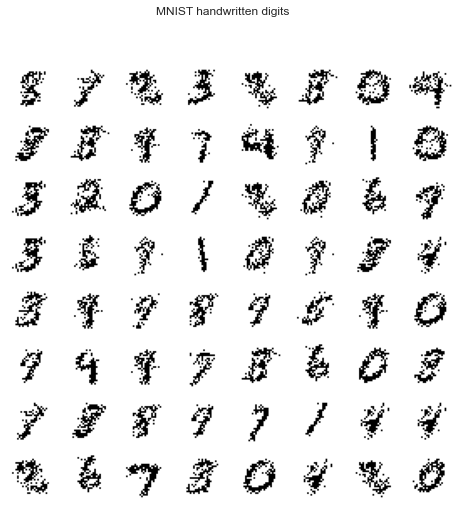

In [39]:
plot_samples(trained_samples,figsize=(8,8))

##### 5.(Report)Evaluate thetrained modelon the test set and report the number.

In [ ]:
# Reproduce the figure from the begining of the notebook, plot the training curves and show latent samples
with torch.no_grad():
  x, y = next(iter(test_loader))
  x = x.to(device)
  loss, diagnostics, outputs = vae.variatonal_inference(x)
  make_vae_plots(vae, x, y, outputs, training_data, validation_data)

### 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [117]:
from sklearn import svm

def discriminativeTraining(vae):
    global z
    global yi
    global zi
    z = []
    yi = []
    
    for x, y in train_loader:
        x = x.to(device)
        
        zi = list(vae.sample(x,z=True).numpy())
        z+= zi
        yi+= y
    
    clf = svm.SVC()
    clf.fit(z, yi) 
    return clf

In [118]:
# train
num_epochs = 5
vae = VariationalAutoencoder(images[0].shape, latent_features)

SVC = discriminativeTraining(vae)

tensor([-1.9164, -2.7247, -2.4053, -2.0817, -1.9864, -2.1100, -1.8732, -2.6272,
        -3.0013, -2.4089, -2.2432, -2.9050, -1.8528, -2.7927, -2.0390, -2.4367,
        -2.2868, -3.9231, -2.0093, -2.6149, -2.4857, -2.2459, -2.9043, -3.0384,
        -2.3956, -3.5987, -3.6115, -2.4157, -2.1677, -2.0563, -4.2153, -2.0084,
        -3.0062, -4.0167, -2.6706, -1.8867, -2.9652, -2.0510, -2.6468, -2.1060,
        -2.1262, -2.0147, -2.2055, -1.9236, -4.4069, -5.2172, -2.0024, -2.7677,
        -2.1663, -2.5615, -1.9672, -5.1283, -2.9483, -2.4325, -2.0087, -2.5484,
        -2.4008, -4.3504, -2.2644, -1.8740, -3.5405, -3.4771, -3.2155, -2.8122],
       grad_fn=<SumBackward1>)
tensor([-1.8977, -2.6604, -2.1882, -1.9525, -1.9636, -2.2631, -2.5286, -2.1569,
        -3.2647, -4.3520, -1.9554, -3.6315, -2.0822, -2.0089, -4.5417, -2.7830,
        -2.0003, -2.2305, -2.1878, -2.7198, -3.5701, -2.4265, -2.4379, -4.2267,
        -3.6363, -3.0425, -1.8850, -2.0774, -2.3562, -4.6122, -4.7790, -2.9131,
        

       grad_fn=<SumBackward1>)
tensor([-5.8442, -2.5697, -2.7357, -2.4257, -2.3913, -2.2819, -2.0351, -3.0650,
        -2.3185, -3.8590, -2.5782, -2.0777, -6.0744, -2.5181, -3.4331, -1.9842,
        -3.8063, -2.8218, -2.8171, -3.0149, -1.9853, -2.2094, -2.1980, -2.3259,
        -2.3572, -2.0185, -3.3896, -2.0448, -1.9652, -2.2582, -4.2816, -3.4548,
        -2.1859, -2.6158, -2.8003, -2.0271, -2.2642, -1.9815, -2.0002, -2.4075,
        -3.7963, -3.3755, -2.4241, -2.2284, -2.3051, -2.2846, -2.2708, -2.9383,
        -2.2613, -2.1470, -2.2277, -2.8708, -2.1751, -3.6576, -3.4566, -3.2720,
        -2.9752, -3.3824, -1.9062, -3.0177, -2.6462, -1.8931, -2.7532, -2.1582],
       grad_fn=<SumBackward1>)
tensor([-1.9439, -1.9297, -1.9922, -3.2814, -2.2678, -4.0078, -2.4627, -2.0983,
        -2.9758, -2.5834, -3.3716, -2.4999, -2.5739, -3.6733, -2.8950, -1.9514,
        -2.2420, -5.4914, -2.1937, -2.8749, -2.4406, -2.4065, -1.9517, -2.3622,
        -3.2029, -2.0946, -3.8281, -2.2624, -2.3501, -1.8

       grad_fn=<SumBackward1>)
tensor([-2.1477, -4.5631, -1.9270, -2.8366, -6.4683, -1.8631, -1.9310, -3.3564,
        -2.2029, -2.8183, -1.9172, -3.4197, -3.9895, -2.2549, -3.5616, -4.1893,
        -2.2945, -2.1004, -3.1160, -2.2146, -4.1696, -2.2031, -7.1868, -3.4590,
        -1.9445, -2.0611, -7.6315, -1.8962, -1.9112, -2.5406, -3.3985, -2.2558,
        -4.4758, -1.8510, -2.0858, -4.3436, -3.4253, -2.2820, -2.3577, -2.0233,
        -4.0204, -3.5923, -2.5494, -2.1138, -2.0812, -2.1273, -2.4233, -1.8432,
        -2.6309, -2.0315, -2.5988, -3.8580, -5.5018, -4.3135, -3.1767, -4.2861,
        -2.8756, -2.5275, -2.2157, -3.3161, -2.0849, -1.9146, -4.0236, -2.8340],
       grad_fn=<SumBackward1>)
tensor([-2.0524, -5.5530, -4.8001, -3.0461, -1.9741, -2.1673, -2.6290, -4.1846,
        -5.9192, -1.9310, -2.8075, -3.4520, -3.3323, -1.9110, -2.8235, -1.9260,
        -1.8813, -3.1769, -1.8994, -2.7639, -2.8342, -2.1031, -1.9718, -2.6089,
        -3.7071, -2.1648, -3.6600, -3.1287, -2.5976, -2.0

       grad_fn=<SumBackward1>)
tensor([-3.5870, -2.7144, -2.5359, -4.3113, -3.2112, -4.9958, -3.1584, -2.7769,
        -4.7644, -2.4003, -1.9123, -4.3567, -2.3830, -2.6496, -2.6831, -2.7516,
        -2.8452, -2.6214, -2.5322, -4.4150, -4.9178, -2.1898, -2.0281, -2.8643,
        -2.5796, -2.8303, -2.8633, -2.9917, -2.3527, -4.5100, -2.1902, -1.9838,
        -1.9825, -2.6782, -3.0394, -2.1600, -4.1629, -1.9844, -1.8778, -2.5808,
        -4.6219, -2.6556, -3.6724, -3.1937, -1.9642, -2.2279, -2.8823, -2.4537,
        -2.4205, -4.1410, -2.2138, -2.1252, -2.5097, -4.1092, -1.9289, -3.3005,
        -2.5891, -3.1813, -1.9500, -2.9623, -3.9751, -3.0465, -3.1753, -2.8720],
       grad_fn=<SumBackward1>)
tensor([-3.9458, -2.5695, -2.0663, -2.8513, -1.9254, -3.5384, -3.0572, -5.7064,
        -3.4050, -6.1788, -2.7756, -2.4833, -6.8385, -1.8541, -2.8046, -3.1816,
        -2.4697, -2.6514, -1.9951, -3.7666, -6.0643, -2.0274, -1.8624, -2.3746,
        -3.6295, -2.1668, -2.0771, -3.3771, -3.4627, -2.0

       grad_fn=<SumBackward1>)
tensor([-4.0374, -2.2763, -3.9965, -5.1230, -1.8948, -6.0699, -3.4257, -3.4867,
        -2.9903, -2.3149, -2.3300, -2.4831, -1.8860, -5.1049, -5.8914, -1.8868,
        -2.1364, -2.1630, -4.4439, -2.7377, -3.5411, -2.2651, -3.0156, -2.7738,
        -3.3419, -1.8666, -3.2251, -2.9591, -1.9834, -2.0471, -2.1623, -2.0298,
        -2.6827, -4.6347, -2.0634, -1.9944, -2.5754, -2.8419, -2.2539, -2.2152,
        -3.6517, -2.0418, -2.0111, -1.8856, -2.7780, -3.3916, -2.0319, -1.8918,
        -1.8590, -1.8566, -2.6531, -3.2982, -2.1185, -2.8659, -9.8614, -2.4998,
        -1.8953, -2.7356, -2.2120, -1.8545, -5.5303, -6.3332, -2.2615, -3.2841],
       grad_fn=<SumBackward1>)
tensor([-2.7985, -7.8524, -2.1347, -3.7627, -6.9465, -2.3524, -3.2564, -4.0904,
        -2.3260, -2.6567, -1.9329, -2.6979, -1.8462, -3.0429, -2.1484, -1.8596,
        -5.9958, -2.0473, -3.3006, -2.1312, -2.5283, -1.8691, -4.9001, -1.8570,
        -2.6141, -2.2115, -3.0086, -3.7177, -3.1615, -2.3

       grad_fn=<SumBackward1>)
tensor([-1.9849, -1.9702, -3.2586, -4.2927, -2.1265, -4.3635, -3.1128, -4.4381,
        -4.2192, -2.1005, -3.0516, -2.2956, -1.8565, -2.4065, -3.4712, -1.9912,
        -2.7754, -2.8745, -2.6718, -3.0620, -1.9712, -2.8212, -6.0909, -2.1083,
        -2.7250, -4.0035, -2.0040, -2.1841, -2.8399, -3.3493, -2.1167, -2.3729,
        -2.0438, -2.3663, -2.3284, -4.1770, -2.5436, -3.5786, -5.0526, -3.4497,
        -3.0319, -4.0356, -2.3218, -2.7819, -2.1408, -2.1694, -1.8706, -2.1453,
        -2.0399, -3.8224, -4.5474, -1.9742, -3.3530, -2.8917, -4.1617, -2.1587,
        -5.0864, -4.2367, -2.8687, -3.0906, -1.9710, -2.5606, -2.9978, -1.9742],
       grad_fn=<SumBackward1>)
tensor([-1.9447, -2.9468, -2.2299, -2.0177, -1.9082, -2.1276, -4.8964, -2.1866,
        -2.5837, -2.6595, -3.8983, -2.6642, -1.9507, -2.3930, -2.2034, -3.0107,
        -3.1945, -3.2219, -3.9638, -6.2945, -2.1221, -2.3956, -5.1832, -1.8513,
        -3.2119, -2.4587, -3.9360, -1.9132, -3.6960, -2.2

       grad_fn=<SumBackward1>)
tensor([-2.5252, -3.8975, -4.2798, -1.9196, -2.9248, -3.1079, -2.1676, -3.6814,
        -2.2114, -2.4145, -7.7336, -5.4047, -2.3309, -1.9485, -1.8903, -1.8803,
        -1.8430, -2.9624, -2.5113, -1.9879, -2.6286, -2.3235, -2.5655, -2.1608,
        -1.8862, -2.0515, -3.0264, -2.0297, -2.1119, -3.3426, -5.3895, -3.4046,
        -3.4871, -3.3410, -2.0743, -2.7935, -2.5825, -1.9857, -2.3128, -2.1564,
        -2.7539, -3.4382, -2.6743, -2.9341, -2.2032, -2.1297, -2.1087, -2.9245,
        -2.6849, -6.0034, -1.8545, -2.2514, -1.9685, -3.2708, -2.2756, -1.9391,
        -3.6309, -3.0989, -3.4246, -1.8960, -2.4520, -2.2257, -2.5076, -2.1172],
       grad_fn=<SumBackward1>)
tensor([-2.0609, -2.2639, -2.1723, -4.4596, -2.0122, -2.0385, -2.4344, -3.9175,
        -2.2397, -3.7254, -2.3298, -2.9916, -2.6222, -3.7916, -1.9196, -2.5499,
        -2.9568, -3.3463, -5.5635, -2.1412, -4.0730, -2.0812, -3.6779, -3.1322,
        -2.4031, -2.4520, -4.2872, -2.4554, -2.3207, -4.9

       grad_fn=<SumBackward1>)
tensor([-3.4026, -2.4491, -2.2372, -1.8896, -5.1261, -2.2322, -2.4176, -2.0270,
        -3.8699, -2.1894, -2.4353, -2.3893, -2.3623, -3.5077, -2.3097, -5.0124,
        -2.1615, -2.4030, -5.3467, -2.1990, -2.1402, -2.2145, -2.0845, -3.5388,
        -2.1172, -2.6541, -3.3679, -1.9386, -2.0936, -1.8623, -3.6524, -1.9373,
        -1.9953, -2.1824, -3.2855, -1.8761, -2.8480, -2.7767, -1.9512, -3.5832,
        -3.6614, -4.9518, -4.9513, -2.0835, -2.3435, -2.2257, -1.9168, -2.7009,
        -2.2300, -2.6384, -3.0656, -3.5148, -3.9160, -1.8559, -2.2024, -2.3404,
        -2.8739, -2.0121, -3.2271, -2.0804, -2.4232, -3.8448, -2.9015, -2.1430],
       grad_fn=<SumBackward1>)
tensor([-5.0034, -2.0287, -3.3508, -3.5761, -1.8772, -1.9953, -2.5671, -2.0424,
        -3.6604, -2.0064, -2.0058, -2.1636, -2.9469, -2.1598, -1.8683, -2.1765,
        -2.1265, -3.3134, -2.1847, -2.3328, -2.6478, -4.3287, -2.8016, -2.0056,
        -1.9209, -1.9718, -3.1370, -2.9532, -2.1783, -2.9

       grad_fn=<SumBackward1>)
tensor([-2.0605, -1.9454, -4.4217, -2.0608, -2.1921, -2.0664, -2.3499, -2.4641,
        -1.8525, -2.5138, -3.3193, -1.8908, -3.7959, -3.9186, -1.8745, -2.8192,
        -1.9431, -3.8065, -2.0700, -2.1804, -2.4936, -2.5877, -1.8794, -2.1410,
        -2.0378, -2.3192, -2.2175, -7.3851, -2.1269, -5.0435, -2.5452, -2.9017,
        -4.4005, -4.4341, -2.0250, -2.9588, -3.7182, -2.7755, -2.0746, -1.9399,
        -4.7720, -3.6312, -2.5957, -2.3481, -2.1116, -1.8446, -2.1920, -3.7823,
        -2.1827, -2.5371, -1.9231, -2.7944, -5.1044, -1.9795, -2.5180, -3.8307,
        -2.2076, -2.4173, -2.7877, -4.1353, -3.8204, -2.0062, -2.2068, -5.1032],
       grad_fn=<SumBackward1>)
tensor([-1.8406, -2.3073, -2.0443, -2.9379, -2.2391, -2.0927, -2.1860, -2.4585,
        -2.2192, -2.3795, -2.1811, -3.3678, -2.3899, -2.0795, -2.4411, -2.3151,
        -2.9589, -2.5323, -3.1929, -2.0996, -1.8997, -3.3530, -2.0224, -2.0877,
        -4.0647, -6.2263, -2.5272, -4.9164, -2.8286, -2.1

       grad_fn=<SumBackward1>)
tensor([-2.1879, -3.5227, -1.9986, -1.9437, -1.8837, -2.5698, -3.0348, -4.7748,
        -3.0407, -2.2022, -2.5702, -2.0554, -3.1668, -1.8612, -2.2791, -2.6516,
        -2.3082, -2.2566, -3.2166, -4.1445, -2.4157, -4.3718, -2.5127, -4.4541,
        -2.2355, -7.0755, -4.5240, -2.3649, -2.3146, -2.9947, -2.5147, -2.1438,
        -2.2183, -2.0331, -3.0059, -2.1108, -3.6848, -3.6388, -2.7966, -2.7856,
        -3.4836, -2.1225, -1.9306, -3.2263, -1.9570, -2.1660, -2.3594, -6.1436,
        -2.8592, -2.8381, -2.8456, -2.5229, -2.0201, -3.0783, -1.8415, -2.1269,
        -5.1068, -2.4927, -4.8309, -2.1856, -2.3137, -4.2593, -4.6207, -3.2981],
       grad_fn=<SumBackward1>)
tensor([-2.0879, -2.4599, -3.6331, -3.4581, -1.8761, -4.6023, -4.4741, -2.0853,
        -2.5879, -2.0039, -6.5215, -2.8774, -4.9612, -2.4305, -2.8637, -2.4527,
        -2.1704, -2.7225, -2.1849, -4.3704, -2.0212, -2.1312, -1.9948, -3.6172,
        -2.2203, -4.4830, -2.3225, -2.4794, -1.8474, -2.5

       grad_fn=<SumBackward1>)
tensor([-2.9908, -6.2527, -2.8661, -3.9054, -3.0602, -2.2437, -2.6810, -1.9654,
        -1.8686, -2.2739, -4.7433, -2.0164, -2.7884, -2.1485, -2.0683, -3.4671,
        -1.9259, -2.0097, -2.8172, -2.2436, -2.5003, -2.2700, -1.9985, -2.7177,
        -3.8532, -3.2548, -2.0161, -2.4081, -3.8922, -2.9449, -5.4956, -4.5019,
        -2.5312, -1.9305, -2.0732, -2.1617, -2.3379, -2.6749, -3.1040, -3.1628,
        -3.5797, -4.6871, -2.9015, -1.9382, -1.9706, -2.9135, -1.9941, -2.7600,
        -3.2470, -2.3172, -2.9061, -4.4201, -3.1793, -2.9153, -2.3760, -2.7258,
        -2.8162, -3.1259, -3.0147, -2.0669, -3.2166, -2.0714, -3.9274, -2.0685],
       grad_fn=<SumBackward1>)
tensor([-3.1604, -2.2092, -2.6303, -3.1180, -4.0355, -2.7535, -1.9156, -2.3116,
        -3.1724, -3.9538, -2.1390, -1.9184, -1.8912, -2.6675, -2.4039, -4.1210,
        -1.8443, -1.9115, -3.5085, -2.1039, -3.1878, -2.8202, -4.1748, -2.4328,
        -2.2774, -2.0420, -2.0023, -2.1475, -2.9208, -2.0

         -1.9146], grad_fn=<SumBackward1>)
tensor([-1.9576, -2.5475, -2.7639, -2.0420, -2.7806, -2.9213, -2.3628, -2.2442,
        -3.3848, -2.0724, -1.8689, -3.4007, -2.7123, -4.8945, -4.0390, -3.1402,
        -1.9472, -2.2334, -2.3606, -3.0308, -3.3626, -3.8009, -3.4380, -2.1294,
        -8.2423, -2.9399, -2.5318, -3.2208, -2.3345, -2.0494, -2.3367, -3.0497,
        -2.0281, -2.0093, -2.3326, -4.1677, -3.2323, -1.8451, -2.4365, -2.0307,
        -2.2760, -3.4002, -3.0745, -2.4051, -2.1114, -1.8984, -2.9533, -1.9116,
        -2.3625, -2.6595, -2.5638, -2.7286, -2.2744, -1.9617, -2.1478, -3.6877,
        -2.8672, -3.1428, -2.6723, -2.8667, -1.8475, -1.8477, -1.9102, -2.7324],
       grad_fn=<SumBackward1>)
tensor([-3.9264, -2.0250, -2.9752, -1.8676, -2.2694, -3.5915, -1.9897, -3.8849,
        -2.3376, -2.0817, -2.0353, -2.0740, -3.8550, -2.3912, -2.3939, -3.3719,
        -2.2059, -3.1071, -2.4132, -2.2105, -3.8408, -6.5422, -5.7026, -7.8194,
        -2.1763, -3.0752, -1.9863, -2.7683, -

       grad_fn=<SumBackward1>)
tensor([-2.4454, -3.5031, -2.4434, -4.6099, -2.2476, -2.3381, -2.3229, -2.2420,
        -1.8470, -2.4129, -3.0065, -1.9573, -3.0949, -1.9918, -1.9608, -1.8805,
        -2.3021, -2.1426, -1.9625, -2.0720, -1.9035, -2.0884, -2.4075, -2.8783,
        -2.3350, -2.7018, -3.7263, -4.3648, -3.1611, -1.9801, -2.2078, -2.6349,
        -7.6010, -2.1406, -2.0140, -2.0292, -2.1208, -2.8750, -2.1751, -3.2125,
        -2.2316, -3.0155, -2.6441, -1.9182, -1.8874, -4.2591, -4.5408, -2.1294,
        -3.0168, -1.9056, -2.2947, -4.2036, -2.0040, -2.3000, -1.9047, -2.0819,
        -1.8592, -2.0367, -2.1757, -2.7411, -4.1275, -2.7513, -2.3029, -1.9409],
       grad_fn=<SumBackward1>)
tensor([-2.7436, -2.0762, -2.6610, -5.5744, -2.3628, -3.1779, -1.8809, -2.2508,
        -3.3118, -2.2045, -3.9181, -2.1083, -2.3835, -2.0754, -2.1368, -2.0634,
        -2.5261, -1.9713, -3.1283, -5.7203, -3.4331, -3.9980, -2.0952, -3.9970,
        -3.3820, -2.4684, -2.8338, -3.9084, -4.5538, -3.0

       grad_fn=<SumBackward1>)
tensor([-3.2627, -1.9372, -3.3366, -1.8986, -4.3534, -1.9443, -3.5641, -2.4717,
        -2.2147, -2.1330, -1.9522, -2.0791, -2.2930, -2.0881, -3.4254, -4.8141,
        -2.6490, -3.3024, -2.6537, -2.9324, -1.9915, -2.0049, -2.0873, -2.8911,
        -4.4525, -2.5470, -2.9445, -1.9664, -2.1487, -4.7395, -4.2016, -2.0840,
        -2.1271, -3.2728, -2.4672, -3.9533, -1.9364, -2.4957, -2.7236, -5.8084,
        -3.5775, -2.5969, -2.1482, -2.1294, -3.3704, -1.9133, -2.7897, -3.0743,
        -4.0033, -2.0483, -2.1915, -2.8168, -4.5984, -2.4252, -1.9773, -2.3146,
        -2.1917, -2.6584, -3.2254, -1.8684, -2.1569, -3.8446, -3.0892, -3.5513],
       grad_fn=<SumBackward1>)
tensor([-3.8291, -2.8409, -2.0520, -2.5261, -2.1433, -3.4571, -2.8925, -1.9894,
        -1.8826, -1.9127, -2.3980, -2.4828, -2.4673, -2.2795, -2.3721, -2.3323,
        -4.5747, -5.0357, -2.4641, -4.8842, -2.5992, -1.9298, -1.8442, -4.3367,
        -1.8501, -1.9848, -1.9513, -1.9591, -3.3851, -2.1

       grad_fn=<SumBackward1>)
tensor([-2.3260, -1.8643, -2.0199, -3.3389, -3.1280, -3.6388, -2.4800, -2.3419,
        -8.3205, -3.7546, -3.0384, -3.7086, -3.7120, -5.1902, -2.1311, -2.2088,
        -3.6141, -3.3283, -2.5680, -2.2952, -4.0801, -3.1061, -2.2582, -2.8473,
        -4.4341, -3.6444, -2.2859, -3.0821, -4.6788, -1.8380, -5.9060, -3.6470,
        -3.5957, -2.2845, -1.8801, -2.9980, -2.5386, -1.8841, -2.9235, -2.3179,
        -3.1170, -2.2196, -2.8158, -1.9624, -3.1452, -1.8610, -4.1207, -3.7043,
        -3.0381, -2.4765, -3.5029, -2.0770, -6.1261, -3.4349, -2.3679, -3.4116,
        -2.0157, -4.2090, -1.9144, -2.0213, -1.9353, -2.1336, -1.9472, -2.0467],
       grad_fn=<SumBackward1>)
tensor([-2.8477, -1.9405, -4.6361, -3.6881, -2.2034, -5.3239, -2.2690, -1.9351,
        -1.8628, -2.3092, -3.8606, -1.8741, -2.3165, -2.4694, -2.7308, -2.0497,
        -2.6824, -1.8391, -4.1953, -2.2363, -2.5056, -2.0352, -1.8401, -2.8723,
        -4.9209, -3.1036, -2.2035, -2.2072, -1.8909, -2.1

       grad_fn=<SumBackward1>)
tensor([-2.2528, -2.6357, -2.0255, -1.8419, -1.9411, -5.0788, -2.9238, -3.3588,
        -4.4421, -2.1322, -3.8479, -2.3604, -2.0096, -5.0584, -3.6010, -3.3924,
        -2.1058, -2.8689, -3.0783, -2.0824, -3.0975, -2.6968, -2.3192, -1.9737,
        -5.0231, -2.3636, -1.8604, -1.9184, -2.8038, -4.0631, -3.6064, -2.4725,
        -1.8733, -2.5397, -2.8901, -2.2087, -3.3269, -4.9979, -2.1860, -2.1059,
        -1.9784, -2.2460, -2.7840, -2.5273, -1.8655, -1.8552, -3.0766, -5.2502,
        -2.8327, -3.1605, -3.5145, -4.3973, -1.9895, -2.6996, -2.2018, -1.9413,
        -2.3941, -2.5128, -2.8703, -2.5738, -2.0046, -1.9465, -1.9920, -2.2357],
       grad_fn=<SumBackward1>)
tensor([-1.8815, -3.4601, -2.9639, -2.0587, -2.1758, -3.0209, -2.0858, -3.3245,
        -2.6483, -2.5242, -2.7829, -2.3522, -1.9723, -2.0591, -2.4253, -2.7666,
        -3.1965, -2.4088, -1.9736, -1.9726, -1.8915, -2.7356, -2.3180, -3.8493,
        -3.5925, -2.4167, -2.9445, -3.0500, -4.2318, -2.6

       grad_fn=<SumBackward1>)
tensor([-1.9680, -2.3691, -2.1060, -2.7636, -3.4413, -1.8926, -4.6606, -2.8112,
        -2.1463, -1.9457, -2.2857, -3.4046, -2.1530, -2.1624, -2.7263, -2.0543,
        -2.8104, -3.0422, -3.0832, -2.2043, -3.6510, -2.1390, -2.0073, -1.8727,
        -1.9490, -5.8117, -2.6850, -3.4214, -1.9033, -2.7497, -2.8696, -2.0638,
        -3.3091, -2.4312, -4.4353, -2.5091, -2.4869, -2.2370, -2.4321, -2.7345,
        -2.0291, -3.3240, -2.6329, -3.1156, -2.2895, -3.2811, -1.9762, -1.8601,
        -2.4217, -1.9438, -3.5570, -1.9758, -2.0684, -2.2912, -2.8035, -2.1254,
        -2.3337, -2.4336, -2.0157, -2.3143, -1.9808, -4.9280, -2.0109, -2.8061],
       grad_fn=<SumBackward1>)
tensor([-5.4982, -3.6537, -1.8415, -2.0474, -4.5207, -2.3707, -1.8552, -3.9857,
        -1.8390, -5.4187, -5.1090, -3.6659, -2.9946, -3.9668, -2.2372, -2.7981,
        -1.9098, -1.8402, -4.3142, -2.8795, -4.7316, -4.3382, -2.0814, -4.4117,
        -1.9220, -4.2783, -2.1662, -2.4600, -4.0920, -1.8

       grad_fn=<SumBackward1>)
tensor([-2.0690, -1.8951, -2.8645, -1.9601, -2.1465, -2.0650, -7.5810, -2.5033,
        -3.0386, -3.1336, -1.9284, -2.8148, -2.3536, -3.1938, -1.9698, -1.9836,
        -2.6893, -1.8868, -1.8586, -8.4735, -1.9221, -3.2032, -2.7340, -2.6844,
        -1.8866, -2.4987, -2.3476, -3.0735, -2.6252, -2.1422, -3.3221, -4.0324,
        -3.1161, -3.2542, -1.8582, -2.4325, -2.3006, -2.3462, -1.8708, -2.0086,
        -2.9469, -1.9905, -2.9747, -2.4496, -1.8924, -1.9082, -2.7758, -3.8308,
        -2.1837, -3.1304, -2.3700, -3.0509, -2.9812, -3.6648, -3.0089, -2.2645,
        -2.1049, -2.9534, -2.1198, -1.9287, -1.9675, -1.9771, -3.0354, -2.0281],
       grad_fn=<SumBackward1>)
tensor([-2.1480, -4.1954, -2.0419, -1.8499, -4.0875, -2.1712, -2.6136, -2.3593,
        -2.0310, -3.3481, -4.8228, -2.2398, -2.0871, -3.7700, -2.7477, -2.2042,
        -1.9622, -2.0326, -2.6240, -3.9919, -2.1247, -3.1052, -4.6715, -2.5825,
        -2.1358, -2.1928, -3.3223, -1.8969, -3.3267, -2.2

       grad_fn=<SumBackward1>)
tensor([-3.0537, -2.7682, -4.5341, -1.8791, -1.8498, -3.9761, -1.8846, -2.3024,
        -2.2830, -1.8896, -2.2674, -2.6225, -4.2569, -2.9155, -2.4996, -3.5069,
        -3.0602, -3.3125, -5.1819, -2.7122, -2.6960, -2.1470, -2.0499, -2.4004,
        -1.9817, -1.9147, -1.8809, -2.3833, -1.9691, -3.3765, -1.9912, -5.4653,
        -3.3273, -2.3706, -2.0054, -2.9052, -2.1511, -1.8451, -3.6651, -1.8499,
        -2.1832, -3.6975, -2.1043, -2.2790, -6.1825, -2.0292, -2.6275, -3.1521,
        -2.3988, -1.8660, -2.8558, -2.1175, -2.5683, -2.2034, -1.8534, -1.9033,
        -2.2143, -2.0635, -3.5148, -3.6417, -3.9874, -2.2416, -2.8921, -2.2432],
       grad_fn=<SumBackward1>)
tensor([-2.8391, -2.5807, -2.2034, -1.8501, -2.0989, -2.7855, -3.7168, -2.6360,
        -3.5166, -3.1080, -2.1195, -2.0571, -2.7585, -3.0359, -2.7596, -2.2527,
        -2.9845, -2.1083, -1.9935, -2.0181, -2.7404, -4.9883, -1.9769, -2.0664,
        -4.9496, -2.0749, -3.0063, -2.0190, -2.4966, -2.5

       grad_fn=<SumBackward1>)
tensor([-2.0571, -2.3341, -1.9179, -1.8643, -3.5863, -1.8414, -3.6484, -3.8462,
        -3.7142, -3.6184, -3.6408, -2.2396, -2.9912, -2.4415, -1.8517, -1.9902,
        -2.0803, -2.2334, -1.8701, -3.1900, -4.2250, -3.9040, -1.8881, -2.0694,
        -2.2796, -2.5329, -3.5725, -3.8308, -2.2650, -2.6171, -3.4871, -4.2312,
        -1.9586, -3.0544, -3.9935, -5.6958, -1.9627, -2.8758, -2.9336, -3.2723,
        -1.9900, -3.4638, -4.8010, -3.2560, -3.9475, -1.8968, -1.9519, -4.3103,
        -3.2598, -3.7304, -2.6911, -4.6374, -2.6368, -2.6452, -4.3040, -3.1817,
        -2.3669, -1.8604, -3.0233, -1.8743, -3.7743, -2.4426, -3.4000, -2.4025],
       grad_fn=<SumBackward1>)
tensor([-4.6022, -2.0169, -3.9136, -2.3165, -1.9218, -2.1569, -3.1044, -1.9606,
        -4.8289, -2.0931, -2.2514, -2.3443, -2.6911, -4.2685, -2.0488, -1.9590,
        -4.5748, -1.9008, -5.0678, -2.2751, -3.2243, -5.0386, -2.0493, -2.0296,
        -5.0025, -2.0533, -2.0793, -2.4867, -3.1428, -2.9

       grad_fn=<SumBackward1>)
tensor([-2.6750, -3.1682, -2.6411, -2.8499, -5.3432, -2.1027, -3.5539, -4.0957,
        -2.3650, -2.0353, -2.5030, -2.0298, -3.4435, -2.4048, -1.8833, -2.2215,
        -2.1867, -2.3033, -3.8232, -2.3641, -2.4412, -2.2653, -2.4637, -3.2426,
        -3.1074, -3.7534, -2.4712, -3.5396, -1.8774, -2.8129, -1.9202, -4.9921,
        -3.3322, -4.8246, -4.7135, -1.8695, -2.6069, -5.2274, -3.1207, -4.4359,
        -2.1268, -2.0371, -1.8952, -2.3049, -2.8901, -1.8456, -2.4590, -6.1035,
        -1.9074, -3.6122, -2.6274, -2.1440, -2.8060, -2.7858, -2.3826, -2.3046,
        -2.9381, -2.5520, -2.0432, -2.1575, -1.8389, -4.2298, -2.1856, -2.5200],
       grad_fn=<SumBackward1>)
tensor([-3.1216, -2.1918, -2.1590, -2.8507, -2.9952, -2.9597, -3.7304, -2.9156,
        -2.6354, -3.5598, -4.1534, -2.4837, -2.2473, -2.1953, -3.8558, -1.9003,
        -4.4702, -3.3179, -3.2724, -4.4227, -5.5814, -4.8203, -3.9561, -2.1843,
        -7.5079, -3.2872, -3.8046, -2.3421, -3.0111, -2.3

       grad_fn=<SumBackward1>)
tensor([-2.2953, -3.4557, -3.5628, -2.0777, -1.8781, -3.0657, -2.4278, -1.9650,
        -4.7005, -2.1928, -4.5578, -2.5008, -2.6472, -2.0247, -3.4241, -2.1952,
        -1.9353, -4.1106, -1.9602, -4.9150, -2.5886, -2.1174, -2.2187, -5.1764,
        -4.9050, -1.8914, -2.4992, -1.9113, -1.9035, -2.5679, -2.9985, -2.0677,
        -2.2252, -3.5235, -2.7042, -2.9938, -2.7663, -2.7795, -1.8673, -3.3381,
        -1.9150, -2.2974, -2.7513, -2.3927, -2.7619, -2.5232, -2.3576, -2.4768,
        -2.7940, -2.2436, -2.3762, -7.0773, -2.1550, -2.8532, -3.3231, -2.0149,
        -2.4246, -3.4629, -3.3687, -1.9386, -1.8484, -2.3472, -5.2623, -2.8022],
       grad_fn=<SumBackward1>)
tensor([-2.9222, -3.2800, -2.7994, -2.1951, -2.0485, -2.3249, -5.5952, -2.3485,
        -1.9495, -3.7552, -2.7826, -4.7842, -2.5341, -2.5092, -2.2018, -6.9374,
        -2.0095, -2.6250, -2.9757, -3.2964, -2.7311, -4.1741, -2.0803, -2.8157,
        -2.3978, -2.6362, -2.2828, -2.3314, -7.5963, -1.8

       grad_fn=<SumBackward1>)
tensor([-2.5671, -2.6401, -2.2951, -2.8152, -2.3156, -1.9101, -2.8600, -1.9098,
        -2.4761, -1.9374, -4.0615, -4.9011, -2.4815, -1.8670, -2.2207, -2.0285,
        -4.9039, -2.3120, -1.8516, -1.9230, -2.9799, -3.6130, -4.1385, -2.9283,
        -2.3835, -2.3698, -3.5953, -2.2839, -3.5490, -2.6110, -4.3824, -2.2592,
        -2.3365, -3.0197, -1.9040, -2.3206, -2.1377, -3.3635, -2.1239, -3.3456,
        -1.8631, -1.8787, -2.0152, -2.5546, -3.5980, -2.9248, -2.7311, -2.6782,
        -1.9573, -2.8480, -1.8406, -2.4178, -3.2963, -3.2034, -2.4429, -2.2494,
        -2.7608, -3.5070, -4.1066, -2.6137, -2.4253, -2.0232, -3.9729, -2.0206],
       grad_fn=<SumBackward1>)
tensor([-5.8940, -2.5459, -2.6784, -1.8669, -2.0931, -2.4161, -2.0557, -2.1293,
        -2.2139, -2.2000, -1.8888, -2.9817, -3.1059, -1.8696, -1.9821, -4.1306,
        -2.3257, -5.5532, -3.5195, -4.0225, -2.6977, -3.8399, -2.0093, -1.8795,
        -2.1665, -2.6163, -3.5927, -2.7138, -2.6522, -2.4

       grad_fn=<SumBackward1>)
tensor([-2.0044, -2.1040, -2.4197, -3.1804, -2.1458, -3.6659, -3.0675, -2.9276,
        -2.8723, -2.2583, -1.9822, -2.8918, -2.0688, -2.1801, -3.8612, -2.0232,
        -2.2661, -2.9815, -3.2876, -2.3953, -1.9848, -2.7438, -2.0133, -3.0034,
        -4.3080, -1.8974, -2.8873, -3.0481, -2.4626, -2.1258, -3.6531, -2.6613,
        -2.2231, -3.6897, -1.9564, -3.0911, -5.3247, -3.1924, -6.3509, -2.9701,
        -2.3738, -2.9055, -1.9038, -1.9339, -2.0831, -3.9041, -1.9704, -3.0849,
        -2.9457, -1.9091, -2.9089, -4.0798, -4.0837, -2.1652, -4.0344, -3.0007,
        -2.8899, -2.2094, -2.7473, -1.9362, -2.2421, -2.2391, -2.1499, -3.2962],
       grad_fn=<SumBackward1>)
tensor([-2.5156, -2.8056, -3.0032, -2.8730, -2.2871, -2.8222, -3.1957, -2.8330,
        -3.3051, -1.9684, -4.2084, -2.0491, -3.4797, -2.0032, -2.4722, -1.9543,
        -2.6924, -2.0612, -1.9074, -2.1451, -2.1088, -1.8877, -2.2880, -3.4431,
        -4.8640, -2.1616, -2.0225, -2.0522, -4.7084, -2.5

       grad_fn=<SumBackward1>)
tensor([-1.8502, -2.2484, -3.7728, -2.8540, -2.7570, -2.4817, -3.9094, -4.8943,
        -2.1394, -1.9738, -2.0717, -3.1188, -3.3108, -6.0372, -1.9831, -2.3795,
        -3.6887, -2.1640, -2.5197, -2.3047, -1.9824, -4.2396, -3.8139, -6.3888,
        -3.5123, -2.2740, -1.8486, -2.3478, -3.0641, -2.9591, -2.3402, -4.1543,
        -2.0677, -2.1293, -3.1574, -2.4037, -2.6952, -2.0314, -2.0393, -2.8145,
        -2.0661, -2.5565, -2.3764, -2.1578, -2.1430, -2.2869, -2.3189, -5.8479,
        -4.3854, -2.3509, -1.8681, -2.2395, -2.4031, -5.3550, -1.9368, -4.3461,
        -2.4994, -1.9020, -3.5450, -2.1545, -4.0750, -4.1123, -1.8671, -3.3516],
       grad_fn=<SumBackward1>)
tensor([-1.8880, -4.2045, -1.9189, -3.5534, -2.2259, -2.0848, -2.4347, -4.8708,
        -2.5172, -2.0086, -2.2761, -3.8135, -3.1162, -2.3768, -1.8580, -2.6299,
        -3.6178, -3.4613, -1.8951, -1.9281, -2.3452, -2.3042, -2.0038, -1.8433,
        -3.7102, -2.0976, -2.6470, -2.2753, -6.7103, -2.0

       grad_fn=<SumBackward1>)
tensor([-2.2082, -2.8460, -2.5444, -2.2739, -2.3477, -2.2377, -1.9146, -2.2655,
        -3.4718, -3.6716, -2.3354, -1.8852, -2.2489, -2.2722, -2.0425, -2.5673,
        -1.8691, -2.7234, -2.5241, -2.5554, -2.5430, -1.9087, -3.4437, -2.3686,
        -2.7182, -3.5413, -4.4277, -3.2589, -9.0469, -4.0590, -2.2919, -3.4033,
        -2.8403, -1.9718, -5.2174, -2.2835, -2.7669, -2.1066, -4.1700, -1.8499,
        -4.6739, -3.7231, -2.9875, -1.9060, -2.7636, -2.0247, -4.0603, -2.6858,
        -3.8450, -2.9501, -3.1072, -3.6513, -3.9540, -3.1156, -2.7984, -2.6950,
        -4.4842, -2.1342, -2.4353, -2.2987, -3.0197, -2.1387, -3.1265, -1.8950],
       grad_fn=<SumBackward1>)
tensor([-2.0418, -3.3951, -2.0980, -3.0967, -2.5193, -2.2507, -2.6319, -2.4844,
        -1.9872, -6.9383, -2.4360, -2.0116, -1.8844, -1.8826, -1.8410, -2.8381,
        -2.4010, -3.6849, -6.8155, -3.7154, -2.1441, -3.0110, -1.9069, -2.1612,
        -3.5234, -2.3306, -2.0563, -1.9362, -2.0539, -3.4

       grad_fn=<SumBackward1>)
tensor([-3.1809, -2.2619, -2.5855, -3.0650, -2.9052, -2.8379, -3.1061, -2.6757,
        -2.5254, -2.3864, -2.5806, -1.9405, -2.4841, -2.8199, -4.4342, -2.6405,
        -2.7103, -2.4908, -3.3770, -3.3358, -4.2068, -3.3882, -2.4431, -1.9368,
        -2.5957, -2.2479, -1.9135, -6.6701, -3.1124, -2.3053, -2.0249, -2.3873,
        -2.7839, -2.7833, -2.2684, -3.3040, -2.5765, -2.3391, -1.8867, -2.7592,
        -2.8326, -3.6629, -2.3410, -7.0443, -1.9931, -1.9303, -1.9050, -2.0117,
        -1.9639, -1.9524, -4.0897, -2.4256, -5.0547, -4.2125, -2.2728, -2.0840,
        -1.9276, -4.0437, -2.3702, -2.0426, -4.8213, -2.3083, -4.9035, -4.4921],
       grad_fn=<SumBackward1>)
tensor([-2.2576, -2.0311, -2.0005, -2.3762, -2.6274, -2.5223, -3.4332, -3.4704,
        -2.3788, -3.1215, -2.2702, -6.1386, -2.6400, -3.6233, -2.5420, -2.3306,
        -3.3081, -2.6036, -2.2542, -4.0935, -1.9633, -1.8683, -5.0746, -1.8968,
        -1.9813, -2.5571, -2.6588, -2.2636, -4.0743, -2.1

       grad_fn=<SumBackward1>)
tensor([-2.7443, -1.8687, -2.4694, -2.8039, -3.8741, -2.8361, -2.3042, -3.1761,
        -2.8441, -3.0275, -2.0595, -2.9003, -3.9285, -3.0165, -2.2497, -4.0605,
        -2.0597, -2.6142, -1.8441, -2.8603, -3.5135, -2.4770, -1.8802, -2.5192,
        -9.9060, -3.7970, -3.4294, -2.1024, -2.2443, -4.9861, -3.0219, -2.4510,
        -2.1053, -1.9365, -3.2267, -4.4501, -3.7226, -2.9518, -7.6265, -2.1393,
        -2.4760, -1.9050, -2.3350, -2.9914, -2.2158, -3.0752, -2.4406, -2.4277,
        -1.9336, -2.9385, -2.2176, -2.1896, -2.6089, -2.8671, -2.9219, -1.9002,
        -2.6164, -2.1531, -2.0076, -2.0689, -1.8875, -2.1567, -1.9503, -2.8289],
       grad_fn=<SumBackward1>)
tensor([-2.1654, -4.2496, -2.7022, -2.3816, -4.1028, -2.0765, -1.9506, -2.5515,
        -2.8383, -2.5269, -2.4112, -6.3566, -4.6905, -2.1042, -2.2744, -2.3106,
        -2.0051, -3.6288, -2.1800, -2.1889, -3.2413, -3.0728, -2.5939, -2.5023,
        -2.3770, -2.9127, -3.6359, -2.1215, -7.0225, -3.2

       grad_fn=<SumBackward1>)
tensor([-2.3817, -2.2993, -4.1128, -2.9858, -2.3522, -1.8507, -2.0366, -1.9375,
        -3.0714, -2.8966, -2.1301, -4.8994, -2.1150, -4.4448, -3.8714, -2.4607,
        -1.8410, -2.2051, -2.2400, -3.8982, -1.9314, -2.1740, -1.8590, -2.1289,
        -2.7526, -2.4214, -2.4901, -2.6422, -1.8600, -2.4493, -2.0008, -1.8569,
        -1.9507, -2.6459, -2.2715, -3.5252, -2.4421, -2.4672, -3.1372, -3.2825,
        -1.8921, -2.0257, -2.2442, -2.0715, -2.9042, -1.9846, -1.8900, -2.4811,
        -2.3173, -1.8424, -2.9795, -2.0082, -2.1519, -2.4901, -2.6322, -2.4010,
        -2.9435, -1.9027, -2.7888, -3.0708, -2.8279, -1.9537, -1.8855, -2.4686],
       grad_fn=<SumBackward1>)
tensor([-2.2493, -2.3264, -3.8746, -2.2453, -3.0409, -2.3699, -2.4129, -4.5584,
        -2.2161, -6.1678, -2.1002, -1.9862, -2.1696, -3.1022, -3.2278, -1.9121,
        -3.2292, -2.2466, -2.9015, -6.3003, -2.1328, -3.9999, -3.2521, -2.3866,
        -7.8923, -2.6059, -1.9308, -2.0211, -2.1052, -2.0

       grad_fn=<SumBackward1>)
tensor([-4.7267, -4.9905, -4.2055, -2.5721, -2.1383, -3.2443, -2.4688, -5.4760,
        -3.4840, -2.0024, -2.4743, -2.8575, -2.4079, -2.6781, -2.0318, -4.0830,
        -5.1015, -2.0253, -4.3994, -3.2339, -3.3719, -2.0047, -2.1337, -2.8282,
        -2.8338, -2.2096, -4.2997, -3.1885, -6.0165, -2.0404, -2.0804, -3.4065,
        -2.5725, -2.4152, -2.9523, -2.5505, -1.9855, -2.5544, -4.4429, -2.0636,
        -2.9360, -1.9959, -3.0008, -5.5543, -2.3304, -2.7000, -2.3109, -2.2246,
        -2.4017, -2.9119, -2.2467, -2.2558, -2.5977, -2.6297, -2.1628, -4.2596,
        -2.5466, -2.4890, -2.2168, -1.9815, -2.3342, -2.0094, -2.3886, -2.5055],
       grad_fn=<SumBackward1>)
tensor([-3.7084, -1.9984, -1.9967, -2.9754, -2.0665, -1.9525, -2.1695, -3.0439,
        -3.6232, -5.9732, -2.7864, -2.0440, -6.1975, -2.7864, -6.1911, -2.1283,
        -3.2880, -1.9706, -2.1416, -2.3590, -1.9731, -3.4649, -2.0505, -2.0982,
        -2.5857, -2.9199, -3.3030, -3.2810, -2.0364, -2.3

       grad_fn=<SumBackward1>)
tensor([-4.9579, -1.9060, -2.0799, -2.7178, -4.1406, -1.9902, -2.6692, -2.7248,
        -3.2971, -3.5118, -2.4058, -2.6417, -3.4173, -2.0482, -4.3201, -1.9731,
        -3.7667, -2.5825, -3.0603, -2.2577, -2.2893, -4.0086, -2.4042, -2.6962,
        -3.0364, -2.4199, -1.8411, -2.0203, -1.9577, -1.8441, -2.8440, -4.9866,
        -2.0846, -5.1800, -2.1443, -2.9621, -2.4055, -3.1082, -1.9911, -3.0539,
        -3.5303, -4.5194, -1.9549, -3.2513, -3.1703, -1.9499, -4.4095, -2.4691,
        -5.4646, -1.9719, -3.5005, -3.2843, -3.3202, -2.3065, -4.6676, -2.6666,
        -1.8775, -2.4084, -2.0001, -2.5032, -2.2838, -2.0392, -2.0222, -1.9721],
       grad_fn=<SumBackward1>)
tensor([-2.1940, -2.4125, -2.3244, -2.7864, -2.6432, -2.6506, -5.1797, -8.2817,
        -3.4628, -2.3394, -2.3492, -2.0446, -3.0257, -2.5129, -2.6789, -5.6083,
        -2.6003, -2.0131, -2.2454, -2.5718, -2.4145, -2.9727, -3.2604, -2.9688,
        -1.8592, -2.4707, -3.5070, -3.6378, -2.5437, -1.9

       grad_fn=<SumBackward1>)
tensor([-1.9608, -4.0994, -3.9517, -2.0893, -3.8987, -2.2937, -2.6501, -2.6906,
        -2.0262, -2.4270, -2.8220, -3.8772, -4.5315, -2.5160, -2.5959, -3.2488,
        -2.3925, -2.4023, -3.0537, -2.5132, -3.1344, -2.2679, -2.9999, -2.4891,
        -2.8189, -2.9946, -2.4662, -1.8842, -3.4396, -4.0918, -2.4280, -2.8844,
        -2.4829, -2.5886, -1.9409, -1.9129, -3.1250, -4.3728, -1.9713, -2.9002,
        -2.4323, -3.5073, -2.2068, -2.0244, -2.8273, -2.5640, -3.0430, -1.8837,
        -3.9816, -3.1290, -4.0165, -2.4572, -1.9280, -2.9654, -2.0307, -2.9140,
        -4.1759, -2.4087, -1.9831, -1.8464, -3.2502, -1.9670, -2.8490, -2.6726],
       grad_fn=<SumBackward1>)
tensor([-2.3635, -2.3650, -5.6204, -2.5216, -2.0603, -2.0613, -3.2767, -1.8430,
        -2.6926, -1.9377, -3.1943, -2.4182, -2.6535, -2.2142, -2.3878, -1.8881,
        -4.8058, -2.0669, -5.5478, -2.1309, -2.9982, -2.7162, -3.1215, -2.6881,
        -1.9696, -2.0615, -2.3478, -1.9731, -2.3951, -4.9

       grad_fn=<SumBackward1>)
tensor([ -2.9684,  -2.3690,  -3.1480,  -5.0624,  -2.6147,  -2.5566,  -1.9627,
         -2.1445,  -2.2862, -11.0538,  -3.1712,  -2.1560,  -1.8384,  -2.1645,
         -1.8722,  -2.5636,  -4.2347,  -2.2403,  -6.1375,  -2.8605,  -2.9056,
         -2.1013,  -2.2460,  -3.7645,  -2.7665,  -2.3222,  -2.0468,  -2.3256,
         -2.3264,  -3.5857,  -1.9713,  -2.2139,  -1.9020,  -2.3027,  -2.5506,
         -2.4055,  -2.0865,  -1.9599,  -2.1469,  -3.8675,  -2.8817,  -1.9338,
         -2.1631,  -3.4261,  -2.1184,  -2.5912,  -2.9745,  -1.9284,  -2.4516,
         -2.6644,  -2.1743,  -6.5939,  -3.5061,  -2.5481,  -2.1498,  -2.0689,
         -2.8951,  -2.4462,  -2.9407,  -1.9666,  -2.9263,  -3.4952,  -2.9625,
         -2.5133], grad_fn=<SumBackward1>)
tensor([-3.8490, -3.1600, -2.5428, -3.5307, -2.0807, -4.0043, -2.6424, -2.4471,
        -1.9765, -2.1314, -2.9792, -2.3894, -3.9243, -2.8093, -1.8818, -2.3251,
        -5.4767, -1.9426, -2.6676, -2.7808, -1.9934, -3.1201, -1

       grad_fn=<SumBackward1>)
tensor([-2.0085, -2.1450, -2.3976, -1.9434, -1.9789, -5.6420, -5.6126, -2.1361,
        -2.8202, -2.0532, -2.4266, -3.1821, -2.6717, -3.3299, -2.4414, -2.0761,
        -5.3425, -2.1636, -2.4193, -2.2341, -1.9403, -3.7863, -2.0799, -3.8430,
        -2.5090, -2.2969, -2.2598, -2.3873, -3.1570, -2.6501, -3.0051, -1.8895,
        -2.8538, -2.3238, -2.3556, -2.5044, -3.2743, -3.3363, -2.6990, -2.2394,
        -1.9527, -4.2747, -2.1464, -1.8449, -2.3999, -2.1491, -1.8889, -2.1806,
        -2.8400, -2.0323, -2.3465, -1.9317, -2.1023, -2.6470, -3.9135, -2.0002,
        -1.9161, -2.1129, -3.0002, -2.6069, -2.4404, -3.9097, -2.3527, -2.4458],
       grad_fn=<SumBackward1>)
tensor([-3.8765, -5.4001, -2.1675, -3.0422, -2.0445, -4.2411, -3.2708, -3.7688,
        -2.5778, -2.0683, -4.3805, -2.1153, -2.3958, -1.9195, -2.8093, -1.8785,
        -1.8390, -1.8903, -2.7537, -2.4612, -2.1539, -2.4377, -2.8893, -2.0889,
        -2.7320, -4.0913, -4.0036, -2.2541, -6.4323, -1.8

       grad_fn=<SumBackward1>)
tensor([-1.9351, -3.4894, -2.4218, -2.3102, -3.9934, -2.0870, -2.5137, -3.2637,
        -2.1355, -2.3541, -2.1070, -3.6901, -2.1774, -2.0345, -2.3582, -4.6521,
        -1.9956, -2.6264, -2.0116, -1.8624, -2.1461, -2.5812, -2.7196, -2.6599,
        -2.8458, -2.1166, -2.5603, -3.9042, -1.9647, -2.3686, -4.7252, -2.6878,
        -2.1271, -4.8348, -2.4409, -2.2652, -2.3855, -1.8914, -4.5515, -2.7956,
        -2.3090, -2.8308, -3.0405, -1.8472, -2.6295, -1.8821, -2.0256, -8.5201,
        -2.0610, -2.0028, -2.5195, -3.1779, -2.1059, -2.5511, -3.6402, -2.7503,
        -4.2612, -4.5639, -4.6578, -3.0993, -4.2919, -3.4667, -3.3250, -2.7023],
       grad_fn=<SumBackward1>)
tensor([ -2.7785, -10.9197,  -2.6346,  -3.8004,  -3.1988,  -2.2075,  -3.4675,
         -2.3008,  -2.6198,  -4.0247,  -1.8783,  -2.8117,  -2.0212,  -2.7784,
         -2.7233,  -1.8853,  -2.0702,  -2.1146,  -2.1821,  -2.0043,  -1.9853,
         -1.9942,  -3.0316,  -3.0756,  -3.3881,  -4.6059,  -3.9

       grad_fn=<SumBackward1>)
tensor([-2.2836, -2.0107, -4.7247, -7.0520, -1.9369, -4.0558, -2.6421, -2.9758,
        -2.2156, -2.2141, -2.5102, -3.1742, -2.9332, -2.4137, -2.0855, -1.8561,
        -3.2424, -2.2805, -2.3935, -3.5407, -2.7352, -2.3867, -3.7123, -1.8559,
        -2.2847, -2.2455, -2.1321, -1.8825, -3.1672, -3.3054, -2.4815, -1.9671,
        -3.6282, -6.9348, -1.8512, -2.3000, -2.6089, -1.9079, -4.8607, -2.6781,
        -2.4585, -3.2380, -2.7938, -1.9184, -2.9068, -2.6278, -3.0691, -3.5487,
        -3.6168, -4.2556, -2.0892, -2.6836, -3.1556, -4.0652, -2.8540, -3.4813,
        -2.0260, -3.7073, -2.3416, -3.1560, -1.8549, -1.9754, -6.1518, -2.8963],
       grad_fn=<SumBackward1>)
tensor([-2.9835, -2.0484, -2.1046, -3.1084, -2.1483, -2.7977, -2.1695, -2.3544,
        -1.8843, -2.1819, -2.0475, -3.9390, -1.9139, -2.5857, -3.1894, -4.4895,
        -2.2515, -2.5244, -3.2983, -1.8727, -3.0803, -4.1504, -3.6127, -3.5901,
        -2.8690, -2.5405, -4.3461, -1.8527, -5.2910, -2.2

       grad_fn=<SumBackward1>)
tensor([-3.6615, -2.6321, -5.9794, -2.9988, -2.6287, -1.8800, -2.4335, -2.0785,
        -3.5284, -2.0759, -2.2370, -5.8503, -2.5120, -2.7837, -1.9694, -2.4189,
        -1.8681, -1.9594, -2.9077, -7.2689, -3.0725, -3.1668, -6.9891, -2.8015,
        -2.9000, -2.0521, -4.2649, -3.8155, -2.7748, -2.1908, -2.0096, -1.8694,
        -2.3380, -2.0732, -2.9380, -3.7200, -2.4654, -2.0012, -2.1942, -1.8843,
        -2.3535, -2.3604, -2.2042, -1.9911, -2.5021, -2.1764, -2.4951, -3.9718,
        -2.6917, -1.9368, -1.9575, -3.4905, -2.0774, -1.9123, -5.3277, -3.3041,
        -3.0991, -3.9473, -2.0483, -2.0589, -6.6196, -2.2585, -2.1050, -2.0857],
       grad_fn=<SumBackward1>)
tensor([-2.2383, -2.3166, -2.0817, -4.9309, -2.0820, -3.4302, -3.7470, -2.0858,
        -2.3816, -6.0462, -2.0930, -1.9909, -2.0181, -3.7433, -1.8838, -2.9983,
        -5.0155, -2.0370, -2.6391, -3.3915, -2.4101, -1.9062, -2.0208, -2.4823,
        -3.3511, -1.9065, -4.3344, -2.5567, -1.9169, -3.8

       grad_fn=<SumBackward1>)
tensor([-3.4967, -4.2861, -2.9412, -1.8845, -2.2644, -2.1834, -3.0516, -1.9269,
        -3.1427, -2.9423, -1.8624, -2.7177, -1.8709, -2.6053, -2.6863, -2.3297,
        -2.2476, -3.9454, -2.5843, -4.0811, -3.7570, -2.5366, -2.8637, -1.8865,
        -1.9080, -1.9974, -4.3218, -2.2071, -3.8507, -4.6234, -3.4416, -3.1360,
        -2.3001, -3.1513, -2.2076, -2.2156, -2.4932, -1.9214, -3.3503, -3.9004,
        -3.0071, -3.1003, -4.2018, -3.1569, -1.9311, -2.1124, -3.1017, -2.0227,
        -2.1742, -3.5074, -2.3501, -2.2034, -3.3387, -2.2580, -2.7804, -6.6580,
        -2.6491, -2.3761, -2.5389, -3.8442, -2.3917, -2.2171, -3.5736, -2.7384],
       grad_fn=<SumBackward1>)
tensor([-2.5186, -2.8996, -2.2766, -2.9120, -2.8604, -2.5107, -3.2024, -5.0794,
        -2.1786, -2.3958, -5.2576, -2.6976, -2.0975, -4.0142, -2.8047, -2.4546,
        -1.9321, -1.8706, -4.5032, -4.0962, -2.5057, -1.9920, -5.6950, -2.1239,
        -2.2520, -2.4985, -1.9114, -4.3682, -2.6908, -2.0

       grad_fn=<SumBackward1>)
tensor([-6.5335, -2.7451, -2.8479, -2.6955, -2.2058, -4.0372, -2.3276, -3.3577,
        -2.3155, -3.4151, -1.8997, -2.4959, -2.7498, -1.9662, -2.5973, -2.1872,
        -3.1650, -2.0588, -2.9653, -1.9652, -2.9302, -2.4118, -1.9470, -7.6645,
        -3.7318, -5.9521, -3.4195, -2.1635, -3.5361, -3.4845, -3.1066, -2.4104,
        -2.5299, -2.5800, -3.2309, -2.7533, -2.2401, -2.4129, -6.5888, -2.7245,
        -2.4902, -1.8466, -2.3486, -2.3346, -1.9703, -1.8951, -2.1121, -1.9777,
        -2.1234, -1.9883, -1.9234, -3.3318, -1.8462, -2.3360, -3.3286, -2.8980,
        -3.5500, -3.1243, -1.8420, -2.4071, -3.0319, -1.8854, -2.5421, -2.5851],
       grad_fn=<SumBackward1>)
tensor([-2.1734, -2.5953, -2.4529, -2.3176, -3.0053, -1.9842, -3.0149, -3.1569,
        -3.0574, -2.3552, -1.9115, -2.2477, -2.2741, -2.6370, -2.2211, -2.8559,
        -1.9636, -4.6929, -2.8561, -2.5118, -2.1833, -2.2124, -6.3990, -2.5280,
        -2.2988, -5.0401, -1.9694, -3.8453, -2.2563, -2.7

       grad_fn=<SumBackward1>)
tensor([ -2.3194,  -4.7598,  -2.0272,  -2.1286,  -2.0024,  -2.5508,  -2.4691,
         -2.0492,  -2.0277, -10.4339,  -2.3752,  -1.9722,  -2.2852,  -2.1015,
         -3.2727,  -2.8980,  -2.0274,  -2.4872,  -1.9439,  -2.4032,  -3.5650,
         -3.5637,  -2.0155,  -4.0186,  -3.2610,  -3.1073,  -4.2123,  -1.9413,
         -1.9584,  -2.1451,  -5.4191,  -6.6684,  -4.5241,  -2.1196,  -5.0973,
         -2.1428,  -2.5590,  -2.2581,  -2.2346,  -5.5962,  -3.0656,  -2.3299,
         -3.4519,  -5.2780,  -1.8569,  -3.8183,  -2.2686,  -3.0961,  -2.0608,
         -2.2628,  -3.7911,  -2.8528,  -3.5354,  -2.5107,  -2.0045,  -3.5871,
         -2.7193,  -1.9393,  -3.2255,  -3.1205,  -2.2269,  -3.7691,  -3.6491,
         -2.9438], grad_fn=<SumBackward1>)
tensor([-2.4530, -2.8466, -1.9554, -2.1667, -3.1439, -3.7515, -1.9199, -3.2601,
        -2.6438, -2.6224, -2.4507, -2.0409, -3.5749, -1.9927, -3.0894, -1.9378,
        -3.7326, -3.9386, -3.6208, -2.1781, -2.0988, -1.9338, -1

       grad_fn=<SumBackward1>)
tensor([-3.2832, -3.1175, -2.2152, -2.4480, -2.2307, -6.8337, -2.2426, -2.8636,
        -2.6797, -3.1542, -3.4065, -2.4797, -2.9297, -3.3805, -4.3293, -3.0461,
        -1.8588, -1.8833, -5.3628, -1.9982, -2.4672, -3.2800, -1.8784, -4.4674,
        -2.5456, -4.8235, -3.1179, -2.8255, -2.1392, -1.8611, -2.1631, -3.7899,
        -3.6871, -2.0050, -2.7241, -1.8485, -2.1263, -1.8418, -2.2060, -2.2742,
        -2.2327, -4.7371, -2.4527, -3.1266, -1.9717, -2.2105, -2.0202, -3.2828,
        -2.4292, -2.2351, -2.0705, -2.6544, -1.9608, -3.4964, -3.3783, -3.4509,
        -4.6848, -1.8816, -2.2493, -2.6366, -2.3926, -2.1898, -2.2017, -2.6457],
       grad_fn=<SumBackward1>)
tensor([-1.9775, -2.2174, -2.4598, -3.6716, -2.9215, -2.2409, -2.5015, -1.9316,
        -2.6761, -2.2277, -2.1403, -2.5905, -3.9902, -2.5366, -2.9951, -2.7940,
        -1.9915, -2.5635, -3.3727, -1.9543, -2.7460, -2.2130, -2.1590, -2.0488,
        -2.6017, -4.6131, -2.2844, -3.0911, -2.3743, -4.6

       grad_fn=<SumBackward1>)
tensor([-3.7298, -5.3496, -2.4566, -3.0005, -2.5129, -5.1917, -5.8287, -2.1418,
        -3.4148, -3.3900, -1.9211, -3.0222, -1.9653, -2.8600, -2.1309, -2.7115,
        -2.4129, -2.3483, -3.9927, -3.4219, -2.7029, -5.2244, -2.3903, -1.8575,
        -3.1758, -1.9720, -2.1717, -2.0661, -3.3498, -1.9200, -2.0251, -2.1547,
        -1.8758, -2.0666, -5.0911, -2.3403, -3.9847, -2.2251, -3.0482, -2.1249,
        -1.9915, -2.5468, -4.1411, -3.5388, -2.5359, -2.4953, -2.6125, -2.9285,
        -2.1012, -2.1715, -3.6277, -3.7039, -2.8962, -1.8561, -1.9068, -1.9465,
        -2.9845, -2.7747, -2.4941, -4.4535, -2.6226, -2.0334, -4.0850, -2.1266],
       grad_fn=<SumBackward1>)
tensor([-2.1565, -5.0855, -2.1914, -2.7929, -4.0055, -2.2451, -2.7312, -3.7282,
        -4.0039, -3.2731, -2.4189, -2.1358, -3.7064, -2.4795, -5.0512, -2.1471,
        -2.9949, -6.0381, -2.1971, -2.6337, -2.8154, -2.3108, -2.3798, -1.9926,
        -2.1340, -2.3808, -2.0426, -2.1595, -3.6656, -2.1

       grad_fn=<SumBackward1>)
tensor([-3.3400, -3.2990, -3.0564, -3.8948, -3.4698, -4.7797, -2.4359, -2.0777,
        -2.1050, -2.1067, -1.9508, -2.6496, -4.2629, -2.7758, -2.8553, -2.0660,
        -5.3297, -7.1338, -3.3118, -2.7524, -3.0036, -2.4450, -5.3240, -2.5804,
        -2.5261, -2.1937, -1.9211, -3.3203, -2.1747, -2.6588, -3.0025, -2.8264,
        -2.1199, -4.6808, -3.4088, -2.3302, -2.8878, -3.4343, -3.4209, -3.8727,
        -2.2612, -2.2890, -3.2999, -4.2119, -2.2342, -3.2082, -2.0713, -1.9288,
        -2.1821, -2.4655, -2.4058, -2.7640, -4.1635, -2.0807, -2.7550, -2.4142,
        -2.0828, -2.1435, -1.9600, -3.7613, -4.7179, -2.4202, -1.9919, -2.7656],
       grad_fn=<SumBackward1>)
tensor([-2.1470, -3.4266, -2.6127, -6.8838, -2.9101, -4.2107, -3.7986, -4.2673,
        -2.5486, -2.0867, -2.9660, -3.6425, -2.1316, -1.9301, -3.2946, -1.9806,
        -2.5178, -2.5976, -2.4000, -2.3332, -2.0292, -5.1945, -2.3602, -2.2103,
        -2.6951, -3.4392, -1.9584, -2.5719, -1.8413, -3.3

       grad_fn=<SumBackward1>)
tensor([-2.6670, -2.0028, -3.4535, -3.2518, -1.9159, -2.2799, -4.6691, -2.8209,
        -4.2439, -1.8586, -1.9943, -2.5329, -4.0896, -2.3941, -2.6144, -2.4277,
        -3.6058, -2.1619, -2.0916, -3.0582, -2.7029, -1.8594, -2.1394, -2.3606,
        -6.1005, -1.9837, -4.3037, -3.2698, -2.4061, -2.5776, -2.1854, -2.0093,
        -3.2175, -1.8625, -3.7151, -1.8939, -2.6843, -5.2085, -4.3065, -1.8928,
        -2.6707, -2.9312, -1.8451, -1.9415, -6.3396, -2.2526, -2.6076, -2.4700,
        -1.8646, -2.4143, -3.4375, -2.2532, -1.8837, -2.0322, -2.3860, -1.8395,
        -2.9230, -1.9410, -6.3267, -2.6767, -1.9421, -2.7172, -3.6535, -1.8624],
       grad_fn=<SumBackward1>)
tensor([-2.0256, -2.5696, -3.2333, -2.2724, -1.8498, -2.5939, -2.7346, -2.1544,
        -4.0094, -2.1778, -2.4509, -2.1784, -3.2088, -2.4151, -2.0228, -2.7336,
        -2.3478, -2.2158, -2.3389, -2.4252, -1.8503, -1.8426, -2.3417, -3.3649,
        -3.9010, -1.9163, -3.0413, -1.8935, -3.3831, -2.3

       grad_fn=<SumBackward1>)
tensor([-2.5773, -2.4338, -5.1045, -2.1939, -2.5053, -5.3947, -2.3358, -3.1433,
        -3.7547, -3.4849, -2.9346, -2.6804, -2.7862, -2.4035, -3.4596, -2.0375,
        -2.0648, -2.2662, -2.3405, -2.1952, -7.0361, -2.2453, -4.6922, -1.9052,
        -2.9841, -3.3511, -3.5042, -4.1262, -2.3527, -1.9792, -2.3258, -2.3228,
        -1.8460, -3.2253, -3.0447, -2.5640, -3.0502, -2.1452, -1.8504, -2.7327,
        -3.4899, -3.2975, -2.5119, -5.5352, -2.5316, -2.1005, -2.3630, -4.5086,
        -3.2909, -2.1070, -2.0957, -3.5340, -2.7026, -2.5545, -2.1483, -2.3286,
        -1.9649, -3.3660, -4.6009, -2.6769, -2.3799, -2.0700, -4.4144, -2.2512],
       grad_fn=<SumBackward1>)
tensor([-2.3267, -2.7288, -1.9934, -2.3808, -3.6707, -2.2832, -2.0558, -3.3426,
        -5.6307, -2.3209, -2.8846, -2.0803, -3.8850, -3.3867, -2.2361, -1.9089,
        -7.0992, -2.0818, -2.2931, -2.8086, -3.1913, -2.7028, -6.3129, -2.2356,
        -2.0810, -2.4277, -3.0328, -1.9243, -2.6167, -2.1

       grad_fn=<SumBackward1>)
tensor([-3.0860, -2.1673, -2.1855, -2.4381, -2.3945, -8.3071, -2.9280, -2.3928,
        -2.2448, -2.5398, -2.5578, -2.2150, -2.6754, -2.2316, -3.6110, -2.0281,
        -2.7433, -4.8070, -3.0331, -2.5315, -3.0728, -3.4298, -4.4427, -4.8318,
        -4.1595, -1.9360, -2.2337, -1.9921, -2.2774, -2.4574, -2.1681, -3.0763,
        -5.3662, -4.2339, -2.6967, -3.6326, -3.1055, -2.9830, -2.9287, -2.8638,
        -2.0340, -3.3399, -2.9685, -2.9555, -2.4669, -3.4239, -4.2034, -3.1149,
        -2.8630, -4.9121, -3.4649, -1.9528, -3.3387, -2.5158, -3.7670, -1.9515,
        -2.0750, -2.4956, -4.2056, -5.0208, -2.8842, -2.3140, -3.3032, -3.5427],
       grad_fn=<SumBackward1>)
tensor([-2.8554, -3.5566, -4.1879, -2.1667, -2.6809, -3.3095, -2.3792, -2.3475,
        -2.7836, -2.3558, -1.9046, -2.7993, -5.5249, -6.0449, -2.2611, -1.9966,
        -1.9208, -6.0434, -2.2953, -2.3438, -3.2114, -3.7996, -2.7513, -3.1352,
        -3.1711, -4.5776, -1.8644, -3.2724, -1.9309, -5.0

       grad_fn=<SumBackward1>)
tensor([-2.2612, -3.3254, -1.9021, -2.3716, -1.8398, -2.3836, -2.3966, -3.1431,
        -2.0549, -5.1643, -2.6168, -2.2417, -1.9233, -2.5000, -3.8147, -3.3161,
        -2.9398, -2.4314, -3.7891, -2.0171, -2.1833, -1.9622, -3.0996, -2.2666,
        -4.0850, -2.0107, -2.8101, -1.8672, -2.7205, -2.5895, -2.2007, -2.1812,
        -2.4618, -2.6334, -2.7525, -4.1311, -4.9634, -2.3795, -1.9362, -3.4914,
        -2.2827, -1.9380, -2.4988, -2.6051, -2.0892, -2.5574, -1.8392, -2.7125,
        -5.0484, -3.3922, -3.7628, -2.6494, -2.0053, -2.8725, -3.2288, -2.3074,
        -3.7658, -4.1154, -2.3044, -2.6208, -4.0564, -2.8565, -2.3637, -2.0818],
       grad_fn=<SumBackward1>)
tensor([-2.1995, -4.2706, -2.1072, -2.4965, -2.1407, -2.2491, -2.0191, -5.5491,
        -3.3981, -2.6941, -3.0062, -1.9336, -3.0229, -2.6145, -2.0979, -3.0060,
        -2.1820, -1.9395, -1.8835, -1.9757, -2.2184, -3.3370, -3.6085, -2.0514,
        -2.2802, -2.1314, -2.3150, -2.5987, -1.9205, -2.8

       grad_fn=<SumBackward1>)
tensor([-2.0004, -2.7035, -2.4051, -2.0809, -2.0165, -2.4208, -3.2221, -2.2973,
        -3.9956, -2.1838, -2.5331, -1.8390, -2.3122, -2.7123, -2.6495, -3.8789,
        -1.9941, -1.9553, -1.9883, -5.4756, -2.8984, -4.2397, -2.1485, -2.8636,
        -1.9469, -2.4022, -4.1900, -1.8633, -3.4231, -2.0400, -7.2547, -1.8419,
        -3.3845, -3.4657, -3.7989, -3.3522, -2.9846, -5.1849, -3.9395, -2.5220,
        -2.7335, -2.2249, -1.8498, -2.0378, -2.1996, -3.0086, -1.9179, -4.6575,
        -1.9207, -2.6847, -4.3901, -3.8807, -2.1859, -2.6229, -2.5301, -2.1170,
        -3.2610, -5.1028, -1.9202, -2.2465, -2.0186, -1.8661, -3.1399, -1.9578],
       grad_fn=<SumBackward1>)
tensor([-3.6087, -2.4457, -2.1142, -4.7346, -3.0451, -2.0281, -4.1319, -2.7234,
        -2.1150, -4.1700, -2.8691, -3.4715, -4.3760, -2.5758, -2.1811, -1.8593,
        -1.8599, -6.9841, -3.2158, -4.7315, -1.8767, -2.2650, -2.0920, -2.1861,
        -3.1506, -2.1728, -2.4302, -2.0380, -2.1890, -2.1

       grad_fn=<SumBackward1>)
tensor([-1.8469, -2.3325, -2.0648, -2.5073, -2.0416, -1.9484, -2.1415, -2.3986,
        -3.2251, -3.2094, -2.1585, -2.6938, -2.8548, -2.3485, -1.9834, -3.0683,
        -4.1397, -2.3011, -3.2149, -2.2498, -2.5461, -2.5060, -1.9947, -3.0312,
        -2.0483, -5.1874, -5.3447, -3.0433, -3.7068, -2.6143, -5.2409, -3.9209,
        -2.7201, -1.9913, -2.5366, -1.8927, -5.5864, -2.0298, -2.4661, -2.7108,
        -3.0881, -4.5171, -5.3193, -6.2287, -2.0741, -3.1795, -3.7163, -1.9934,
        -2.1545, -2.0075, -2.6045, -2.1858, -2.4894, -2.6213, -2.1104, -2.3644,
        -2.8409, -2.2668, -3.1741, -2.0295, -3.3126, -2.1638, -2.4060, -2.1342],
       grad_fn=<SumBackward1>)
tensor([-3.1416, -1.8642, -2.6959, -1.9129, -2.8514, -3.8682, -3.4245, -2.2663,
        -2.4101, -7.6358, -1.8645, -2.5955, -3.1951, -1.9441, -2.3823, -2.4019,
        -2.0147, -1.9698, -5.4820, -2.3257, -2.1384, -5.2572, -3.4442, -3.5397,
        -3.6231, -3.3955, -5.2839, -2.2030, -2.9611, -2.1

       grad_fn=<SumBackward1>)
tensor([-3.9149, -2.1994, -2.9119, -2.3499, -2.1783, -2.2004, -2.0952, -2.6835,
        -4.1489, -4.1932, -1.9335, -2.3903, -2.0346, -2.5633, -2.0528, -2.6153,
        -6.1379, -2.2027, -1.8545, -2.1825, -1.8679, -3.9345, -1.9680, -3.7930,
        -3.9315, -4.2537, -2.7910, -3.5633, -2.8558, -2.8589, -3.2250, -2.1000,
        -5.0804, -2.0966, -6.2673, -3.1174, -2.1494, -2.6007, -2.5577, -2.3204,
        -2.2060, -2.0085, -3.9784, -5.1379, -1.9393, -4.2159, -3.6914, -3.9847,
        -4.0925, -3.9125, -5.1514, -3.0719, -2.2315, -2.2577, -1.9787, -4.0452,
        -3.6339, -2.9783, -4.1948, -2.2035, -3.0458, -4.0040, -2.1672, -1.9923],
       grad_fn=<SumBackward1>)
tensor([-1.8691, -4.7661, -2.0682, -2.2409, -3.3255, -1.9801, -2.1602, -2.1932,
        -1.8395, -1.8607, -1.9113, -5.4248, -3.6763, -3.7260, -1.9210, -4.1675,
        -2.6116, -3.0220, -2.7984, -2.1378, -2.2303, -2.6153, -2.0866, -1.9234,
        -3.6191, -3.3927, -2.0690, -2.1513, -4.6058, -2.3

       grad_fn=<SumBackward1>)
tensor([-2.6104, -5.0061, -2.7155, -2.3469, -3.0885, -3.8160, -3.1096, -3.8293,
        -2.4663, -2.2458, -1.8934, -2.0779, -2.9564, -2.1147, -3.2712, -2.5497,
        -1.9268, -2.1264, -3.4651, -4.7364, -2.3643, -5.0339, -2.9104, -1.8748,
        -2.3496, -5.5736, -1.9903, -1.8743, -2.8555, -2.3064, -3.9199, -3.6019,
        -2.5973, -2.4608, -2.0519, -1.9461, -1.9235, -5.5138, -2.1780, -4.2558,
        -5.4875, -2.6601, -1.9227, -1.9178, -2.1762, -2.5329, -3.7044, -3.0854,
        -2.4018, -2.2154, -6.7875, -1.9119, -2.9007, -1.8891, -4.4716, -3.1449,
        -3.0252, -5.0400, -1.9524, -1.8598, -3.1403, -2.5828, -2.1897, -2.2273],
       grad_fn=<SumBackward1>)
tensor([-1.8971, -2.4614, -2.7969, -3.8013, -2.0481, -2.5190, -6.7916, -1.9589,
        -1.9257, -1.9766, -2.7538, -4.4011, -6.2974, -2.3415, -3.3558, -2.0072,
        -4.6590, -4.9594, -2.1893, -2.3356, -2.5721, -1.9123, -2.9242, -2.7232,
        -3.7696, -2.0799, -3.8636, -2.0707, -3.0050, -3.4

       grad_fn=<SumBackward1>)
tensor([-3.9669, -2.2448, -2.1726, -2.8782, -4.1591, -3.5123, -2.1631, -2.2232,
        -2.2728, -2.4327, -1.9085, -4.7388, -1.9252, -4.2646, -2.1626, -2.2687,
        -1.9609, -3.0225, -2.2032, -2.2421, -2.1549, -2.8707, -1.8710, -2.2332,
        -2.7453, -3.2348, -2.1890, -2.5588, -2.2073, -3.1615, -1.9658, -3.7885,
        -1.9461, -3.6023, -1.8610, -2.4529, -4.0184, -2.5184, -3.4253, -1.9490,
        -6.4704, -2.3760, -2.1420, -2.1073, -3.8799, -2.9360, -1.9247, -3.3623,
        -2.6441, -1.9982, -1.8561, -2.0540, -2.7997, -2.0334, -3.6311, -1.9603,
        -1.9123, -2.0014, -5.3085, -2.1553, -2.3991, -2.4508, -1.9396, -1.9361],
       grad_fn=<SumBackward1>)
tensor([-2.1464, -2.2014, -2.0908, -2.6859, -2.1804, -2.4566, -2.4327, -2.3096,
        -2.1931, -2.1164, -2.0984, -2.7605, -2.4049, -2.8316, -5.0114, -5.6452,
        -1.9851, -3.1396, -3.6832, -2.5541, -3.2782, -2.8664, -2.3546, -2.4579,
        -3.8849, -3.1966, -2.8703, -2.4841, -2.1448, -4.9

       grad_fn=<SumBackward1>)
tensor([-2.5473, -2.2089, -1.8875, -2.2019, -3.2872, -2.5460, -3.0037, -2.6539,
        -2.3124, -3.5001, -2.1601, -2.0242, -2.7586, -2.7652, -3.0237, -2.3759,
        -1.9488, -5.4760, -2.3214, -2.1532, -2.0128, -2.1422, -2.3362, -2.5665,
        -2.7467, -4.2058, -2.2526, -3.1488, -2.1243, -2.3111, -5.1232, -2.7749,
        -1.9987, -2.1022, -1.9252, -3.1434, -2.1042, -3.2276, -2.6175, -2.3180,
        -4.6194, -2.1340, -1.8488, -1.9637, -1.9292, -2.4032, -2.9799, -2.3778,
        -1.8441, -2.0007, -1.9528, -2.7151, -2.3997, -1.9064, -2.6160, -2.6854,
        -2.1423, -2.0990, -5.3383, -2.8775, -2.3277, -2.0050, -2.5155, -2.5578],
       grad_fn=<SumBackward1>)
tensor([-2.0570, -2.2345, -4.7322, -3.6382, -1.8992, -2.3567, -2.1700, -2.8965,
        -3.3489, -2.2987, -2.9668, -6.6501, -2.0252, -2.2397, -2.6996, -2.8849,
        -5.1764, -1.9511, -5.1894, -2.2539, -2.1777, -1.8460, -2.1156, -4.0500,
        -2.6429, -2.0055, -2.1877, -2.8554, -1.9021, -3.3

       grad_fn=<SumBackward1>)
tensor([-2.2460, -3.3140, -2.2929, -2.7966, -2.3883, -2.2733, -1.8653, -1.9533,
        -5.4136, -2.7400, -2.2173, -3.9278, -2.6630, -2.9986, -4.2746, -2.3837,
        -2.4666, -2.1022, -2.0190, -2.4993, -2.4807, -5.4564, -1.9802, -2.1456,
        -2.3596, -3.6437, -2.7583, -3.5246, -2.9351, -1.9830, -2.5081, -3.1019,
        -2.2626, -3.4151, -2.1058, -2.3387, -2.0873, -3.3885, -3.4408, -1.9467,
        -3.0933, -2.4615, -2.5489, -2.3730, -1.9577, -3.1128, -2.1986, -2.6764,
        -2.9630, -2.5736, -3.7514, -2.3167, -3.6756, -2.2551, -3.2859, -4.4754,
        -2.6332, -2.0209, -2.4041, -3.3378, -3.2156, -2.0707, -2.1480, -5.4733],
       grad_fn=<SumBackward1>)
tensor([-3.7858, -3.8434, -4.9153, -1.8948, -2.0122, -3.5211, -1.9538, -2.1399,
        -1.9002, -1.9146, -3.5165, -1.8708, -3.1828, -3.7777, -4.2127, -1.8672,
        -2.0853, -2.3506, -2.1959, -2.3455, -2.5754, -2.1038, -4.9099, -2.8159,
        -2.5231, -1.8558, -2.1933, -1.8794, -2.2999, -4.4

       grad_fn=<SumBackward1>)
tensor([-4.4695, -3.3637, -2.9289, -3.5906, -2.5367, -2.0926, -3.3036, -3.5310,
        -2.1053, -2.5546, -1.9131, -2.5718, -2.0256, -5.0678, -2.0430, -2.1753,
        -2.0747, -2.7757, -4.1719, -2.8267, -2.5779, -3.7317, -2.1787, -3.1309,
        -1.9656, -2.1792, -3.0169, -2.7128, -2.2009, -1.9118, -2.0500, -2.0864,
        -2.1658, -2.4896, -1.9285, -2.0134, -2.4858, -2.4858, -3.5489, -2.7054,
        -1.9553, -3.5391, -2.0874, -2.9799, -2.5997, -2.3650, -3.0619, -2.4358,
        -2.3163, -1.9927, -2.4223, -2.4277, -2.2564, -2.5425, -2.6789, -2.1267,
        -1.8785, -3.1178, -2.6558, -4.9256, -5.6074, -2.5320, -2.6114, -3.2562],
       grad_fn=<SumBackward1>)
tensor([-5.0720, -2.1517, -5.1975, -3.3359, -2.3456, -2.0819, -3.7459, -2.3013,
        -2.4680, -4.6136, -2.9378, -1.9335, -2.5447, -2.7904, -3.8977, -2.6042,
        -2.0142, -2.2954, -2.9430, -2.5218, -2.1900, -1.9860, -1.9387, -2.1632,
        -2.0105, -3.5290, -5.6249, -2.9952, -3.1719, -2.1

       grad_fn=<SumBackward1>)
tensor([-2.2011, -2.9036, -3.9486, -2.5945, -3.4851, -2.3566, -2.7806, -2.1171,
        -2.2276, -4.2892, -3.7059, -2.5254, -1.8758, -3.7074, -4.2420, -2.0940,
        -1.8731, -2.8350, -2.1350, -2.0169, -1.8987, -1.9298, -1.9463, -2.2822,
        -4.1987, -4.2715, -4.2466, -2.7370, -3.4900, -1.9324, -1.9584, -2.9842,
        -2.2577, -4.5975, -4.7699, -1.8593, -1.9472, -3.2368, -4.4048, -3.2294,
        -8.1938, -2.4755, -1.9666, -2.1472, -3.7428, -4.9520, -4.2861, -4.4465,
        -1.8583, -2.2214, -1.8647, -2.4494, -1.9346, -1.8923, -2.9975, -1.8858,
        -5.6219, -1.9693, -2.3195, -2.2509, -1.9556, -4.5961, -3.2943, -2.5135],
       grad_fn=<SumBackward1>)
tensor([-2.3690, -3.5133, -3.7795, -2.6164, -1.9368, -2.1043, -2.7043, -2.5082,
        -5.4972, -1.8380, -2.6128, -3.8657, -4.6837, -1.8535, -2.2772, -2.1463,
        -2.2199, -2.0054, -3.8178, -4.6620, -3.5203, -2.2380, -3.6030, -2.3560,
        -1.9105, -2.4217, -1.8615, -2.5508, -5.6765, -2.3

       grad_fn=<SumBackward1>)
tensor([-4.1610, -2.0567, -4.3244, -2.5293, -2.4610, -2.5568, -2.8326, -2.1245,
        -2.9135, -3.7530, -2.5932, -2.6772, -3.4177, -2.3645, -3.8804, -2.2891,
        -2.1182, -3.4358, -1.9193, -3.2012, -3.6683, -2.1666, -2.7831, -2.4426,
        -3.1020, -1.9222, -2.6551, -2.3836, -5.9987, -2.2547, -3.4790, -3.5119,
        -2.5979, -2.6163, -3.2968, -1.8786, -8.9858, -2.6405, -3.4621, -2.1439,
        -3.0770, -4.3495, -2.6706, -4.1437, -3.2751, -2.0421, -2.4439, -1.8600,
        -2.8564, -1.9687, -2.0091, -2.8205, -3.1873, -3.2730, -2.9133, -2.6878,
        -2.1505, -2.6961, -4.0911, -2.2467, -2.1722, -1.9171, -2.5078, -4.2895],
       grad_fn=<SumBackward1>)
tensor([-3.9978, -2.1895, -2.1784, -3.8568, -5.0628, -3.5985, -3.6930, -2.1806,
        -5.8802, -2.0198, -3.4374, -2.1098, -2.1094, -1.9469, -2.5334, -3.1673,
        -2.7294, -5.9465, -2.2360, -2.0594, -6.2972, -6.0587, -2.1732, -3.0448,
        -3.0257, -2.7487, -1.9241, -2.0507, -2.2936, -4.5

       grad_fn=<SumBackward1>)
tensor([-2.9391, -2.5635, -1.9022, -2.7358, -3.1989, -2.4355, -1.9968, -3.5767,
        -2.0458, -2.0982, -3.9733, -2.9771, -2.1273, -9.1899, -2.6594, -4.4998,
        -4.7301, -2.6899, -1.8731, -3.5802, -2.0185, -5.6721, -5.0197, -3.0973,
        -1.8440, -1.9792, -2.2662, -2.4997, -2.2607, -2.2039, -3.2385, -3.0207,
        -2.9983, -2.7965, -2.4403, -2.4765, -3.7967, -2.5034, -2.2546, -2.3905,
        -2.4327, -2.3599, -3.0552, -2.0804, -1.8920, -2.9977, -2.1081, -2.4222,
        -2.9668, -3.5821, -2.4054, -1.9287, -2.5068, -1.9564, -3.9770, -2.0854,
        -2.6769, -1.9202, -5.5050, -2.2522, -4.5092, -2.6366, -3.6461, -3.2217],
       grad_fn=<SumBackward1>)
tensor([-1.8949, -2.1748, -2.5544, -2.6447, -1.8754, -2.4875, -2.3749, -3.3559,
        -2.2893, -2.3642, -2.0466, -1.9145, -2.4611, -2.2401, -2.2531, -2.8222,
        -2.5550, -2.7414, -1.9977, -3.3169, -2.0581, -1.9155, -2.6428, -2.0433,
        -1.9972, -2.9524, -3.4968, -3.0799, -1.9388, -2.3

       grad_fn=<SumBackward1>)
tensor([-2.0033, -2.2611, -3.5357, -2.0076, -2.1674, -3.2517, -2.8027, -1.9707,
        -4.5304, -2.3565, -1.9148, -2.4474, -3.2441, -3.1202, -2.2672, -2.4112,
        -1.9593, -2.4453, -3.4049, -2.5617, -2.6389, -3.5474, -1.8619, -2.8228,
        -3.3732, -3.3727, -3.6924, -3.8939, -2.3243, -2.1359, -2.2743, -2.9011,
        -2.5867, -3.5491, -1.8925, -3.3408, -2.4882, -1.8606, -4.4844, -3.5925,
        -3.0850, -2.3323, -2.7831, -4.9619, -2.2380, -2.2408, -3.2162, -4.3057,
        -6.4829, -2.2835, -4.1040, -5.0169, -2.7741, -1.9439, -1.9927, -2.6348,
        -2.7341, -2.1718, -2.4842, -2.2977, -2.5817, -2.0140, -2.0868, -2.0510],
       grad_fn=<SumBackward1>)
tensor([-2.7394, -2.2441, -2.8526, -2.2436, -3.0034, -3.1172, -2.9341, -7.0506,
        -3.3742, -3.1255, -2.5437, -2.2484, -2.0392, -2.9464, -2.0986, -2.4724,
        -2.2122, -3.0372, -1.8736, -2.4667, -4.4645, -2.7057, -6.5927, -2.3449,
        -2.2156, -4.3463, -2.5681, -2.4464, -5.0997, -3.3

       grad_fn=<SumBackward1>)
tensor([-2.3290, -2.7347, -3.2294, -2.9782, -2.8236, -2.0200, -1.8840, -2.6414,
        -1.8866, -2.1109, -2.0871, -2.0127, -1.8439, -1.9834, -1.9177, -1.8977,
        -3.6338, -2.9552, -2.1287, -4.4064, -4.7516, -2.3611, -2.2633, -3.2090,
        -2.9965, -2.0173, -3.3377, -1.9656, -2.6149, -3.0045, -2.2527, -6.4292,
        -2.3751, -2.5398, -2.2779, -2.3219, -2.8193, -2.2437, -2.5997, -2.3667,
        -1.9445, -2.8406, -4.1006, -1.9041, -2.5210, -1.9807, -2.0886, -1.8611,
        -2.5475, -2.6407, -3.3632, -3.0858, -3.3649, -2.3403, -2.1424, -2.6073,
        -1.8917, -2.1927, -2.5644, -2.0421, -5.6436, -2.2375, -3.3518, -3.1379],
       grad_fn=<SumBackward1>)
tensor([-5.5672, -2.4048, -3.3570, -2.3847, -1.9642, -2.1446, -2.6778, -2.0364,
        -4.4624, -1.9557, -3.6961, -3.6464, -2.3460, -2.0926, -3.7402, -4.2677,
        -1.8780, -2.2980, -4.7826, -2.2986, -3.5915, -2.7115, -3.3451, -2.5440,
        -2.4308, -4.2204, -3.4115, -4.3596, -2.3831, -2.8

       grad_fn=<SumBackward1>)
tensor([-1.9135, -2.0766, -2.8961, -4.6289, -2.9701, -4.0217, -2.8742, -1.8812,
        -3.3918, -2.8280, -2.2809, -2.3235, -3.0783, -2.3967, -2.6104, -6.0631,
        -2.0104, -1.9528, -2.7026, -4.8094, -2.2816, -3.0357, -2.2299, -2.7060,
        -2.0636, -2.4589, -2.3158, -1.8482, -1.8936, -1.8930, -1.8409, -3.5855,
        -2.8636, -2.2217, -2.0200, -2.1647, -3.6662, -4.7279, -2.3303, -4.0914,
        -3.1640, -3.8523, -2.6765, -2.9429, -2.0834, -6.9636, -3.1825, -4.5196,
        -2.2493, -1.9353, -2.8517, -3.4021, -3.4270, -2.1458, -5.7426, -3.2357,
        -1.8926, -3.5703, -5.1062, -2.4671, -3.9502, -3.4327, -1.9998, -1.9832],
       grad_fn=<SumBackward1>)
tensor([-2.7653, -2.4928, -4.3014, -2.2743, -1.8703, -2.1091, -2.8857, -3.3661,
        -2.3314, -2.7120, -3.1268, -2.1568, -6.2274, -2.6125, -2.8277, -2.6390,
        -4.0801, -2.5930, -2.0597, -1.8515, -1.9298, -1.9863, -2.8491, -1.9178,
        -2.3725, -2.0305, -1.8618, -2.8719, -1.8657, -2.4

       grad_fn=<SumBackward1>)
tensor([-2.6689, -2.2065, -1.9416, -2.2031, -3.0832, -2.6765, -4.8064, -2.1185,
        -2.2276, -2.1055, -2.4934, -3.2517, -4.3599, -2.1607, -2.5552, -3.9049,
        -3.5053, -1.9217, -4.4076, -4.4028, -2.0628, -2.0013, -1.8891, -1.9326,
        -3.2540, -3.7029, -1.9650, -2.8285, -2.2394, -6.3548, -3.4902, -2.2562,
        -2.6010, -3.7063, -3.2849, -1.9416, -4.5446, -1.9277, -4.7968, -2.1457,
        -1.9728, -3.1516, -2.1101, -1.9744, -2.3344, -2.7790, -2.4382, -2.8731,
        -3.0927, -1.9623, -2.3550, -2.7765, -2.3346, -3.4099, -3.2657, -2.6309,
        -2.1187, -2.4386, -2.3607, -2.0625, -2.8028, -2.1228, -3.0725, -2.8068],
       grad_fn=<SumBackward1>)
tensor([-4.5510, -2.3274, -2.6698, -2.2159, -2.8444, -4.8607, -2.4495, -4.6388,
        -2.2074, -3.3142, -2.8603, -2.6458, -2.7381, -2.1746, -3.4555, -2.6634,
        -3.4147, -5.2000, -1.8527, -1.9653, -2.8882, -3.4558, -2.1869, -2.6257,
        -2.7068, -1.9681, -2.2448, -2.0374, -3.2837, -2.7

       grad_fn=<SumBackward1>)
tensor([-3.5100, -4.4493, -1.9531, -2.7327, -2.8164, -2.5645, -4.6077, -2.9406,
        -1.8810, -1.9524, -2.5883, -2.3680, -2.3656, -2.0114, -1.9334, -2.5796,
        -2.7651, -6.1612, -4.0532, -3.5559, -3.2163, -2.1806, -1.9620, -1.9783,
        -1.9272, -3.4605, -5.1531, -3.5579, -3.2259, -1.9232, -4.5354, -2.7322,
        -1.9748, -2.8146, -2.3651, -3.3904, -1.9216, -2.1146, -2.0653, -3.0545,
        -1.9765, -6.5783, -2.1109, -2.6892, -1.9857, -2.8688, -2.1198, -2.6644,
        -1.8422, -2.4641, -2.3902, -2.2012, -2.1085, -1.8660, -2.3091, -2.1034,
        -5.1801, -2.0843, -3.2850, -2.6433, -3.9736, -4.9582, -1.9312, -1.9389],
       grad_fn=<SumBackward1>)
tensor([-2.1172, -1.8557, -5.2296, -2.5157, -1.8573, -3.5704, -2.8750, -2.4675,
        -2.5562, -2.3440, -3.5763, -3.9005, -4.7166, -2.9010, -2.2214, -3.1671,
        -3.4349, -3.0437, -2.0229, -2.1502, -2.1594, -2.5575, -1.8881, -2.2877,
        -2.0388, -2.3536, -3.1228, -2.4162, -2.6939, -4.8

       grad_fn=<SumBackward1>)
tensor([-2.0227, -2.5625, -2.4024, -2.3257, -1.9250, -2.2979, -2.6661, -2.7446,
        -1.9108, -2.0964, -3.3669, -2.0637, -1.8586, -2.0019, -1.8386, -2.0455,
        -3.6452, -1.8663, -3.6463, -2.8854, -3.6532, -2.8196, -2.8455, -2.7675,
        -2.0914, -3.1546, -2.4159, -5.8860, -2.1949, -2.1154, -2.0383, -3.0595,
        -3.3281, -1.9945, -1.9343, -2.0435, -1.9773, -3.5916, -2.5928, -5.2226,
        -1.9691, -3.6028, -2.6563, -1.9462, -1.9355, -3.0659, -2.3232, -2.2805,
        -2.1564, -5.3616, -2.0594, -2.6200, -3.3253, -2.3189, -1.9189, -2.9899,
        -2.1651, -2.4894, -2.8045, -3.8989, -2.4390, -2.4770, -2.6114, -3.3799],
       grad_fn=<SumBackward1>)
tensor([-3.8354, -3.9853, -2.2476, -2.3992, -3.4416, -3.0247, -5.1108, -3.0621,
        -3.7488, -1.8864, -2.0250, -1.9189, -3.7880, -2.5506, -2.2741, -1.8543,
        -2.9427, -1.8727, -2.4087, -2.8334, -2.9017, -2.0617, -2.2258, -3.7676,
        -2.9694, -3.0217, -1.9115, -2.1309, -1.8391, -3.3

       grad_fn=<SumBackward1>)
tensor([-3.5787, -1.8641, -7.5038, -2.0341, -2.0147, -2.9051, -4.9173, -1.8390,
        -1.8914, -3.2076, -1.8629, -2.4106, -2.6489, -2.6751, -3.6780, -4.9483,
        -3.6970, -1.8887, -2.0394, -4.0254, -3.0602, -2.1720, -2.7096, -3.4034,
        -3.0655, -5.4879, -2.1401, -1.9229, -2.6949, -2.2804, -2.3967, -1.8677,
        -4.3860, -2.0100, -1.9156, -2.5736, -2.3808, -2.1423, -1.8767, -4.1918,
        -5.6670, -3.9224, -2.0116, -2.6454, -1.9696, -1.8687, -1.8583, -1.9358,
        -4.4502, -2.6295, -3.2647, -2.7787, -2.2791, -4.3855, -2.2768, -2.6078,
        -4.6600, -1.8732, -4.4891, -1.9020, -1.9795, -2.4546, -2.4803, -2.0159],
       grad_fn=<SumBackward1>)
tensor([-1.8575, -2.0117, -2.2438, -2.5538, -2.2319, -4.6596, -2.2289, -3.8004,
        -2.7559, -2.1272, -2.0826, -2.6173, -3.5043, -2.9949, -2.4952, -2.9797,
        -2.5764, -3.3244, -4.6231, -1.8407, -3.4788, -3.1476, -3.4000, -2.3128,
        -2.7511, -2.0871, -2.1757, -4.7065, -2.8412, -2.8

       grad_fn=<SumBackward1>)
tensor([-1.9895, -2.2944, -2.5987, -8.2108, -1.9654, -5.6537, -3.3812, -2.1221,
        -3.1034, -2.4135, -2.0733, -1.9210, -1.8415, -1.9411, -2.9345, -3.1497,
        -3.4120, -2.0769, -2.0115, -4.3345, -2.6494, -2.2455, -1.9722, -1.9487,
        -2.2025, -1.9980, -1.8935, -2.4756, -2.7532, -3.0563, -3.2680, -2.8416,
        -3.5109, -5.5608, -4.1667, -3.7080, -1.9418, -2.5659, -2.6902, -3.1154,
        -1.9660, -2.5417, -4.7882, -3.8320, -3.0127, -2.9169, -3.2317, -2.0501,
        -2.8133, -2.0908, -2.0891, -2.2836, -2.6691, -3.0814, -2.2142, -3.1210,
        -4.2841, -3.2893, -2.7593, -2.2690, -2.7384, -2.2814, -3.2771, -3.2449],
       grad_fn=<SumBackward1>)
tensor([-2.6492, -2.0355, -2.6478, -2.0718, -1.9893, -2.4066, -1.9945, -4.6919,
        -2.5096, -2.2613, -3.0987, -2.0869, -3.5503, -2.2759, -2.3325, -1.9505,
        -3.3476, -1.8701, -3.5669, -2.5431, -2.3205, -2.0974, -1.9578, -2.2562,
        -3.6003, -2.8150, -3.5972, -2.0517, -3.3337, -2.4

       grad_fn=<SumBackward1>)
tensor([-2.0247, -2.6801, -3.7148, -2.5833, -2.2304, -1.8417, -3.5680, -2.3150,
        -2.2967, -2.9898, -3.2032, -2.9581, -5.7388, -1.9274, -1.8862, -2.6786,
        -2.4809, -5.4878, -2.1457, -3.1839, -3.1098, -2.4419, -1.9616, -2.1530,
        -1.9609, -3.1260, -2.6323, -3.2269, -1.9886, -3.2958, -2.1270, -2.2908,
        -2.8280, -3.4046, -2.9988, -2.1939, -2.3686, -2.6165, -2.0569, -3.1852,
        -2.8031, -2.2079, -2.2940, -3.2865, -2.6567, -3.3951, -1.9362, -2.4361,
        -1.9834, -2.8744, -2.1228, -2.6193, -2.0957, -2.1021, -2.1283, -2.1020,
        -4.3706, -3.4727, -1.9045, -2.4029, -3.3419, -1.8820, -2.6629, -1.8670],
       grad_fn=<SumBackward1>)
tensor([-1.9677, -2.3592, -3.8149, -4.5522, -2.2247, -2.6222, -2.7266, -1.9788,
        -1.8539, -2.2247, -2.4309, -2.4631, -2.1300, -2.8646, -1.9219, -2.4560,
        -4.9518, -4.0373, -4.0237, -2.2436, -1.9842, -3.5797, -2.8537, -1.9790,
        -2.4008, -1.9127, -2.0436, -3.4568, -2.1485, -4.3

       grad_fn=<SumBackward1>)
tensor([-4.2855, -1.9374, -2.2510, -5.7668, -3.9882, -2.7100, -3.2709, -2.3937,
        -2.6046, -2.0731, -3.2905, -3.0049, -2.6023, -3.7970, -2.4519, -5.5777,
        -1.9295, -4.5700, -2.0634, -2.3515, -4.7427, -2.3074, -3.6896, -2.9677,
        -2.6243, -2.1199, -1.9273, -4.6525, -3.9144, -6.4737, -2.6768, -2.2179,
        -2.4052, -2.2114, -5.6498, -2.4398, -3.4280, -2.3721, -3.4892, -2.1198,
        -2.6348, -2.0577, -2.2407, -2.0629, -2.7522, -2.0880, -3.8861, -2.2133,
        -2.6962, -2.0693, -2.0519, -2.7416, -2.0683, -2.0399, -1.8900, -1.9345,
        -2.3057, -2.0867, -4.9525, -2.0877, -1.8696, -2.2467, -3.5140, -2.2080],
       grad_fn=<SumBackward1>)
tensor([-6.3732, -2.0201, -1.8556, -2.7404, -2.2243, -2.1944, -2.0436, -1.9683,
        -3.2374, -2.5378, -2.5660, -1.9164, -2.7351, -1.9538, -2.3005, -2.4705,
        -3.0606, -2.9350, -2.3840, -1.9325, -2.5757, -2.2951, -1.8819, -2.4722,
        -2.0775, -4.6869, -2.7899, -1.8592, -3.8579, -2.4

       grad_fn=<SumBackward1>)
tensor([-2.8539, -2.1139, -4.2681, -2.9753, -3.1090, -2.5641, -2.2347, -3.0168,
        -3.5392, -7.9286, -3.3808, -3.0804, -2.4044, -1.9690, -3.4862, -2.1983,
        -2.9263, -4.7672, -2.2640, -2.9830, -2.2349, -2.2626, -1.9141, -2.1659,
        -5.5089, -3.6684, -2.9078, -5.5713, -2.0652, -1.8568, -1.9264, -2.8861,
        -2.3523, -1.8462, -3.9794, -2.6098, -3.1831, -2.8427, -1.9912, -3.0512,
        -3.3522, -1.8678, -3.7037, -3.8915, -2.3244, -3.2543, -2.1037, -2.8104,
        -3.3440, -1.8764, -2.1265, -2.3534, -2.4873, -2.1121, -1.9276, -2.3977,
        -4.3360, -2.6041, -2.3964, -2.3192, -3.3205, -2.6484, -1.9384, -2.8759],
       grad_fn=<SumBackward1>)
tensor([-2.0175, -3.8893, -1.9161, -3.3828, -2.5836, -2.0258, -1.9205, -2.9128,
        -4.3869, -2.0789, -4.6566, -3.0182, -2.0067, -7.9404, -2.7196, -5.1201,
        -2.9087, -1.8410, -2.4440, -1.8958, -5.6636, -2.4115, -2.2980, -4.4405,
        -2.2088, -2.8158, -2.9620, -2.8930, -2.4537, -2.6

       grad_fn=<SumBackward1>)
tensor([-6.4708, -2.5944, -1.8624, -8.1191, -2.5224, -2.4131, -3.1688, -2.3046,
        -2.3930, -1.9580, -2.4369, -4.9059, -2.8763, -2.0586, -3.3692, -2.1830,
        -2.7564, -2.9114, -3.1047, -2.7775, -2.1786, -2.2743, -2.4968, -3.5925,
        -2.2726, -2.7088, -2.7616, -3.4960, -2.0249, -2.7335, -2.1372, -2.0884,
        -2.6695, -1.8910, -3.0246, -2.3020, -3.0749, -1.9912, -2.0278, -2.0778,
        -1.9401, -2.1417, -2.1284, -2.2580, -1.9442, -4.0694, -2.6630, -2.4859,
        -5.2199, -1.8730, -2.5605, -3.5343, -1.8563, -3.0447, -3.3397, -2.9981,
        -2.5194, -2.3050, -4.0742, -1.8910, -1.9834, -2.0227, -2.5922, -3.0919],
       grad_fn=<SumBackward1>)
tensor([-2.6088, -5.7166, -1.8403, -2.9425, -2.5903, -1.8458, -2.0726, -2.7332,
        -1.8936, -2.3363, -3.6185, -4.0967, -2.8286, -2.4763, -2.7668, -1.8592,
        -3.0953, -2.0033, -3.1923, -2.2977, -4.2952, -2.3748, -2.5049, -2.0013,
        -2.2609, -3.7102, -6.5541, -4.4847, -2.1686, -2.0

       grad_fn=<SumBackward1>)
tensor([-2.1182, -2.7711, -2.6557, -3.3591, -2.0224, -2.5341, -3.2067, -2.3944,
        -5.4186, -2.8719, -2.0574, -2.1871, -6.2473, -2.0510, -2.5747, -4.7696,
        -3.5534, -2.0827, -2.6588, -1.8895, -2.3318, -4.0018, -2.4738, -2.3838,
        -2.3003, -2.0317, -4.4642, -2.6664, -2.2801, -6.1141, -2.3120, -4.4385,
        -2.8296, -1.8462, -3.4282, -2.2856, -3.3559, -5.2725, -4.9623, -3.9519,
        -2.2257, -2.9347, -2.4045, -2.3147, -4.5615, -6.4531, -2.2913, -3.7470,
        -3.9343, -2.3993, -4.7664, -3.4489, -2.2524, -2.1057, -3.4867, -5.6768,
        -3.7120, -2.1608, -2.4417, -2.0332, -3.4662, -2.1561, -2.2565, -2.5059],
       grad_fn=<SumBackward1>)
tensor([-1.8977, -3.4349, -2.1718, -2.0377, -2.9056, -2.1492, -2.1093, -2.1726,
        -3.0481, -7.7249, -6.7127, -2.0278, -2.8098, -2.1756, -4.4354, -3.6869,
        -3.5951, -2.3289, -2.1426, -2.8894, -3.2533, -2.2277, -3.1990, -5.3749,
        -2.8871, -2.3025, -3.4898, -2.0164, -6.3449, -1.9

         -2.9883], grad_fn=<SumBackward1>)
tensor([-2.0979, -2.0334, -3.7418, -1.8848, -1.9878, -1.8438, -2.0387, -2.5249,
        -2.5345, -2.0821, -1.9865, -4.3203, -3.3515, -1.9715, -2.8308, -2.0729,
        -4.0230, -2.5378, -2.5901, -2.8896, -1.8416, -3.8041, -3.9802, -2.7628,
        -2.6177, -4.2099, -3.9060, -1.8959, -2.0777, -2.5936, -3.2338, -4.8951,
        -2.6186, -2.6146, -2.0038, -4.0243, -3.1278, -2.2800, -1.9409, -2.8285,
        -3.2870, -2.3862, -2.2381, -4.7715, -2.6285, -2.0273, -2.1099, -1.8897,
        -2.4450, -2.3890, -2.6649, -2.1991, -3.1350, -2.6601, -2.0710, -2.8600,
        -2.2204, -2.7792, -4.0830, -4.7591, -4.1115, -6.4246, -1.9997, -4.4305],
       grad_fn=<SumBackward1>)
tensor([-2.3155, -2.0609, -2.1768, -1.9517, -1.9479, -2.7574, -3.0938, -3.9752,
        -1.8887, -3.3856, -2.1656, -2.0208, -3.6692, -2.9625, -2.2387, -2.6840,
        -2.3295, -1.9069, -3.2120, -2.1984, -2.7375, -3.2156, -5.3433, -2.8610,
        -3.6294, -3.2177, -4.0787, -3.8483, -

C:\Users\blanc\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [126]:
z = vae.sample(images,z=True)
y_pred = SVC.predict(z)

tensor([-3.9923, -2.5677, -2.1702, -1.9790, -5.0037, -1.9264, -2.0056, -2.0188,
        -2.3197, -2.5758, -3.3903, -3.2681, -3.8663, -2.0952, -2.5388, -2.0549,
        -3.1018, -2.5532, -3.6349, -2.8977, -2.0531, -1.9946, -2.6702, -3.1932,
        -4.7699, -1.9016, -2.5976, -7.1051, -3.7261, -2.1888, -2.4533, -3.2123,
        -4.0519, -2.3603, -2.3039, -2.8339, -2.2249, -3.0564, -5.1344, -3.9487,
        -1.9596, -4.4686, -5.3475, -3.6323, -1.9812, -4.1925, -2.5427, -2.2630,
        -2.2759, -2.0142, -2.6066, -2.5782, -2.3017, -1.8547, -3.2405, -2.2192,
        -2.0414, -3.2252, -2.2084, -2.7982, -2.5806, -2.0159, -3.5006, -3.4761],
       grad_fn=<SumBackward1>)


In [133]:
SVC.score(z,labels)

0.140625

In [130]:
len(y_pred)

array([1, 2, 3], dtype=int64)

In [ ]:
def getRandomMiniBatch(train_loader, batchsize:int=100):
  return next(iter(train_loader))

In [ ]:
def generativeTraining(vae,train_loader):
   vae.train()
   epoch = 0
   num_epochs = 10

   z = torch.zeros(num_epochs)
   loss = torch.zeros(num_epochs)

   while epoch < num_epochs:
      epoch+= 1
      x_batch,_ = getRandomMiniBatch(train_loader)
      for i in range(len(x_batch)):
            # sample zi from posterior q(zi|xi)
            loss[i],_,outputs = vae.variatonal_inference(x_batch[i])
            z[i] = outputs['z']
      # variational bound
      J = sum(loss)
      optimizer.zero_grad()
      J.backward()
      optimizer.step()
   return J
    #g_theta,g_phi = (dJ/dtheta, dJ/dphi)
    #theta,phi += T(g_theta,g_phi)

def discriminativeTraining(train_loader):
  _,y_batch = getRandomMiniBatch(train_loader)
  for xi,yi in zip(x,y):
    # sample zi from posterior q(zi|xi)
    # z[i] = q(zi|xi)
    trainClassifier(z,y)



In [ ]:
def generative_training(num_epochs,vae,train_loader):

  epoch = 0
  validation_data = defaultdict(list)

  while epoch < num_epochs:
      if epoch%10 == 0:
        print("Epoch {0}/{1}".format(epoch,num_epochs))
      epoch+= 1
      
      training_epoch_data = defaultdict(list)
      vae.train()
      zt,yt,xt = [],[],[]
      
      # Go through each batch in the training dataset using the loader
      # Note that y is not necessarily known as it is here
      for x, y in train_loader:
          x = x.to(device)
          
          # perform a forward pass through the model and compute the ELBO
          loss, diagnostics, outputs = vae.variatonal_inference(x)
          zt += outputs['z']
          yt += y
          xt += x
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # gather data for the current bach
          for k, v in diagnostics.items():
              training_epoch_data[k] += [v.mean().item()]

      for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

  with torch.no_grad():
    z = [i.numpy() for i in zt]
    y = [i.numpy() for i in yt]
    x = [i.numpy() for i in xt]

  return z,y,x

In [ ]:
from sklearn import svm

def discriminativeTraining(z,y):
  clf = svm.SVC()
  clf.fit(z, y) 
  return clf

In [ ]:
# train
num_epochs = 5

z,y,x = generative_training(5,vae,train_loader)
clf = discriminativeTraining(z,y)
y_pred = clf.predict(x)